In [2]:
library(jsonlite)
library(httr)
library(data.table)
library(ggplot2)
library(ggcorrplot)
library(readr)
library(tsibble)
library(zoo)
library(forecast)
library(mgcv)
library(lubridate)
library(urca)
library(Metrics)
library(mgcv)
library(gratia)
options(repr.plot.width = 10, repr.plot.height = 4)

In [3]:
accu=function(actual,forecast){
  n=length(actual)
  error=actual-forecast
  mean=mean(actual)
  sd=sd(actual)
  CV=sd/mean
  FBias=sum(error)/sum(actual)
  MAPE=sum(abs(error/actual))/n
  RMSE=sqrt(sum(error^2)/n)
  MAD=sum(abs(error))/n
  MADP=sum(abs(error))/sum(abs(actual))
  WMAPE=MAD/mean
  l=data.frame(n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE)
  return(l)
}

get_token <- function(username, password, url_site){
  
  post_body = list(username=username,password=password)
  post_url_string = paste0(url_site,'/token/')
  result = POST(post_url_string, body = post_body)
  
  # error handling (wrong credentials)
  if(result$status_code==400){
    print('Check your credentials')
    return(0)
  }
  else if (result$status_code==201){
    output = content(result)
    token = output$key
  }
  
  return(token)
}

get_data <- function(start_date="1", token, url_site){
  
  post_body = list(start_date=start_date,username=username,password=password)
  post_url_string = paste0(url_site,'/dataset/')
  
  header = add_headers(c(Authorization=paste('Token',token,sep=' ')))
  result = GET(post_url_string, header, body = post_body)
  output = content(result)
  data = data.table::rbindlist(output)
  data[,event_date:=as.Date(event_date)]
  data = data[order(product_content_id,event_date)]
  return(data)
}


In [6]:
subm_url = 'http://46.101.163.177'

u_name = "Group4"
p_word = "a4TStQDQYjpverak"
submit_now = FALSE

username = u_name
password = p_word

token = get_token(username=u_name, password=p_word, url=subm_url)
data_son = get_data(token=token,url=subm_url)

ProjectRawData <- read_csv("ProjectRawData.csv", 
                           col_types = cols(event_date = col_date(format = "%Y-%m-%d")))
data <- data.table(ProjectRawData)
data <- data.table(rbind(data,data_son[event_date > max(data$event_date)]))[order(event_date)]


discount_dates <- as.Date(c("2021-03-10", "2021-03-11", "2021-03-12",
                            "2021-02-13", "2021-02-14", "2021-02-12",
                            "2020-12-31", "2020-12-30","2020-12-29",
                            "2020-11-25", "2020-11-26", "2020-11-27", "2020-11-28", "2020-11-29",
                            "2020-11-09", "2020-11-10","2020-11-11",
                            "2020-09-10", "2020-09-11", "2020-09-12",
                            "2020-06-18", "2020-06-19", "2020-06-20",
                            "2021-05-07","2021-05-08", "2021-05-09"))

data <- data[,special_days:=0]
data[data$event_date %in% discount_dates]$special_days <- 1
data$ratio <- data$category_sold / data$category_favored
dt <- data[event_date < "2021-05-28"]
test_set <- data[event_date >= "2021-05-28" & event_date <= "2021-06-11"]


In [7]:
train_start=as.Date('2020-05-25')
test_start=as.Date('2021-05-28')
test_end=as.Date('2021-06-11')
test_dates=seq(test_start,test_end,by='day')

In [414]:
result_start=as.Date('2021-06-12')
result_end=as.Date('2021-06-26')
result_dates=seq(result_start,result_end,by='day')

In [8]:
#data seperation part
#Mont, ALTINYILDIZ CLASSICS
prod1 <- dt[product_content_id==48740784,]
prod1 <- prod1[order(event_date)]
test_set1 <- test_set[product_content_id==48740784,]
test_set1 <- test_set1[order(event_date)]
#Bikini Ustu 1, TRENDYOLMILLA
prod2 <- dt[product_content_id==73318567,]
prod2 <- prod2[order(event_date)]
test_set2 <- test_set[product_content_id==73318567,]
test_set2 <- test_set2[order(event_date)]
#Bikini Ustu 2, TRENDYOLMILLA
prod3 <- dt[product_content_id==32737302,]
prod3 <- prod3[order(event_date)]
test_set3 <- test_set[product_content_id==32737302,]
test_set3 <- test_set3[order(event_date)]
#Tayt, TRENDYOLMILLA
prod4 <- dt[product_content_id==31515569,]
prod4 <- prod4[order(event_date)]
test_set4 <- test_set[product_content_id==31515569,]
test_set4 <- test_set4[order(event_date)]
#Bluetooth Kulaklik, Xiaomi
prod5 <- dt[product_content_id==6676673,]
prod5 <- prod5[order(event_date)]
test_set5 <- test_set[product_content_id==6676673,]
test_set5 <- test_set5[order(event_date)]
#Dik Supurge, Fakir
prod6 <- dt[product_content_id==7061886,]
prod6 <- prod6[order(event_date)]
test_set6 <- test_set[product_content_id==7061886,]
test_set6 <- test_set6[order(event_date)]
#Yuz Temizleyici, La Roche Posay
prod7 <- dt[product_content_id==85004,]
prod7 <- prod7[order(event_date)]
test_set7 <- test_set[product_content_id==85004,]
test_set7 <- test_set7[order(event_date)]
#Bebek Islak Mendil, Sleepy
prod8 <- dt[product_content_id==4066298,]
prod8 <- prod8[order(event_date)]
test_set8 <- test_set[product_content_id==4066298,]
test_set8 <- test_set8[order(event_date)]
#Sarj Edebilir Dis Fircasi, Oral-B
prod9 <- dt[product_content_id==32939029,]
prod9 <- prod9[order(event_date)]
test_set9 <- test_set[product_content_id==32939029,]
test_set9 <- test_set9[order(event_date)]

### ORAL B ŞARJLI DİŞ FIRÇASI

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


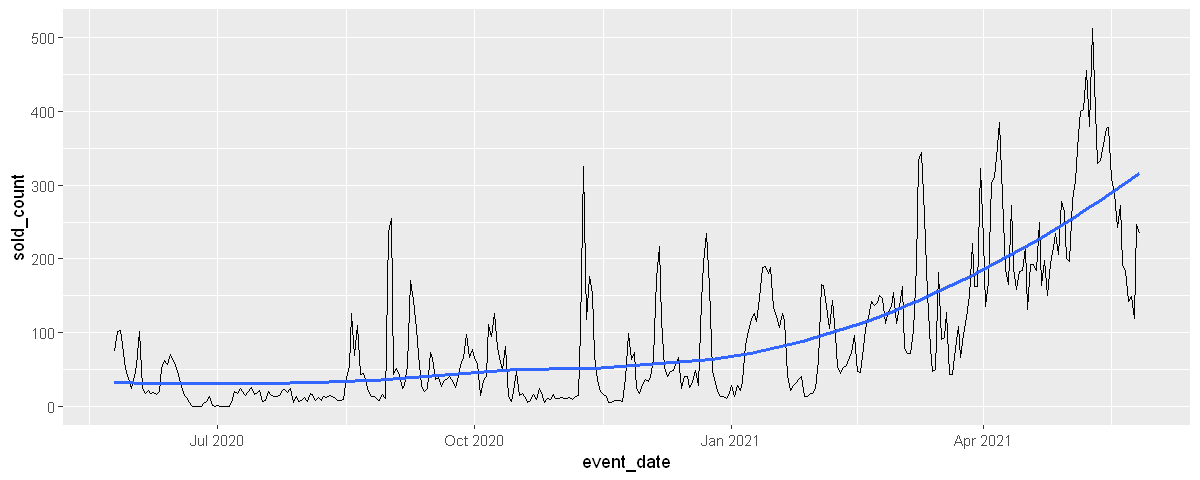

In [9]:
ggplot(prod9, aes(x=event_date, y=sold_count)) + geom_line() + geom_smooth(se=F)

* By the blue line, it seems that there is a nonlinear increasing trend in the data. 
* Variance is not constant, it increases over time. 
* The mean is also not constant over time. 
* At the end of November 2020, there are jumping points due to the Black Friday discounts. (called as efsane gunler) 
* In the middle of March 2021, there are also jumping points because of the 'Super Mart' discounts. 
* There are some days with zero sales. 
* It appears that the data is not stationary. In the next steps, it will be analysed and decomposed. 

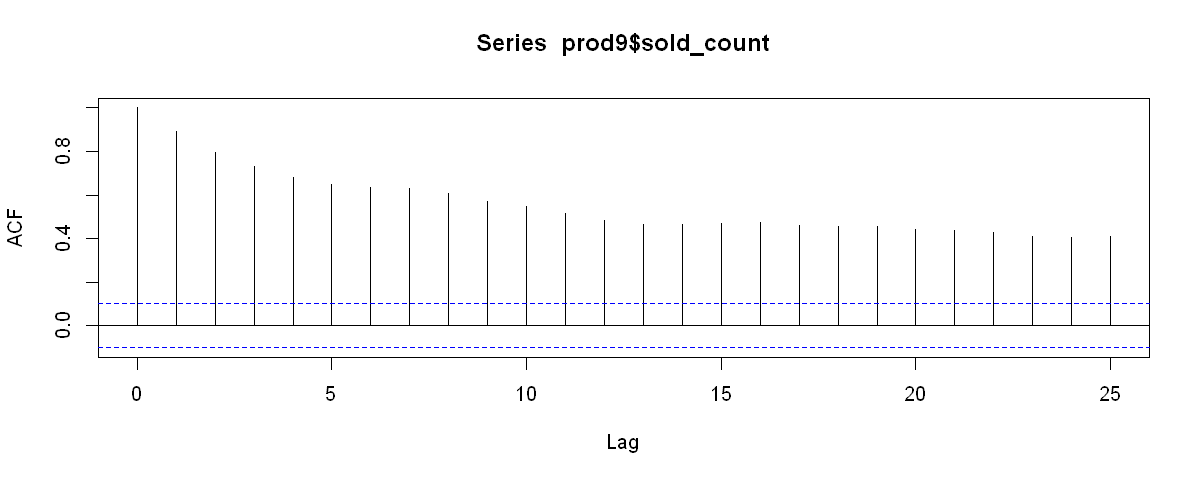

In [10]:
acf(prod9$sold_count) 

From the ACF tableau above, it seems that there is a trend. Also, there are peak points at lag 7 which indicates that there might be weekly seasonality. 

### Weekly Decomposition

Because the variance increases over time, the multiplicative decomposition method will be used. 

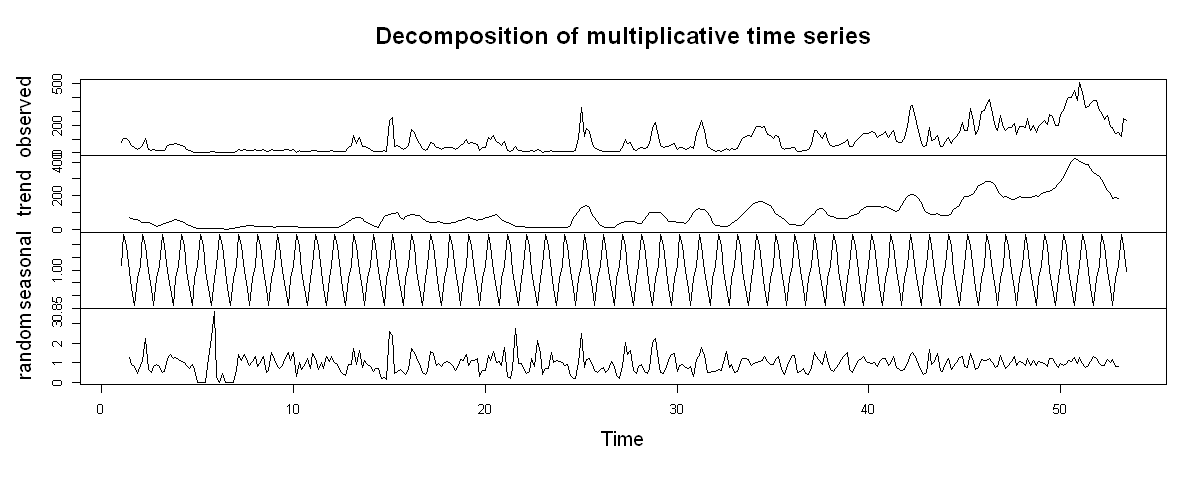

In [11]:
prod9_weekly_dec <- decompose(ts(prod9$sold_count, freq=7), type="multiplicative")
plot(prod9_weekly_dec)

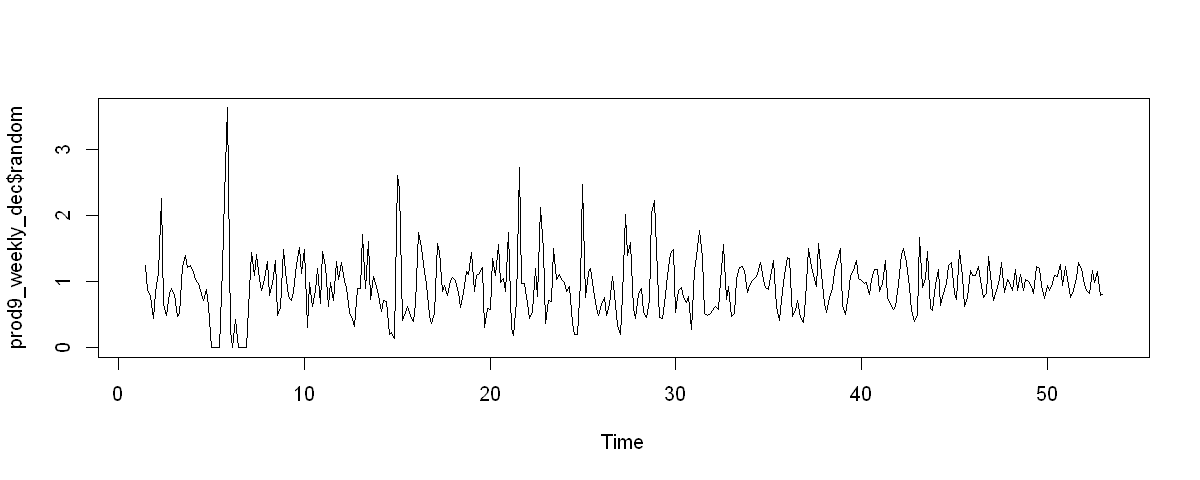

In [12]:
plot(prod9_weekly_dec$random)

* The variance is decreasing over time. 
* The mean seems to be constant. 
* There is a jumping point at the beginning of the data. 
 
Now, let's check whether the detrended and deseasonalized data is stationary. 

In [13]:
u_test <- ur.kpss(prod9_weekly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.1869 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


From the KPSS test above, it can be said that the data is stationary. 

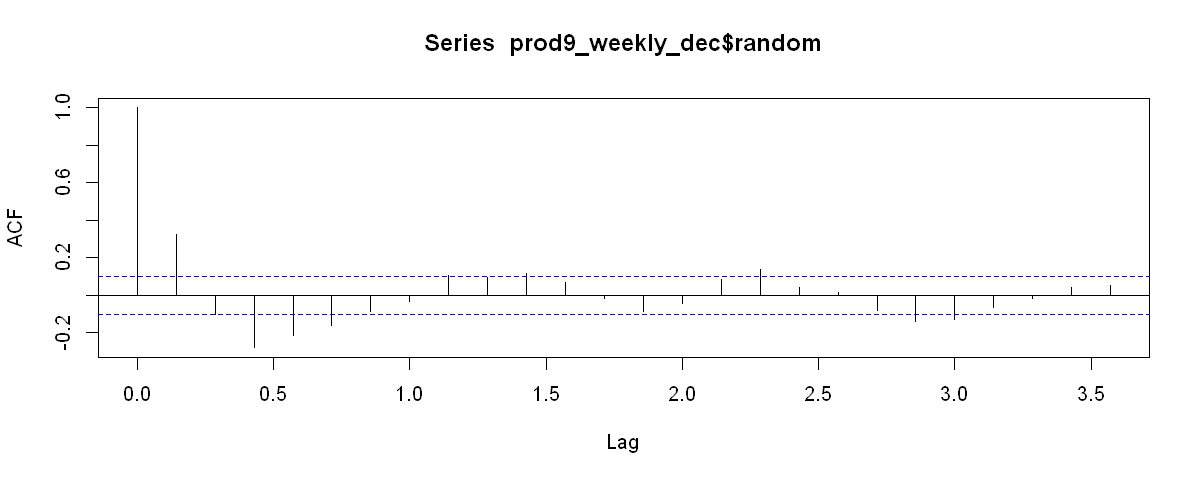

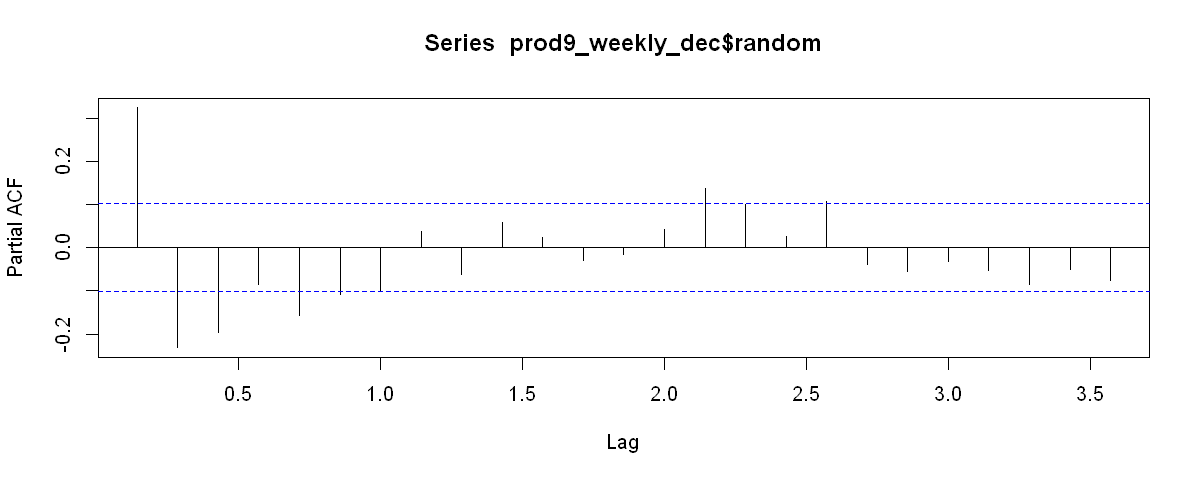

In [14]:
acf(prod9_weekly_dec$random, na.action=na.pass)
pacf(prod9_weekly_dec$random, na.action=na.pass)

There are slightly high autocorrelation at lag 1 and lag 3. From PACF above, it seems that there are low correlations with previous 3 observations in the weekly decomposed data, but the data is still stationary. 

### Monthly Decomposition

month,sold_count
2020 May,476
2020 Jun,824
2020 Jul,426
2020 Aug,1020
2020 Sep,1883
2020 Oct,1102
2020 Nov,1502
2020 Dec,2128
2021 Jan,2460
2021 Feb,2963


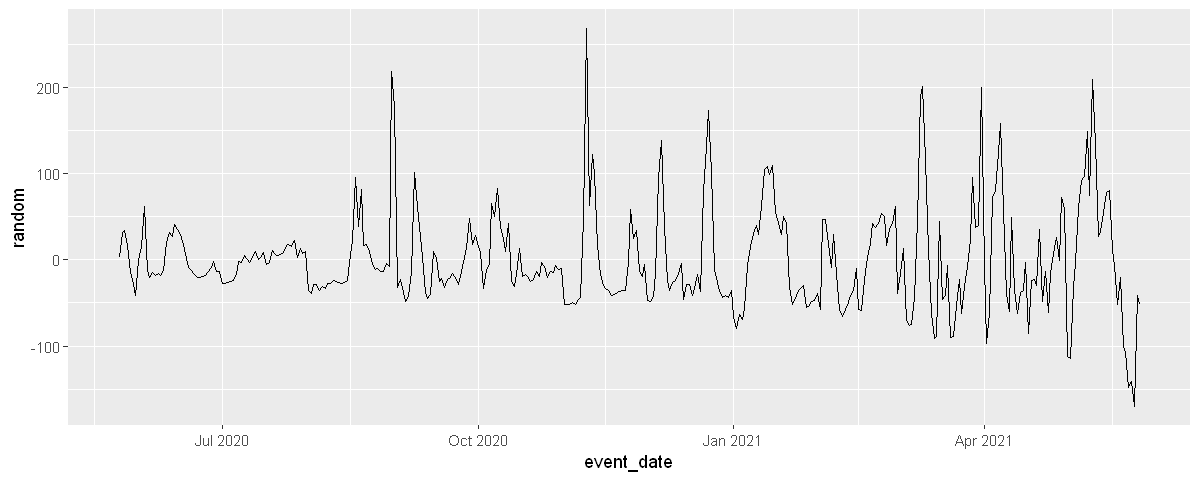

In [15]:
prod9_monthly <- prod9[, month:=yearmonth(event_date)]
prod9_monthly[, .(sold_count=sum(sold_count)), by=month]
prod9_monthly[, trend:=1:.N]

prod9_reg <- lm(sold_count~trend+as.factor(month), data=prod9_monthly)
prod9_monthly[, regOutput:=predict(prod9_reg, prod9_monthly)]

prod9_monthly[, random:=sold_count-regOutput]

ggplot(prod9_monthly, aes(x=event_date, y=random)) + geom_line()

* The variance is increasing over time. 
* The mean seems to be constant. 
* There is a jumping points in the middle of the data. 
 
Now, let's check whether the monthly detrended and deseasonalized data is stationary. 

In [16]:
u_test <- ur.kpss(prod9_monthly$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.015 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


From the KPSS unit test, we cannot reject the null hyphotesis. The data seems to be stationary.  

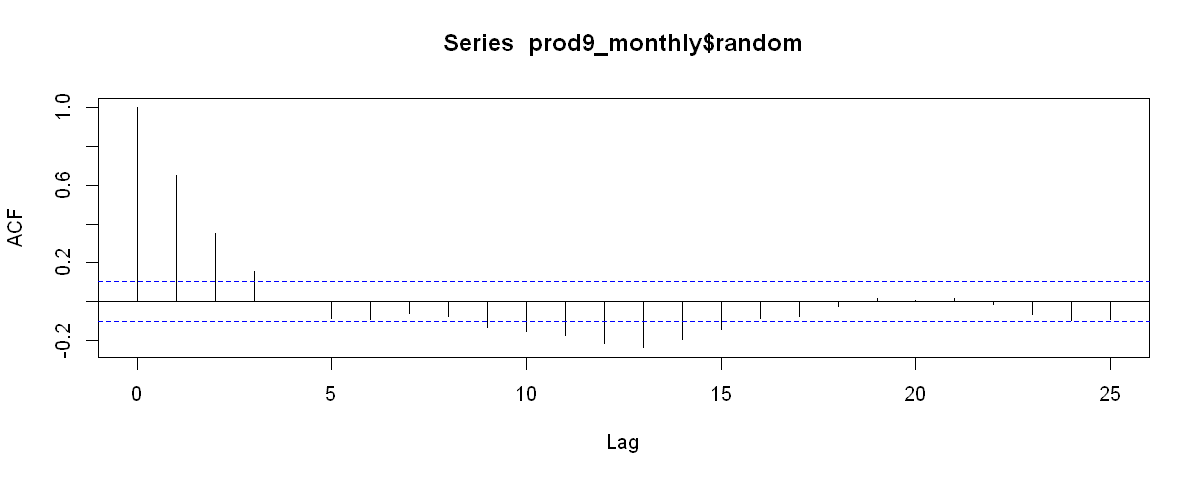

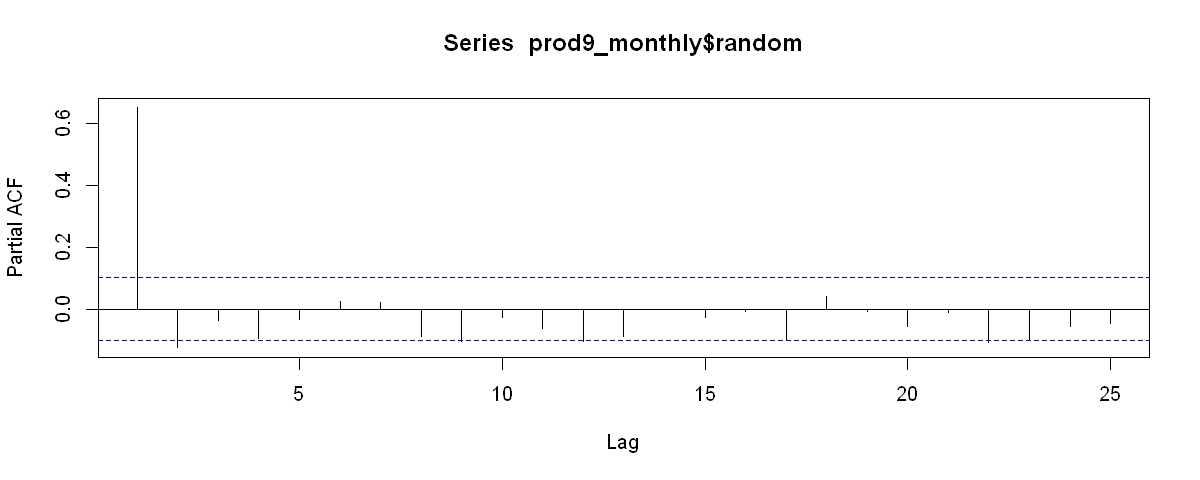

In [17]:
acf(prod9_monthly$random, na.action=na.pass)
pacf(prod9_monthly$random, na.action=na.pass)

From the PACF graph, there is a correlation with lag 1 in the data. 

### Building an ARIMA Model

In [19]:
disf <- data[product_content_id=="32939029",][order(event_date)]
disf_train <- disf[event_date<test_start,]
disf_ts <- ts(disf_train$sold_count,freq=7)

After the decomposition, it could be said that the chargable toothbrush has a weekly seasonality. Differencing could make the series stationary. 

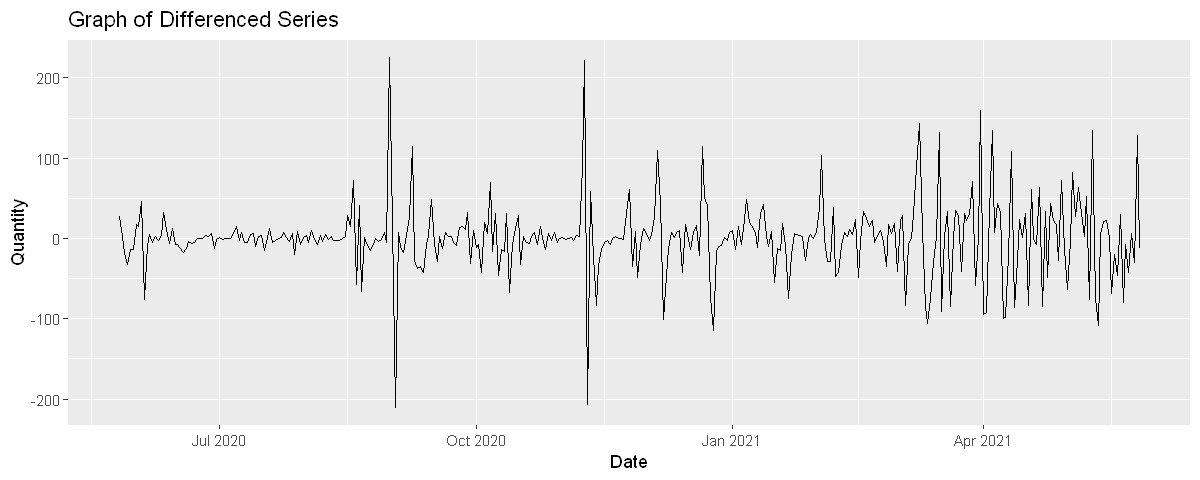

In [20]:
ggplot(disf_train[2:.N,],aes(x=event_date)) + geom_line(aes(y=diff(disf_train$sold_count,1))) + 
labs(title= "Graph of Differenced Series", x= "Date", y="Quantity")

After the differencing, the data seems stationary but it has some outliers and non-constant variance.

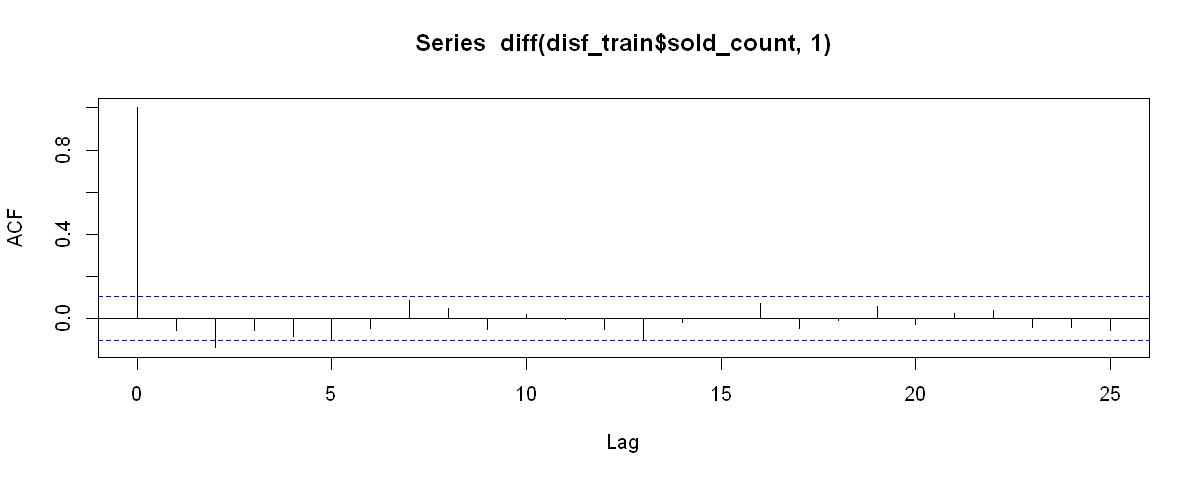

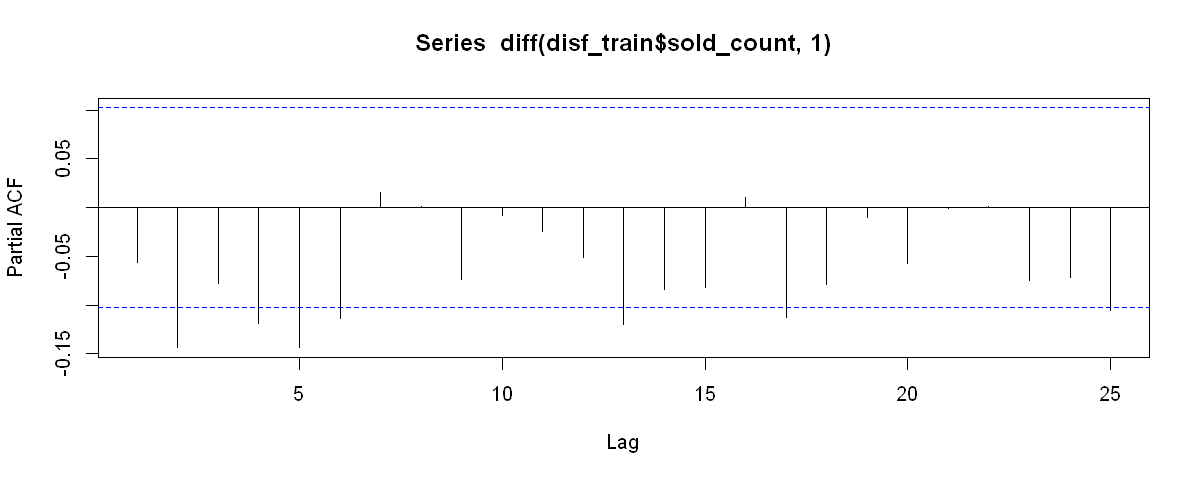

In [21]:
acf(diff(disf_train$sold_count,1))
pacf(diff(disf_train$sold_count,1))

At the ACF graph, there is a spike at lag 2 which indicates MA(2) model and also there is slighlty significant spike at lag 7 which is the seasonal MA(1). At the PACF graph, there is spikes at lag 2 and 4.  AR(2) and AR(4) models could be applied.

In [22]:
arima(disf_ts,order=c(2,1,2),seasonal=c(0,0,1))


Call:
arima(x = disf_ts, order = c(2, 1, 2), seasonal = c(0, 0, 1))

Coefficients:
         ar1      ar2      ma1     ma2    sma1
      1.7679  -0.8004  -1.9727  0.9804  0.1349
s.e.  0.0345   0.0340   0.0171  0.0168  0.0555

sigma^2 estimated as 1777:  log likelihood = -1895.31,  aic = 3802.63

In [23]:
arima(disf_ts,order=c(4,1,2),seasonal=c(0,0,1))


Call:
arima(x = disf_ts, order = c(4, 1, 2), seasonal = c(0, 0, 1))

Coefficients:
         ar1      ar2     ar3      ar4      ma1     ma2    sma1
      0.8586  -0.1346  0.0465  -0.0526  -1.0146  0.0604  0.1120
s.e.  0.8228   0.6586  0.0934   0.0545   0.8243  0.7871  0.0571

sigma^2 estimated as 1834:  log likelihood = -1900.03,  aic = 3816.06

In [24]:
auto.arima(disf_ts)

Series: disf_ts 
ARIMA(2,1,2)(0,0,1)[7] with drift 

Coefficients:
         ar1      ar2      ma1     ma2    sma1   drift
      1.7675  -0.8063  -1.9672  0.9751  0.1516  0.7005
s.e.  0.0351   0.0345   0.0177  0.0176  0.0550  0.5119

sigma^2 estimated as 1803:  log likelihood=-1894.91
AIC=3803.82   AICc=3804.13   BIC=3831.16

After trying some SARIMA models, auto.arima function gives the nearly same result with the SARIMA(2,1,2)(0,0,1). We could use our model to forecasting.


	Ljung-Box test

data:  Residuals from ARIMA(2,1,2)(0,0,1)[7]
Q* = 8.7094, df = 9, p-value = 0.4645

Model df: 5.   Total lags used: 14



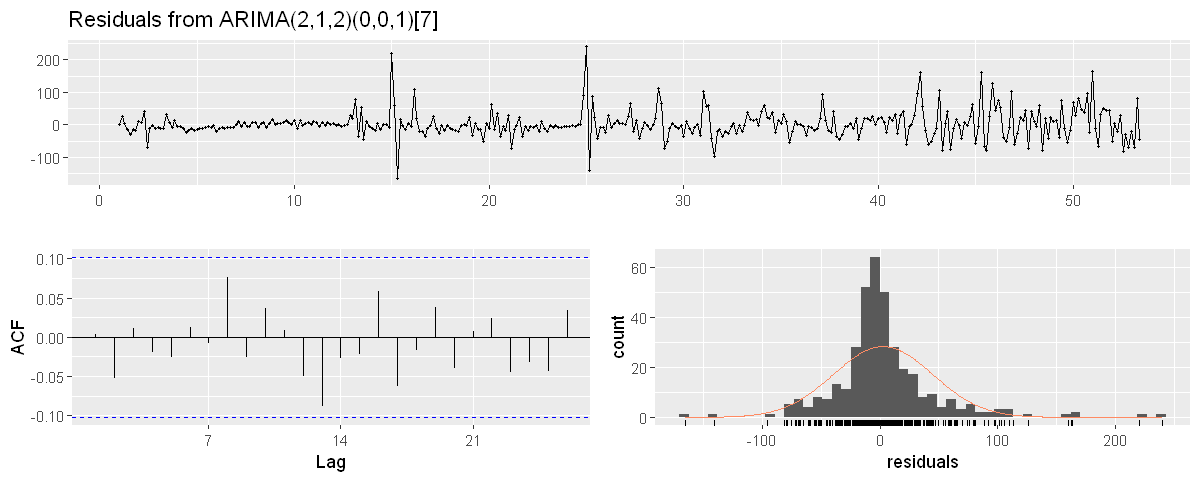

In [25]:
model_disf_sarima <- arima(disf_ts,order=c(2,1,2),seasonal=c(0,0,1))
checkresiduals(model_disf_sarima)

Residuals look stationary with constant mean at 0. Variance isn't constant but there is not any significant correlations at ACF graph. The distribution seems normal.

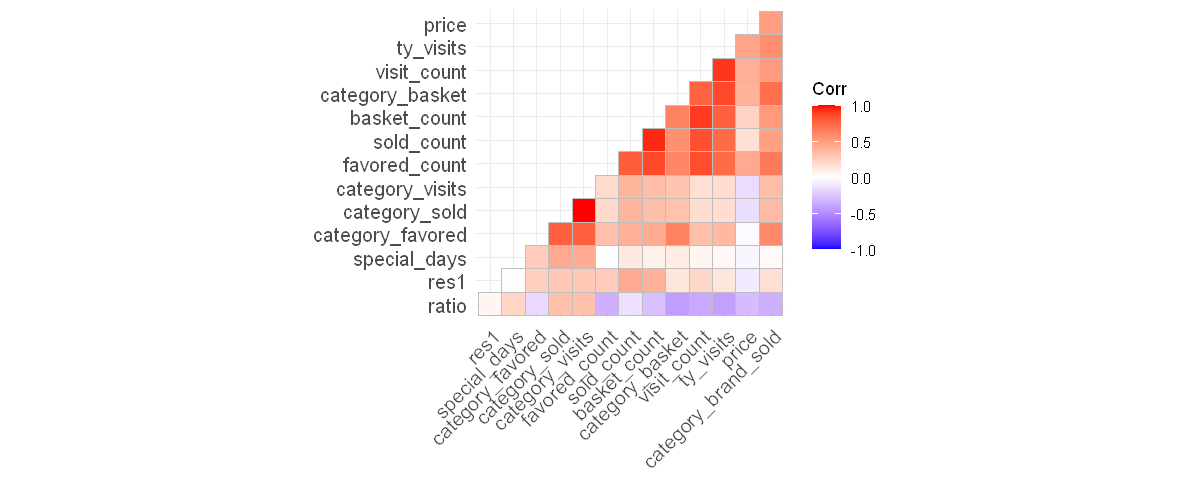

In [26]:
disf_train$res1 <- model_disf_sarima$residuals
corr <- cor(disf_train[!is.na(disf_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals have highest correlation with basket_count which 0.4. Also it still has correlation with output variable which means there is still unexplained data in sold_count. We could add basket_count as a regressor.


Call:
arima(x = disf_ts, order = c(2, 1, 2), seasonal = c(0, 0, 1), xreg = disf_train$basket_count)

Coefficients:
         ar1     ar2      ma1      ma2    sma1  disf_train$basket_count
      0.4948  0.1012  -0.9428  -0.0173  0.0144                   0.2016
s.e.  0.3293  0.1832   0.3275   0.3085  0.0591                   0.0069

sigma^2 estimated as 584:  log likelihood = -1690.23,  aic = 3394.47


	Ljung-Box test

data:  Residuals from ARIMA(2,1,2)(0,0,1)[7]
Q* = 8.6399, df = 8, p-value = 0.3736

Model df: 6.   Total lags used: 14



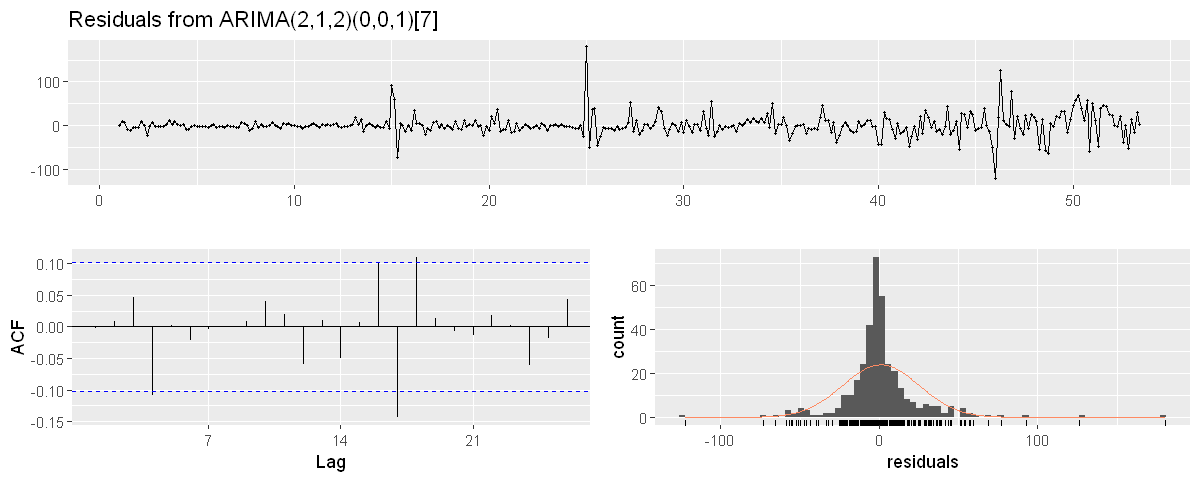

In [27]:
model_disf_sarimax <- arima(disf_ts,order=c(2,1,2),seasonal=c(0,0,1),xreg=disf_train$basket_count)
disf_train$res2 <- model_disf_sarimax$residuals
model_disf_sarimax
checkresiduals(model_disf_sarimax)

After the addition of the baskes_count as a regressor, AIC value is reduced to 3394 from 3804. Residuals didn't change much after the addition of the regressor.

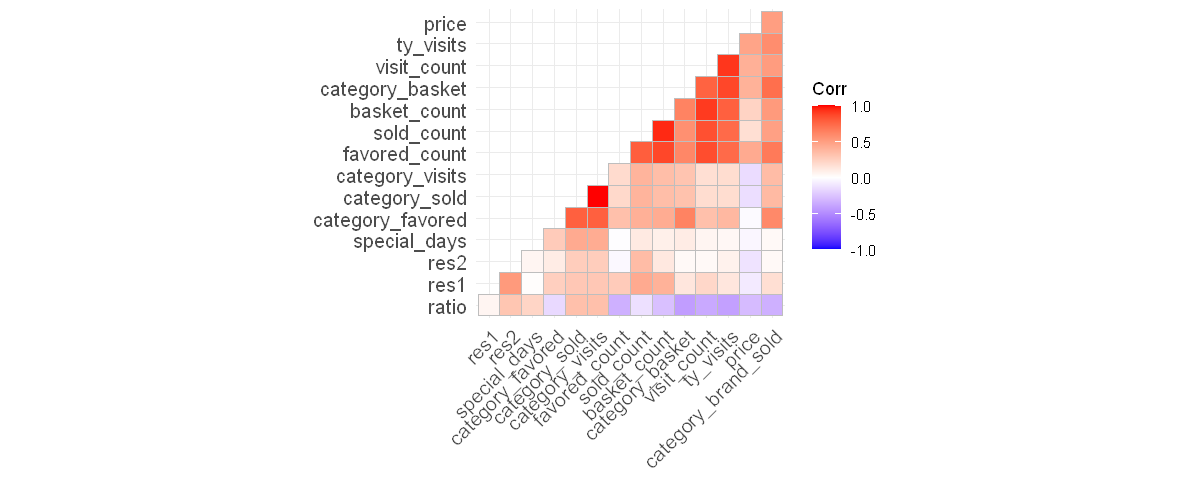

In [29]:
corr <- cor(disf_train[!is.na(disf_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals still have correlation with category_visits but not significantly, it could be added as a regressor.

In [30]:
model_disf_sarimax2 <- arima(disf_ts,order=c(2,1,2),seasonal=c(0,0,1),xreg=as.matrix(disf_train$basket_count,disf_train$category_visits))
disf_train$res3 <- model_disf_sarimax2$residuals
model_disf_sarimax2


Call:
arima(x = disf_ts, order = c(2, 1, 2), seasonal = c(0, 0, 1), xreg = as.matrix(disf_train$basket_count, 
    disf_train$category_visits))

Coefficients:
         ar1     ar2      ma1      ma2    sma1
      0.4948  0.1012  -0.9428  -0.0173  0.0144
s.e.  0.3293  0.1832   0.3275   0.3085  0.0591
      as.matrix(disf_train$basket_count, disf_train$category_visits)
                                                              0.2016
s.e.                                                          0.0069

sigma^2 estimated as 584:  log likelihood = -1690.23,  aic = 3394.47

The addition of the new regressor didn't change the AIC value. So, the previous SARIMAX model could be use in forecasting.

### Linear Models

Firstly, the days of week and trend columns will be added to the data. Next, the first model will be built with trend and weekly seasonality. Then, we'll look for possible regressors and add them to the model. Finally, we will find the best model among them. 

In [31]:
prod9[, `:=`(trend=1:.N, 
            days=wday(event_date, label=T))]

model9_1 <- lm(sold_count~trend+days, data=prod9)
summary(model9_1)


Call:
lm(formula = sold_count ~ trend + days, data = prod9)

Residuals:
     Min       1Q   Median       3Q      Max 
-132.639  -52.786   -4.228   25.393  312.511 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -24.5927     7.5574  -3.254  0.00125 ** 
trend         0.6295     0.0355  17.733  < 2e-16 ***
days.L      -11.1555    10.0111  -1.114  0.26589    
days.Q      -24.6844     9.9930  -2.470  0.01397 *  
days.C        6.6013     9.9841   0.661  0.50892    
days^4        4.9652     9.9780   0.498  0.61906    
days^5       -0.5982     9.9568  -0.060  0.95213    
days^6       -1.4376     9.9403  -0.145  0.88509    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 72.34 on 360 degrees of freedom
Multiple R-squared:  0.4726,	Adjusted R-squared:  0.4623 
F-statistic: 46.08 on 7 and 360 DF,  p-value: < 2.2e-16



	Breusch-Godfrey test for serial correlation of order up to 11

data:  Residuals
LM test = 241.05, df = 11, p-value < 2.2e-16


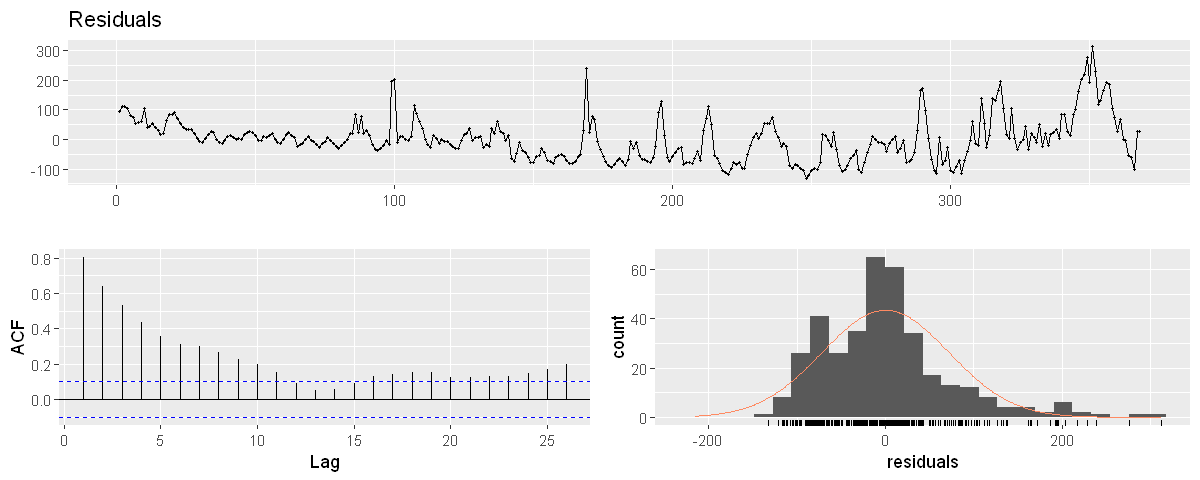

In [32]:
checkresiduals(model9_1)

* The first adjusted Rsqr value is 0.4623. 
* The model's p value is small, which means that the model is meaningful. 
* The mean is not zero. 
* The variance is not constant. 
* Residuals are not exactly normally distributed. 
* There are autocorrelations between the residuals. 

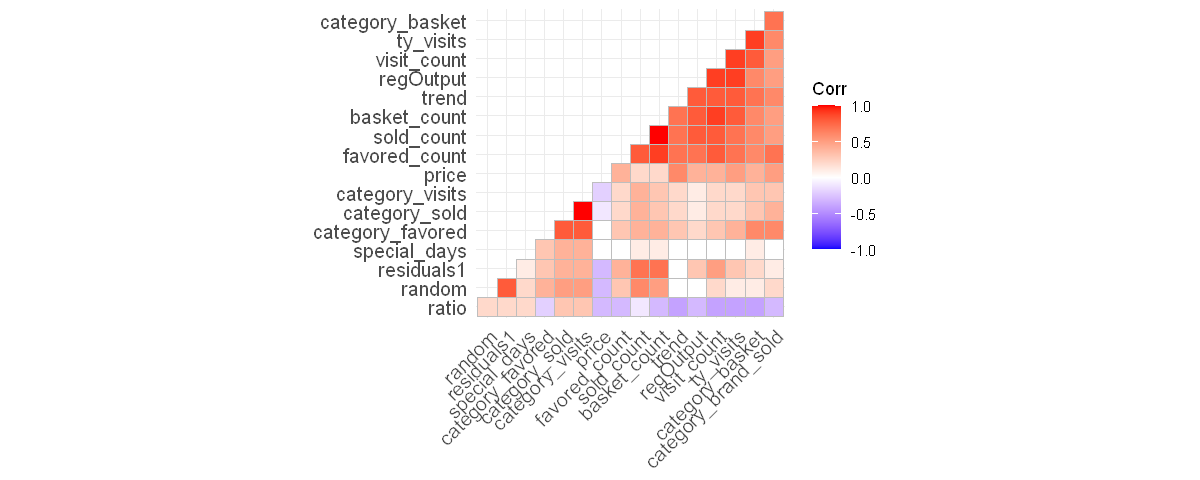

In [35]:
prod9[, residuals1:=model9_1$residuals]
corr <- round(cor(Filter(is.numeric, prod9[!is.na(prod9$price)])), 1)
ggcorrplot(corr, hc.order = TRUE,type = "lower")

The maximum correlation with residuals1 is obtained by basket_count. Therefore, its lagged version will be added to the model. To find the lag value, we'll check the CCF function. 

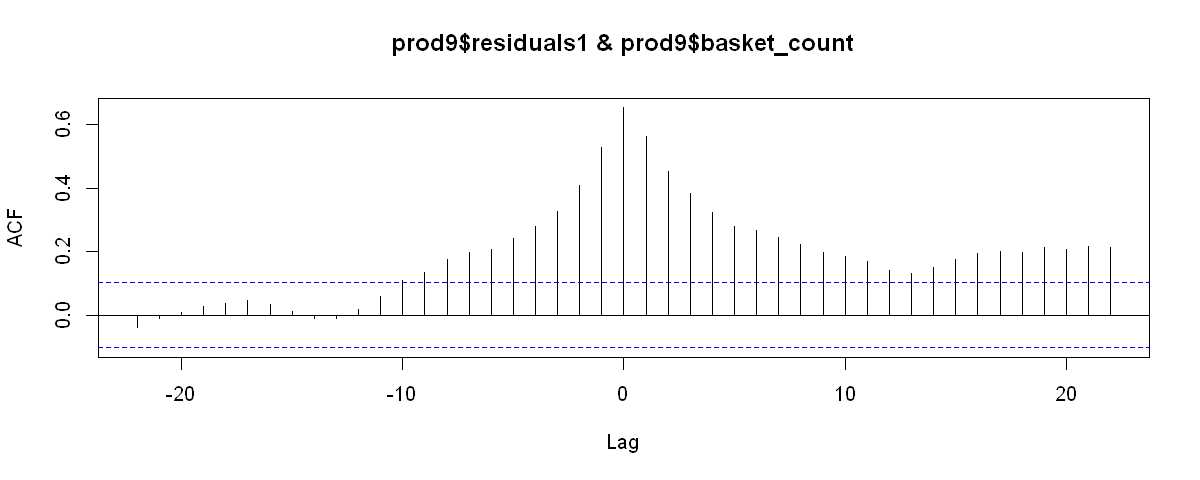

In [36]:
ccf(prod9$residuals1, prod9$basket_count)

In [37]:
model9_2 <- lm(sold_count~trend+days+shift(basket_count, 1), data=prod9)
summary(model9_2)


Call:
lm(formula = sold_count ~ trend + days + shift(basket_count, 
    1), data = prod9)

Residuals:
     Min       1Q   Median       3Q      Max 
-120.092  -19.837   -3.592   13.588  210.497 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -4.046992   4.848546  -0.835   0.4045    
trend                    0.131437   0.030881   4.256 2.66e-05 ***
days.L                 -13.237320   6.282332  -2.107   0.0358 *  
days.Q                  -3.623403   6.324899  -0.573   0.5671    
days.C                   7.632546   6.266052   1.218   0.2240    
days^4                   0.713755   6.274741   0.114   0.9095    
days^5                  -4.971861   6.252058  -0.795   0.4270    
days^6                  -1.699824   6.230668  -0.273   0.7852    
shift(basket_count, 1)   0.183713   0.007801  23.549  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 45.32 on 358 degrees of freedom
  (1 


	Breusch-Godfrey test for serial correlation of order up to 12

data:  Residuals
LM test = 53.348, df = 12, p-value = 3.572e-07


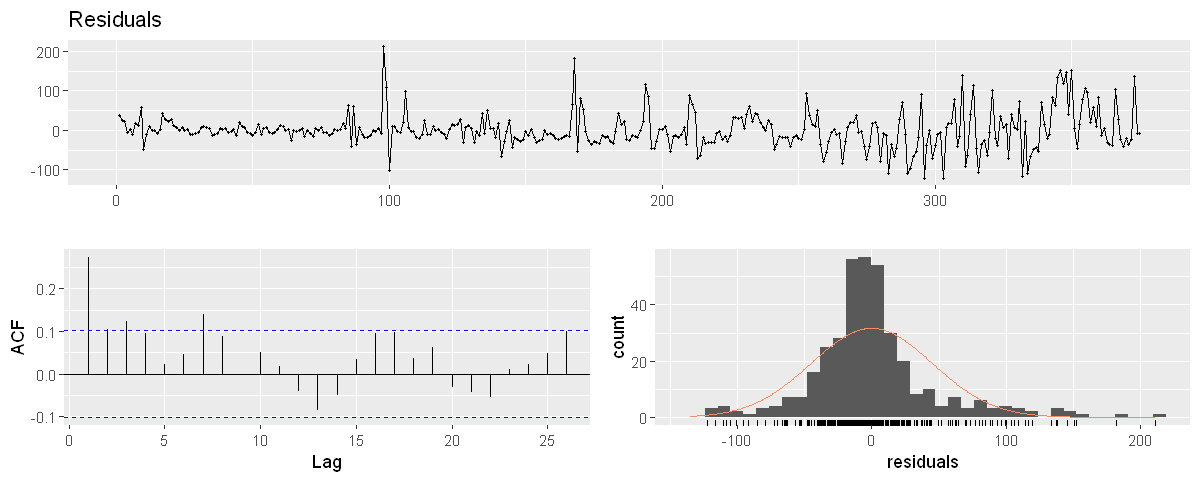

In [272]:
checkresiduals(model9_2)

* The adjusted Rsqr value is increased to 0.7895. 
* The model's p value is small, which means that the model is meaningful. 
* The mean seems to be zero. 
* The variance is not constant. 
* Residuals are still not exactly normally distributed. 
* There is a high autocorrelation at lag 1. 

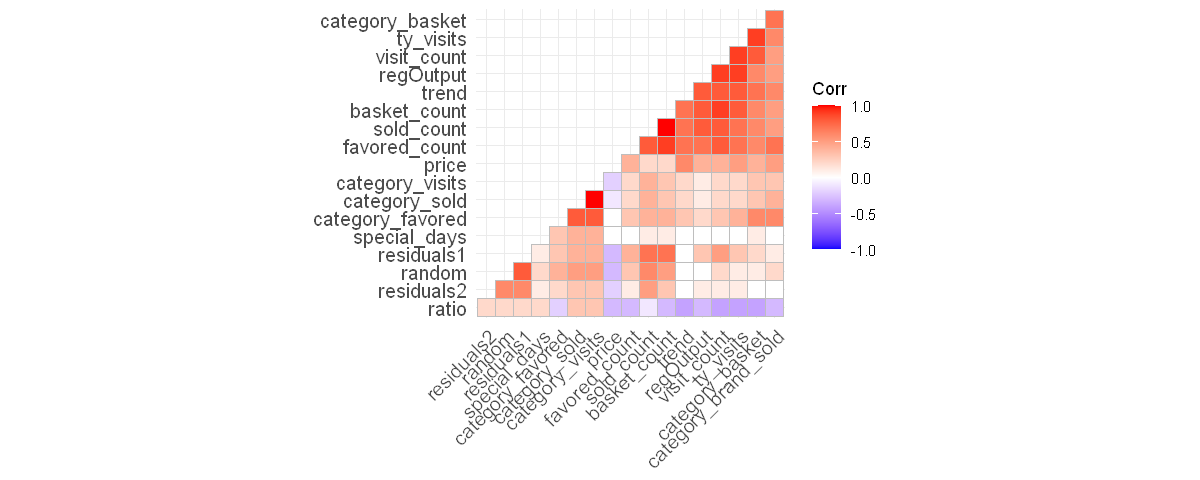

In [38]:
prod9[, residuals2:=c(NA, model9_2$residuals)]
corr <- round(cor(Filter(is.numeric, prod9[!is.na(prod9$price) & !is.na(prod9$residuals2)])), 1)
ggcorrplot(corr, hc.order = TRUE,type = "lower")

The maximum correlation with residuals2 is obtained by category_sold. Therefore, its lagged version will be added to the model. To find the lag value, we'll check the CCF function. 

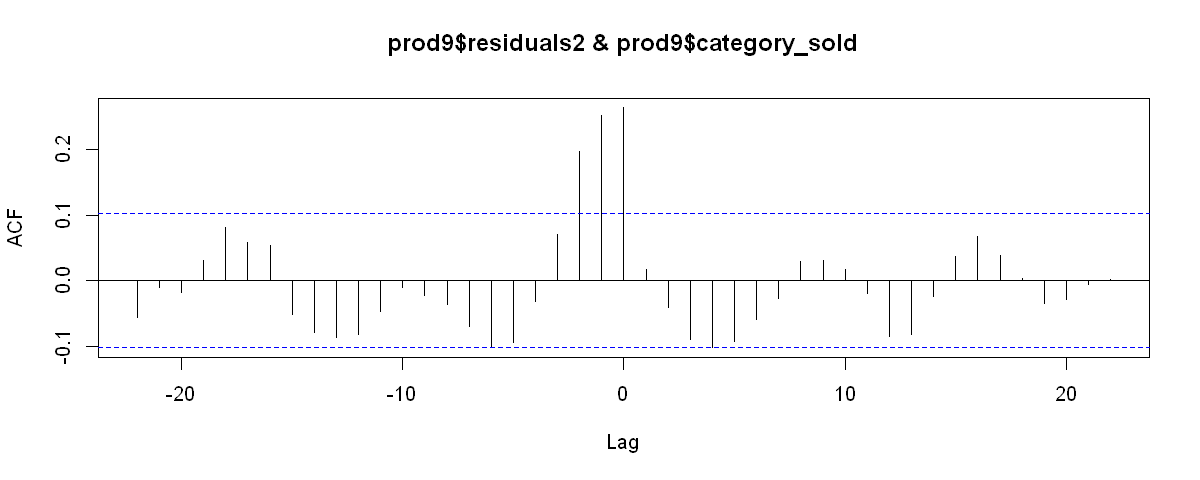

In [39]:
ccf(prod9$residuals2, prod9$category_sold, na.action=na.pass)

In [40]:
model9_3 <- lm(sold_count~trend+days+shift(basket_count, 1)+shift(category_sold, 1), data=prod9)
summary(model9_3)


Call:
lm(formula = sold_count ~ trend + days + shift(basket_count, 
    1) + shift(category_sold, 1), data = prod9)

Residuals:
     Min       1Q   Median       3Q      Max 
-119.668  -19.856   -3.278   13.009  210.703 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              -5.067239   5.620746  -0.902   0.3679    
trend                     0.132269   0.031005   4.266 2.55e-05 ***
days.L                  -13.611901   6.375415  -2.135   0.0334 *  
days.Q                   -3.338151   6.381954  -0.523   0.6013    
days.C                    7.915130   6.322570   1.252   0.2114    
days^4                    0.688536   6.282772   0.110   0.9128    
days^5                   -4.978390   6.259698  -0.795   0.4270    
days^6                   -1.722637   6.238577  -0.276   0.7826    
shift(basket_count, 1)    0.182818   0.008197  22.303  < 2e-16 ***
shift(category_sold, 1)   0.001185   0.003290   0.360   0.7190    
---
Signif. codes:  0 '***'

Although we added a new attribute to the model, the adjusted Rsqr value decreased. Also, category_sold is not significant according to the model output. Therefore, it'll be removed from the model. Now, let's check if the residuals2 is related with the lagged version of the input variable. 

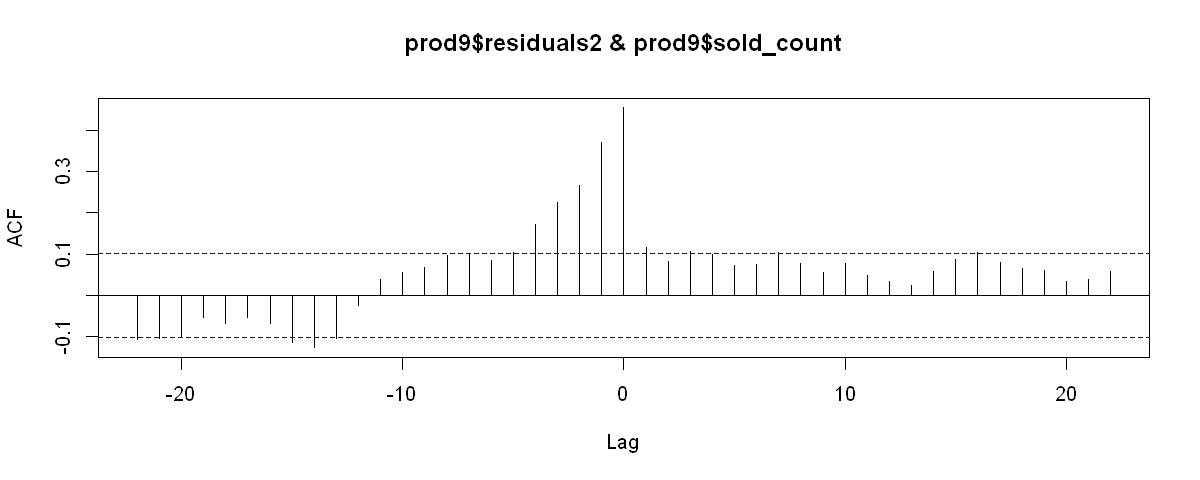

In [41]:
ccf(prod9$residuals2, prod9$sold_count, na.action=na.pass)

In [42]:
model9_4 <- lm(sold_count~trend+days+shift(basket_count, 1)+shift(sold_count, 1), data=prod9)
summary(model9_4)


Call:
lm(formula = sold_count ~ trend + days + shift(basket_count, 
    1) + shift(sold_count, 1), data = prod9)

Residuals:
     Min       1Q   Median       3Q      Max 
-154.121  -17.791   -3.614   13.348  211.074 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -4.11215    4.49509  -0.915 0.360910    
trend                    0.10774    0.02879   3.742 0.000213 ***
days.L                 -16.95943    5.84430  -2.902 0.003940 ** 
days.Q                  -3.19804    5.86407  -0.545 0.585845    
days.C                   9.67218    5.81527   1.663 0.097142 .  
days^4                   1.21133    5.81767   0.208 0.835179    
days^5                  -3.46145    5.79959  -0.597 0.550990    
days^6                  -1.83813    5.77648  -0.318 0.750512    
shift(basket_count, 1)   0.06283    0.01726   3.641 0.000312 ***
shift(sold_count, 1)     0.56367    0.07307   7.715 1.22e-13 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05


	Breusch-Godfrey test for serial correlation of order up to 13

data:  Residuals
LM test = 13.701, df = 13, p-value = 0.3952


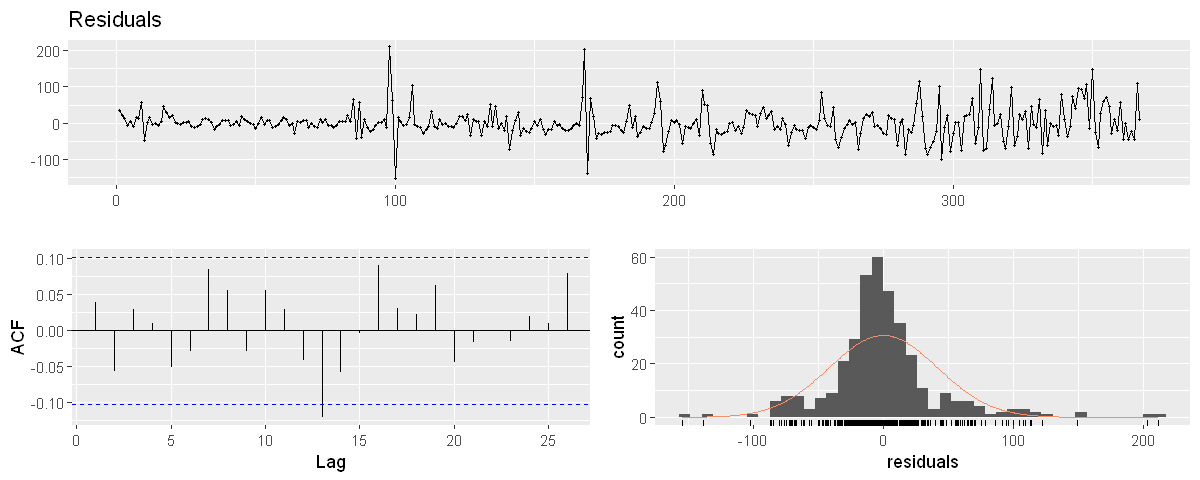

In [43]:
checkresiduals(model9_4)

* The adjusted Rsqr value is increased to 0.819. 
* The model's p value is small, which means that the model is meaningful. 
* The mean seems to be zero. 
* The variance is like constant. 
* Residuals are more likely to be normally distributed. 
* There is not a significant autocorrelation. 
 
So, the final model is model9_4.

Warning message:
"Removed 1 rows containing missing values (geom_point)."

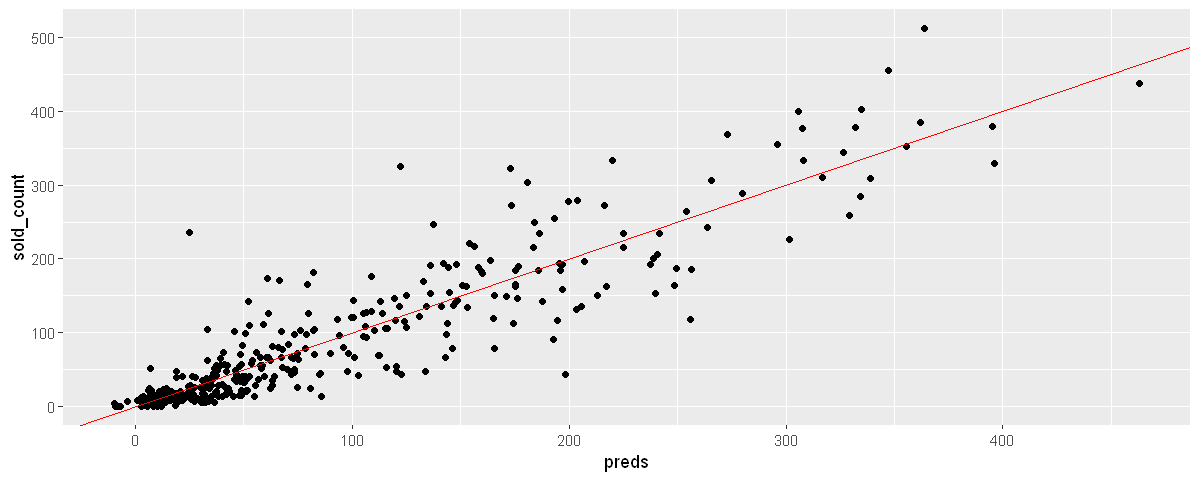

In [44]:
prod9[, preds:=c(NA,model9_4$fitted.values)]
ggplot(prod9, aes(x=preds, y=sold_count)) + geom_point() + geom_abline(intercept=0, slope=1, color="red") 

### Forecasting

In [441]:
forecast_data_disf <- data.table(event_date=disf[event_date>=test_start&event_date<=test_end,]$event_date,
                            sold_count=disf[event_date>=test_start&event_date<=test_end,]$sold_count)
disf[,`:=`(trend=1:.N,
          days=wday(event_date, label=T))]
sarima_fc <- numeric(0)
sarimax_fc <- numeric(0)
reg_fc <- numeric(0)
for(i in 1:length(test_dates)){
  
  train_dt <- disf[event_date<test_dates[i],]
  model_sarima <- Arima(train_dt$sold_count,order=c(2,1,2),seasonal=c(0,0,1))
  model_sarimax <- Arima(train_dt$sold_count,order=c(2,1,2),seasonal=c(0,0,1),xreg=train_dt$basket_count)
  model_reg <- lm(sold_count~trend+days+shift(basket_count, 1)+shift(sold_count, 1), data=train_dt)
  newreg <- forecast(auto.arima(train_dt$basket_count),h=1)$mean[1]
  sarima_temp <- forecast(model_sarima)
  sarimax_temp <- forecast(model_sarimax,xreg=newreg)
  reg_temp <- predict(model_reg,newdata=disf[event_date %in% c(test_dates[i],test_dates[i+1])])
  sarima_fc <- c(sarima_fc,sarima_temp$mean[1])
  sarimax_fc <- c(sarimax_fc,sarimax_temp$mean[1])
  reg_fc <- c(reg_fc,reg_temp)
  
}
reg_fc[is.na(reg_fc)] <- mean(reg_fc[!is.na(reg_fc)])
forecast_data_disf <- forecast_data_disf[,`:=`(sarima_p=sarima_fc,
                                               sarimax_p=sarimax_fc,
                                               reg_p=reg_fc[c(1,seq(2,28,2))])]
accu(forecast_data_disf$sold_count,forecast_data_disf$sarima_p)
accu(forecast_data_disf$sold_count,forecast_data_disf$sarimax_p)
accu(forecast_data_disf[1:(.N-1)]$sold_count,forecast_data_disf[2:.N]$reg_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
15,149.4667,68.00826,0.4550062,-0.1823611,0.3790575,64.45033,49.22688,0.3293503,0.3293503


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
15,149.4667,68.00826,0.4550062,-0.1858003,0.3648424,61.69227,48.17218,0.3222938,0.3222938


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
14,154.7143,67.35032,0.4353206,-0.05606837,0.1490131,21.98073,20.64795,0.1334586,0.1334586


In [457]:
result_data_disf <- data.table(event_date=disf[event_date>=result_start&event_date<=result_end,]$event_date,
                            sold_count=disf[event_date>=result_start&event_date<=result_end,]$sold_count)
final_fc <- numeric(0)
for(i in 1:length(result_dates)){
  
  train_dt <- disf[event_date<result_dates[i],]
  model_final <- lm(sold_count~trend+days+shift(basket_count, 1)+shift(sold_count, 1), data=train_dt)
  final_temp <- predict(model_final,newdata=disf[event_date %in% c(result_dates[i],result_dates[i+1])])
  final_fc <- c(final_fc,final_temp)
  
}
final_fc[is.na(final_fc)] <- mean(final_fc[!is.na(final_fc)])
result_data_disf <- result_data_disf[,`:=`(final_p=final_fc[c(1,seq(2,28,2))])]
accu(result_data_disf[1:(.N-1)]$sold_count,result_data_disf[2:.N]$final_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
14,122,68.43751,0.5609632,-0.06905548,0.1862189,17.45269,15.73057,0.1289391,0.1289391


In [443]:
data.frame(event_date=result_data_disf[1:(.N-1)]$event_date,
           sold_count=result_data_disf[1:(.N-1)]$sold_count,
           predictions=result_data_disf[2:.N]$final_p)

event_date,sold_count,predictions
2021-06-12,83,108.26948
2021-06-13,115,136.54818
2021-06-14,245,232.44108
2021-06-15,265,243.71517
2021-06-16,169,162.21124
2021-06-17,135,124.49187
2021-06-18,108,109.24042
2021-06-19,104,121.13375
2021-06-20,149,165.71563
2021-06-21,128,142.33474


### Sleepy Bebek Islak Mendil

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


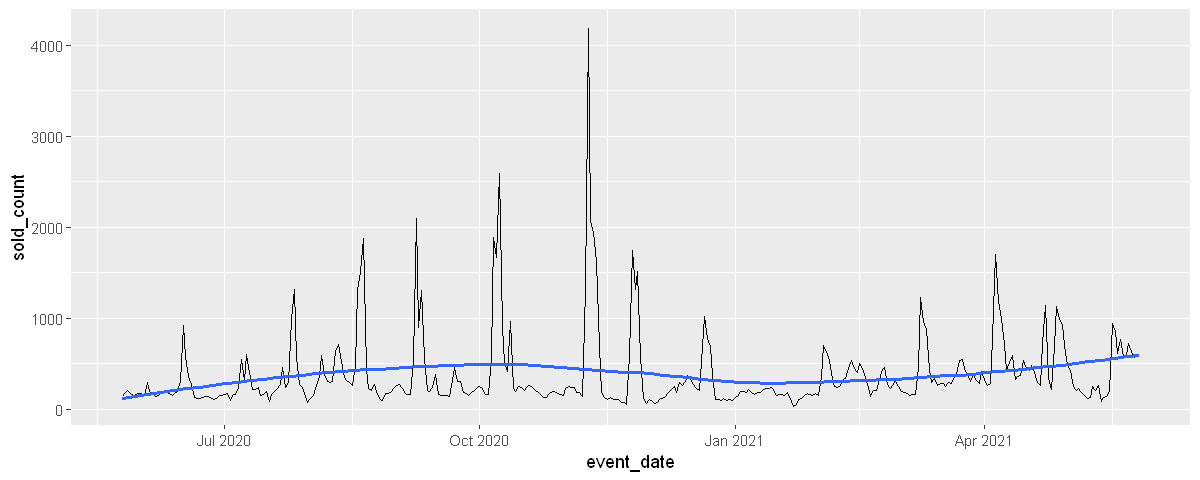

In [73]:
ggplot(prod8, aes(x=event_date, y=sold_count)) + geom_line() + geom_smooth(se=F)

* The variance is not constant over time. 
* The mean changes over time. There is a sinuate trend. We can see them by the blue line.  
* In the middle of the graph, there are jumping points. The discount days could cause them. 
* The data above is not stationary because of the non-constant variance and mean. 

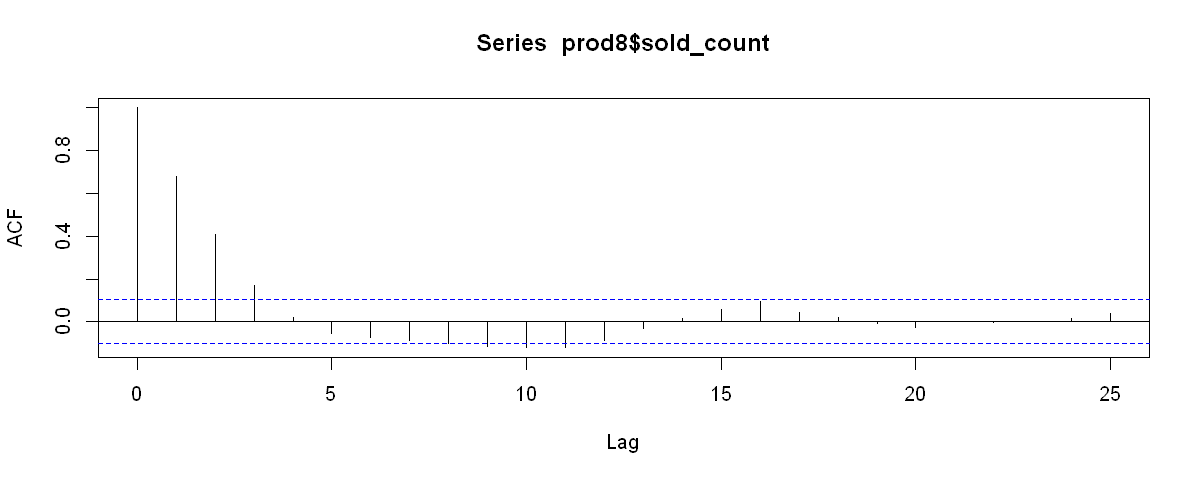

In [74]:
acf(prod8$sold_count)

The ACF graph is like sinus wave. Next steps below, the data will be decomposed at different levels. Because the variance is not increasing over time, additive decomposition will be used. 

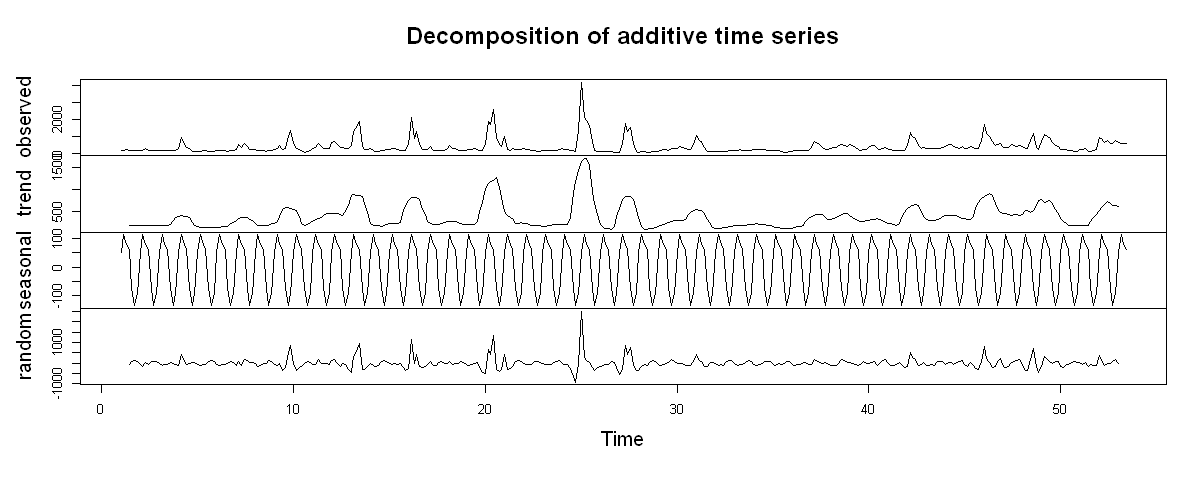

In [75]:
prod8_weekly_dec <- decompose(ts(prod8$sold_count, freq=7), type="additive")
plot(prod8_weekly_dec)

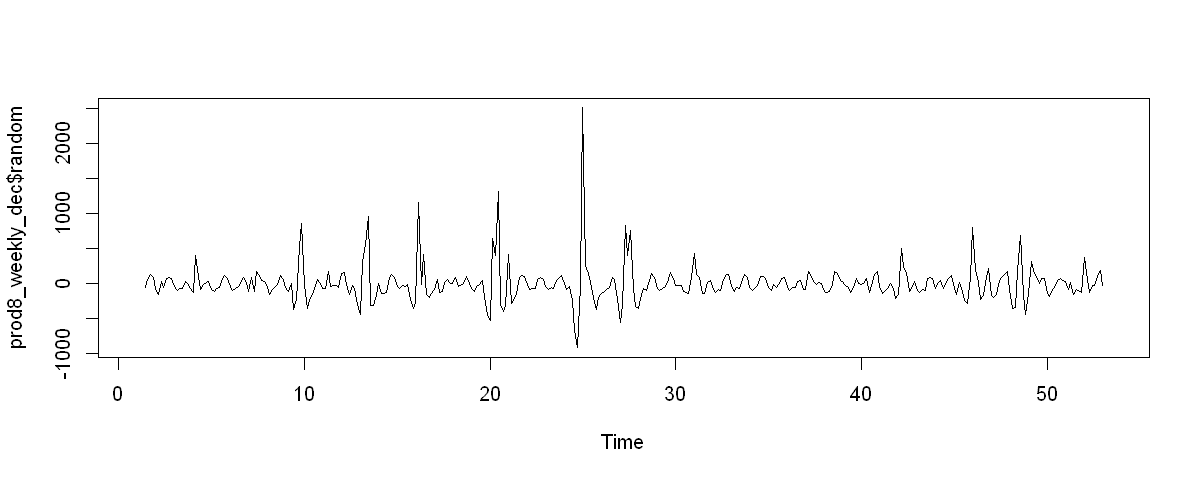

In [76]:
plot(prod8_weekly_dec$random)

* The mean is constant. 
* The variance seems not to be constant due to the jumping points. 
 
Now, let's check whether the detrended and deseasonalized data is stationary. 

In [77]:
u_test <- ur.kpss(prod9_weekly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.1869 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


There is not enough evidence to reject the null hyphotesis. The data is stationary. 

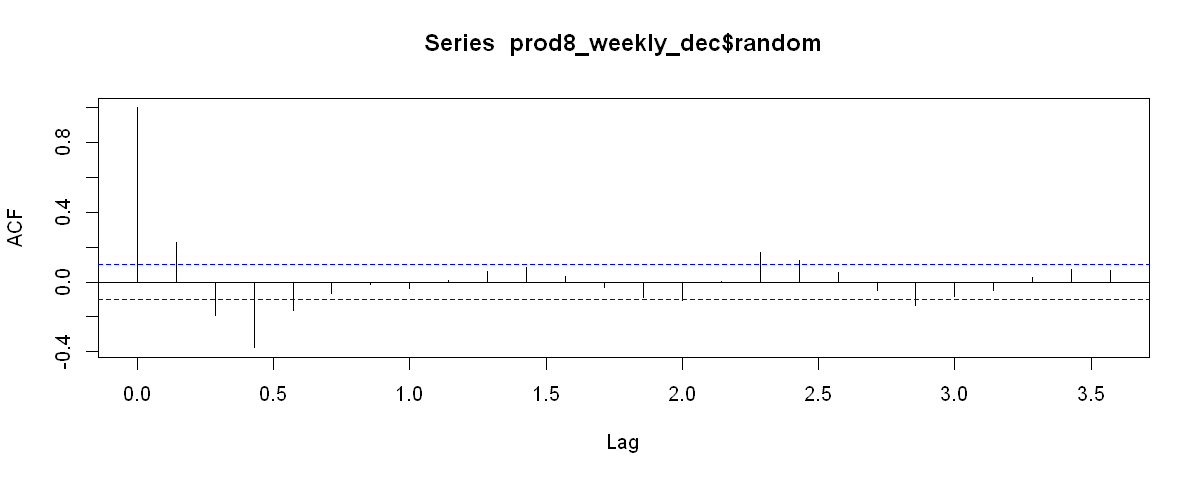

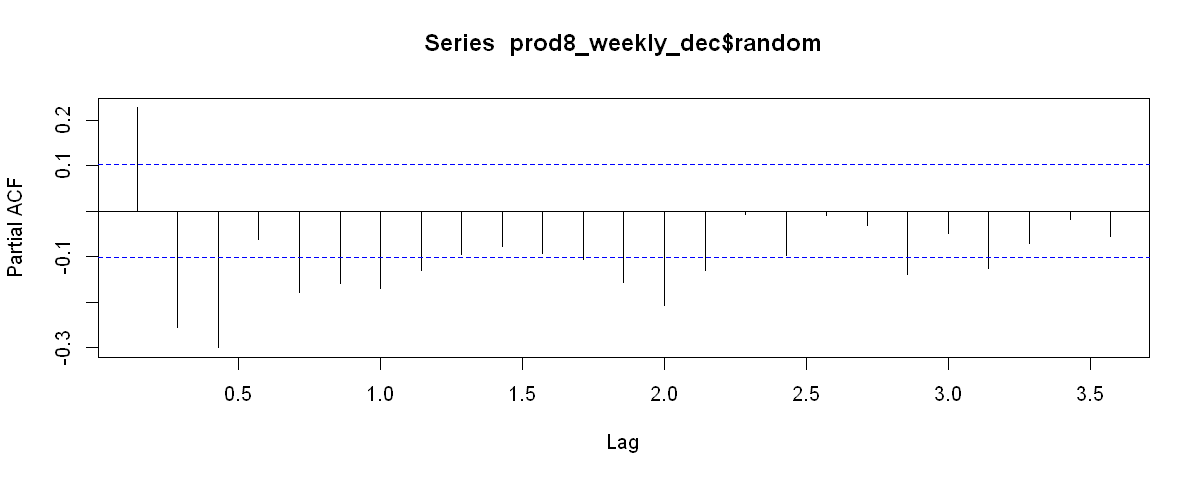

In [78]:
acf(prod8_weekly_dec$random, na.action=na.pass)
pacf(prod8_weekly_dec$random, na.action=na.pass)

The correlation values are not high. From the ACF, it can be said that the data is correlated with its previous three observations. 

### Monthly Decomposition

month,sold_count
2020 May,1181
2020 Jun,6379
2020 Jul,9588
2020 Aug,13341
2020 Sep,10967
2020 Oct,14086
2020 Nov,20286
2020 Dec,7932
2021 Jan,5088
2021 Feb,10201


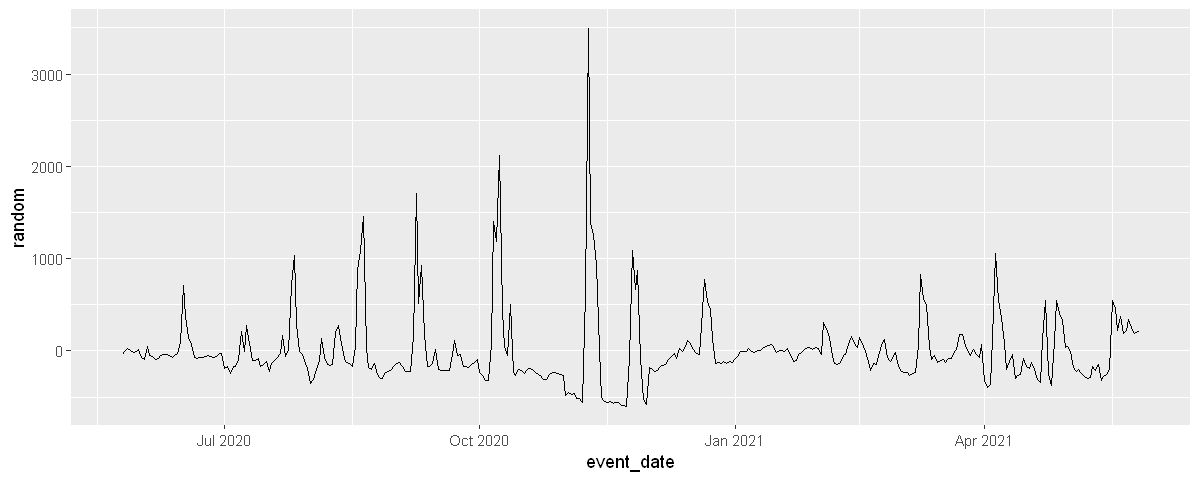

In [79]:
prod8_monthly <- prod8[, month:=yearmonth(event_date)]
prod8_monthly[, .(sold_count=sum(sold_count)), by=month]
prod8_monthly[, trend:=1:.N]

prod8_reg <- lm(sold_count~trend+as.factor(month), data=prod8_monthly)
prod8_monthly[, regOutput:=predict(prod8_reg, prod8_monthly)]

prod8_monthly[, random:=sold_count-regOutput]

ggplot(prod8_monthly, aes(x=event_date, y=random)) + geom_line()

* The mean slightly changes over time. 
* The variance is not constant. 

In [80]:
u_test <- ur.kpss(prod9_monthly$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.015 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


Although the mean and variance are not constant over time, the test says that the data above is stationary. 

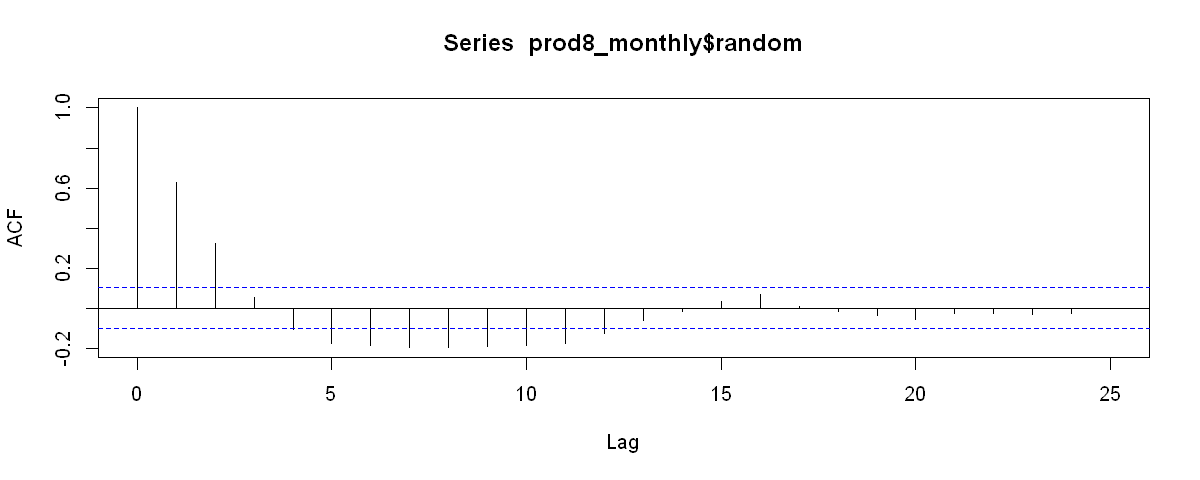

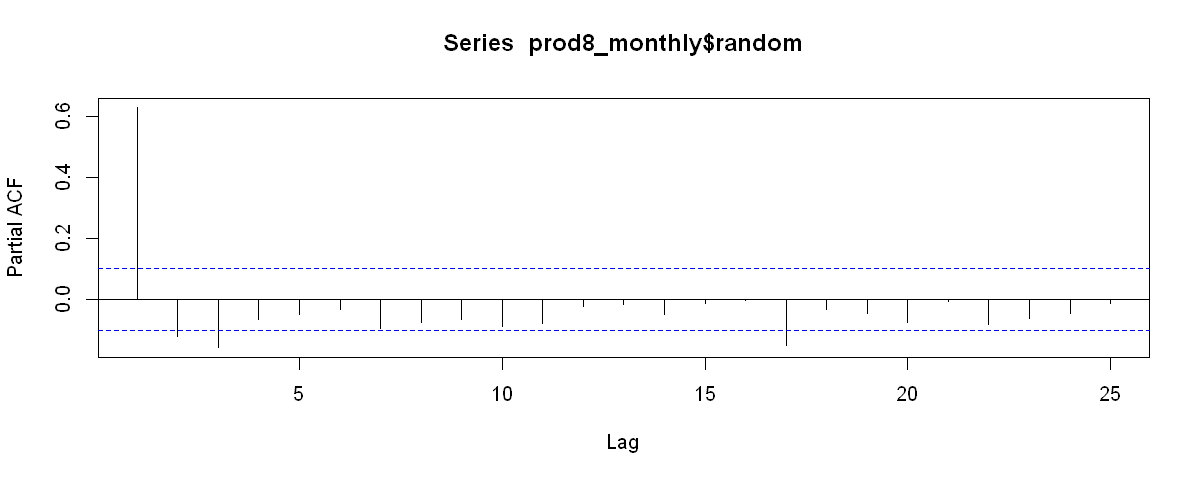

In [81]:
acf(prod8_monthly$random, na.action=na.pass)
pacf(prod8_monthly$random, na.action=na.pass)

There is a high correlation with lag 1. 

### Building an ARIMA Model

In [82]:
mendil <- data[product_content_id=="4066298",][order(event_date)]
mendil_train <- mendil[event_date<test_start,]
mendil_ts <- ts(mendil_train$sold_count)

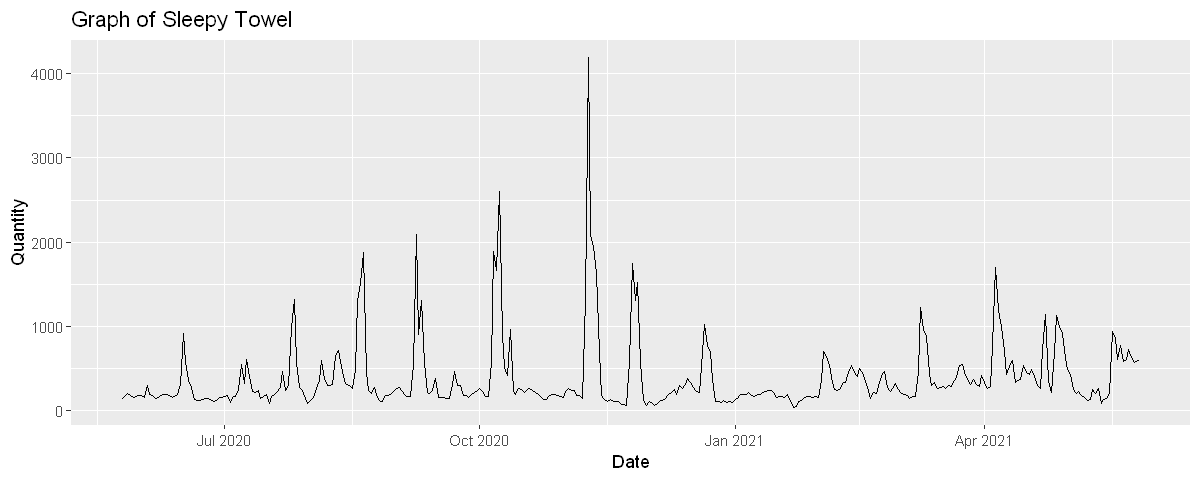

In [83]:
ggplot(mendil_train,aes(x=event_date,y=sold_count)) + geom_line() +
labs(title= "Graph of Sleepy Towel", x= "Date", y="Quantity")

There are a lot of outliers in the data, mean isn't constant and also variance varies through time. Differencing should be applied to the series.

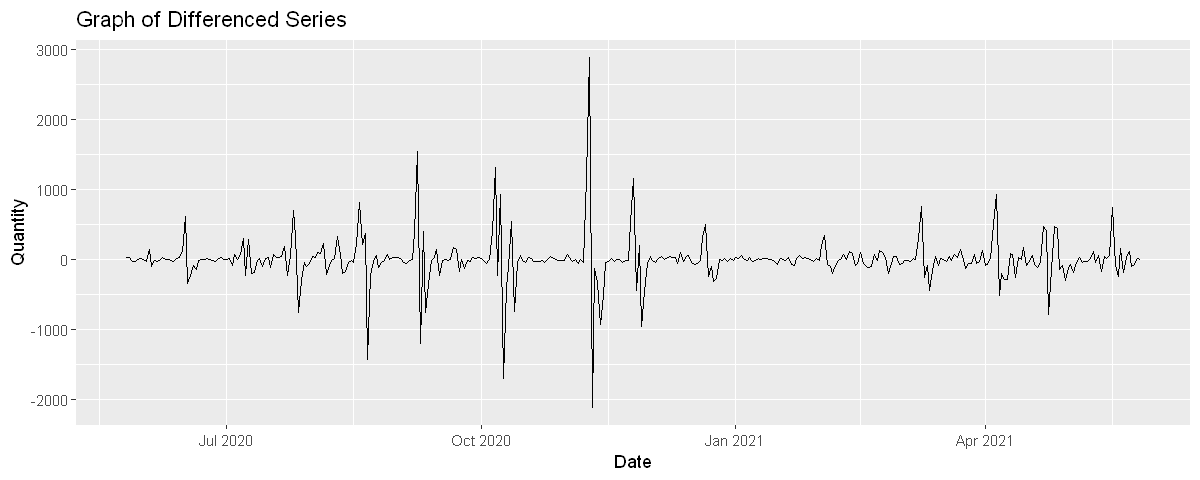

In [84]:
ggplot(mendil_train[2:.N,],aes(x=event_date)) + geom_line(aes(y=diff(mendil_train$sold_count,1))) + 
labs(title= "Graph of Differenced Series", x= "Date", y="Quantity")

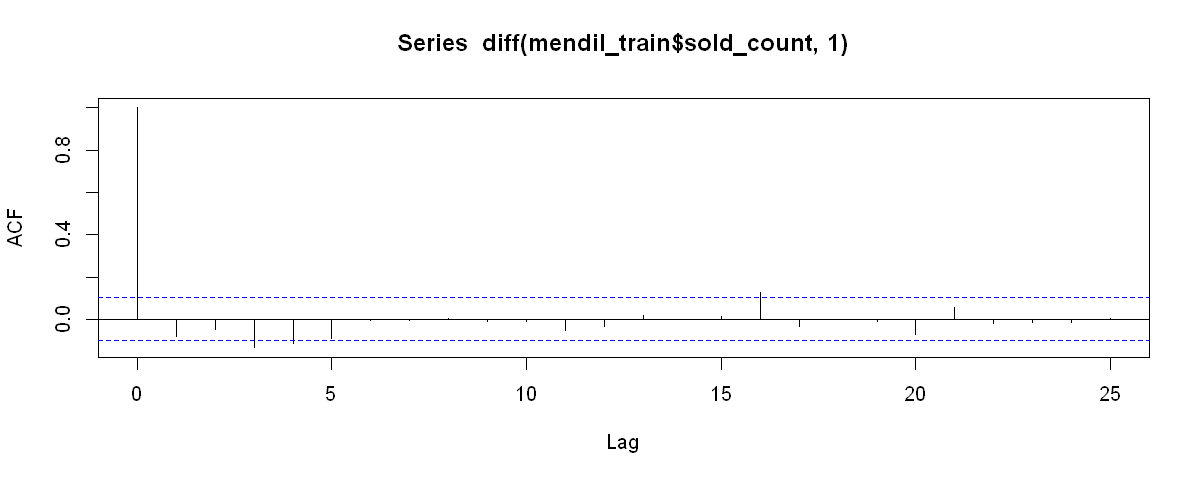

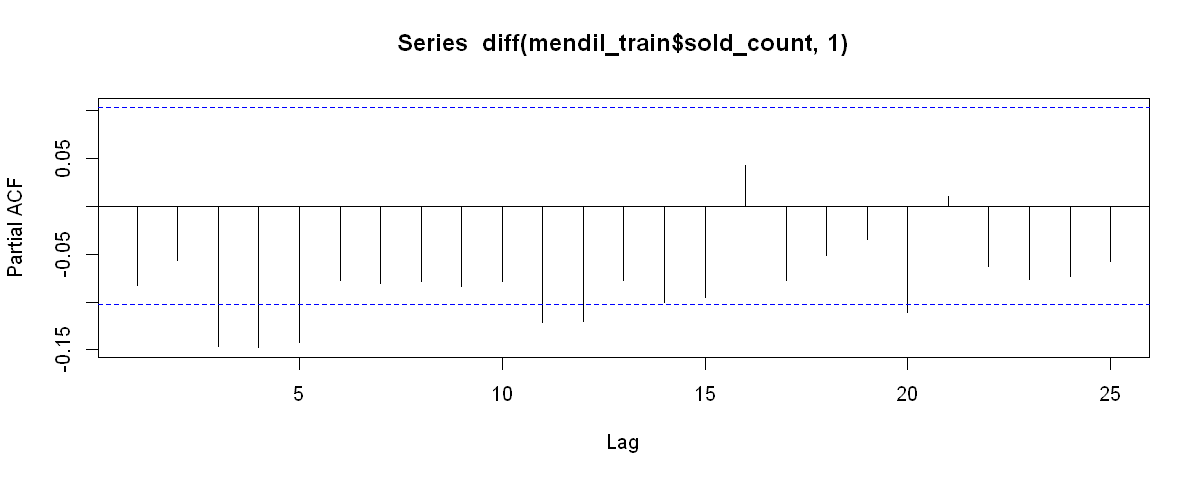

In [85]:
acf(diff(mendil_train$sold_count,1))
pacf(diff(mendil_train$sold_count,1))

At the ACF graph, there is a spike at lags 3 and 4 which could be MA(3) or MA(4) model. Also, there is spikes at PACF graph at lags 3 and 4 which indicates AR(3) OR AR(4) models. Seasonality is not occured in the decomposition steps so, ARIMA model could be consturcted.

In [86]:
arima(mendil_ts,order=c(3,1,3))

Warning message in sqrt(diag(x$var.coef)):
"NaNs produced"


Call:
arima(x = mendil_ts, order = c(3, 1, 3))

Coefficients:
         ar1     ar2    ar3      ma1      ma2     ma3
      0.7707  0.6181  -0.55  -1.0559  -0.6087  0.6751
s.e.     NaN     NaN    NaN      NaN      NaN     NaN

sigma^2 estimated as 93717:  log likelihood = -2622.65,  aic = 5259.29

In [87]:
arima(mendil_ts,order=c(3,1,4))


Call:
arima(x = mendil_ts, order = c(3, 1, 4))

Coefficients:
         ar1     ar2      ar3      ma1      ma2     ma3      ma4
      0.1889  0.7175  -0.4350  -0.4573  -0.8720  0.4191  -0.0897
s.e.  0.5148  0.2188   0.2896   0.5153   0.1393  0.4993   0.1485

sigma^2 estimated as 92894:  log likelihood = -2622.29,  aic = 5260.57

In [88]:
arima(mendil_ts,order=c(4,1,3))

Warning message in sqrt(diag(x$var.coef)):
"NaNs produced"


Call:
arima(x = mendil_ts, order = c(4, 1, 3))

Coefficients:
         ar1    ar2      ar3     ar4      ma1      ma2    ma3
      0.7162  0.806  -0.6826  0.0393  -0.9811  -0.8535  0.845
s.e.     NaN    NaN      NaN  0.0560      NaN      NaN    NaN

sigma^2 estimated as 93470:  log likelihood = -2622.17,  aic = 5260.34

In [89]:
arima(mendil_ts,order=c(4,1,4))


Call:
arima(x = mendil_ts, order = c(4, 1, 4))

Coefficients:
         ar1      ar2     ar3      ar4      ma1     ma2      ma3     ma4
      1.6669  -0.9737  0.3334  -0.1017  -1.9397  1.2318  -0.5152  0.2292
s.e.  1.1285   2.9159  2.5896   0.7923   1.1270  3.2275   3.1429  1.0390

sigma^2 estimated as 93355:  log likelihood = -2621.91,  aic = 5261.83

In [90]:
auto.arima(mendil_ts)

Series: mendil_ts 
ARIMA(2,0,1) with non-zero mean 

Coefficients:
         ar1      ar2      ma1      mean
      1.4711  -0.5954  -0.7410  380.7045
s.e.  0.1339   0.0841   0.1475   33.2133

sigma^2 estimated as 94207:  log likelihood=-2627.9
AIC=5265.8   AICc=5265.97   BIC=5285.34

The best ARIMA model is (3,1,3) with the lowest AIC value of 5259.29.


	Ljung-Box test

data:  Residuals from ARIMA(3,1,3)
Q* = 2.4773, df = 4, p-value = 0.6487

Model df: 6.   Total lags used: 10



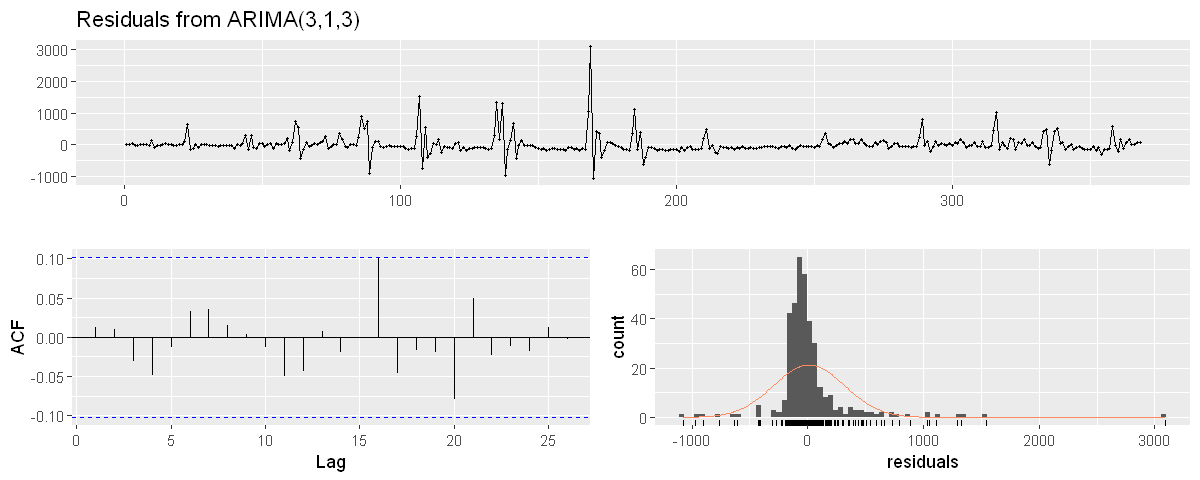

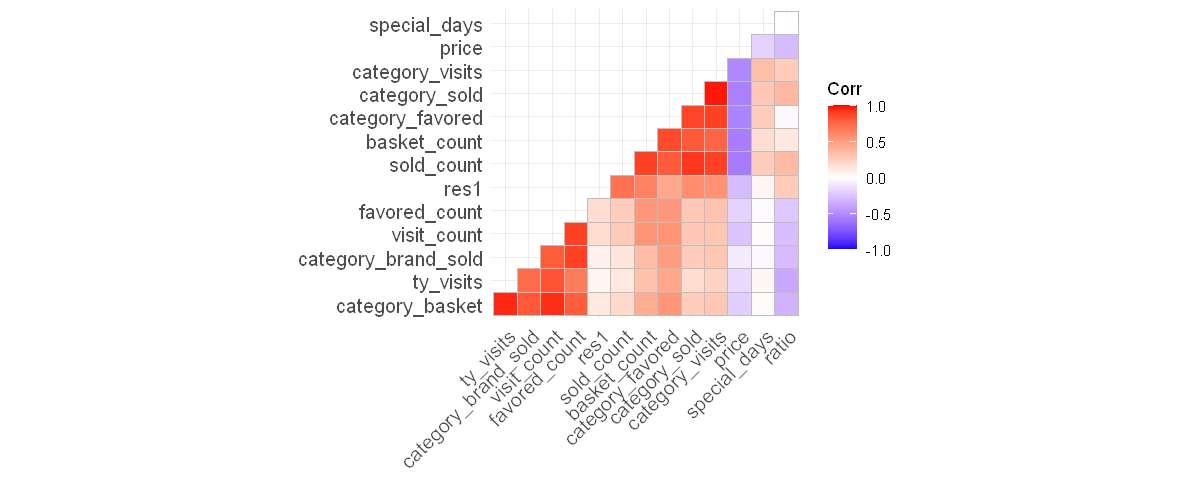

In [91]:
model_mendil_arima <- arima(mendil_ts,order=c(3,1,3))
checkresiduals(model_mendil_arima)
mendil_train$res1 <- model_mendil_arima$residuals
corr <- cor(mendil_train[!is.na(mendil_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Redisuals of the first model isn't autocorrelated and mean is constant at 0. Variance is mostly constant through time. Distribution looks normal but slightly right skewed. Residuals still correlated with sold_count which is output variable and also with basket_count.

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


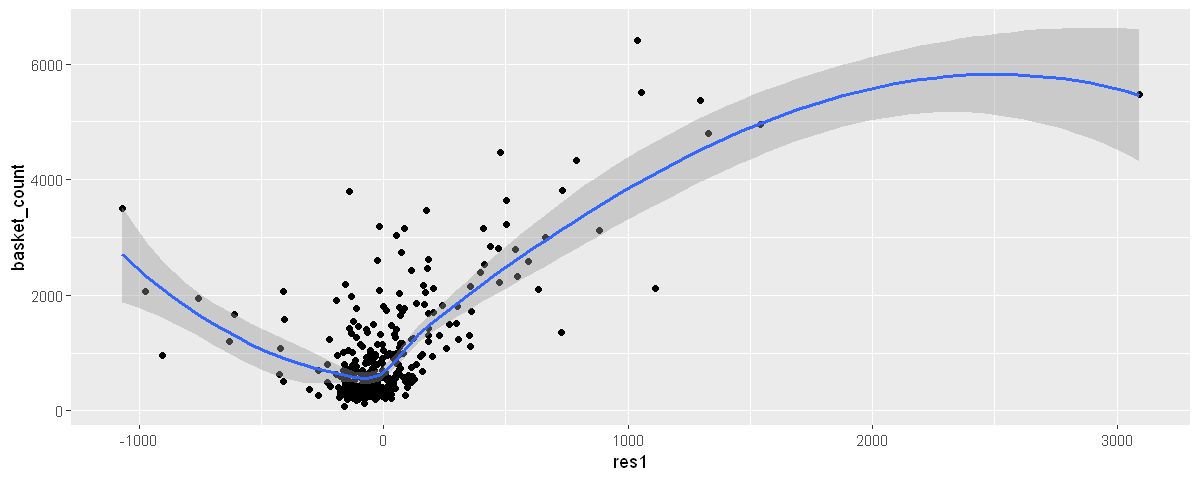

In [92]:
ggplot(mendil_train,aes(x=res1,y=basket_count)) +  geom_point() + geom_smooth()

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


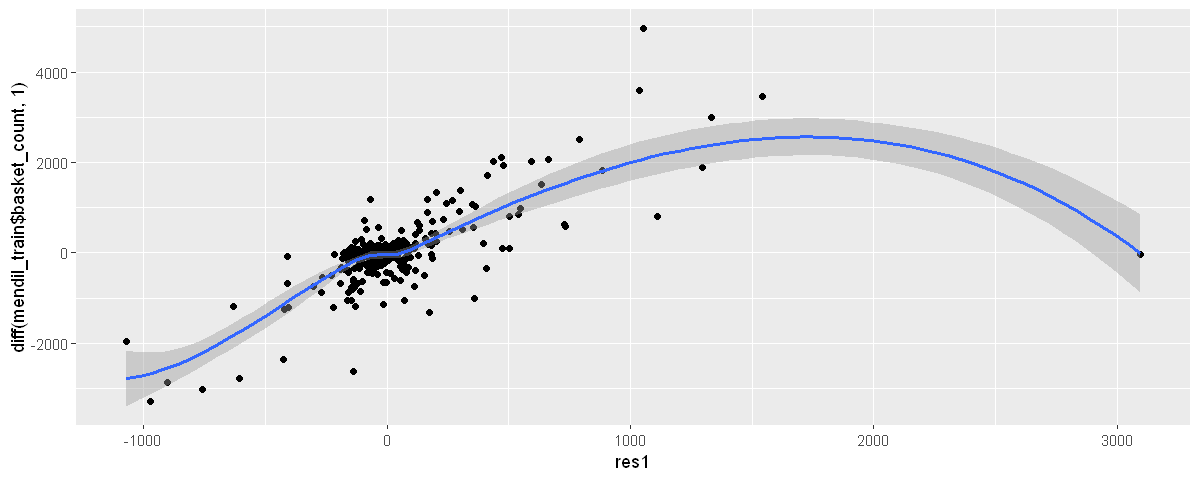

In [93]:
ggplot(mendil_train[2:.N],aes(x=res1)) +  geom_point(aes(y=diff(mendil_train$basket_count,1))) +
geom_smooth(aes(y=diff(mendil_train$basket_count,1)))

In [94]:
cor(mendil_train[2:.N]$res1,diff(mendil_train$basket_count,1))
mendil_train$diff_basket <- c(NA,diff(mendil_train$basket_count,1))
mendil$diff_basket <- c(0,diff(mendil$basket_count,1))

[1] 0.6754501

The correlation between residuals and basket_count is non-linear but differencing the basket_count make this relation linear and with a correlation 0.675. We could add differenced basket_count as a regressor.

In [95]:
arima(mendil_ts,order=c(3,1,3),xreg=mendil_train$diff_basket)


Call:
arima(x = mendil_ts, order = c(3, 1, 3), xreg = mendil_train$diff_basket)

Coefficients:
         ar1     ar2      ar3      ma1      ma2     ma3
      0.6481  0.4425  -0.3994  -0.8053  -0.6060  0.4141
s.e.  0.4583  0.4959   0.2100   0.4639   0.5492  0.2354
      mendil_train$diff_basket
                        0.1360
s.e.                    0.0143

sigma^2 estimated as 76265:  log likelihood = -2578.55,  aic = 5173.11

After the addition of regressor, AIC value is reduced slightly. 


	Ljung-Box test

data:  Residuals from ARIMA(3,1,3)
Q* = 3.3769, df = 3, p-value = 0.3371

Model df: 7.   Total lags used: 10



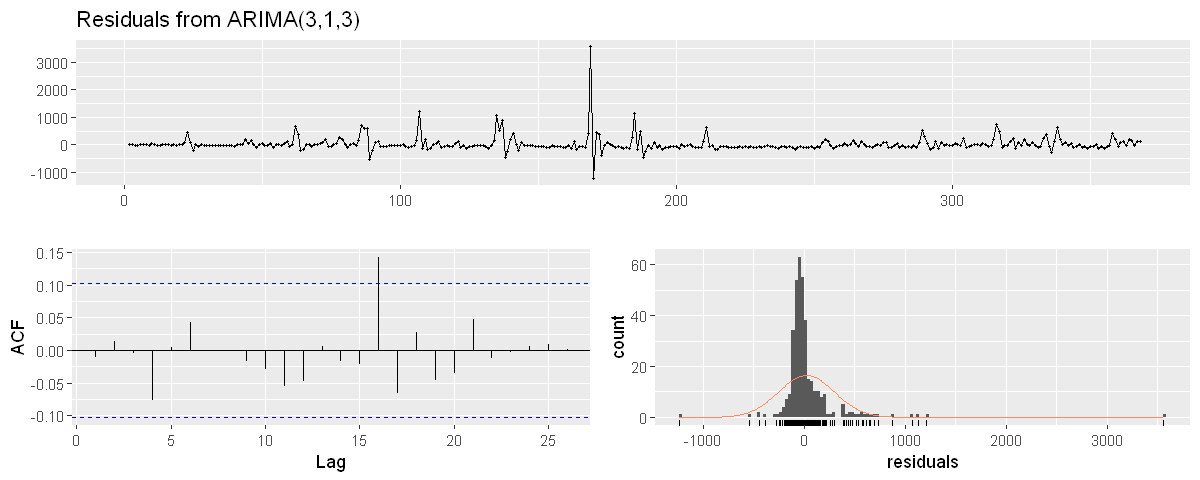

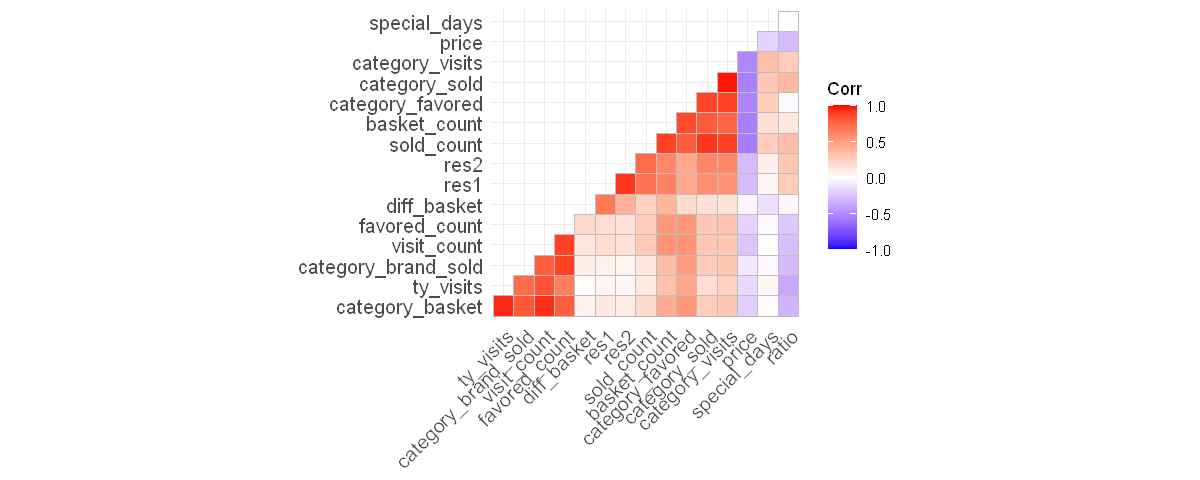

In [96]:
model_mendil_arimax <- arima(mendil_ts,order=c(3,1,3),xreg=mendil_train$diff_basket)
checkresiduals(model_mendil_arimax)
mendil_train$res2 <- model_mendil_arimax$residuals
corr <- cor(mendil_train[!is.na(mendil_train$price)& !is.na(mendil_train$res2),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals are more stationary than the previous model. Variance looks more constant and the distribution have mean near to the zero.

### Linear Models

Firstly, the days of week and trend columns will be added to the data. Next, the first model will be built with trend and weekly seasonality. Then, we'll look for possible regressors and add them to the model. Finally, we will find the best model among them. 

In [97]:
prod8[, `:=`(trend=1:.N, 
            days=wday(event_date, label=T))]

model8_1 <- lm(sold_count~trend+days, data=prod8)
summary(model8_1)


Call:
lm(formula = sold_count ~ trend + days, data = prod8)

Residuals:
   Min     1Q Median     3Q    Max 
-423.4 -213.5 -102.4   40.2 3767.2 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  306.9811    43.1464   7.115 6.09e-12 ***
trend          0.3968     0.2027   1.958  0.05101 .  
days.L       -79.7345    57.1547  -1.395  0.16386    
days.Q      -215.1357    57.0515  -3.771  0.00019 ***
days.C        52.2256    57.0005   0.916  0.36016    
days^4        11.4518    56.9659   0.201  0.84079    
days^5        24.9918    56.8447   0.440  0.66045    
days^6        31.2106    56.7503   0.550  0.58269    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 413 on 360 degrees of freedom
Multiple R-squared:  0.05607,	Adjusted R-squared:  0.03771 
F-statistic: 3.055 on 7 and 360 DF,  p-value: 0.003897



	Breusch-Godfrey test for serial correlation of order up to 11

data:  Residuals
LM test = 176.14, df = 11, p-value < 2.2e-16


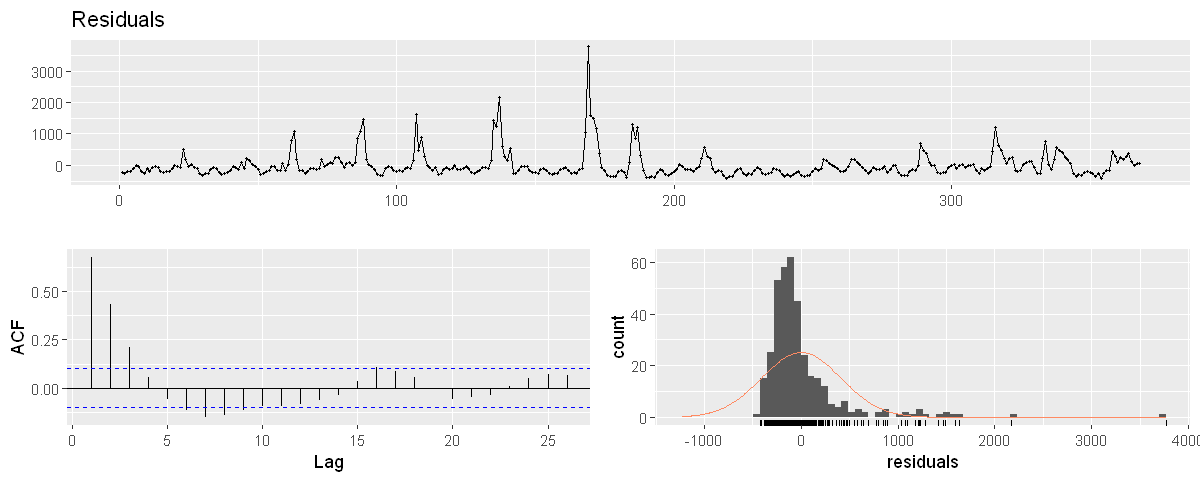

In [98]:
checkresiduals(model8_1)

* The first adjusted Rsqr value is 0.03771, which is very low. 
* The model's p value is small, which means that the model is meaningful. 
* The mean is not zero. 
* The variance is not constant. 
* Residuals are not exactly normally distributed. 
* There are autocorrelations between the residuals. 

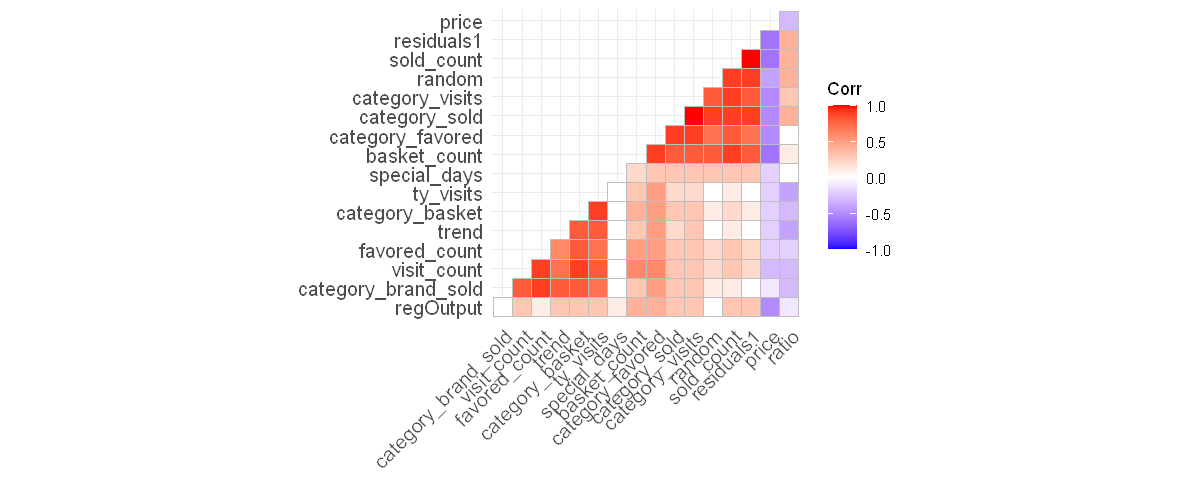

In [100]:
prod8[, residuals1:=model8_1$residuals]
corr <- round(cor(Filter(is.numeric, prod8[!is.na(prod8$price)])), 1)
ggcorrplot(corr, hc.order = TRUE,type = "lower")

Again, the maximum correlation with residuals1 is obtained by basket_count. Therefore, its lagged version will be added to the model. To find the lag value, we'll check the CCF function. 

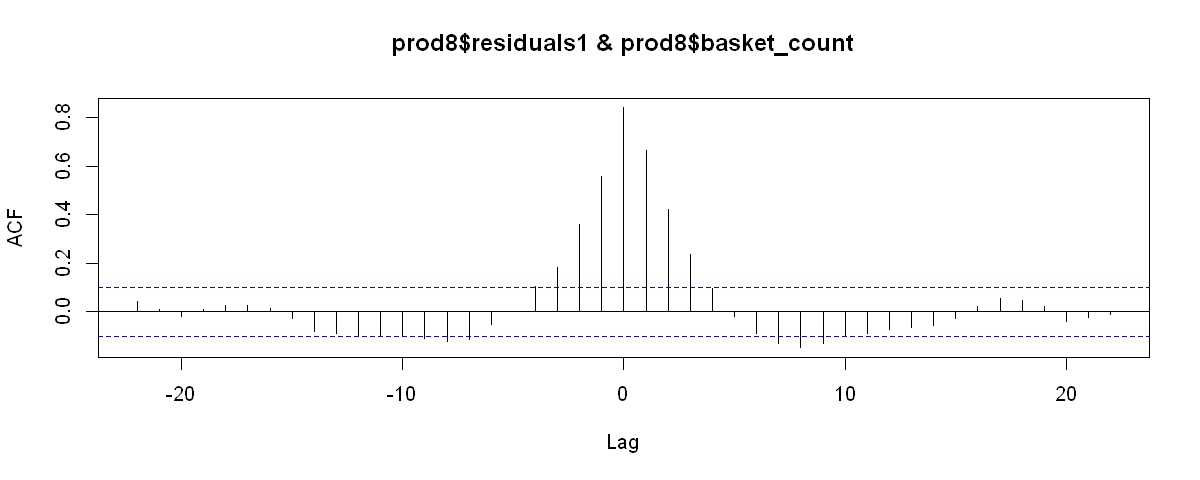

In [101]:
ccf(prod8$residuals1, prod8$basket_count)

In [102]:
model8_2 <- lm(sold_count~trend+days+shift(basket_count, 1), data=prod8)
summary(model8_2)


Call:
lm(formula = sold_count ~ trend + days + shift(basket_count, 
    1), data = prod8)

Residuals:
    Min      1Q  Median      3Q     Max 
-996.74 -109.80  -31.87   53.41 2246.28 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             153.5586    31.6142   4.857 1.78e-06 ***
trend                    -0.4226     0.1494  -2.828 0.004941 ** 
days.L                 -139.8203    40.4207  -3.459 0.000607 ***
days.Q                  -68.3453    40.9012  -1.671 0.095599 .  
days.C                   74.2299    40.2190   1.846 0.065770 .  
days^4                  -20.9278    40.2686  -0.520 0.603590    
days^5                   55.9545    40.1351   1.394 0.164135    
days^6                   50.4709    39.9942   1.262 0.207786    
shift(basket_count, 1)    0.3182     0.0166  19.166  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 290.8 on 358 degrees of freedom
  (1 observation deleted 


	Breusch-Godfrey test for serial correlation of order up to 12

data:  Residuals
LM test = 24.397, df = 12, p-value = 0.01795


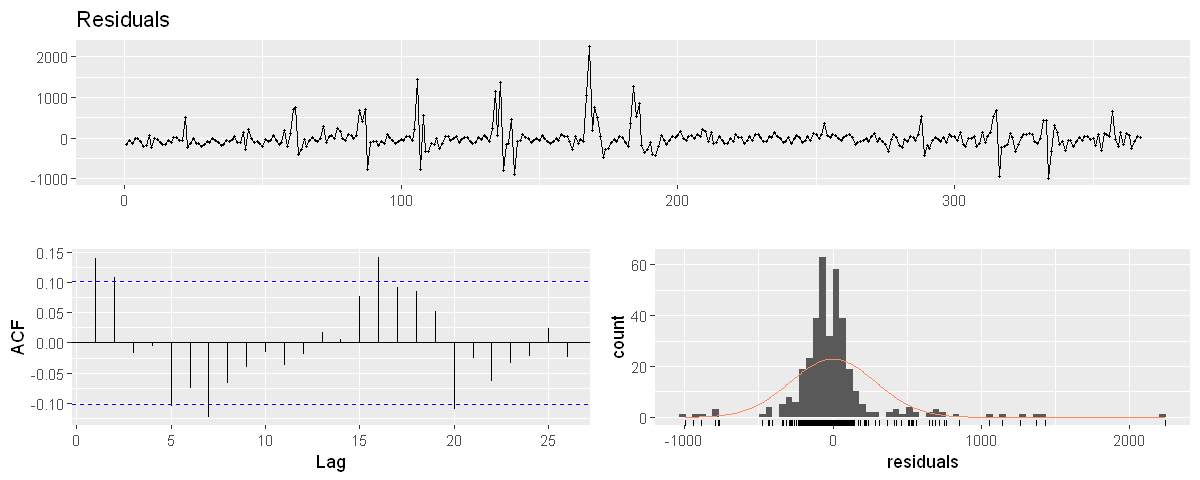

In [103]:
checkresiduals(model8_2)

* The adjusted Rsqr value is increased to 0.5236. 
* The model's p value is small, which means that the model is meaningful. 
* The mean seems to be zero. 
* The variance is still not constant. 
* Residuals are not exactly normally distributed. 
* There are high autocorrelations at lag 1 and lag 16. 

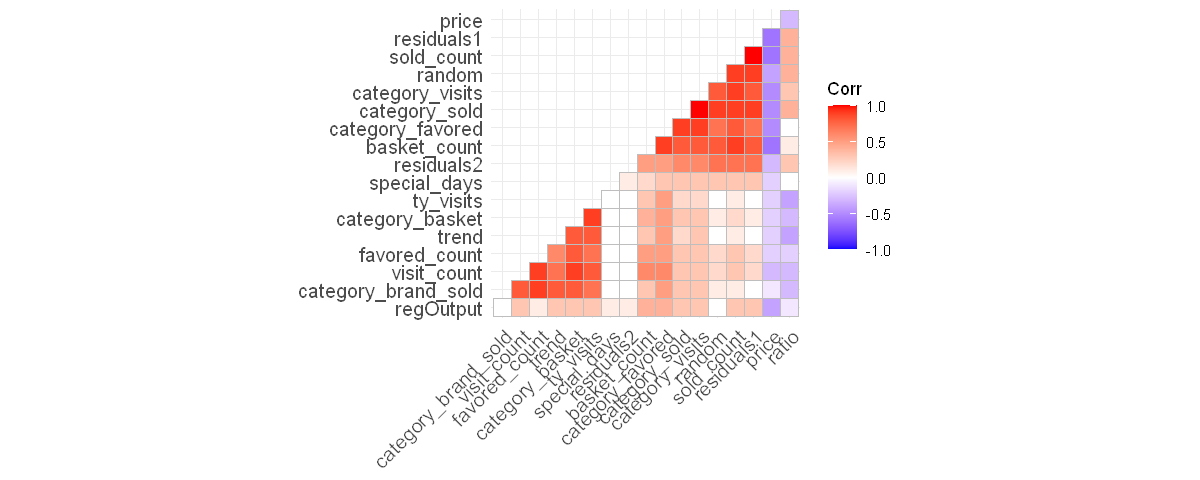

In [104]:
prod8[, residuals2:=c(NA, model8_2$residuals)]
corr <- round(cor(Filter(is.numeric, prod8[!is.na(prod8$price) & !is.na(prod8$residuals2)])), 1)
ggcorrplot(corr, hc.order = TRUE,type = "lower")

The maximum correlation with residuals2 is obtained by price. Therefore, its lagged version will be added to the model. To find the lag value, we'll check the CCF function. 

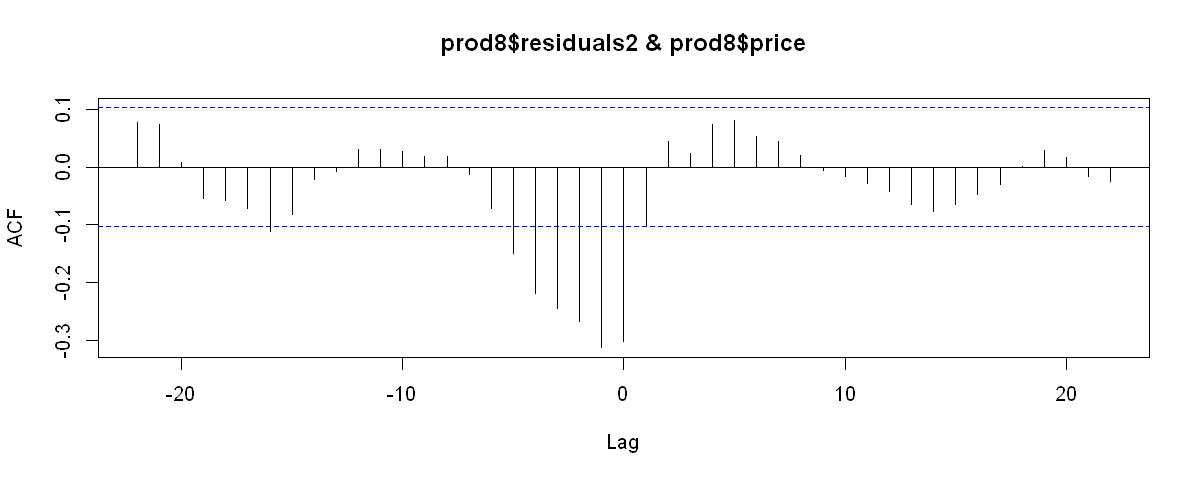

In [105]:
ccf(prod8$residuals2, prod8$price, na.action=na.pass)

In [106]:
model8_3 <- lm(sold_count~trend+days+shift(basket_count, 1)+shift(price, 1), data=prod8)
summary(model8_3)


Call:
lm(formula = sold_count ~ trend + days + shift(basket_count, 
    1) + shift(price, 1), data = prod8)

Residuals:
    Min      1Q  Median      3Q     Max 
-964.16 -109.00  -23.47   60.79 2308.12 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             933.10946  322.80221   2.891 0.004080 ** 
trend                    -0.41970    0.14840  -2.828 0.004945 ** 
days.L                 -137.73128   40.15684  -3.430 0.000675 ***
days.Q                  -84.58368   41.17239  -2.054 0.040667 *  
days.C                   74.47396   39.94734   1.864 0.063100 .  
days^4                  -16.78058   40.03297  -0.419 0.675345    
days^5                   51.08520   39.91434   1.280 0.201422    
days^6                   48.78471   39.73004   1.228 0.220292    
shift(basket_count, 1)    0.29074    0.02001  14.529  < 2e-16 ***
shift(price, 1)         -10.66572    4.39560  -2.426 0.015742 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.'


	Breusch-Godfrey test for serial correlation of order up to 13

data:  Residuals
LM test = 30.421, df = 13, p-value = 0.004094


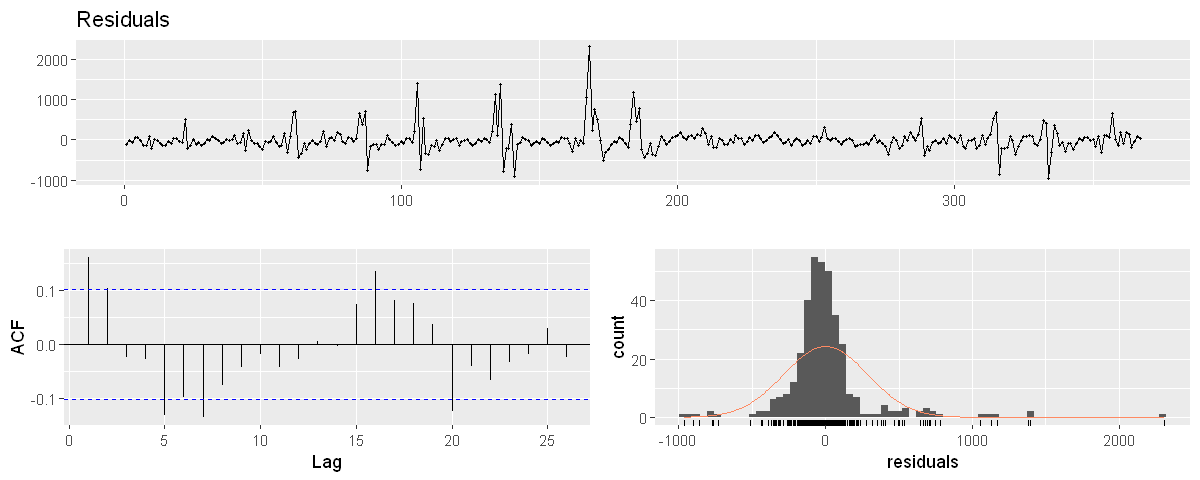

In [107]:
checkresiduals(model8_3)

* The adjusted Rsqr value is increased to 0.5301 . 
* The model's p value is small, which means that the model is meaningful. 
* The mean seems to be zero. 
* The variance is still non-constant. 
* Residuals are not exactly normally distributed. 
* There are high autocorrelations at lag 1 and lag 16. 
 
Now, let's check if the residuals3 is related with the lagged version of the input variable. 

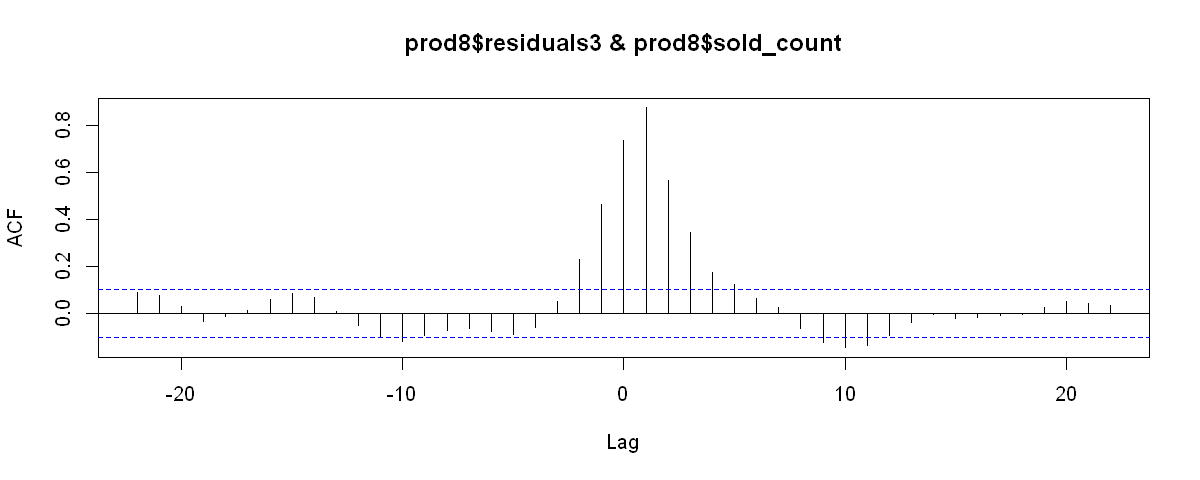

In [108]:
prod8[, residuals3:=c(NA, model8_3$fitted.values)]
ccf(prod8$residuals3, prod8$sold_count, na.action=na.pass)

In [109]:
model8_4 <- lm(sold_count~trend+days+shift(basket_count, 1)+shift(price, 1)+shift(sold_count, 1), data=prod8)
summary(model8_4)


Call:
lm(formula = sold_count ~ trend + days + shift(basket_count, 
    1) + shift(price, 1) + shift(sold_count, 1), data = prod8)

Residuals:
    Min      1Q  Median      3Q     Max 
-872.43 -110.85  -26.94   52.75 2455.57 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             762.54803  330.86312   2.305 0.021757 *  
trend                    -0.30664    0.15677  -1.956 0.051244 .  
days.L                 -142.54237   40.01819  -3.562 0.000418 ***
days.Q                  -77.92131   41.08322  -1.897 0.058681 .  
days.C                   79.00352   39.80290   1.985 0.047926 *  
days^4                  -16.05225   39.83359  -0.403 0.687203    
days^5                   53.57546   39.73104   1.348 0.178370    
days^6                   46.26115   39.54820   1.170 0.242888    
shift(basket_count, 1)    0.22331    0.03719   6.005 4.71e-09 ***
shift(price, 1)          -8.60714    4.47743  -1.922 0.055361 .  
shift(sold_count, 1)      0.18147


	Breusch-Godfrey test for serial correlation of order up to 14

data:  Residuals
LM test = 28.99, df = 14, p-value = 0.01048


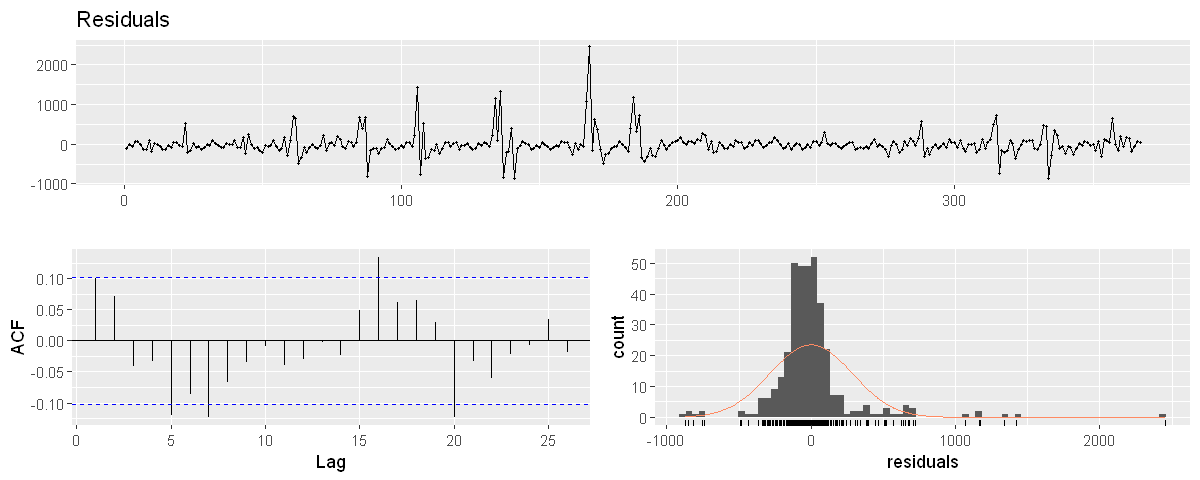

In [110]:
checkresiduals(model8_4)

* The adjusted Rsqr value is a little improved to 0.5348. 
* The model's p value is small, which means that the model is meaningful. 
* The mean seems to be zero. 
* The variance is like constant. 
* Residuals are more likely to be normally distributed. 
* There is not a very significant autocorrelation. 
 
So, the final model is model8_4.

Warning message:
"Removed 1 rows containing missing values (geom_point)."

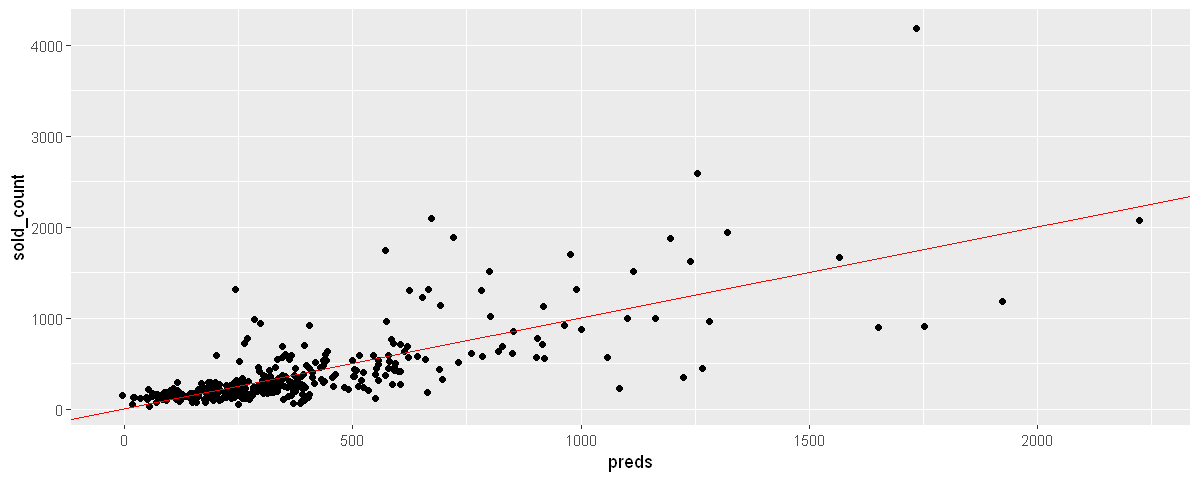

In [111]:
prod8[, preds:=c(NA,model8_4$fitted.values)]
ggplot(prod8, aes(x=preds, y=sold_count)) + geom_point() + geom_abline(intercept=0, slope=1, color="red") 

### Forecasting

In [444]:
forecast_data_mendil <- data.table(event_date=mendil[event_date>=test_start&event_date<=test_end,]$event_date,
                            sold_count=mendil[event_date>=test_start&event_date<=test_end,]$sold_count)
mendil[,`:=`(trend=1:.N,
           days=wday(event_date, label=T))]
arima_fc <- numeric(0)
arimax_fc <- numeric(0)
reg_fc <- numeric(0)
for(i in 1:length(test_dates)){
  
  train_dt <- mendil[event_date<test_dates[i],]
  model_arima <- Arima(train_dt$sold_count,order=c(3,1,3))
  model_arimax <- Arima(train_dt$sold_count,order=c(3,1,3),xreg=train_dt$diff_basket)
  model_reg <- lm(sold_count~trend+days+shift(basket_count, 1)+shift(price, 1)+shift(sold_count, 1), data=train_dt)
  newreg <- forecast(auto.arima(train_dt$diff_basket),h=1)$mean[1]
  arima_temp <- forecast(model_arima)
  arimax_temp <- forecast(model_arimax,xreg=newreg)
  reg_temp <- predict(model_reg,newdata=mendil[event_date %in% c(test_dates[i],test_dates[i+1])])
  arima_fc <- c(arima_fc,arima_temp$mean[1])
  arimax_fc <- c(arimax_fc,arimax_temp$mean[1])
  reg_fc <- c(reg_fc,reg_temp)
  
}
reg_fc[is.na(reg_fc)] <- mean(reg_fc[!is.na(reg_fc)])
forecast_data_mendil <- forecast_data_mendil[,`:=`(arima_p=arima_fc,
                                               arimax_p=arimax_fc,
                                               reg_p=reg_fc[c(1,seq(2,28,2))])]
accu(forecast_data_mendil$sold_count,forecast_data_mendil$arima_p)
accu(forecast_data_mendil$sold_count,forecast_data_mendil$arimax_p)
accu(forecast_data_mendil[1:(.N-1)]$sold_count,forecast_data_mendil[2:.N]$reg_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
15,542.1333,323.7585,0.5971935,0.07277015,0.2194611,237.5628,128.2689,0.2366004,0.2366004


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
15,542.1333,323.7585,0.5971935,0.07918613,0.2462374,240.2728,139.0699,0.2565234,0.2565234


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
14,564.4286,323.8099,0.5736952,0.02045764,0.1574298,99.59298,79.30958,0.1405131,0.1405131


In [445]:
result_data_mendil <- data.table(event_date=mendil[event_date>=result_start&event_date<=result_end,]$event_date,
                               sold_count=mendil[event_date>=result_start&event_date<=result_end,]$sold_count)
final_fc <- numeric(0)
for(i in 1:length(result_dates)){
  
  train_dt <- mendil[event_date<result_dates[i],]
  model_final <- lm(sold_count~trend+days+shift(basket_count, 1)+shift(price, 1)+shift(sold_count, 1), data=train_dt)
  final_temp <- predict(model_final,newdata=mendil[event_date %in% c(result_dates[i],result_dates[i+1])])
  final_fc <- c(final_fc,final_temp)
  
}
final_fc[is.na(final_fc)] <- mean(final_fc[!is.na(final_fc)])
result_data_mendil <- result_data_mendil[,`:=`(final_p=final_fc[c(1,seq(2,28,2))])]
accu(result_data_mendil[1:(.N-1)]$sold_count,result_data_mendil[2:.N]$final_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
14,644.5,574.7062,0.8917086,0.09331918,0.1565647,128.914,93.02199,0.144332,0.144332


In [446]:
data.frame(event_date=result_data_mendil[1:(.N-1)]$event_date,
           sold_count=result_data_mendil[1:(.N-1)]$sold_count,
           predictions=result_data_mendil[2:.N]$final_p)

event_date,sold_count,predictions
2021-06-12,236,239.6787
2021-06-13,298,395.1263
2021-06-14,269,325.2178
2021-06-15,381,299.5827
2021-06-16,383,384.2660
2021-06-17,494,347.6472
2021-06-18,2362,1994.6812
2021-06-19,1319,1178.6893
2021-06-20,892,811.0426
2021-06-21,754,733.6070


### La Roche Posay Yüz Temizleyici

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


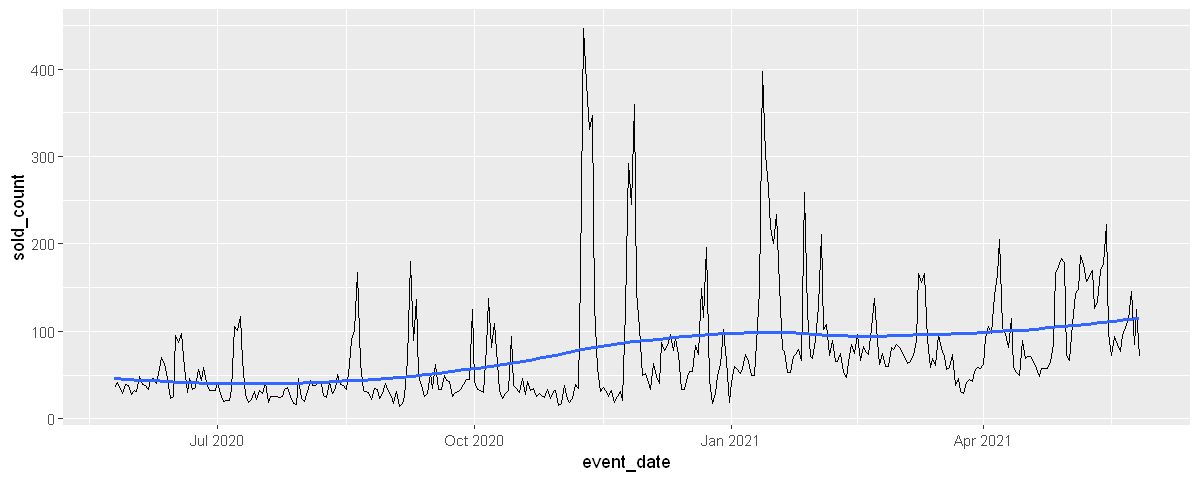

In [115]:
ggplot(prod7, aes(x=event_date, y=sold_count)) + geom_line() + geom_smooth(se=F)

* The variance is not constant over time. 
* By the blue line, it seems that there is a slightly increasing trend. 
* The mean changes over time. The data is not stationary. 
* Between November 2020 and December 2020, there are high number of sales. Also, there is a jumping point in the middle of January 2021. 

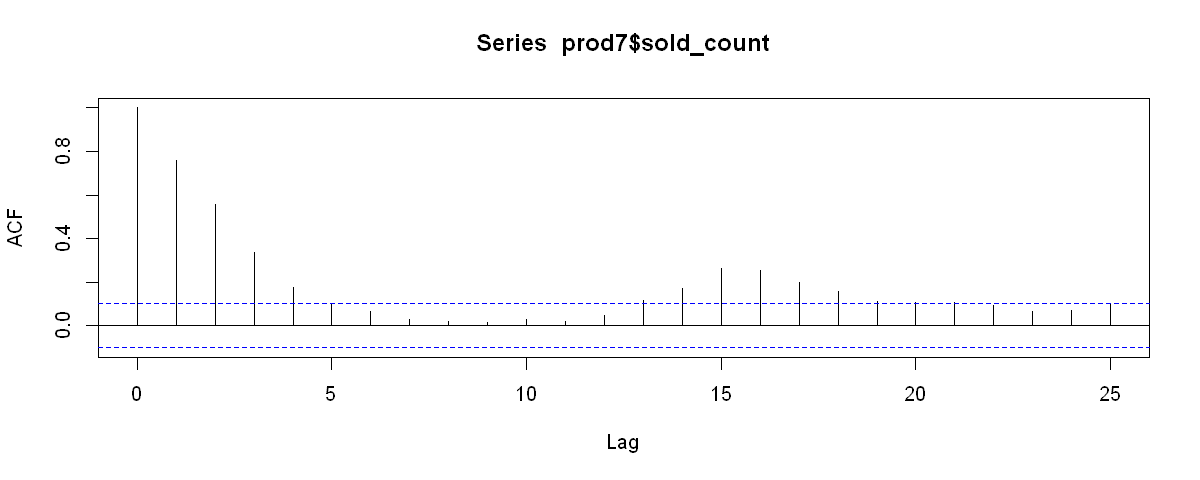

In [116]:
acf(prod7$sold_count)

First three lags and lag 15 have high correlation values. Now let's decompose the data. 

### Weekly Decomposition

Because the variance does not increase over time, additive decomposition will be used. 

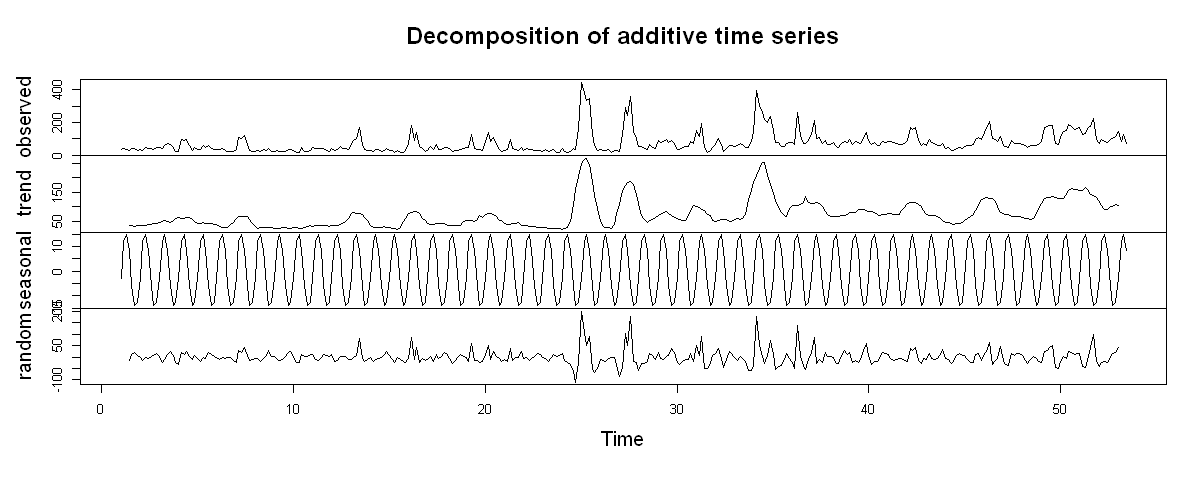

In [117]:
prod7_weekly_dec <- decompose(ts(prod7$sold_count, freq=7), type="additive")
plot(prod7_weekly_dec)

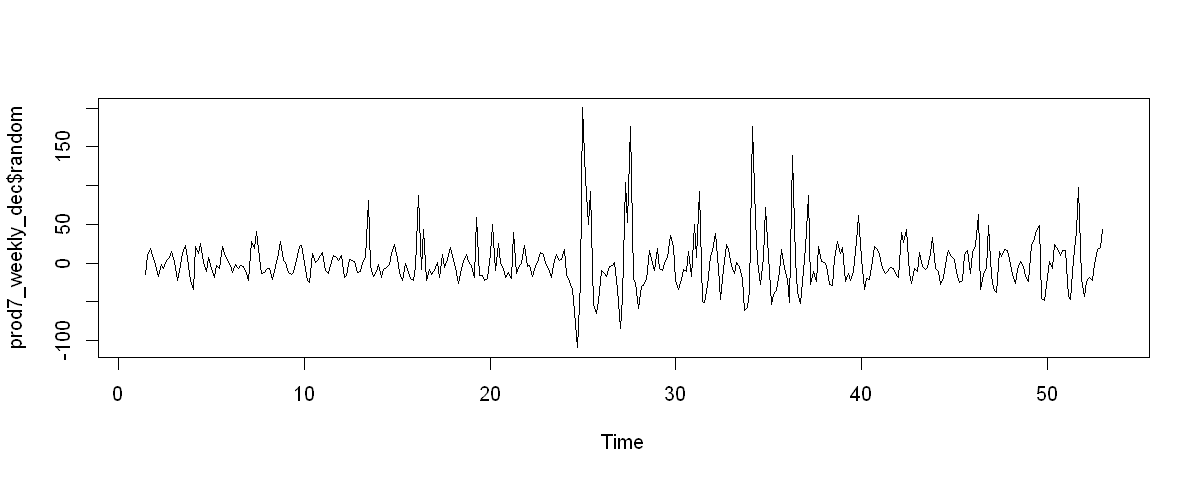

In [118]:
plot(prod7_weekly_dec$random)

* The variance changes over time. 
* The mean seems to be constant. 
* There are jumping points in the middle of the data. 
 
Now, let's check whether the detrended and deseasonalized data is stationary. 

In [119]:
u_test <- ur.kpss(prod7_weekly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0085 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


From the test results, it can be said that the data is stationary. 

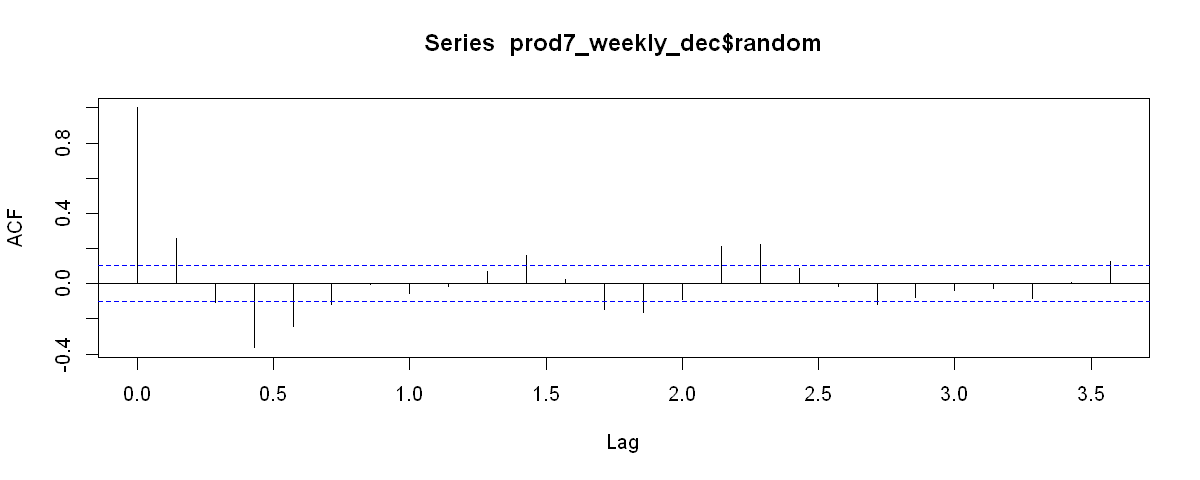

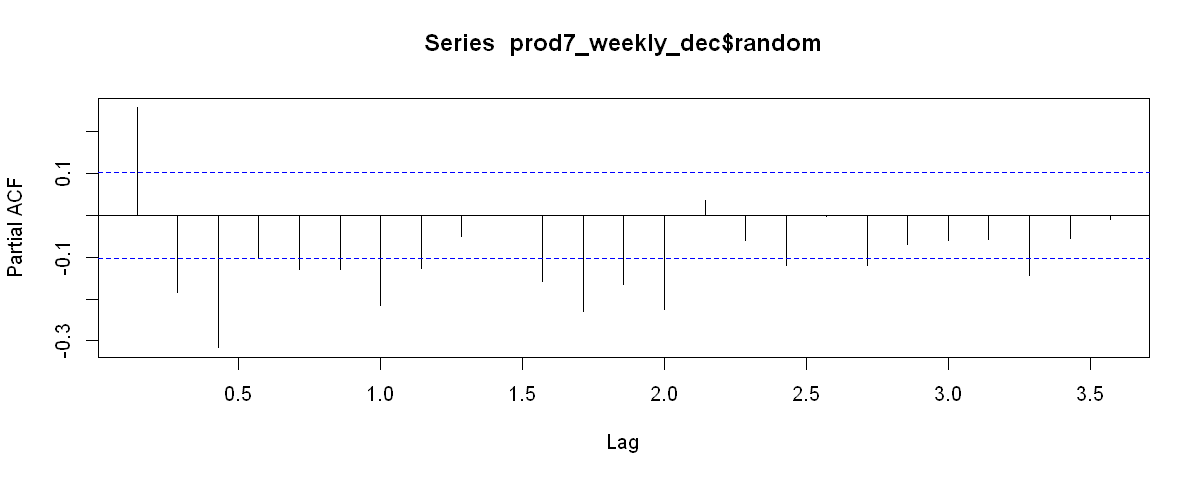

In [120]:
acf(prod7_weekly_dec$random, na.action=na.pass)
pacf(prod7_weekly_dec$random, na.action=na.pass)

The ACF graph is like a sinus wave. There are still correlatinons at different level of lags. 

### Monthly Decomposition

month,sold_count
2020 May,247
2020 Jun,1416
2020 Jul,1125
2020 Aug,1360
2020 Sep,1471
2020 Oct,1349
2020 Nov,3624
2020 Dec,2098
2021 Jan,3671
2021 Feb,2392


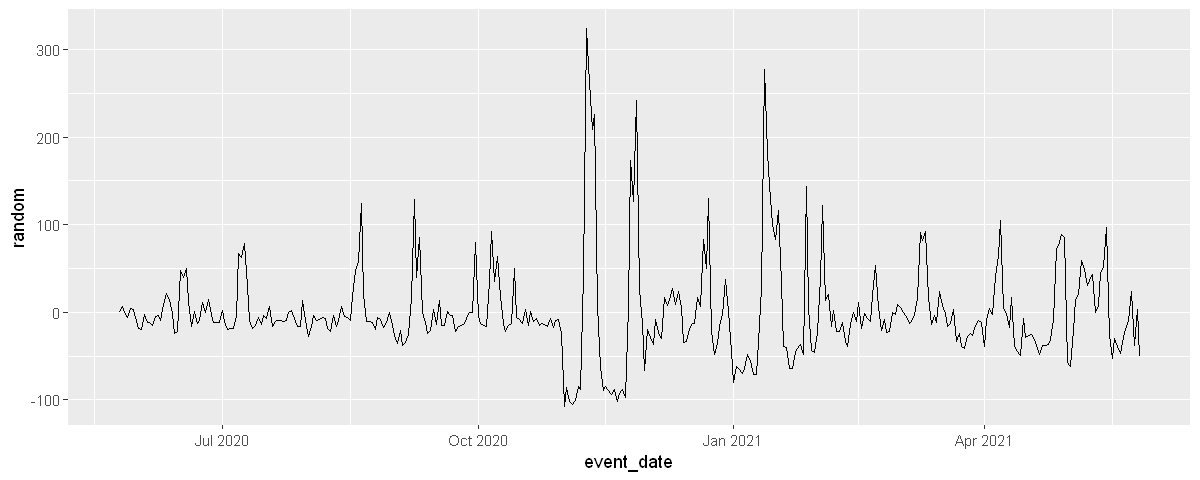

In [121]:
prod7_monthly <- prod7[, month:=yearmonth(event_date)]
prod7_monthly[, .(sold_count=sum(sold_count)), by=month]
prod7_monthly[, trend:=1:.N]

prod7_reg <- lm(sold_count~trend+as.factor(month), data=prod7_monthly)
prod7_monthly[, regOutput:=predict(prod7_reg, prod7_monthly)]

prod7_monthly[, random:=sold_count-regOutput]

ggplot(prod7_monthly, aes(x=event_date, y=random)) + geom_line()

* The mean seems to be constant over time. 
* The variance is not constant. 
 
Let's check the unit test result in order to see whether the data is stationary. 

In [122]:
u_test <- ur.kpss(prod7_monthly$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0094 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


According to the KPSS test result, the data is stationary. 

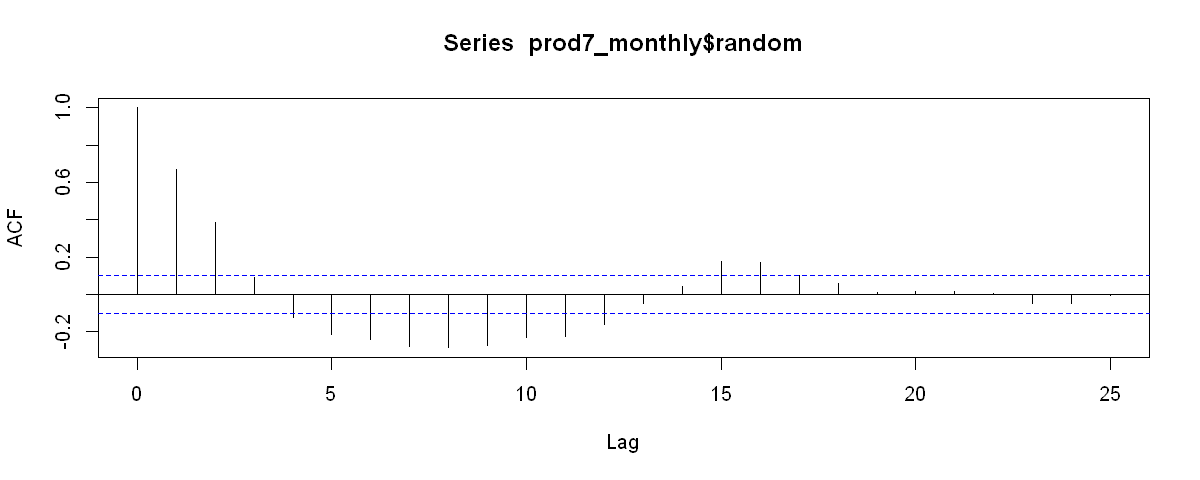

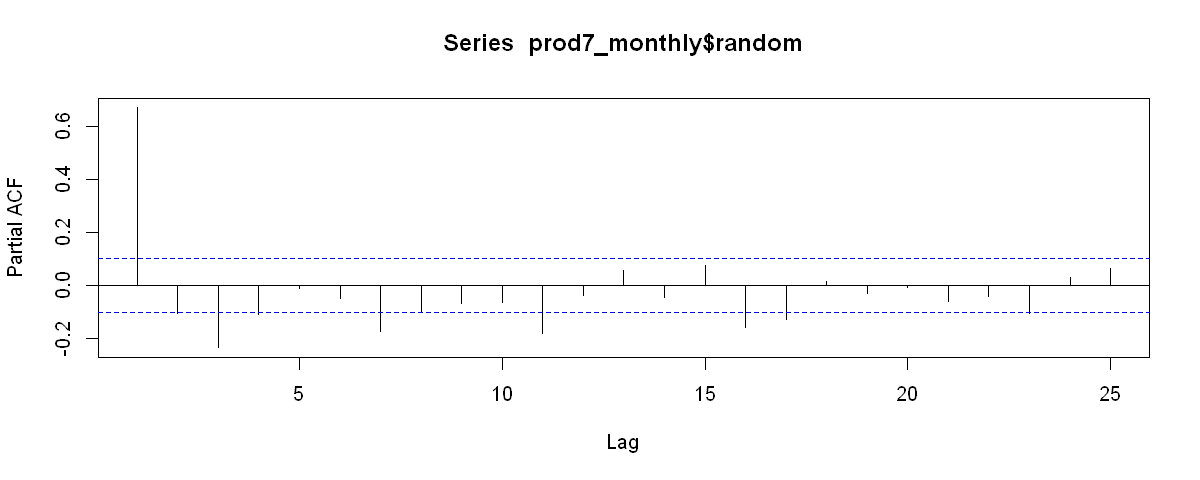

In [123]:
acf(prod7_monthly$random, na.action=na.pass)
pacf(prod7_monthly$random, na.action=na.pass)

It seems that there is a correlation at lag 1. 

### Building an ARIMA Model

In [125]:
jel <- data[product_content_id=="85004",][order(event_date)]
jel_train <- jel[event_date<test_start,]
jel_ts <- ts(jel_train$sold_count)

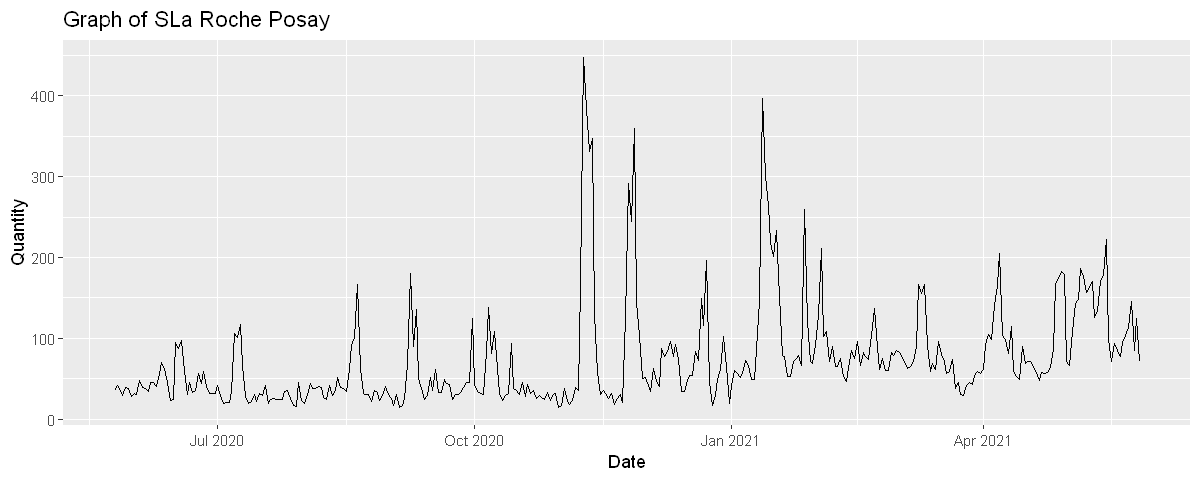

In [126]:
ggplot(jel_train,aes(x=event_date,y=sold_count)) + geom_line() +
labs(title= "Graph of SLa Roche Posay", x= "Date", y="Quantity")

Again, series are not stationariy. Analysis could start with differencing to make it stationary.

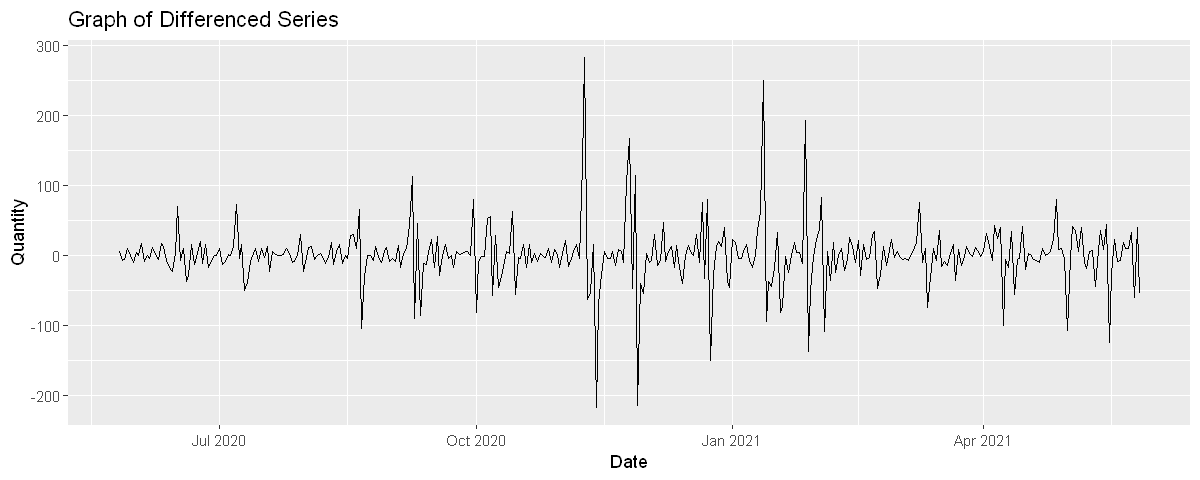

In [127]:
ggplot(jel_train[2:.N,],aes(x=event_date)) + geom_line(aes(y=diff(jel_train$sold_count,1))) + 
labs(title= "Graph of Differenced Series", x= "Date", y="Quantity")

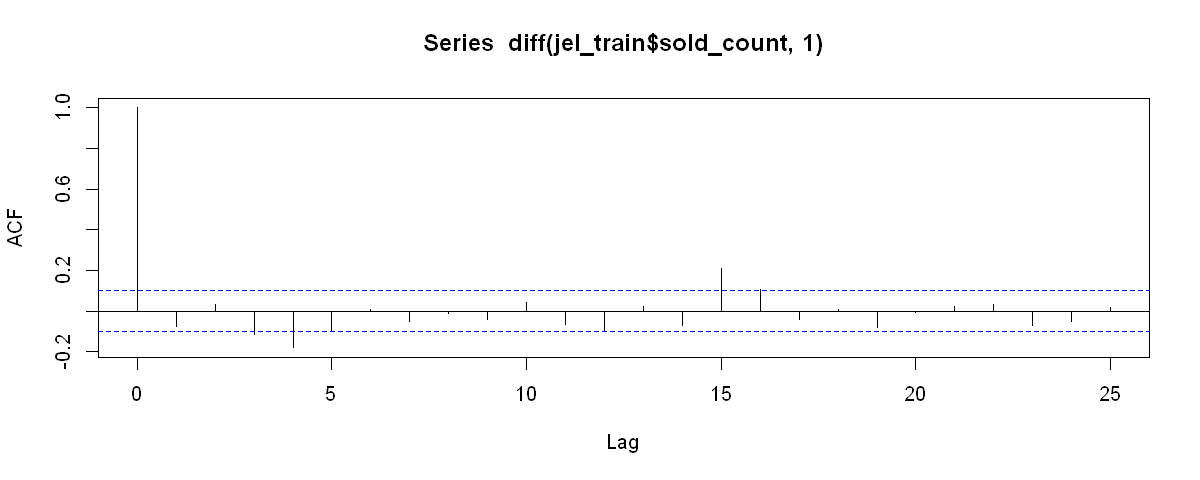

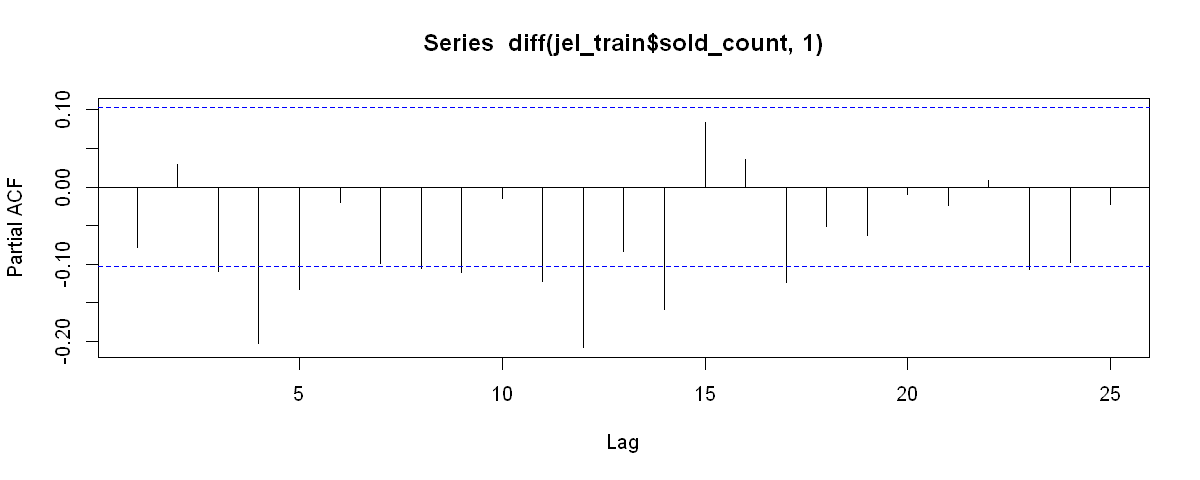

In [128]:
acf(diff(jel_train$sold_count,1))
pacf(diff(jel_train$sold_count,1))

In the ACF graph there is spikes at lag 3 and 4. Pacf graph shows spikes at lag 3 and 4 also. Decomposition tells there is no seasonality, so an ARIMA model could be constructed.

In [129]:
arima(jel_ts,order=c(3,1,3))


Call:
arima(x = jel_ts, order = c(3, 1, 3))

Coefficients:
         ar1      ar2     ar3      ma1     ma2      ma3
      0.9504  -0.7389  0.3324  -1.1857  0.9067  -0.6940
s.e.  0.1449   0.2401  0.1439   0.1258  0.2309   0.1436

sigma^2 estimated as 1606:  log likelihood = -1876.32,  aic = 3766.64

In [130]:
arima(jel_ts,order=c(4,1,3))


Call:
arima(x = jel_ts, order = c(4, 1, 3))

Coefficients:
         ar1      ar2     ar3      ar4      ma1     ma2      ma3
      0.8253  -0.6122  0.3456  -0.0752  -1.0495  0.7263  -0.6456
s.e.  0.2207   0.3148  0.1546   0.0784   0.2135  0.3428   0.1760

sigma^2 estimated as 1602:  log likelihood = -1875.84,  aic = 3767.69

In [131]:
arima(jel_ts,order=c(3,1,4))


Call:
arima(x = jel_ts, order = c(3, 1, 4))

Coefficients:
         ar1      ar2     ar3      ma1     ma2      ma3      ma4
      0.7113  -0.5170  0.2363  -0.9379  0.6095  -0.5293  -0.1082
s.e.  0.3671   0.4088  0.2026   0.3661  0.4841   0.2715   0.1382

sigma^2 estimated as 1604:  log likelihood = -1876,  aic = 3767.99

In [132]:
arima(jel_ts,order=c(4,1,4))

Warning message in arima(jel_ts, order = c(4, 1, 4)):
"possible convergence problem: optim gave code = 1"Warning message in sqrt(diag(x$var.coef)):
"NaNs produced"


Call:
arima(x = jel_ts, order = c(4, 1, 4))

Coefficients:
         ar1      ar2     ar3      ar4      ma1     ma2      ma3     ma4
      1.2843  -1.0413  0.6887  -0.2443  -1.5108  1.2633  -1.0618  0.3289
s.e.     NaN      NaN     NaN      NaN      NaN     NaN      NaN     NaN

sigma^2 estimated as 1596:  log likelihood = -1875.17,  aic = 3768.34

In [133]:
auto.arima(jel_ts)

Series: jel_ts 
ARIMA(0,1,0) 

sigma^2 estimated as 1933:  log likelihood=-1909.24
AIC=3820.48   AICc=3820.49   BIC=3824.39

The best model is ARIMA(3,1,3) with an AIC of 3766.64. Thus, we could use it in forecast steps.


	Ljung-Box test

data:  Residuals from ARIMA(3,1,3)
Q* = 4.6371, df = 4, p-value = 0.3266

Model df: 6.   Total lags used: 10



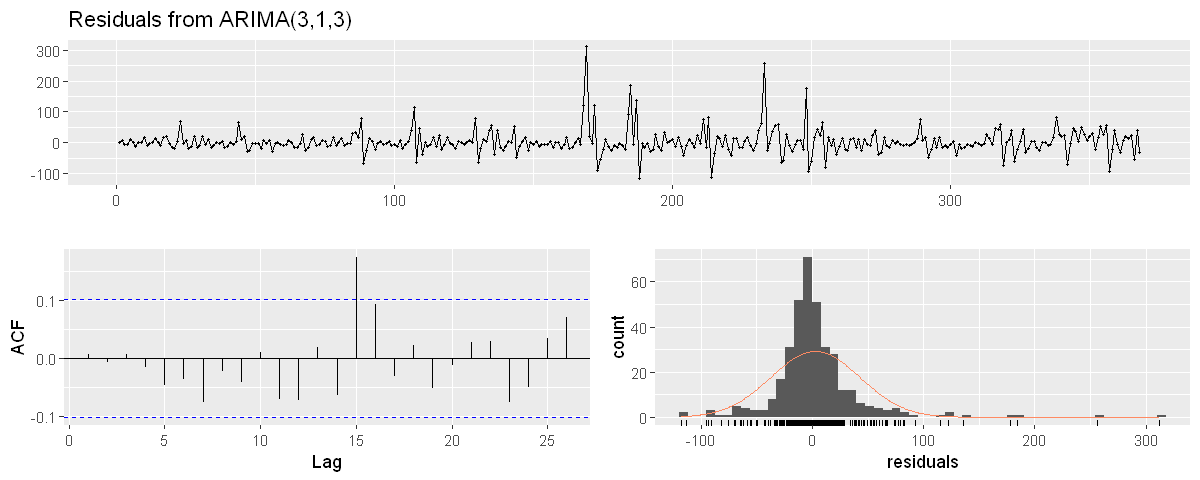

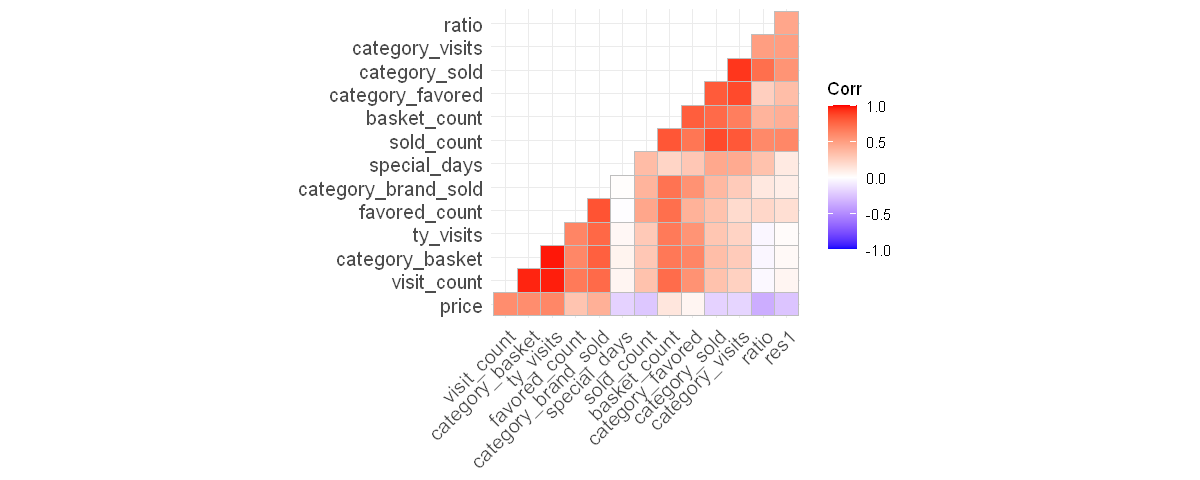

In [134]:
model_jel_arima <- arima(jel_ts,order=c(3,1,3))
checkresiduals(model_jel_arima)
jel_train$res1 <- model_jel_arima$residuals
corr <- cor(jel_train[!is.na(jel_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals have constant mean at 0 and variance looks constant although there is some outliers. There is not lags with correlation. Distribution is slightly right skewed. Residuals are correlated with category_visits.

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


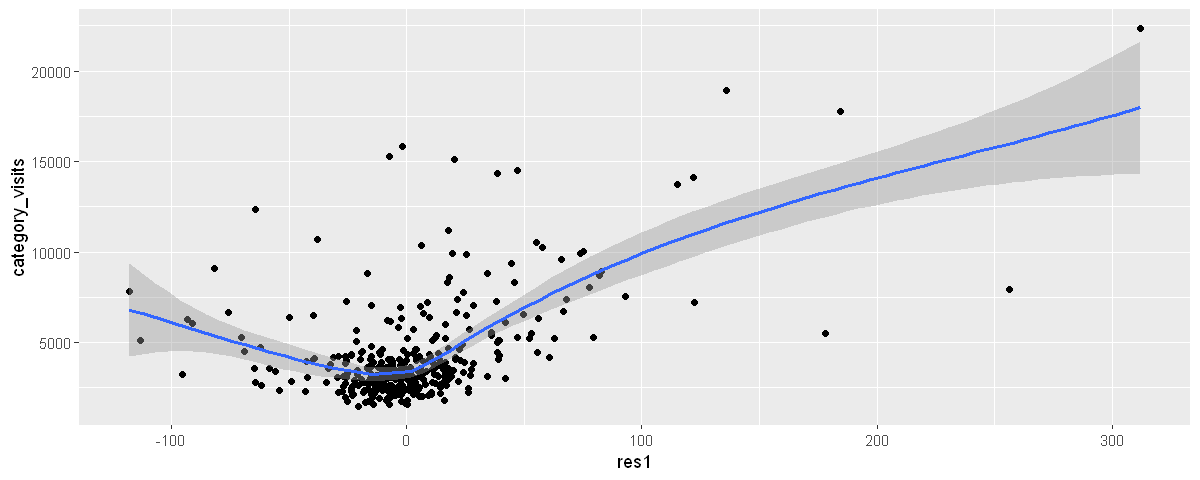

In [135]:
ggplot(jel_train,aes(x=res1,y=category_visits)) +  geom_point() + geom_smooth()

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


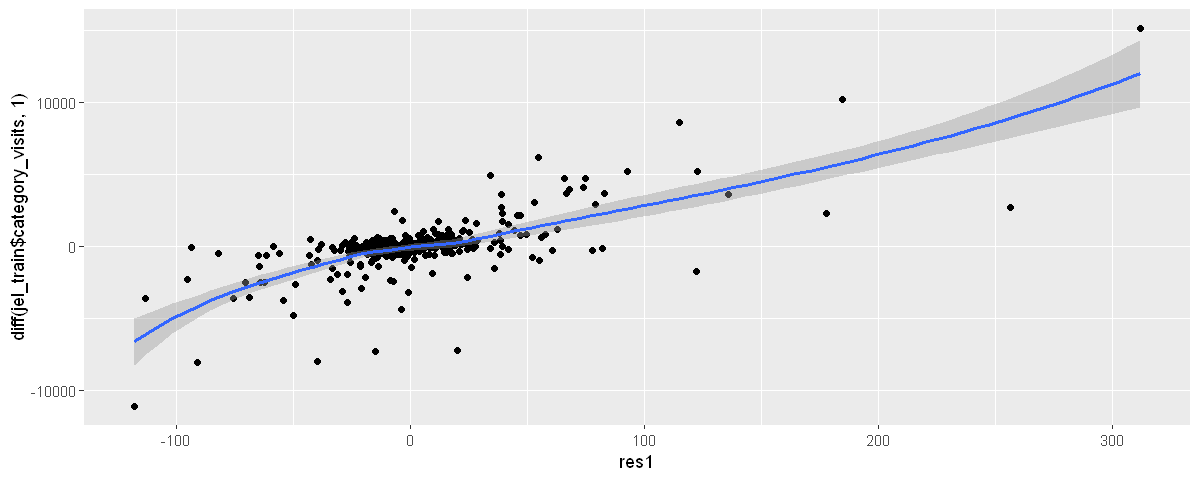

In [136]:
ggplot(jel_train[2:.N],aes(x=res1)) +  geom_point(aes(y=diff(jel_train$category_visits,1))) +
geom_smooth(aes(y=diff(jel_train$category_visits,1)))

In [137]:
cor(jel_train[2:.N]$res1,diff(jel_train$category_visits,1))
jel_train$diff_visits <- c(NA,diff(jel_train$category_visits,1))
jel$diff_visits <- c(NA,diff(jel$category_visits,1))

[1] 0.6963857

Differenced category_visits is highlt correlated with residuals with a value of 0.696. We could add it as a regressor.

In [138]:
arima(jel_ts,order=c(3,1,3),xreg=jel_train$diff_visits)


Call:
arima(x = jel_ts, order = c(3, 1, 3), xreg = jel_train$diff_visits)

Coefficients:
         ar1     ar2      ar3      ma1      ma2     ma3  jel_train$diff_visits
      0.6067  0.3794  -0.3508  -0.6246  -0.5043  0.1567                 0.0096
s.e.  0.3098  0.4221   0.2103   0.3185   0.4393  0.2214                 0.0007

sigma^2 estimated as 1115:  log likelihood = -1804.34,  aic = 3624.68

In [139]:
auto.arima(jel_ts,xreg=jel_train$diff_visits)

Series: jel_ts 
Regression with ARIMA(1,1,0) errors 

Coefficients:
         ar1    xreg
      0.1296  0.0095
s.e.  0.0518  0.0007

sigma^2 estimated as 1321:  log likelihood=-1833.85
AIC=3673.69   AICc=3673.76   BIC=3685.4


	Ljung-Box test

data:  Residuals from ARIMA(3,1,3)
Q* = 4.1249, df = 3, p-value = 0.2483

Model df: 7.   Total lags used: 10



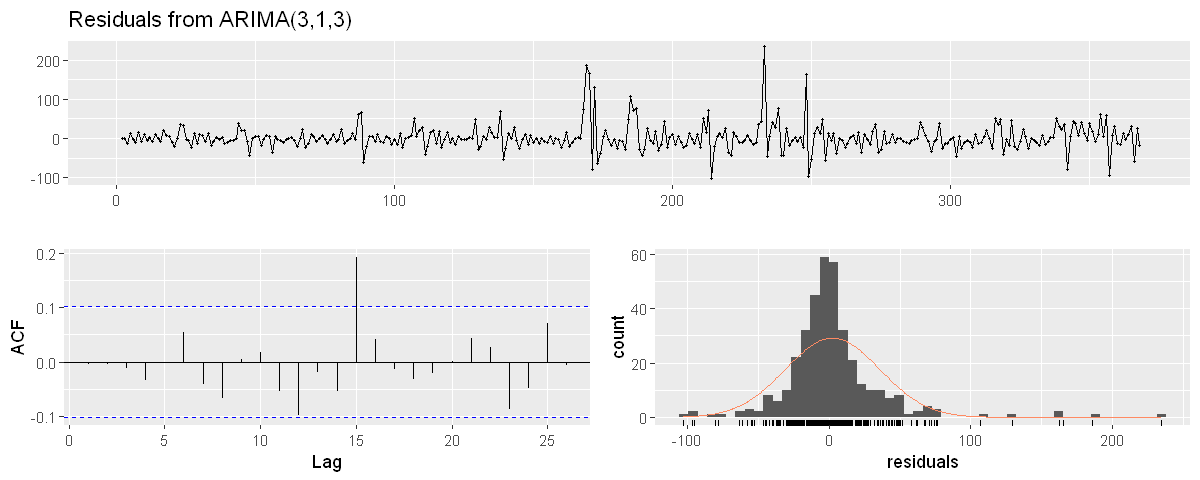

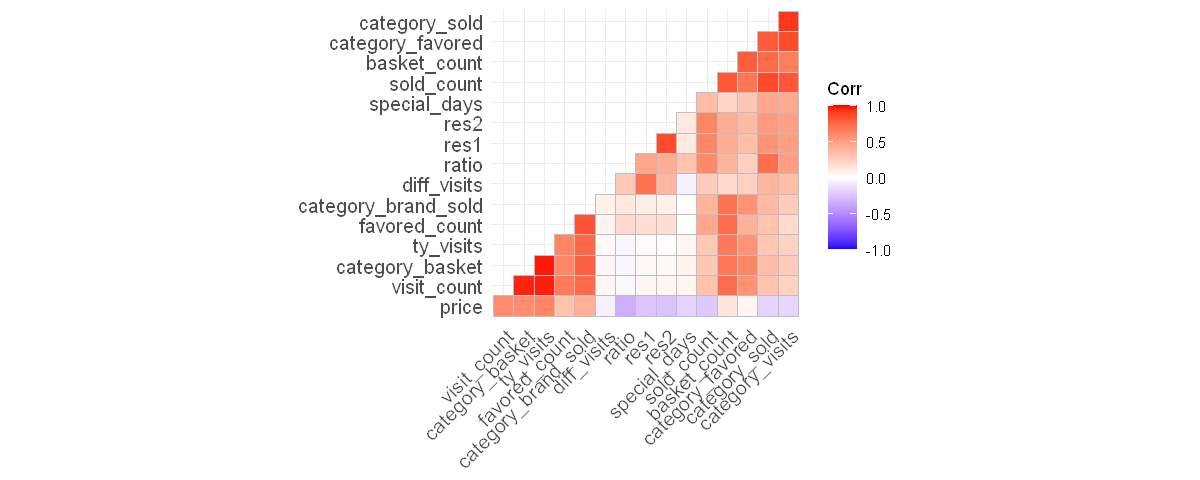

In [140]:
model_jel_arimax <- arima(jel_ts,order=c(3,1,3),xreg=jel_train$diff_visits)
checkresiduals(model_jel_arimax)
jel_train$res2 <- model_jel_arimax$residuals
corr <- cor(jel_train[!is.na(jel_train$price)& !is.na(jel_train$res2),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals don't look changed much in the stationary manner. However, we could see its success in the test period.

### Linear Models

Firstly, the days of week and trend columns will be added to the data. Next, the first model will be built with trend and weekly seasonality. Then, we'll look for possible regressors and add them to the model. Finally, we will find the best model among them. 

In [141]:
prod7[, `:=`(trend=1:.N, 
            days=wday(event_date, label=T))]

model7_1 <- lm(sold_count~trend+days, data=prod7)
summary(model7_1)


Call:
lm(formula = sold_count ~ trend + days, data = prod7)

Residuals:
   Min     1Q Median     3Q    Max 
-84.38 -31.46 -13.42  10.38 378.87 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  33.15644    6.11910   5.419 1.10e-07 ***
trend         0.22216    0.02874   7.730 1.09e-13 ***
days.L       -2.44024    8.10578  -0.301 0.763550    
days.Q      -26.92477    8.09114  -3.328 0.000966 ***
days.C        1.98732    8.08392   0.246 0.805949    
days^4        6.76780    8.07901   0.838 0.402754    
days^5       -0.87616    8.06181  -0.109 0.913517    
days^6        0.51162    8.04843   0.064 0.949350    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 58.57 on 360 degrees of freedom
Multiple R-squared:  0.1663,	Adjusted R-squared:  0.1501 
F-statistic: 10.26 on 7 and 360 DF,  p-value: 9.871e-12



	Breusch-Godfrey test for serial correlation of order up to 11

data:  Residuals
LM test = 205.56, df = 11, p-value < 2.2e-16


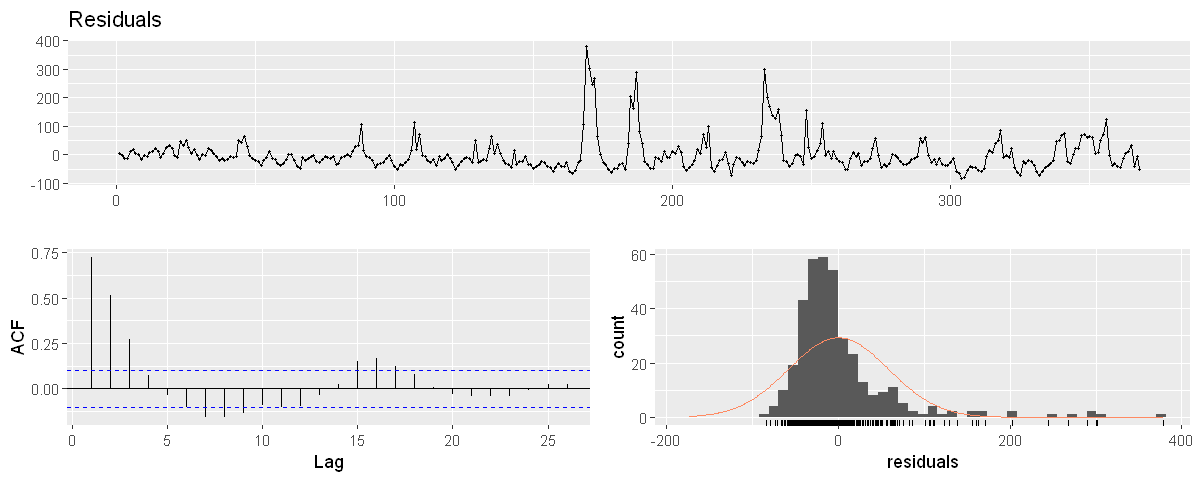

In [142]:
checkresiduals(model7_1)

* The first adjusted Rsqr value is 0.1501.
* The model's p value is small, which means that the model is meaningful. 
* The mean is not zero. 
* The variance is not constant. 
* Residuals are not normally distributed. 
* There are autocorrelations between the residuals. 

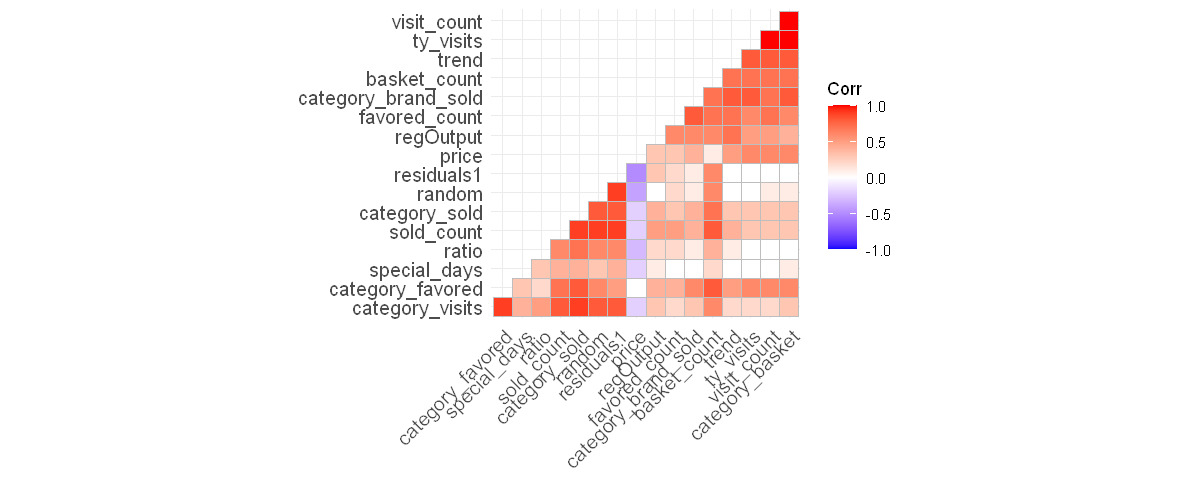

In [144]:
prod7[, residuals1:=model7_1$residuals]
corr <- round(cor(Filter(is.numeric, prod7[!is.na(prod7$price)])), 1)
ggcorrplot(corr, hc.order = TRUE,type = "lower")

Again, the maximum correlation with residuals1 is obtained by basket_count. Therefore, its lagged version will be added to the model. To find the lag value, we'll check the CCF function. 

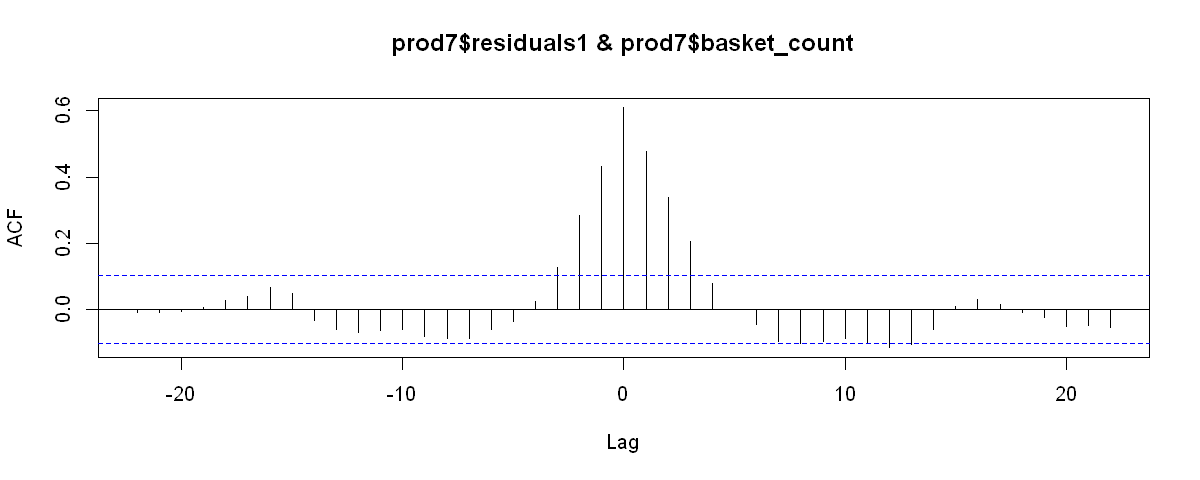

In [145]:
ccf(prod7$residuals1, prod7$basket_count)

In [146]:
model7_2 <- lm(sold_count~trend+days+shift(basket_count, 1), data=prod7)
summary(model7_2)


Call:
lm(formula = sold_count ~ trend + days + shift(basket_count, 
    1), data = prod7)

Residuals:
     Min       1Q   Median       3Q      Max 
-136.244  -20.065   -4.351    9.659  255.202 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             20.24619    4.72975   4.281  2.4e-05 ***
trend                   -0.10754    0.02974  -3.616 0.000342 ***
days.L                  -8.48641    6.16460  -1.377 0.169485    
days.Q                 -15.57661    6.17292  -2.523 0.012056 *  
days.C                   7.84887    6.14866   1.277 0.202600    
days^4                   2.88369    6.14785   0.469 0.639314    
days^5                  -4.49943    6.12692  -0.734 0.463203    
days^6                   3.55106    6.10660   0.582 0.561262    
shift(basket_count, 1)   0.21056    0.01285  16.382  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 44.4 on 358 degrees of freedom
  (1 observation


	Breusch-Godfrey test for serial correlation of order up to 12

data:  Residuals
LM test = 78.179, df = 12, p-value = 9.171e-12


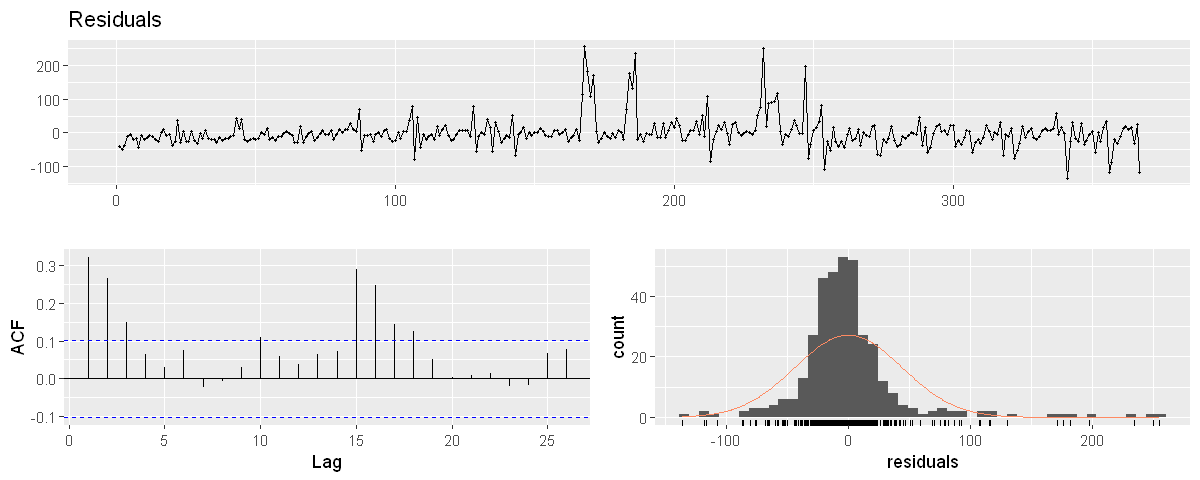

In [147]:
checkresiduals(model7_2)

* The adjusted Rsqr value is highly improved to 0.5124. 
* The model's p value is small, which means that the model is meaningful. 
* The mean is now zero. 
* The variance is still not constant. 
* Residuals are more likely to be normally distributed. 
* There are high autocorrelation at lag 1, 2, 15, and 16. 

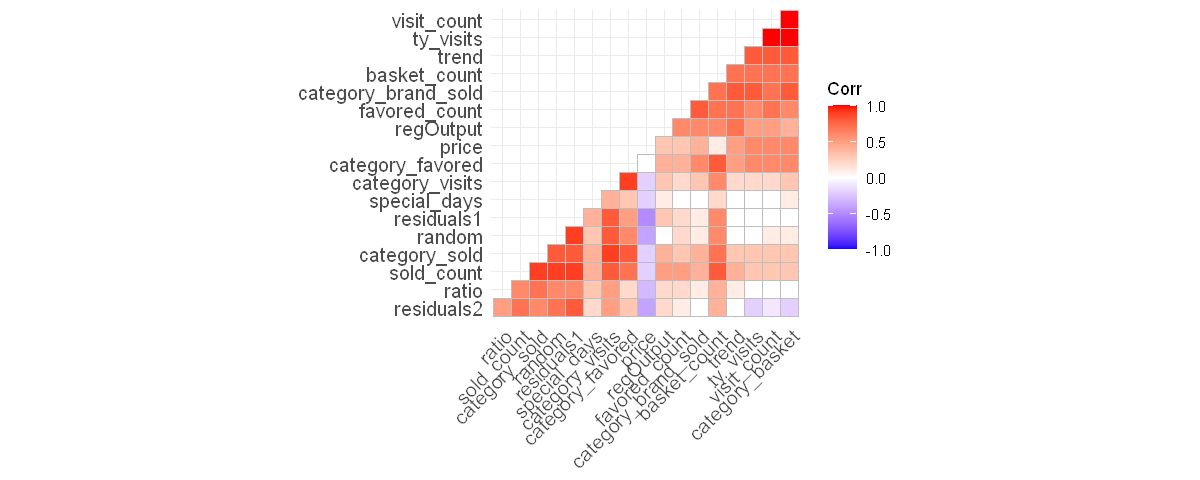

In [148]:
prod7[, residuals2:=c(NA, model7_2$residuals)]
corr <- round(cor(Filter(is.numeric, prod7[!is.na(prod7$price) & !is.na(prod7$residuals2)])), 1)
ggcorrplot(corr, hc.order = TRUE,type = "lower")

The maximum correlation with residuals2 is obtained by price. Therefore, its lagged version will be added to the model. To find the lag value, we'll check the CCF function. 

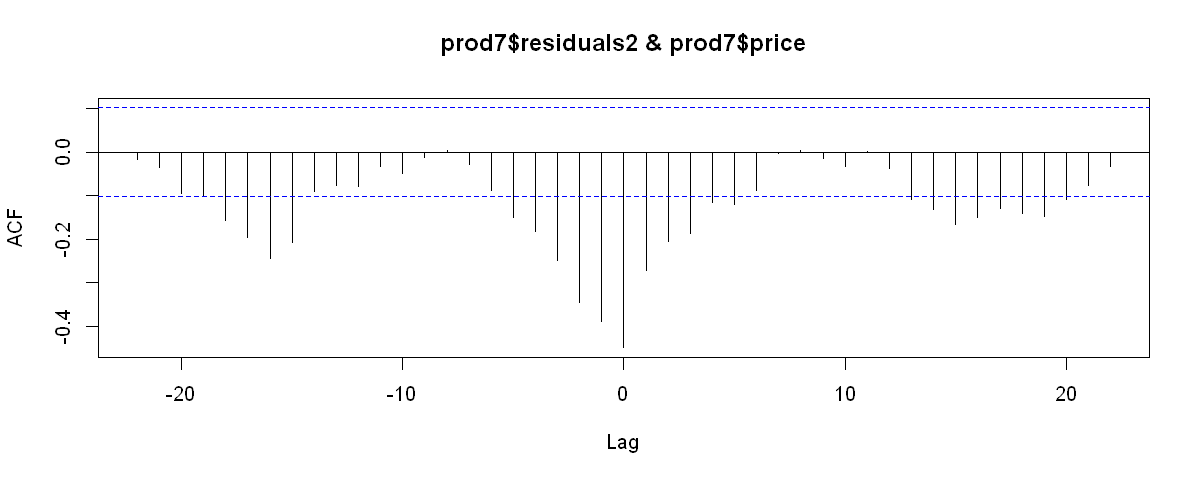

In [149]:
ccf(prod7$residuals2, prod7$price, na.action=na.pass)

In [150]:
model7_3 <- lm(sold_count~trend+days+shift(basket_count, 1)+shift(price, 1), data=prod7)
summary(model7_3)


Call:
lm(formula = sold_count ~ trend + days + shift(basket_count, 
    1) + shift(price, 1), data = prod7)

Residuals:
     Min       1Q   Median       3Q      Max 
-127.088  -17.502   -3.361   11.935  252.851 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            301.58275   41.64373   7.242 2.74e-12 ***
trend                    0.02501    0.03414   0.732 0.464425    
days.L                  -9.88470    5.81266  -1.701 0.089899 .  
days.Q                 -19.56064    5.84633  -3.346 0.000908 ***
days.C                   9.27049    5.79777   1.599 0.110711    
days^4                   2.46919    5.79355   0.426 0.670221    
days^5                  -5.02789    5.77403  -0.871 0.384462    
days^6                   2.25716    5.75751   0.392 0.695264    
shift(basket_count, 1)   0.18102    0.01287  14.068  < 2e-16 ***
shift(price, 1)         -3.81227    0.56105  -6.795 4.56e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 


	Breusch-Godfrey test for serial correlation of order up to 13

data:  Residuals
LM test = 46.738, df = 13, p-value = 1.07e-05


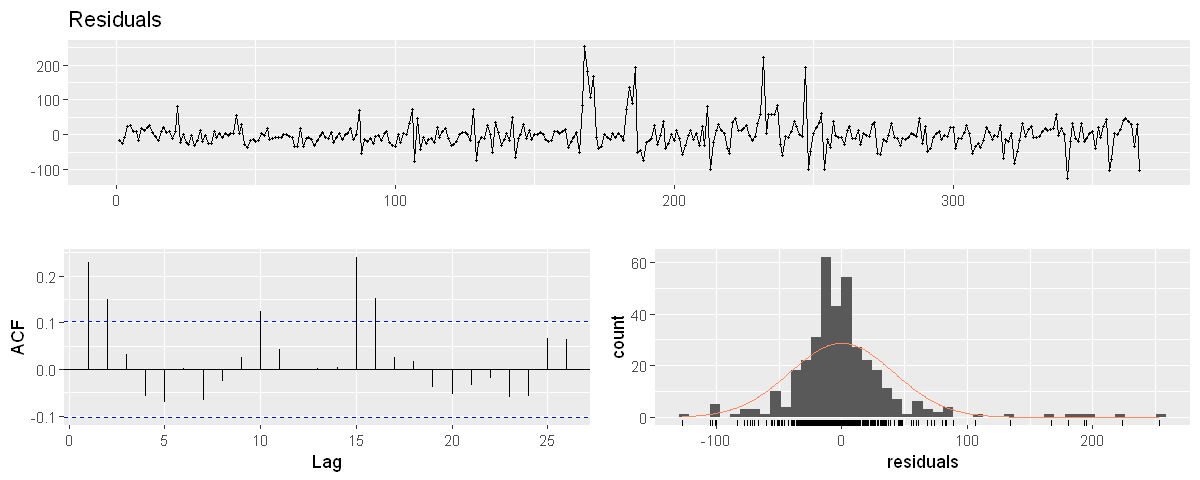

In [151]:
checkresiduals(model7_3)

* The adjusted Rsqr value is increased to 0.567. 
* The model's p value is small, which means that the model is meaningful. 
* The mean seems to be zero. 
* The variance is like constant although there are jumping points. 
* Residuals are like normally distributed. 
* There are high autocorrelations at lag 1 and lag 15. 
 
Now, let's check if the residuals3 is related with the lagged version of the input variable. 

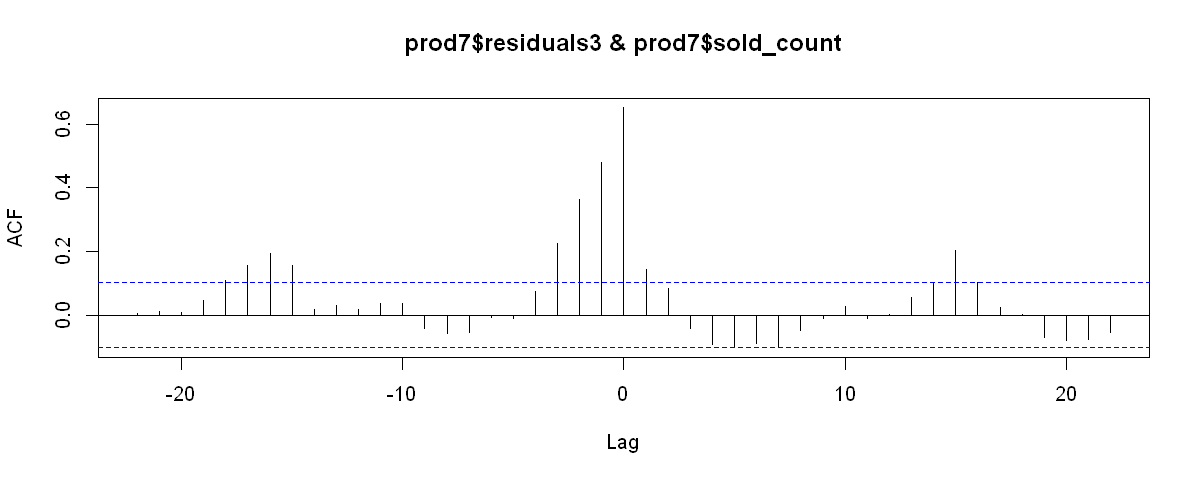

In [152]:
prod7[, residuals3:=c(NA,model7_3$residuals)]
ccf(prod7$residuals3, prod7$sold_count, na.action=na.pass)

In [153]:
model7_4 <- lm(sold_count~trend+days+shift(basket_count, 1)+shift(price, 1)+shift(sold_count,1), data=prod7)
summary(model7_4)


Call:
lm(formula = sold_count ~ trend + days + shift(basket_count, 
    1) + shift(price, 1) + shift(sold_count, 1), data = prod7)

Residuals:
     Min       1Q   Median       3Q      Max 
-115.852  -16.895   -2.886   11.329  278.090 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            152.45288   45.68858   3.337 0.000937 ***
trend                    0.05147    0.03260   1.579 0.115236    
days.L                 -13.16344    5.52940  -2.381 0.017809 *  
days.Q                 -15.24056    5.57813  -2.732 0.006605 ** 
days.C                  10.83203    5.49732   1.970 0.049565 *  
days^4                   3.22380    5.48926   0.587 0.557380    
days^5                  -3.09814    5.47766  -0.566 0.572025    
days^6                   1.75516    5.45443   0.322 0.747804    
shift(basket_count, 1)   0.06804    0.02130   3.195 0.001524 ** 
shift(price, 1)         -1.89705    0.60835  -3.118 0.001967 ** 
shift(sold_count, 1)     0.47766  


	Breusch-Godfrey test for serial correlation of order up to 14

data:  Residuals
LM test = 24.864, df = 14, p-value = 0.03593


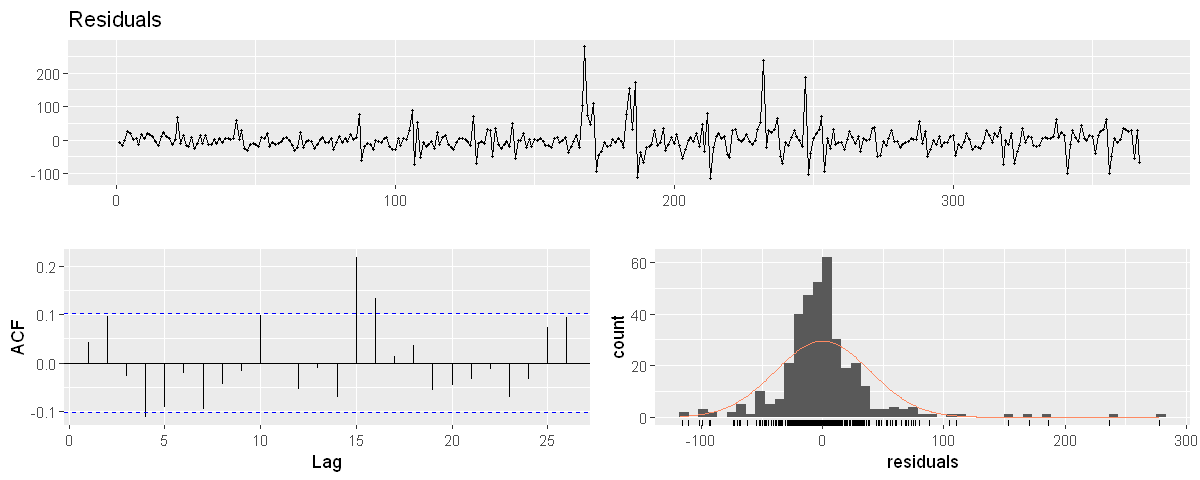

In [154]:
checkresiduals(model7_4)

* The adjusted Rsqr value is a little improved to 0.6115. 
* The model's p value is small, which means that the model is meaningful. 
* The mean seems to be zero. 
* The variance is like constant. 
* Residuals are like normally distributed. 
* There is not a very significant autocorrelation. 
 
So, the final model is model7_4.

Warning message:
"Removed 1 rows containing missing values (geom_point)."

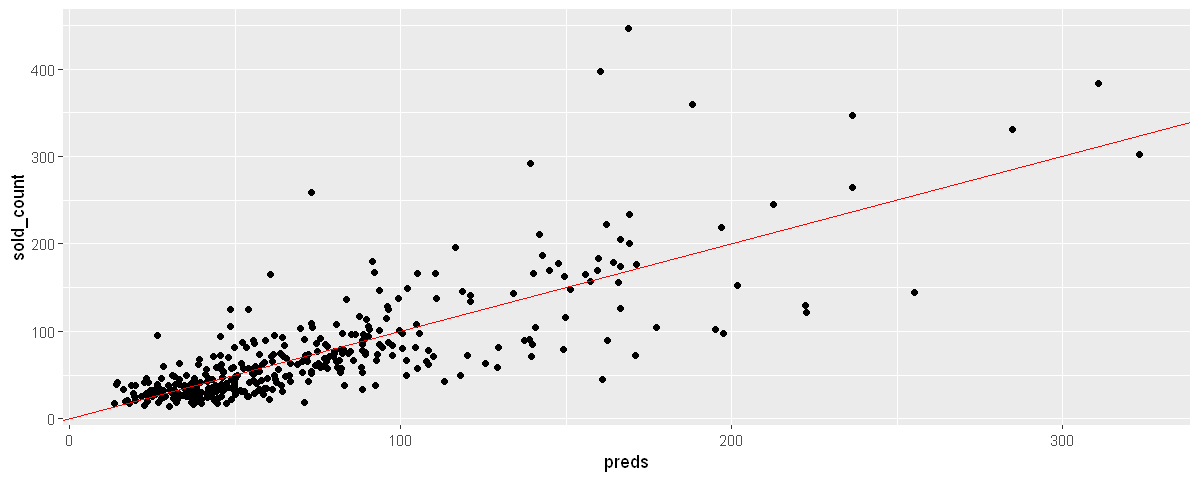

In [155]:
prod7[, preds:=c(NA,model7_4$fitted.values)]
ggplot(prod7, aes(x=preds, y=sold_count)) + geom_point() + geom_abline(intercept=0, slope=1, color="red") 

### Forecasting

In [450]:
forecast_data_jel <- data.table(event_date=jel[event_date>=test_start&event_date<=test_end,]$event_date,
                            sold_count=jel[event_date>=test_start&event_date<=test_end,]$sold_count)
jel[,`:=`(trend=1:.N,
           days=wday(event_date, label=T))]
arima_fc <- numeric(0)
arimax_fc <- numeric(0)
reg_fc <- numeric(0)
for(i in 1:length(test_dates)){
  
  train_dt <- jel[event_date<test_dates[i],]
  model_arima <- Arima(train_dt$sold_count,order=c(3,1,4))
  model_arimax <- Arima(train_dt$sold_count,order=c(3,1,4),xreg=train_dt$diff_visits)
  model_reg <- lm(sold_count~trend+days+shift(basket_count, 1)+shift(price, 1)+shift(sold_count,1), data=train_dt)
  newreg <- forecast(auto.arima(train_dt$diff_visits),h=1)$mean[1]
  arima_temp <- forecast(model_arima)
  arimax_temp <- forecast(model_arimax,xreg=newreg)
  reg_temp <- predict(model_reg,newdata=jel[event_date %in% c(test_dates[i],test_dates[i+1])])
  arima_fc <- c(arima_fc,arima_temp$mean[1])
  arimax_fc <- c(arimax_fc,arimax_temp$mean[1])
  reg_fc <- c(reg_fc,reg_temp)
  
}
reg_fc[is.na(reg_fc)] <- mean(reg_fc[!is.na(reg_fc)])
forecast_data_jel <- forecast_data_jel[,`:=`(arima_p=arima_fc,
                                               arimax_p=arimax_fc,
                                               reg_p=reg_fc[c(1,seq(2,28,2))])]
accu(forecast_data_jel$sold_count,forecast_data_jel$arima_p)
accu(forecast_data_jel$sold_count,forecast_data_jel$arimax_p)
accu(forecast_data_jel[1:(.N-1)]$sold_count,forecast_data_jel[2:.N]$reg_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
15,81.26667,18.35159,0.2258194,-0.06315798,0.2085848,20.27698,16.63532,0.2047004,0.2047004


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
15,81.26667,18.35159,0.2258194,-0.01421011,0.2677661,29.46622,20.73637,0.2551646,0.2551646


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
14,80.85714,18.97309,0.2346495,-0.001894587,0.1369498,14.5462,11.1321,0.1376762,0.1376762


In [459]:
result_data_jel <- data.table(event_date=jel[event_date>=result_start&event_date<=result_end,]$event_date,
                               sold_count=jel[event_date>=result_start&event_date<=result_end,]$sold_count)
final_fc <- numeric(0)
for(i in 1:length(result_dates)){
  
  train_dt <- jel[event_date<result_dates[i],]
  model_final <- lm(sold_count~trend+days+shift(basket_count, 1)+shift(sold_count,1), data=train_dt)
  final_temp <- predict(model_final,newdata=jel[event_date %in% c(result_dates[i],result_dates[i+1])])
  final_fc <- c(final_fc,final_temp)
  
}
final_fc[is.na(final_fc)] <- mean(final_fc[!is.na(final_fc)])
result_data_jel <- result_data_jel[,`:=`(final_p=final_fc[c(1,seq(2,28,2))])]
accu(result_data_jel[1:(.N-1)]$sold_count,result_data_jel[2:.N]$final_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
14,70.57143,15.1643,0.2148788,-0.01595804,0.1160754,9.21143,7.27536,0.1030922,0.1030922


In [452]:
data.frame(event_date=result_data_jel[1:(.N-1)]$event_date,
           sold_count=result_data_jel[1:(.N-1)]$sold_count,
           predictions=result_data_jel[2:.N]$final_p)

event_date,sold_count,predictions
2021-06-12,56,59.58912
2021-06-13,95,97.14483
2021-06-14,47,70.55064
2021-06-15,78,81.85642
2021-06-16,81,76.29060
2021-06-17,79,65.75714
2021-06-18,57,50.92852
2021-06-19,77,72.34972
2021-06-20,83,86.71792
2021-06-21,76,89.06199


### Fakir Dik Süpürge

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


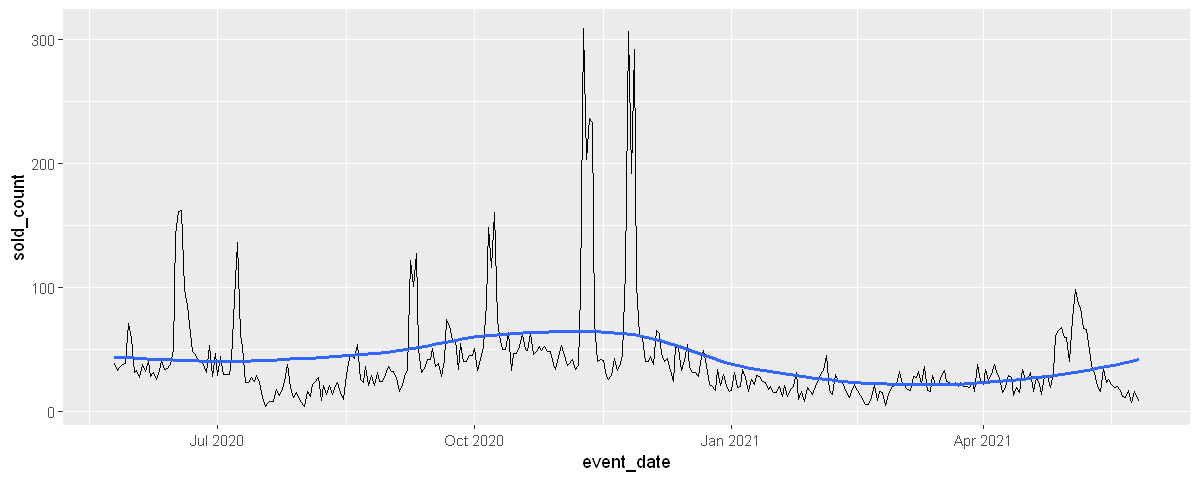

In [158]:
ggplot(prod6, aes(x=event_date, y=sold_count)) + geom_line() + geom_smooth(se=F)

* By the blue line, it seems that there is a sinus wave shaped trend in the data. The mean is not constant over time.  
* The variance changes. 
* Between November 2020 and December 2020, there are high sales. 
* The data seems not to be stationary. 

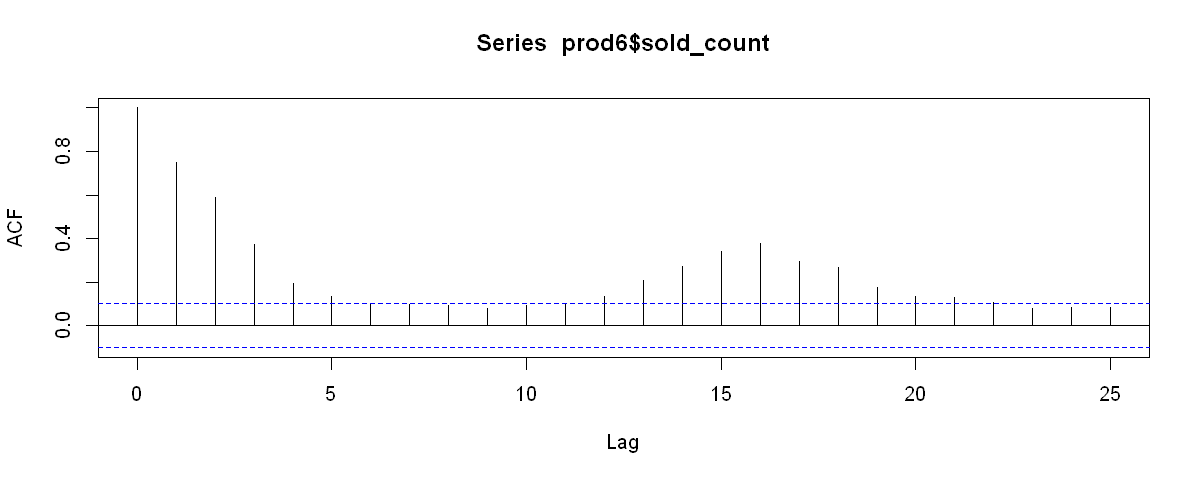

In [159]:
acf(prod6$sold_count)

On the graph above, there is a peak point at lag 16. 

### Weekly Decomposition

Additive decomposition will be used due to the non-increasing variance. 

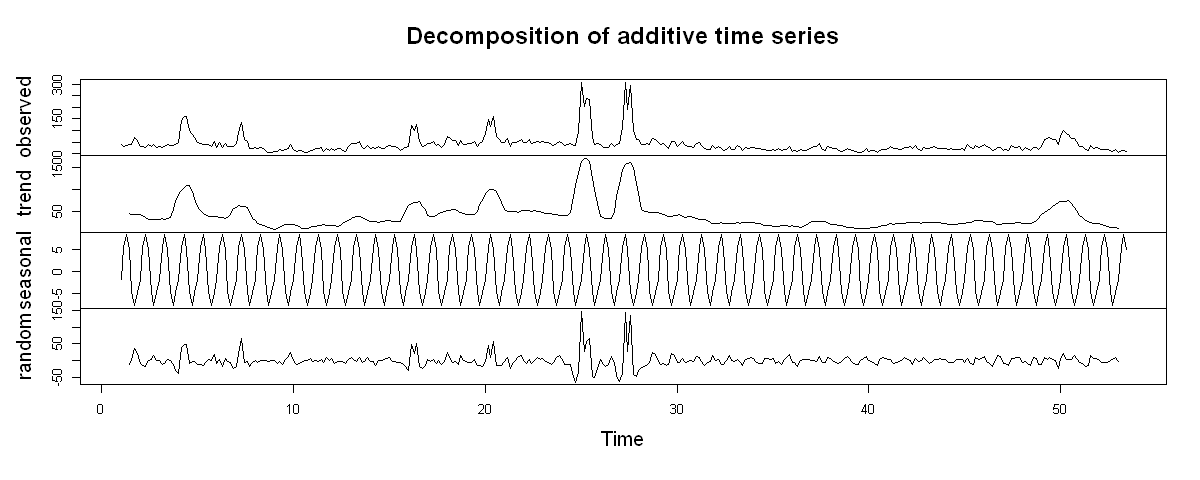

In [160]:
prod6_weekly_dec <- decompose(ts(prod6$sold_count, freq=7), type="additive")
plot(prod6_weekly_dec)

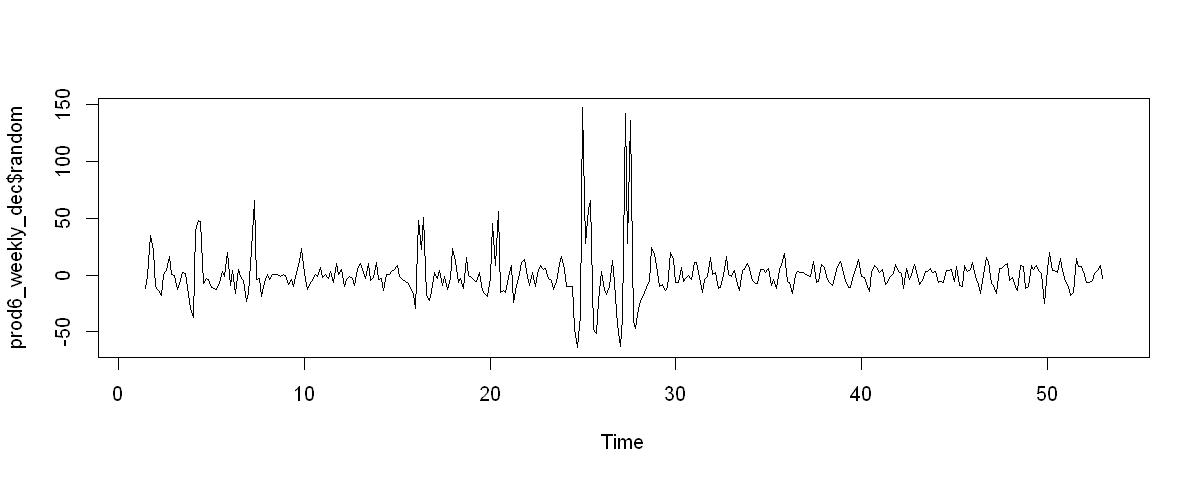

In [161]:
plot(prod6_weekly_dec$random)

* The mean is constant. 
* The variance slightly changes over time. 

In [162]:
u_test <- ur.kpss(prod6_weekly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0067 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


From the KPSS test above, it can be said that the data is stationary. 

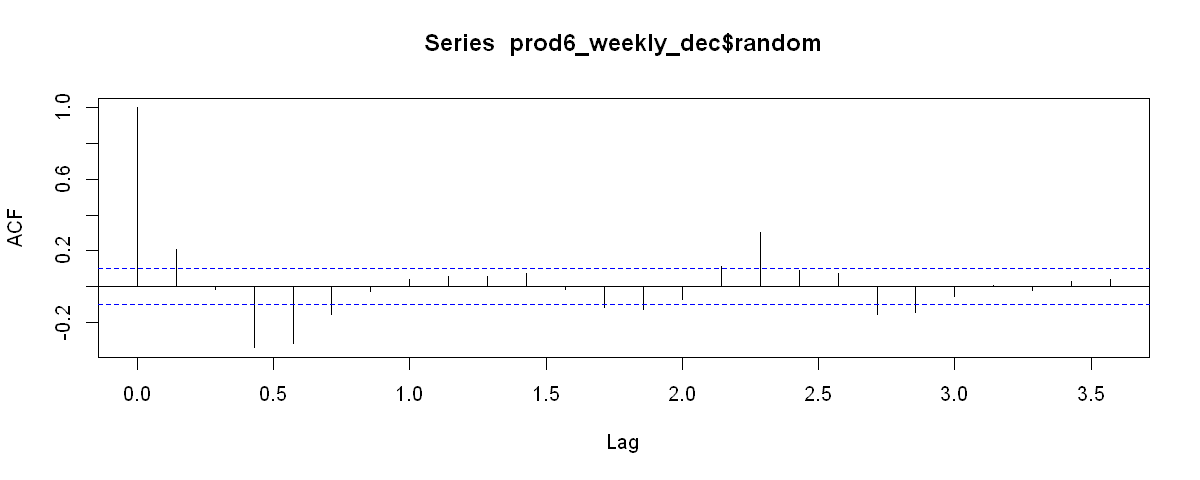

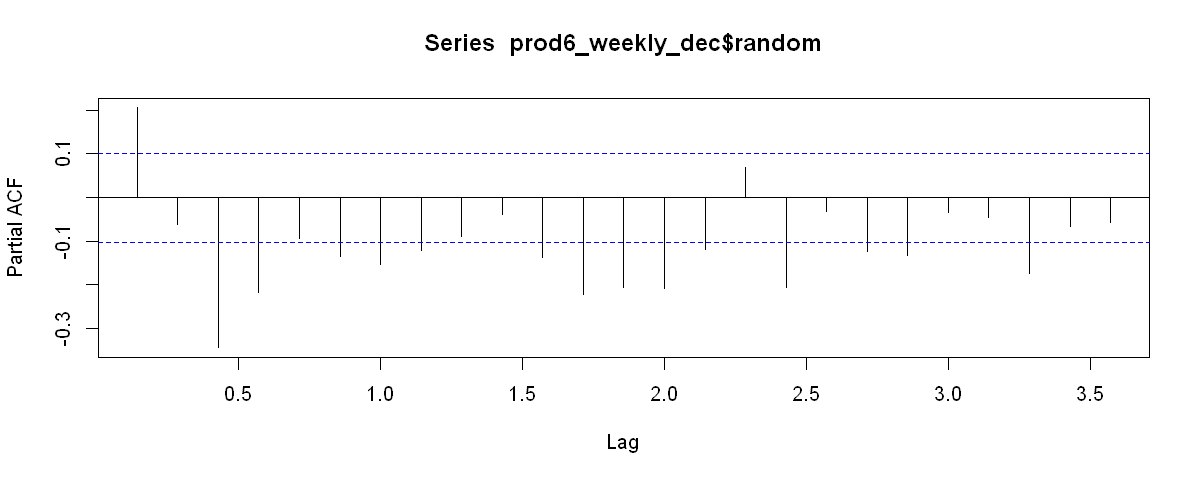

In [163]:
acf(prod6_weekly_dec$random, na.action=na.pass)
pacf(prod6_weekly_dec$random, na.action=na.pass)

There are slightly correlations at different level of lags. 

### Monthly Decomposition

month,sold_count
2020 May,315
2020 Jun,1608
2020 Jul,908
2020 Aug,770
2020 Sep,1451
2020 Oct,1850
2020 Nov,2931
2020 Dec,1145
2021 Jan,621
2021 Feb,512


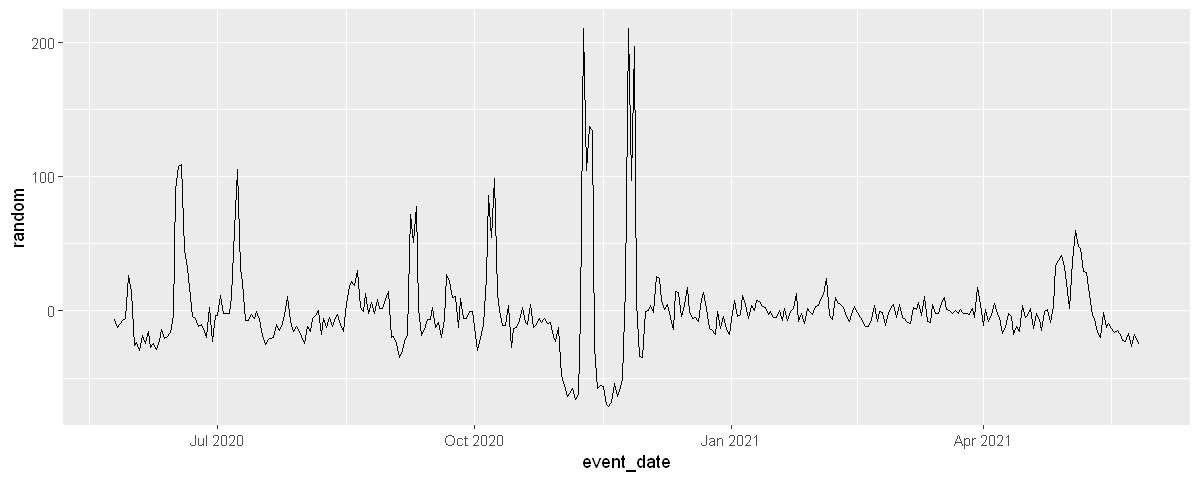

In [164]:
prod6_monthly <- prod6[, month:=yearmonth(event_date)]
prod6_monthly[, .(sold_count=sum(sold_count)), by=month]
prod6_monthly[, trend:=1:.N]

prod6_reg <- lm(sold_count~trend+as.factor(month), data=prod6_monthly)
prod6_monthly[, regOutput:=predict(prod6_reg, prod6_monthly)]

prod6_monthly[, random:=sold_count-regOutput]

ggplot(prod6_monthly, aes(x=event_date, y=random)) + geom_line()

* The mean is constant. 
* The variance seems to be non-constant. 

In [165]:
u_test <- ur.kpss(prod6_monthly$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0136 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


The test result says that monthly decomposed data is stationary. 

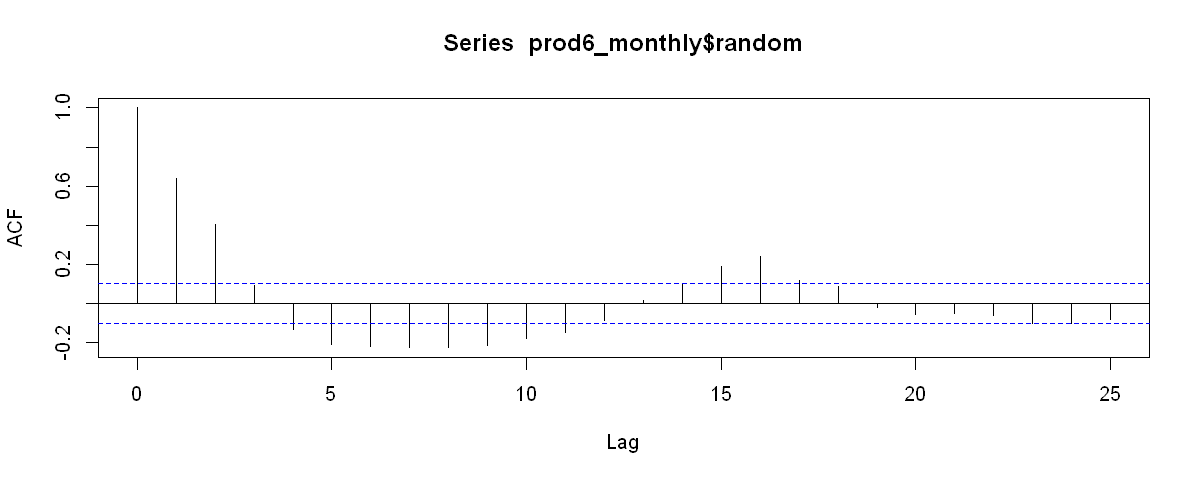

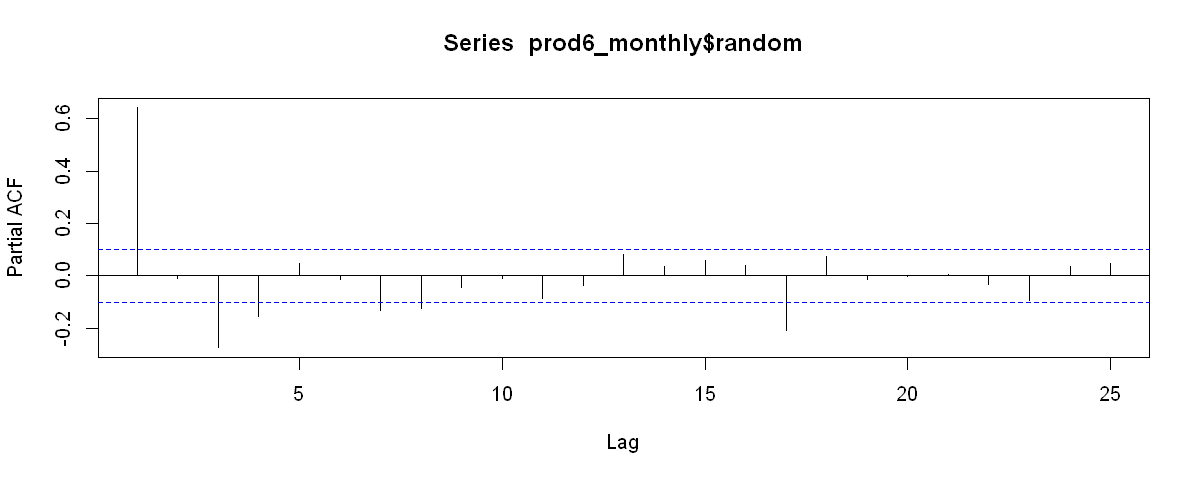

In [166]:
acf(prod6_monthly$random)
pacf(prod6_monthly$random)

The ACF graph is  like sinus wave with a peak value at lag 16. Also a high correlation with lag 1 can be seen on the PACF graph. 

### Building an ARIMA Model

In [167]:
fakir <- data[product_content_id=="7061886",][order(event_date)]
fakir_train <- fakir[event_date<test_start,]
fakir_ts <- ts(fakir_train$sold_count)

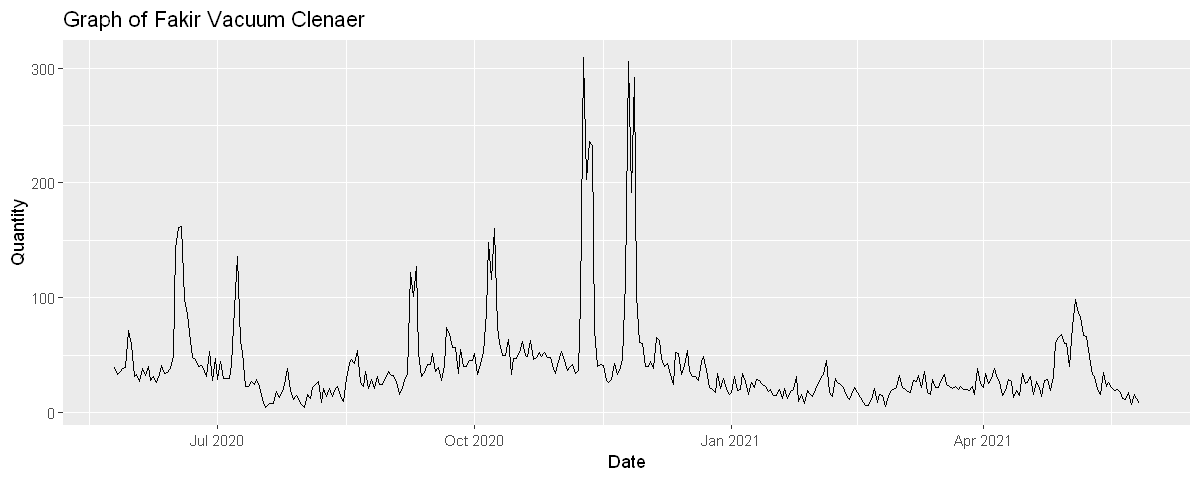

In [168]:
ggplot(fakir_train,aes(x=event_date,y=sold_count)) + geom_line() +
labs(title= "Graph of Fakir Vacuum Clenaer", x= "Date", y="Quantity")

Fakir vacuum cleaner data is not stationary, because of the trend and outliers.

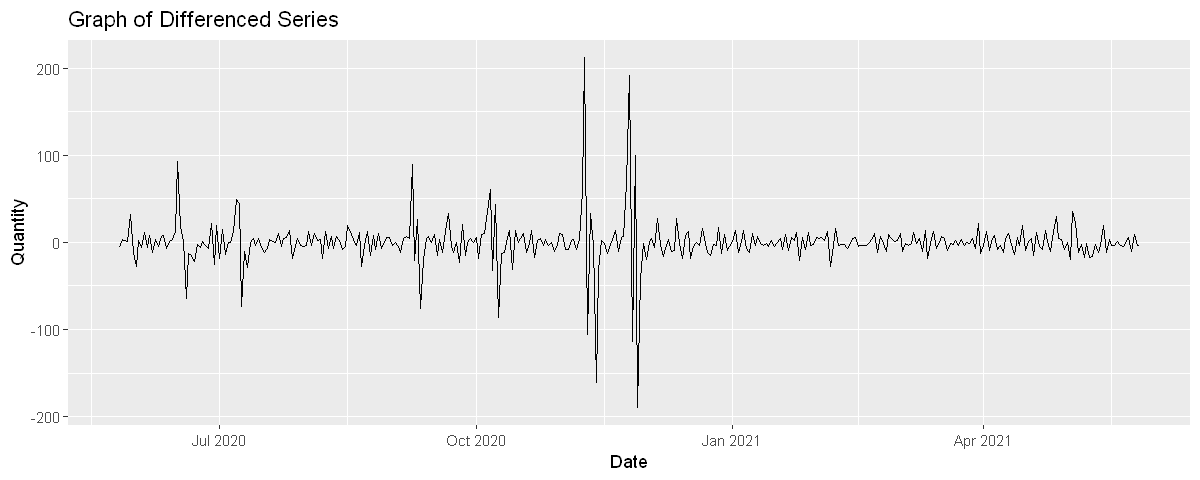

In [169]:
ggplot(fakir_train[2:.N,],aes(x=event_date)) + geom_line(aes(y=diff(fakir_train$sold_count,1))) + 
  labs(title= "Graph of Differenced Series", x= "Date", y="Quantity")

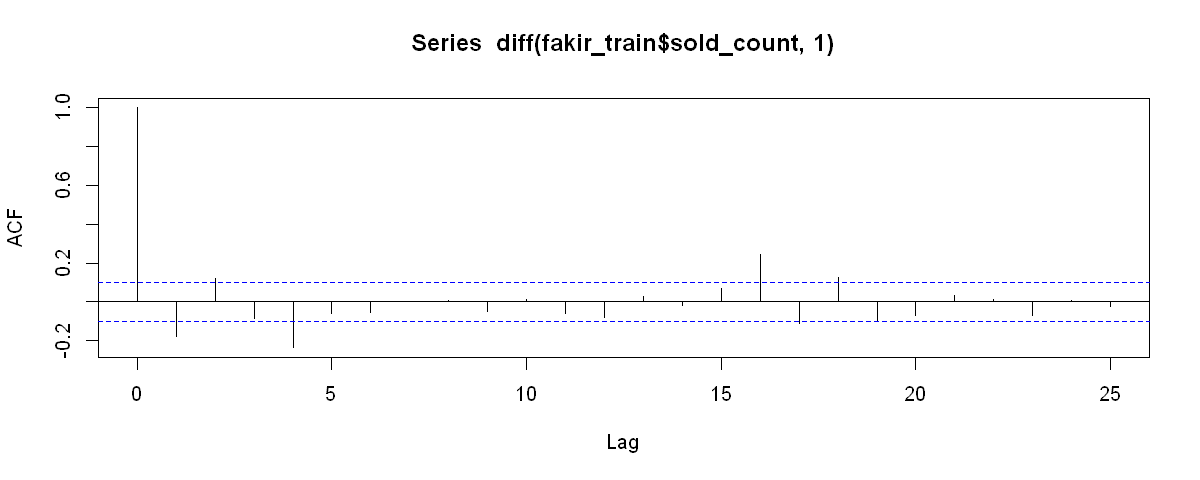

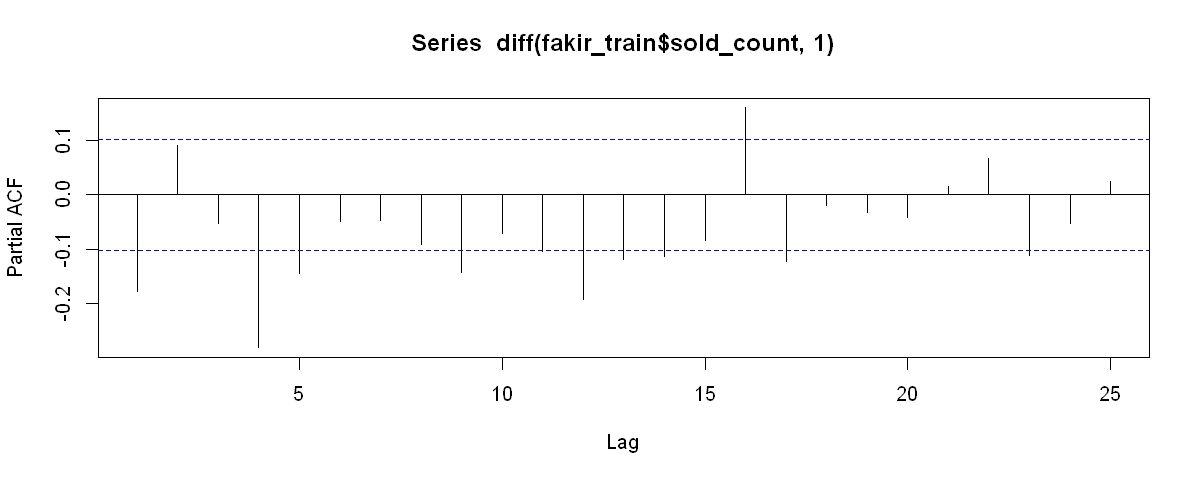

In [170]:
acf(diff(fakir_train$sold_count,1))
pacf(diff(fakir_train$sold_count,1))

After analyzing the ACF and PACF graphs of the differenced series, AR(1), AR(4), MA(1) and MA(4) models could be tried as a ARIMA model.

In [171]:
arima(fakir_ts,order=c(1,1,1))


Call:
arima(x = fakir_ts, order = c(1, 1, 1))

Coefficients:
          ar1     ma1
      -0.4581  0.2845
s.e.   0.1579  0.1660

sigma^2 estimated as 736.7:  log likelihood = -1732.27,  aic = 3470.55

In [172]:
arima(fakir_ts,order=c(4,1,1))


Call:
arima(x = fakir_ts, order = c(4, 1, 1))

Coefficients:
         ar1     ar2      ar3      ar4      ma1
      0.6143  0.2204  -0.1475  -0.1644  -0.9235
s.e.  0.0572  0.0601   0.0599   0.0542   0.0294

sigma^2 estimated as 619.7:  log likelihood = -1701.18,  aic = 3414.36

In [173]:
arima(fakir_ts,order=c(1,1,4))


Call:
arima(x = fakir_ts, order = c(1, 1, 4))

Coefficients:
         ar1      ma1     ma2      ma3      ma4
      0.3058  -0.6019  0.1564  -0.2170  -0.2528
s.e.  0.1261   0.1239  0.0787   0.0607   0.0734

sigma^2 estimated as 609.8:  log likelihood = -1698.29,  aic = 3408.59

In [174]:
arima(fakir_ts,order=c(4,1,4))


Call:
arima(x = fakir_ts, order = c(4, 1, 4))

Coefficients:
         ar1     ar2      ar3      ar4      ma1     ma2      ma3      ma4
      0.2548  0.1198  -0.0793  -0.0397  -0.5502  0.0220  -0.1103  -0.2626
s.e.  0.4399  0.3897   0.2508   0.1608   0.4383  0.5072   0.3697   0.3029

sigma^2 estimated as 608.8:  log likelihood = -1698,  aic = 3414

In [175]:
auto.arima(fakir_ts)

Series: fakir_ts 
ARIMA(0,1,5) 

Coefficients:
          ma1     ma2      ma3      ma4      ma5
      -0.3007  0.0567  -0.2058  -0.3119  -0.1090
s.e.   0.0511  0.0528   0.0540   0.0519   0.0513

sigma^2 estimated as 618.8:  log likelihood=-1698.48
AIC=3408.96   AICc=3409.19   BIC=3432.39

The best model is ARIMA(1,1,4) with the AIC value of 3408.59.


	Ljung-Box test

data:  Residuals from ARIMA(1,1,4)
Q* = 1.7263, df = 5, p-value = 0.8856

Model df: 5.   Total lags used: 10



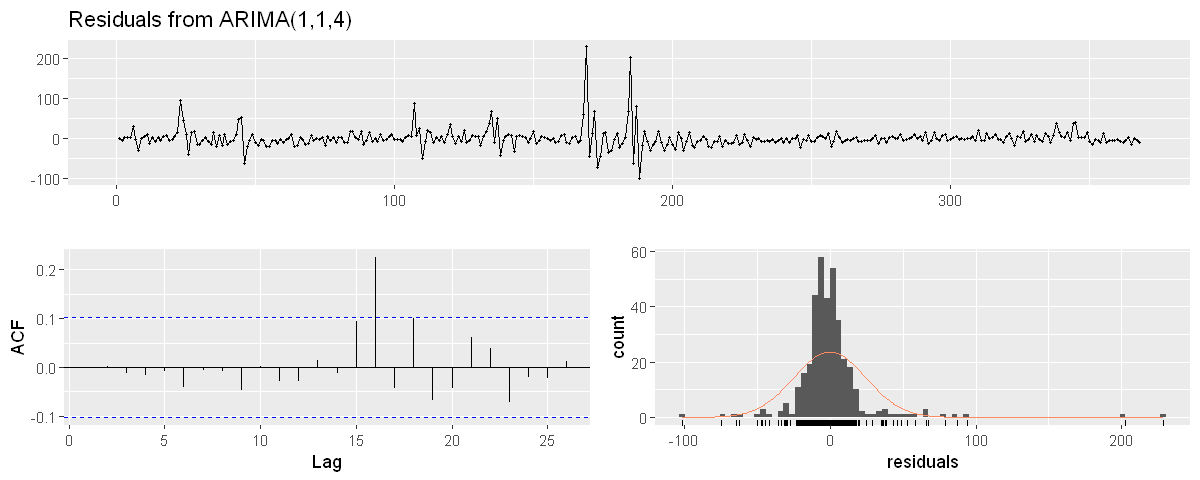

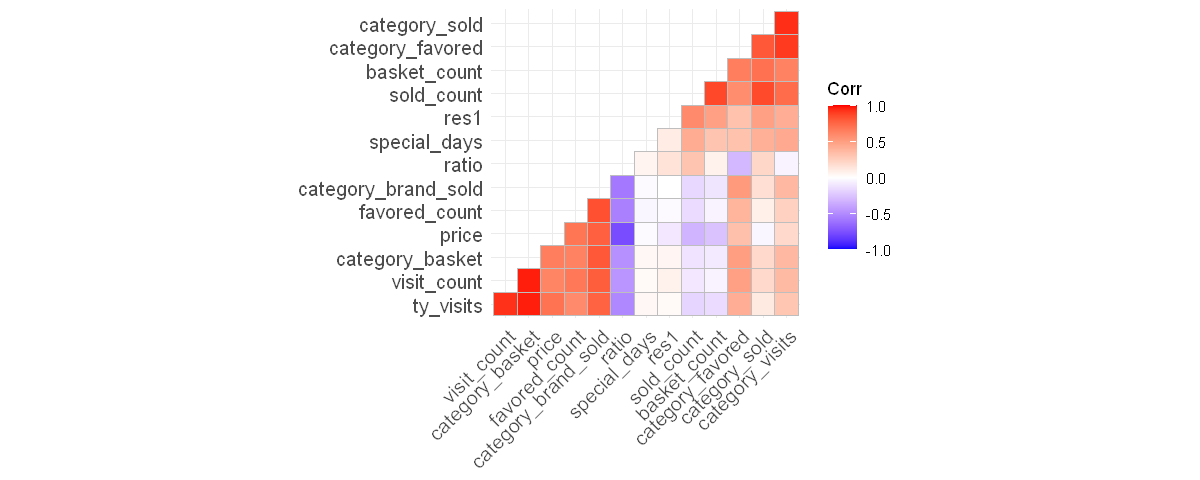

In [176]:
model_fakir_arima <- arima(fakir_ts,order=c(1,1,4))
checkresiduals(model_fakir_arima)
fakir_train$res1 <- model_fakir_arima$residuals
corr <- cor(fakir_train[!is.na(fakir_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals seem stationary with a constant mean of 0 and nearly constant variance. Histogram of the residuals look as a normal distribution. Category_sold attribute is correlated with the residuals.

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


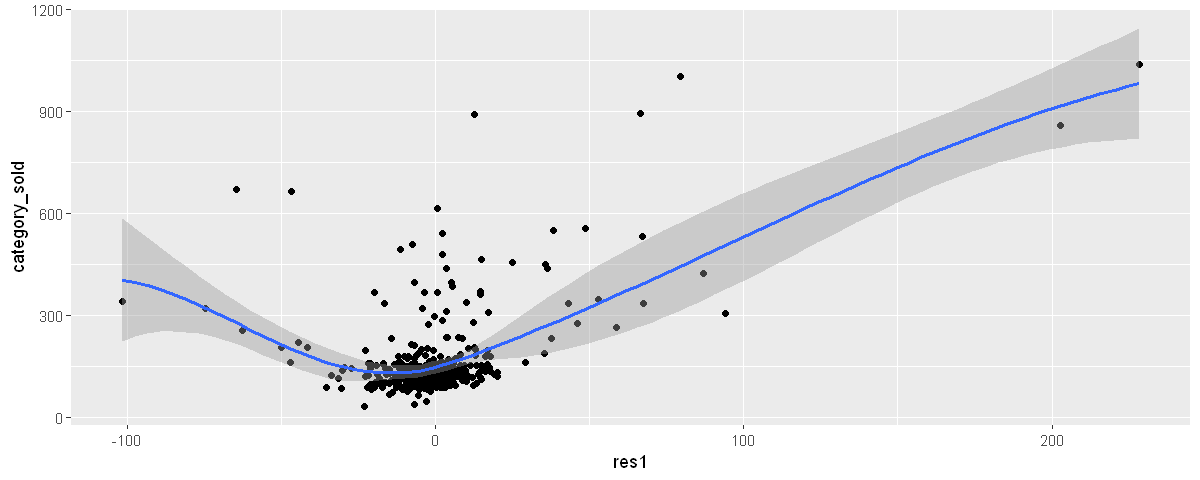

In [177]:
ggplot(fakir_train,aes(x=res1,y=category_sold)) +  geom_point() + geom_smooth()

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


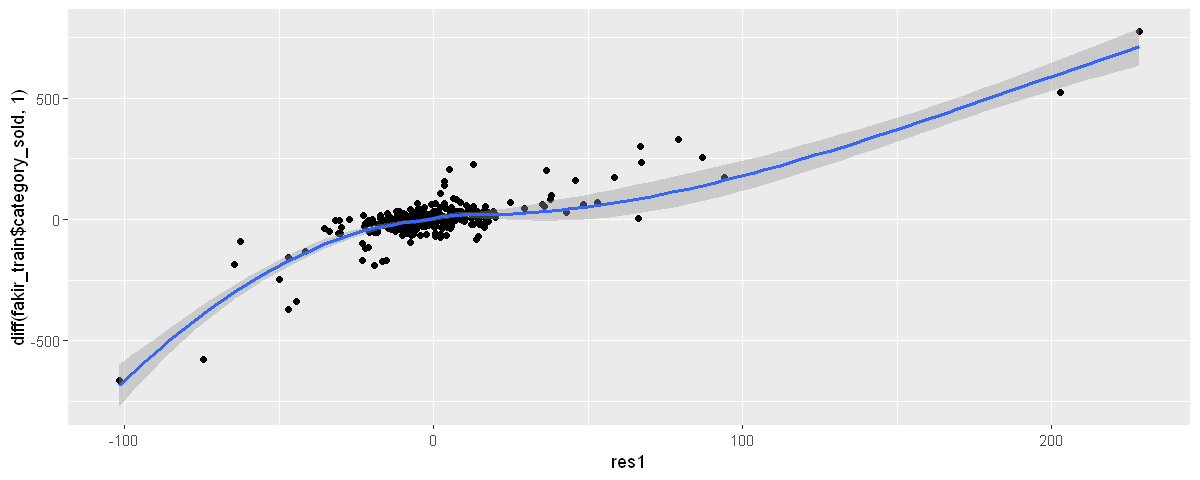

In [178]:
ggplot(fakir_train[2:.N],aes(x=res1)) +  geom_point(aes(y=diff(fakir_train$category_sold,1))) +
geom_smooth(aes(y=diff(fakir_train$category_sold,1)))

In [179]:
cor(fakir_train[2:.N]$res1,diff(fakir_train$category_sold,1))
fakir_train$diff_sold <- c(NA,diff(fakir_train$category_sold,1))
fakir$diff_sold <- c(NA,diff(fakir$category_sold,1))

[1] 0.8117548

In [180]:
arima(fakir_ts,order=c(1,1,4),xreg=fakir_train$diff_sold)


Call:
arima(x = fakir_ts, order = c(1, 1, 4), xreg = fakir_train$diff_sold)

Coefficients:
         ar1      ma1      ma2      ma3      ma4  fakir_train$diff_sold
      0.5127  -0.4745  -0.0735  -0.1067  -0.2695                 0.1428
s.e.  0.0862   0.0863   0.0565   0.0552   0.0598                 0.0071

sigma^2 estimated as 324.8:  log likelihood = -1578.32,  aic = 3170.64

New regressor give better AIC value which is 3170.64 and better than the previous model.


	Ljung-Box test

data:  Residuals from ARIMA(1,1,4)
Q* = 3.4188, df = 4, p-value = 0.4903

Model df: 6.   Total lags used: 10



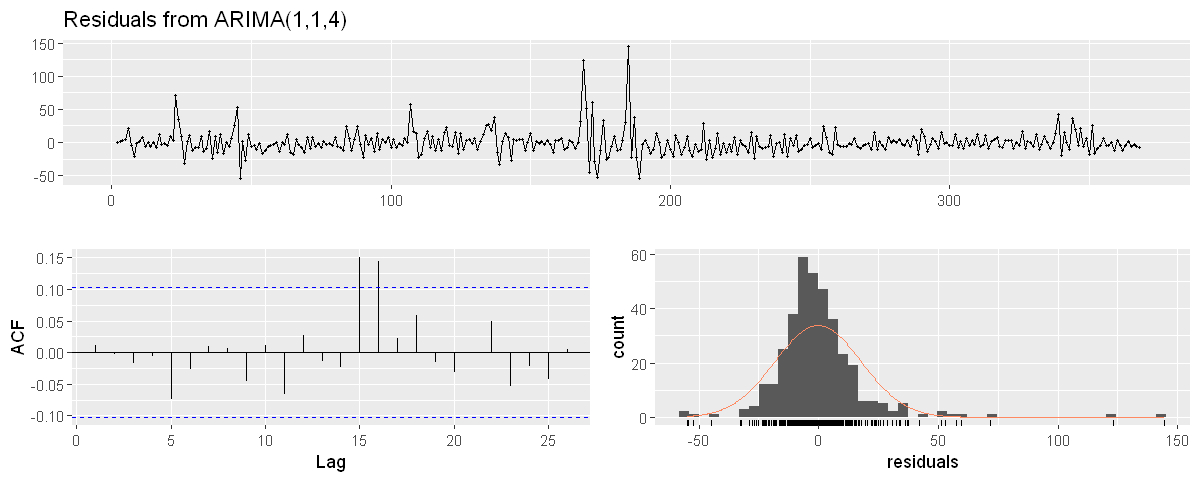

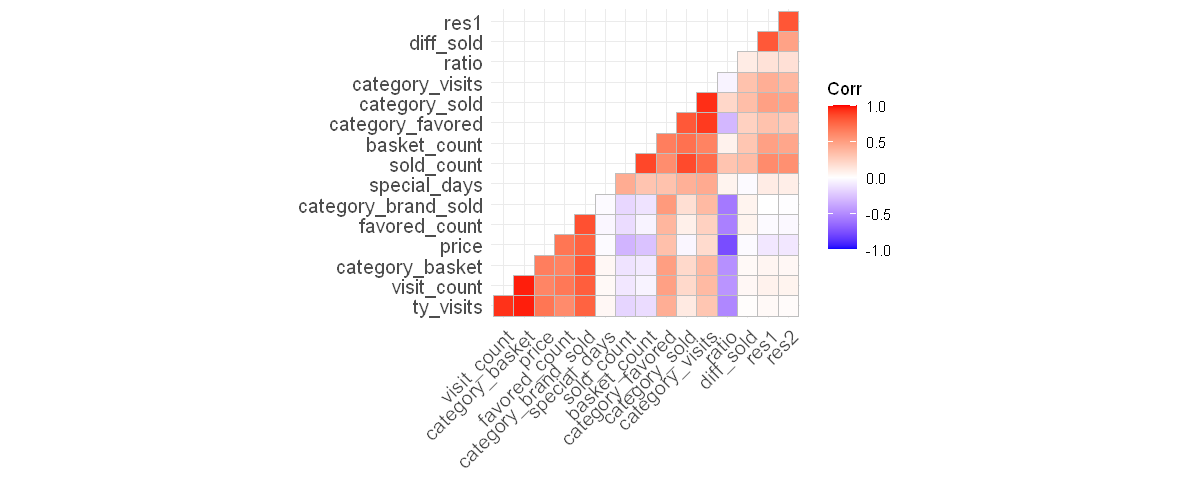

In [181]:
model_fakir_arimax <- arima(fakir_ts,order=c(1,1,4),xreg=fakir_train$diff_sold)
checkresiduals(model_fakir_arimax)
fakir_train$res2 <- model_fakir_arimax$residuals
corr <- cor(fakir_train[!is.na(fakir_train$price)& !is.na(fakir_train$res2),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals are more stationary now. We should apply the new model to the test period.

### Linear Models

Firstly, the days of week and trend columns will be added to the data. Next, the first model will be built with trend and weekly seasonality. Then, we'll look for possible regressors and add them to the model. Finally, we will find the best model among them. 

In [182]:
prod6[, `:=`(trend=1:.N, 
            days=wday(event_date, label=T))]

model6_1 <- lm(sold_count~trend+days, data=prod6)
summary(model6_1)


Call:
lm(formula = sold_count ~ trend + days, data = prod6)

Residuals:
    Min      1Q  Median      3Q     Max 
-44.570 -17.669  -8.300   3.405 269.865 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  50.93116    4.05183  12.570  < 2e-16 ***
trend        -0.05948    0.01903  -3.125  0.00192 ** 
days.L       -2.61311    5.36733  -0.487  0.62666    
days.Q      -13.07621    5.35764  -2.441  0.01514 *  
days.C       -0.12958    5.35285  -0.024  0.98070    
days^4        4.99462    5.34960   0.934  0.35111    
days^5        0.57142    5.33822   0.107  0.91481    
days^6        0.56163    5.32936   0.105  0.91613    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 38.78 on 360 degrees of freedom
Multiple R-squared:  0.04466,	Adjusted R-squared:  0.02609 
F-statistic: 2.404 on 7 and 360 DF,  p-value: 0.02045



	Breusch-Godfrey test for serial correlation of order up to 11

data:  Residuals
LM test = 221.5, df = 11, p-value < 2.2e-16


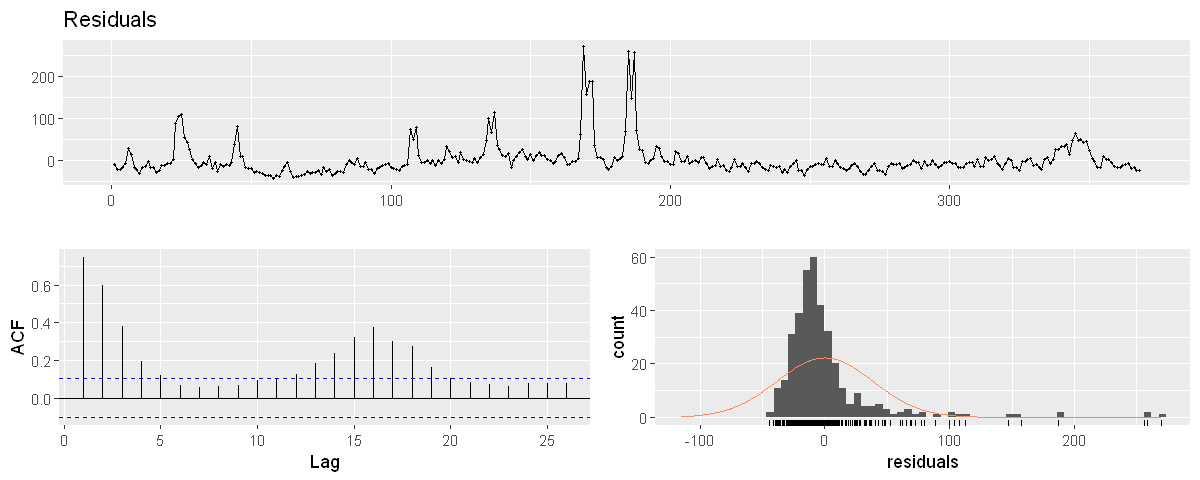

In [183]:
checkresiduals(model6_1)

* The first adjusted Rsqr value is 0.02609, which is actually very low. 
* The model's p value is small, which means that the model is meaningful. 
* The mean of the residuals is not zero. 
* The variance is not constant. 
* Residuals are not exactly normally distributed. 
* There are high autocorrelation values between the residuals. 

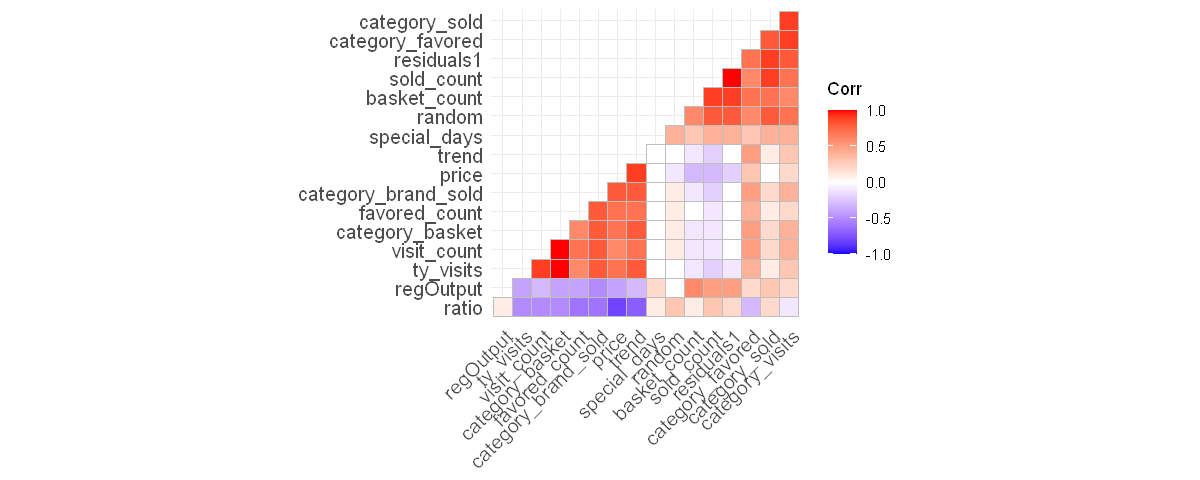

In [185]:
prod6[, residuals1:=model6_1$residuals]
corr <- round(cor(Filter(is.numeric, prod6)), 1)
ggcorrplot(corr, hc.order = TRUE,type = "lower")

As usual, the maximum correlation with residuals1 is obtained by basket_count. Therefore, its lagged version will be added to the model. To find the lag value, we'll check the CCF function. 

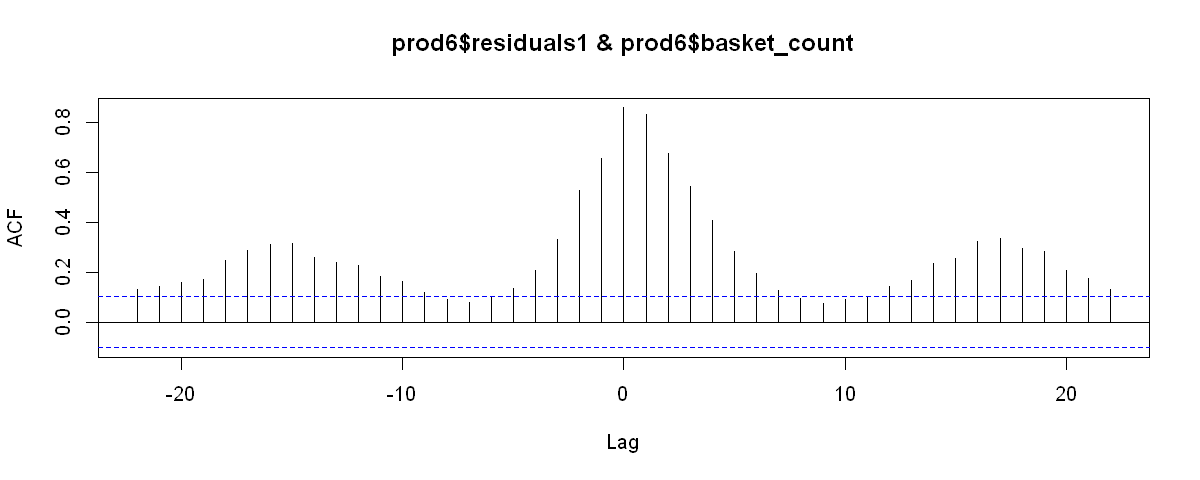

In [186]:
ccf(prod6$residuals1, prod6$basket_count)

In [187]:
model6_2 <- lm(sold_count~trend+days+shift(basket_count,1), data=prod6)
summary(model6_2)


Call:
lm(formula = sold_count ~ trend + days + shift(basket_count, 
    1), data = prod6)

Residuals:
     Min       1Q   Median       3Q      Max 
-109.873   -7.746   -1.099    6.125  138.879 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             3.426447   2.713588   1.263  0.20752    
trend                  -0.030138   0.010329  -2.918  0.00375 ** 
days.L                 -1.460099   2.891712  -0.505  0.61392    
days.Q                 -5.290561   2.894116  -1.828  0.06838 .  
days.C                  2.860463   2.885882   0.991  0.32226    
days^4                  3.629424   2.886902   1.257  0.20950    
days^5                 -3.167226   2.880009  -1.100  0.27219    
days^6                  3.501694   2.869863   1.220  0.22321    
shift(basket_count, 1)  0.285417   0.009591  29.760  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 20.86 on 358 degrees of freedom
  (1 observatio


	Breusch-Godfrey test for serial correlation of order up to 12

data:  Residuals
LM test = 43.261, df = 12, p-value = 2.04e-05


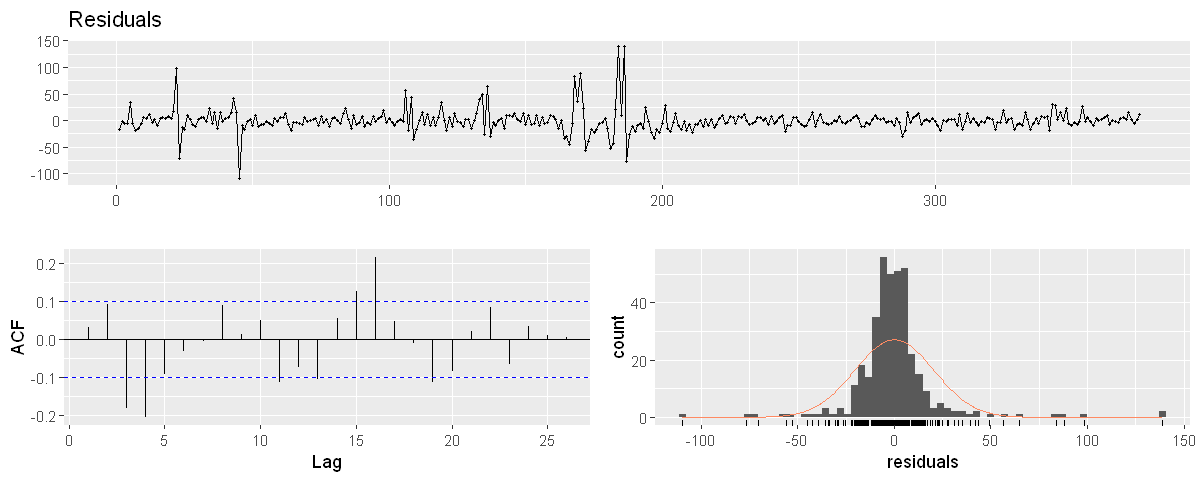

In [389]:
checkresiduals(model6_2)

* There is a high increase in the adjusted Rsqr value. It is increased to 0.7189. 
* The model's p value is small, which means that the model is meaningful. 
* The mean is zero. 
* The variance is not constant. 
* Residuals are still not exactly normally distributed. 
* There is a high autocorrelation at lag 16. 

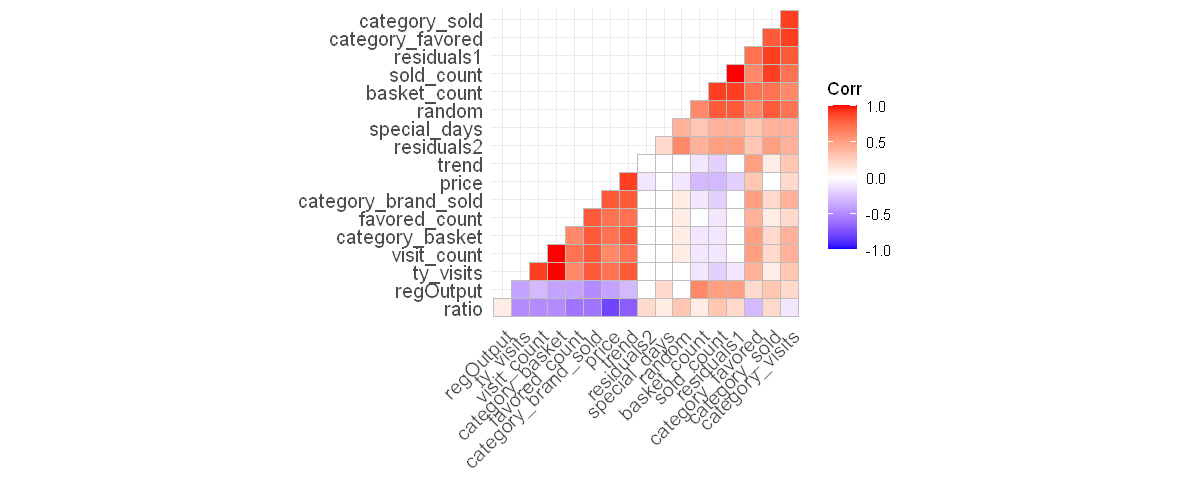

In [188]:
prod6[, residuals2:=c(NA, model6_2$residuals)]
corr <- round(cor(Filter(is.numeric, prod6[!is.na(prod6$residuals2)])), 1)
ggcorrplot(corr, hc.order = TRUE,type = "lower")

The maximum correlation with residuals2 is obtained by category_sold. Therefore, its lagged version will be added to the model. To find the lag value, we'll check the CCF function. 

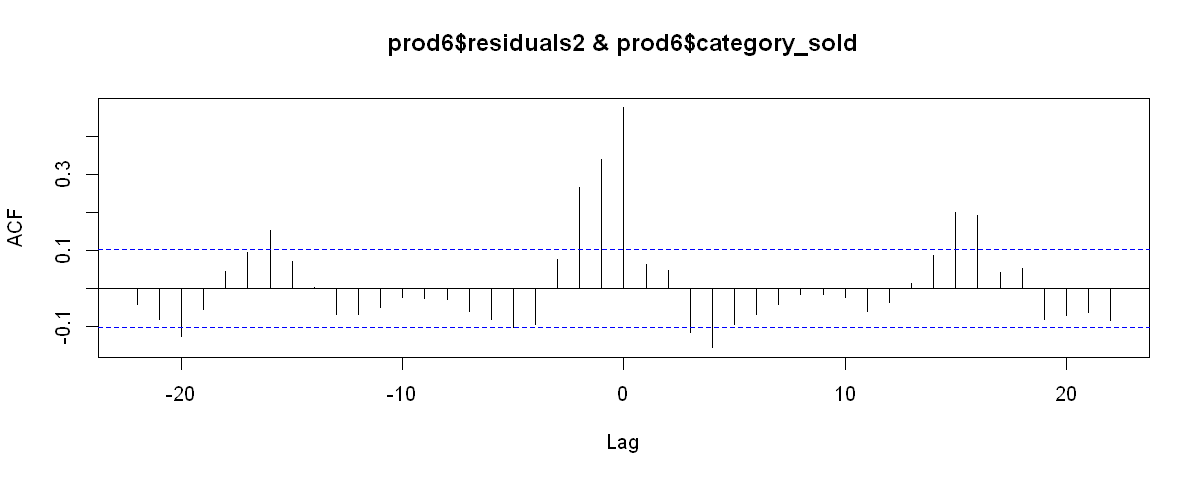

In [189]:
ccf(prod6$residuals2, prod6$category_sold, na.action=na.pass)

In [190]:
model6_3 <- lm(sold_count~trend+days+shift(basket_count,1)+shift(category_sold,1), data=prod6)
summary(model6_3)


Call:
lm(formula = sold_count ~ trend + days + shift(basket_count, 
    1) + shift(category_sold, 1), data = prod6)

Residuals:
     Min       1Q   Median       3Q      Max 
-105.922   -7.661   -0.903    5.732  143.119 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)              3.38581    2.70567   1.251  0.21162    
trend                   -0.03524    0.01070  -3.295  0.00108 ** 
days.L                  -2.17123    2.91111  -0.746  0.45625    
days.Q                  -4.93560    2.89255  -1.706  0.08882 .  
days.C                   3.28128    2.88719   1.136  0.25651    
days^4                   3.73207    2.87896   1.296  0.19570    
days^5                  -2.98193    2.87341  -1.038  0.30008    
days^6                   3.42658    2.86170   1.197  0.23195    
shift(basket_count, 1)   0.26721    0.01405  19.013  < 2e-16 ***
shift(category_sold, 1)  0.02147    0.01214   1.768  0.07799 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0


	Breusch-Godfrey test for serial correlation of order up to 13

data:  Residuals
LM test = 47.16, df = 13, p-value = 9.08e-06


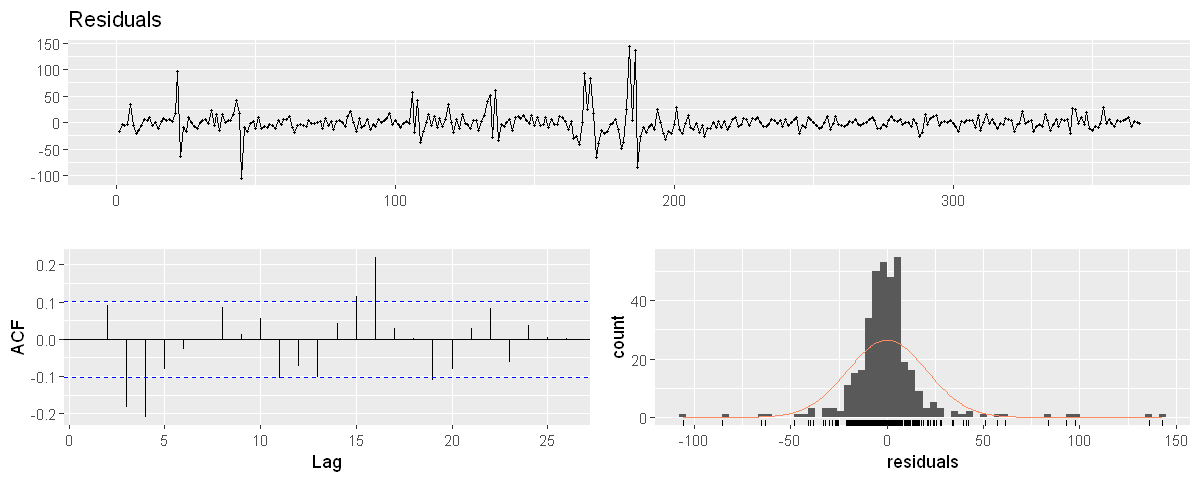

In [191]:
checkresiduals(model6_3)

The adjusted Rsqr value is slightly increased to 0.7206. Because the increase is too low to add a new attribute to the model, we'll drop it. Next, let's check if the residuals2 is related with the lagged version of the input variable. 

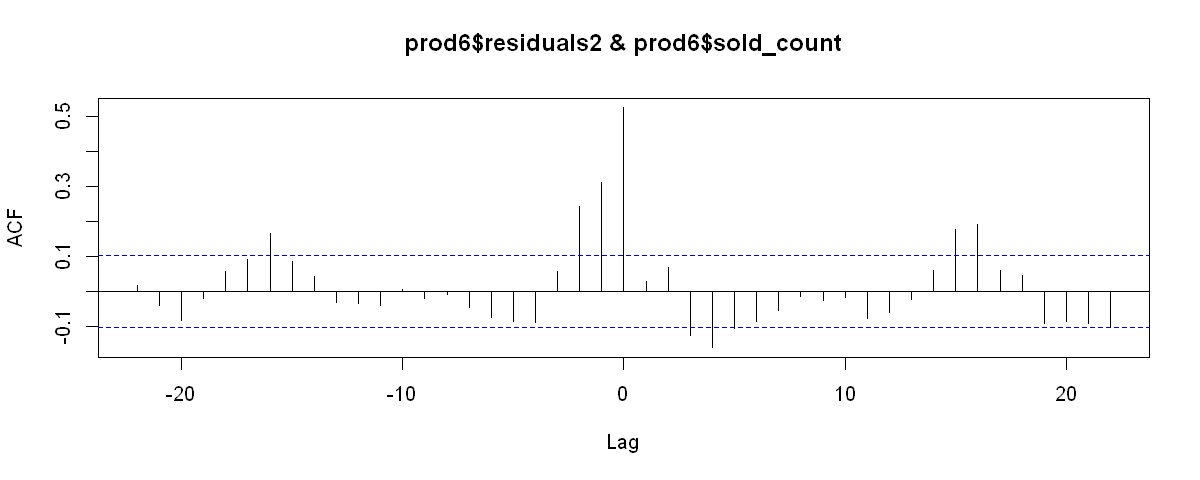

In [192]:
ccf(prod6$residuals2, prod6$sold_count, na.action=na.pass)

In [194]:
model6_4 <- lm(sold_count~trend+days+shift(basket_count,1)+shift(sold_count,1), data=prod6)
summary(model6_4)


Call:
lm(formula = sold_count ~ trend + days + shift(basket_count, 
    1) + shift(sold_count, 1), data = prod6)

Residuals:
     Min       1Q   Median       3Q      Max 
-107.096   -7.771   -1.095    5.797  142.149 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             3.30374    2.71442   1.217  0.22437    
trend                  -0.02831    0.01045  -2.711  0.00704 ** 
days.L                 -2.02811    2.93201  -0.692  0.48957    
days.Q                 -5.12895    2.89617  -1.771  0.07742 .  
days.C                  3.09388    2.89164   1.070  0.28537    
days^4                  3.73696    2.88707   1.294  0.19637    
days^5                 -2.99147    2.88271  -1.038  0.30010    
days^6                  3.36127    2.87112   1.171  0.24249    
shift(basket_count, 1)  0.26603    0.01935  13.749  < 2e-16 ***
shift(sold_count, 1)    0.06604    0.05724   1.154  0.24941    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' 

The adjusted Rsqr value is slightly decreased to 0.7192. Because it decreases, we'll drop it. Therefore, the last model is the second one which is model6_2.

Warning message:
"Removed 1 rows containing missing values (geom_point)."

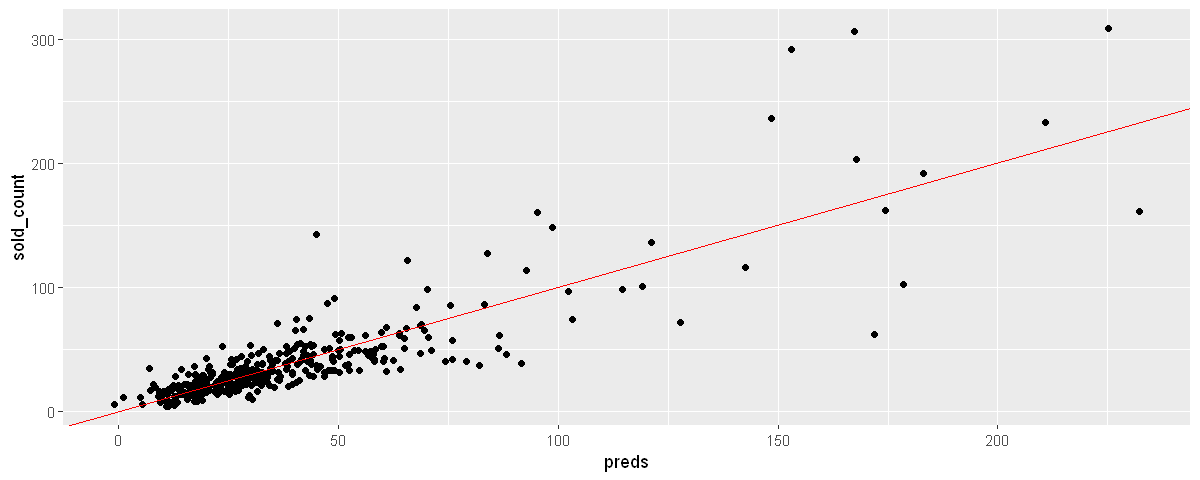

In [195]:
prod6[, preds:=c(NA,model6_2$fitted.values)]
ggplot(prod6, aes(x=preds, y=sold_count)) + geom_point() + geom_abline(intercept=0, slope=1, color="red")

### Forecasting

In [463]:
forecast_data_fakir <- data.table(event_date=fakir[event_date>=test_start&event_date<=test_end,]$event_date,
                            sold_count=fakir[event_date>=test_start&event_date<=test_end,]$sold_count)
fakir[,`:=`(trend=1:.N,
           days=wday(event_date, label=T))]
arima_fc <- numeric(0)
arimax_fc <- numeric(0)
reg_fc <- numeric(0)
for(i in 1:length(test_dates)){
  
  train_dt <- fakir[event_date<test_dates[i],]
  model_arima <- arima(train_dt$sold_count,order=c(1,1,4))
  model_arimax <- Arima(train_dt$sold_count,order=c(1,1,4),xreg=train_dt$diff_sold)
  model_reg <- lm(sold_count~trend+days+shift(basket_count,1)+shift(sold_count,1), data=train_dt)
  newreg <- forecast(auto.arima(train_dt$diff_sold),h=1)$mean[1]
  arima_temp <- forecast(model_arima)
  arimax_temp <- forecast(model_arimax,xreg=newreg)
  reg_temp <- predict(model_reg,newdata=fakir[event_date %in% c(test_dates[i],test_dates[i+1])])
  arima_fc <- c(arima_fc,arima_temp$mean[1])
  arimax_fc <- c(arimax_fc,arimax_temp$mean[1])
  reg_fc <- c(reg_fc,reg_temp)
  
}
reg_fc[is.na(reg_fc)] <- mean(reg_fc[!is.na(reg_fc)])
forecast_data_fakir <- forecast_data_fakir[,`:=`(arima_p=arima_fc,
                                               arimax_p=arimax_fc,
                                               reg_p=reg_fc[c(1,seq(2,28,2))])]
accu(forecast_data_fakir$sold_count,forecast_data_fakir$arima_p)
accu(forecast_data_fakir$sold_count,forecast_data_fakir$arimax_p)
accu(forecast_data_fakir[1:(.N-1)]$sold_count,forecast_data_fakir[2:.N]$reg_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
15,20.2,7.598872,0.3761818,-0.1087871,0.3152798,7.225078,5.771497,0.2857177,0.2857177


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
15,20.2,7.598872,0.3761818,0.544272,1.255578,33.04825,19.53245,0.9669529,0.9669529


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
14,20.71429,7.609999,0.3673793,0.2171758,0.264644,6.361172,5.228302,0.2524008,0.2524008


In [467]:
result_data_fakir <- data.table(event_date=fakir[event_date>=result_start&event_date<=result_end,]$event_date,
                               sold_count=fakir[event_date>=result_start&event_date<=result_end,]$sold_count)
final_fc <- numeric(0)
for(i in 1:length(result_dates)){
  
  train_dt <- fakir[event_date<result_dates[i],]
  model_final <- lm(sold_count~trend+days+shift(basket_count, 1)+shift(sold_count, 1), data=train_dt)
  final_temp <- predict(model_final,newdata=fakir[event_date %in% c(result_dates[i],result_dates[i+1])])
  final_fc <- c(final_fc,final_temp)
  
}
final_fc[is.na(final_fc)] <- mean(final_fc[!is.na(final_fc)])
result_data_fakir <- result_data_fakir[,`:=`(final_p=final_fc[c(1,seq(2,28,2))])]
accu(result_data_fakir[1:(.N-1)]$sold_count,result_data_fakir[2:.N]$final_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
14,11.85714,5.216205,0.4399209,0.4678085,0.6917984,6.973269,6.248761,0.5270039,0.5270039


In [466]:
result_data_fakir <- data.table(event_date=fakir[event_date>=result_start&event_date<=result_end,]$event_date,
                               sold_count=fakir[event_date>=result_start&event_date<=result_end,]$sold_count)
final_fc <- numeric(0)
for(i in 1:length(result_dates)){
  
  train_dt <- fakir[event_date<result_dates[i],]
  model_final <- arima(train_dt$sold_count,order=c(1,1,4))
  final_temp <- forecast(model_final)
  final_fc <- c(final_fc,final_temp$mean[1])
  
}
result_data_fakir <- result_data_fakir[,`:=`(final_p=final_fc)]
accu(result_data_fakir$sold_count,result_data_fakir$final_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
15,11.6,5.124172,0.441739,-0.2790102,0.8240115,6.241798,5.252488,0.4528007,0.4528007


In [468]:
data.frame(event_date=result_data_fakir$event_date,
           sold_count=result_data_fakir$sold_count,
           predictions=result_data_fakir$final_p)

event_date,sold_count,predictions
2021-06-12,17,6.3102706
2021-06-13,19,13.5605705
2021-06-14,15,13.3960734
2021-06-15,15,16.7678286
2021-06-16,18,7.0958760
2021-06-17,8,9.1104323
2021-06-18,16,0.2006896
2021-06-19,7,3.4685854
2021-06-20,14,2.3142025
2021-06-21,10,5.8268957


### Xiaomi Bluetooth Kulaklık

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


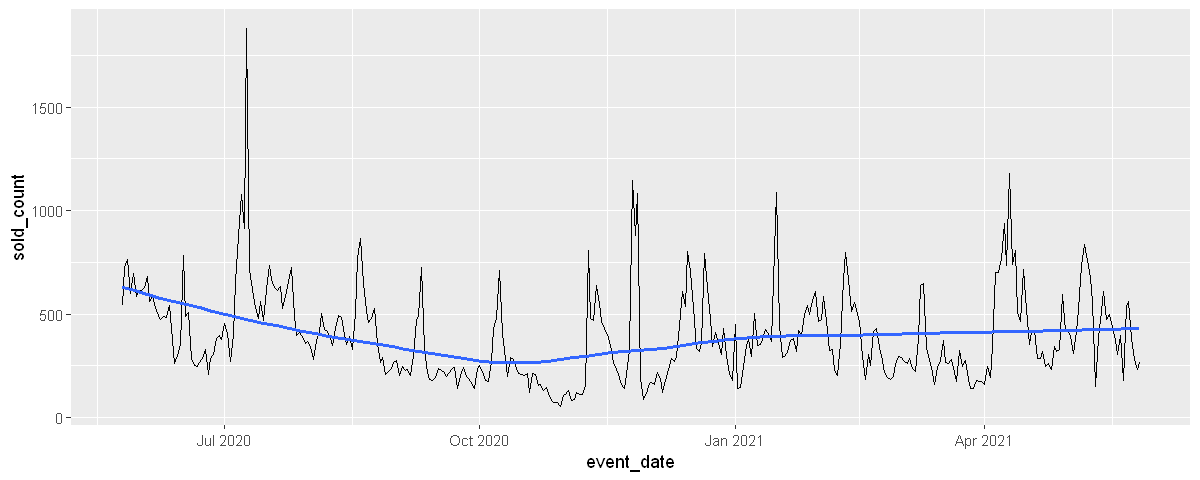

In [196]:
ggplot(prod5, aes(x=event_date, y=sold_count)) + geom_line() + geom_smooth(se=F)

* The mean changes over time. 
* The variance seems to be constant. 
* At the beginning of the July 2020, the highest sale value has been reached. 
* It appears that the data is not stationary due to the non-constant mean. 

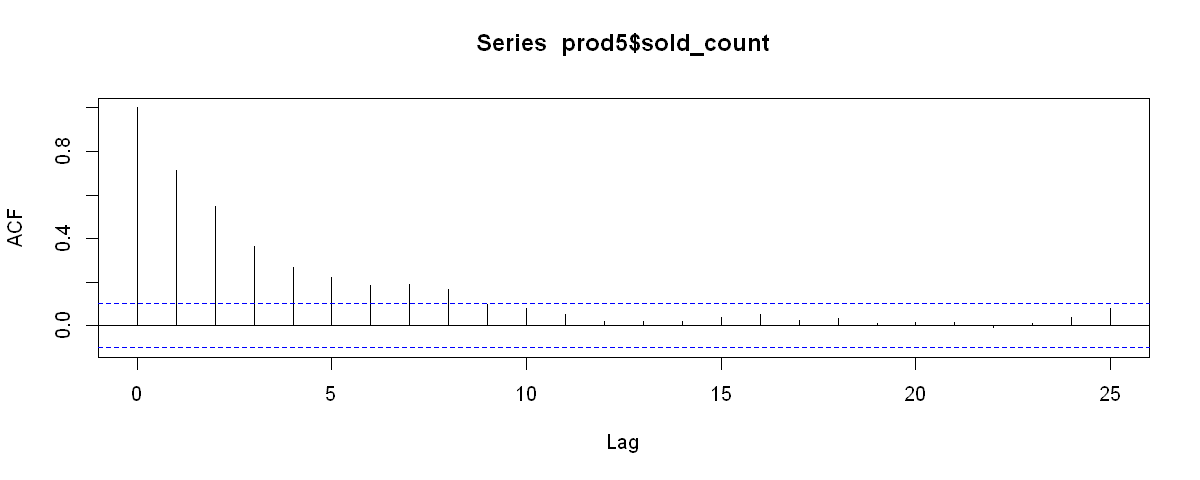

In [197]:
acf(prod5$sold_count)

From the ACF graph, there is a trend. Also, there is a little increase at lag 7, which may lead to weekly seasonality. 

### Weekly Decomposition

The variance stays same over time, so additive decomposition will be used again. 

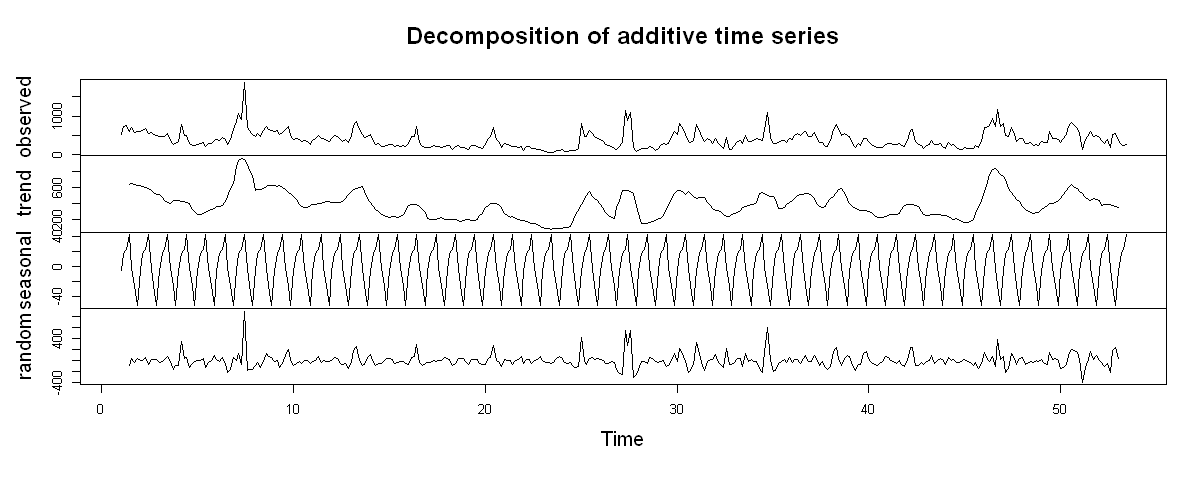

In [198]:
prod5_weekly_dec <- decompose(ts(prod5$sold_count, freq=7), type="additive")
plot(prod5_weekly_dec)

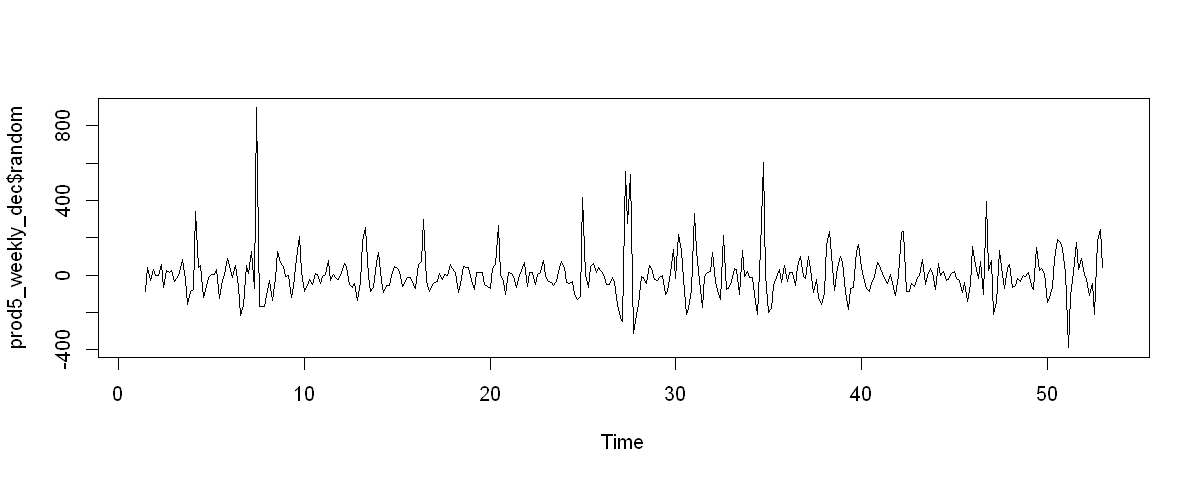

In [199]:
plot(prod5_weekly_dec$random)

* The variance slightly changes over time. 
* The mean seems is constant over time. 

In [200]:
u_test <- ur.kpss(prod5_weekly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0149 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


From the test result above, we can say that the data is stationary. 

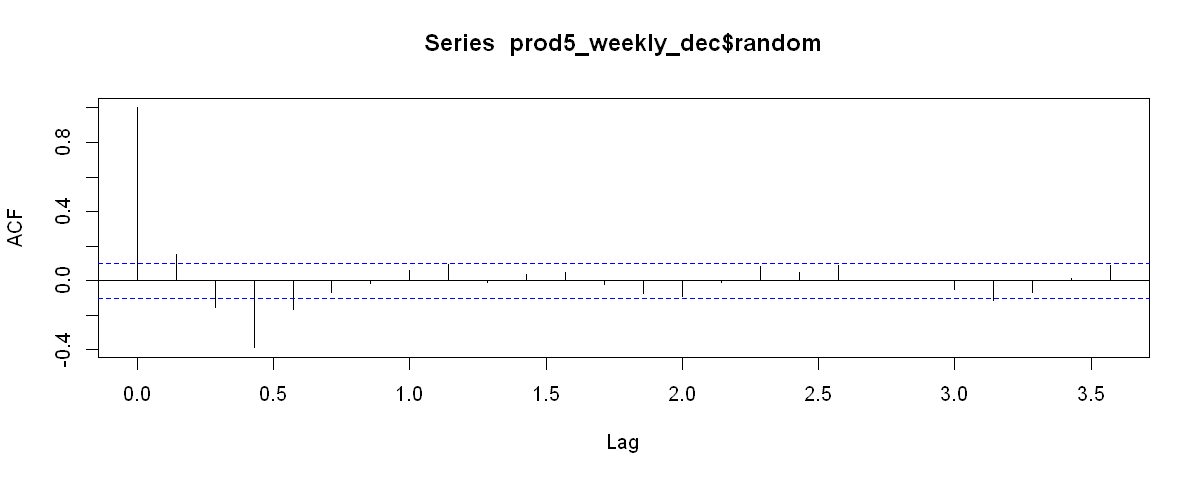

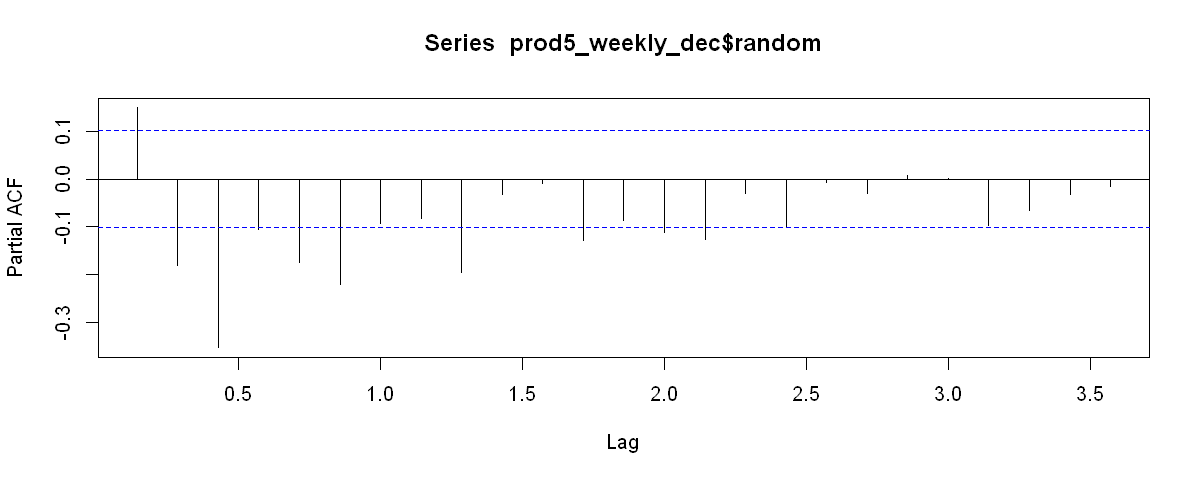

In [201]:
acf(prod5_weekly_dec$random, na.action=na.pass)
pacf(prod5_weekly_dec$random, na.action=na.pass)

From the ACF, the high correlation at lag 3 is seen. Also there is a sinus wave on the ACF graph. The high correlation at lag 3 also can be seen on the PACF graph. 

### Monthly Decomposition

month,sold_count
2020 May,4515
2020 Jun,12746
2020 Jul,19116
2020 Aug,12981
2020 Sep,7565
2020 Oct,6917
2020 Nov,10553
2020 Dec,11358
2021 Jan,12948
2021 Feb,10668


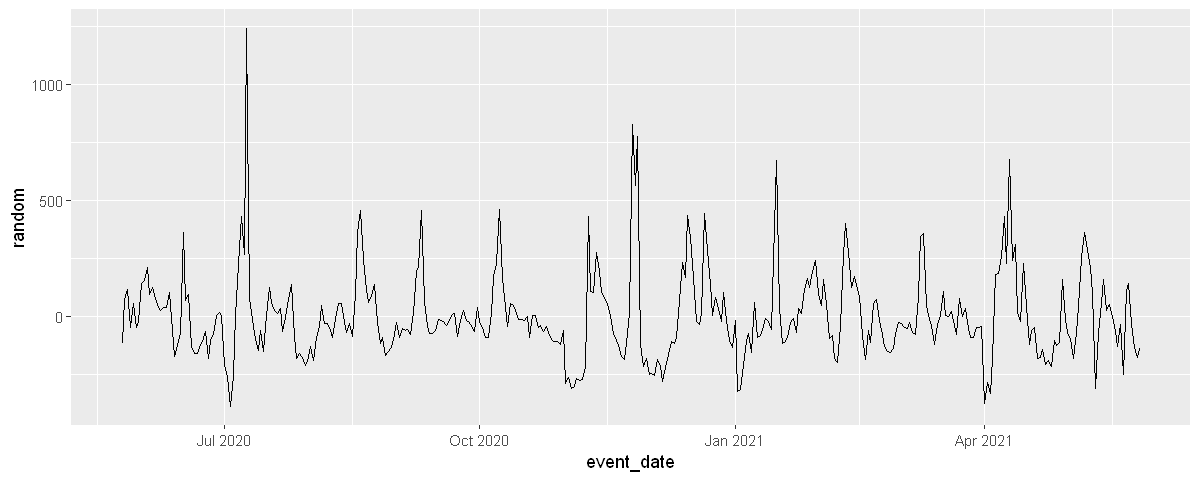

In [202]:
prod5_monthly <- prod5[, month:=yearmonth(event_date)]
prod5_monthly[, .(sold_count=sum(sold_count)), by=month]
prod5_monthly[, trend:=1:.N]

prod5_reg <- lm(sold_count~trend+as.factor(month), data=prod5_monthly)
prod5_monthly[, regOutput:=predict(prod5_reg, prod5_monthly)]

prod5_monthly[, random:=sold_count-regOutput]

ggplot(prod5_monthly, aes(x=event_date, y=random)) + geom_line()

* Although there are jumping and falling points, the variance seems to be constant. 
* It can be said that the mean is also constant. 

In [203]:
u_test <- ur.kpss(prod5_monthly$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0178 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


We cannot reject the null hyphothesis which means that the data is stationary. 

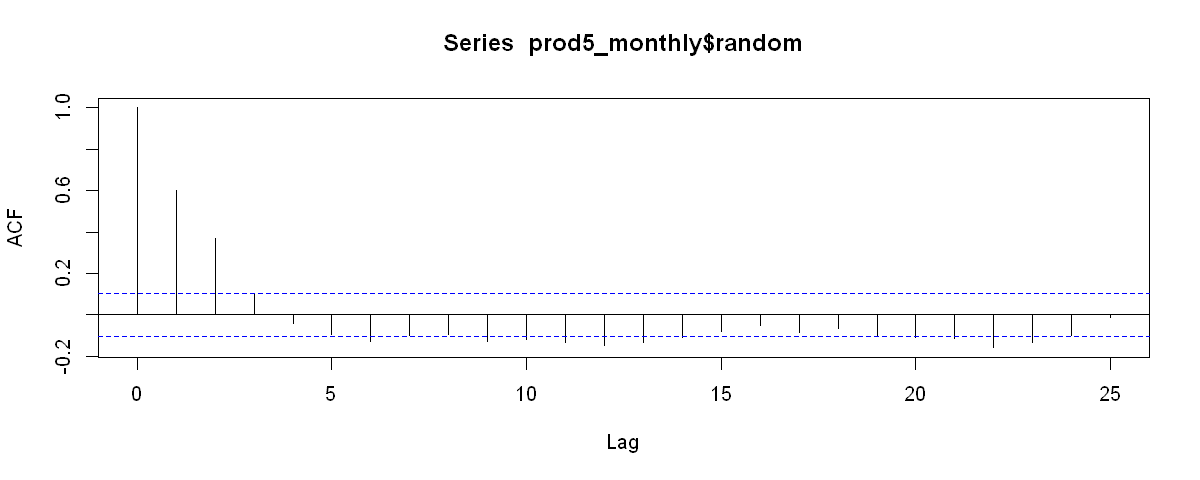

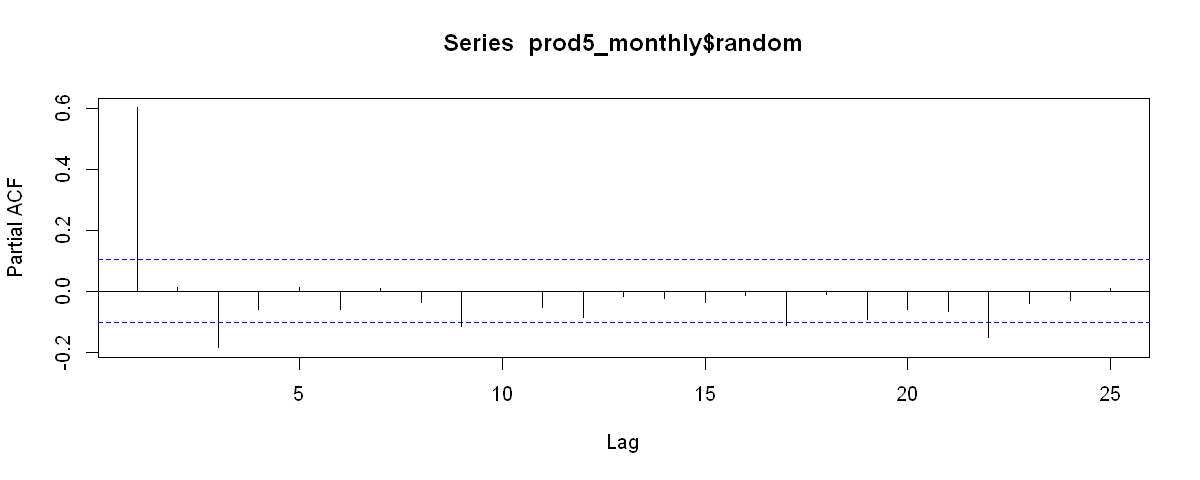

In [204]:
acf(prod5_monthly$random)
pacf(prod5_monthly$random)

At lag 1, there is correlation. Differencing may be required. 

### Building an ARIMA Model

In [205]:
xaomi <- data[product_content_id=="6676673",][order(event_date)]
xaomi_train <- xaomi[event_date<test_start,]
xaomi_ts <- ts(xaomi_train$sold_count,freq=7)

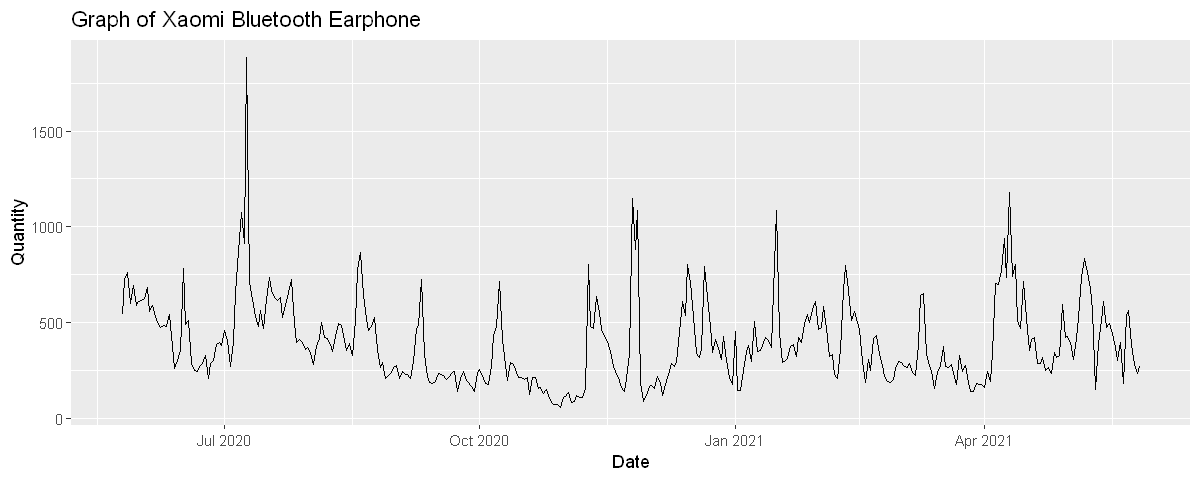

In [206]:
ggplot(xaomi_train,aes(x=event_date,y=sold_count)) + geom_line() +
  labs(title= "Graph of Xaomi Bluetooth Earphone", x= "Date", y="Quantity")

Xaomi sold_count series is not stationary due to the non constant mean and variance.

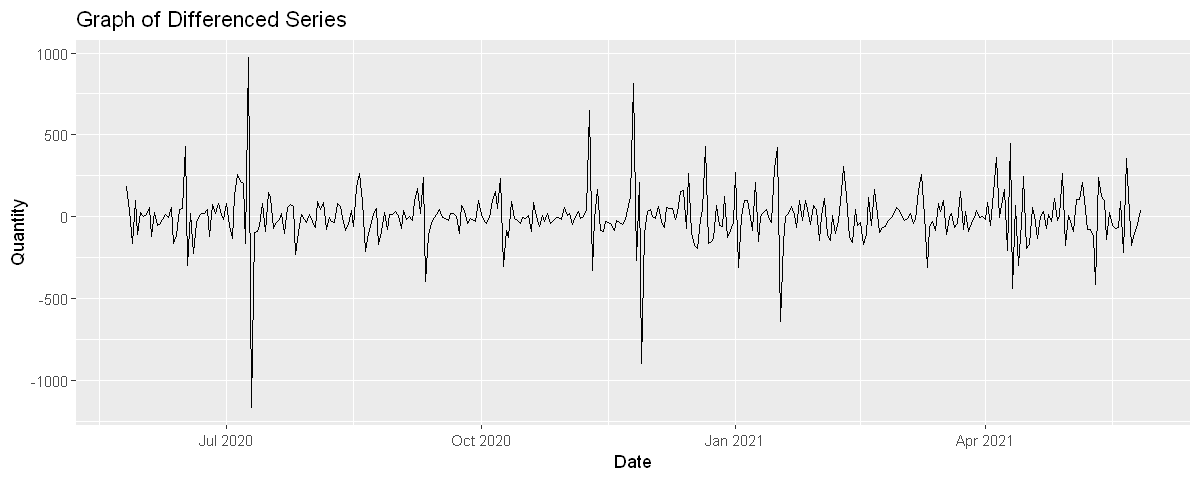

In [207]:
ggplot(xaomi_train[2:.N,],aes(x=event_date)) + geom_line(aes(y=diff(xaomi_train$sold_count,1))) + 
  labs(title= "Graph of Differenced Series", x= "Date", y="Quantity")

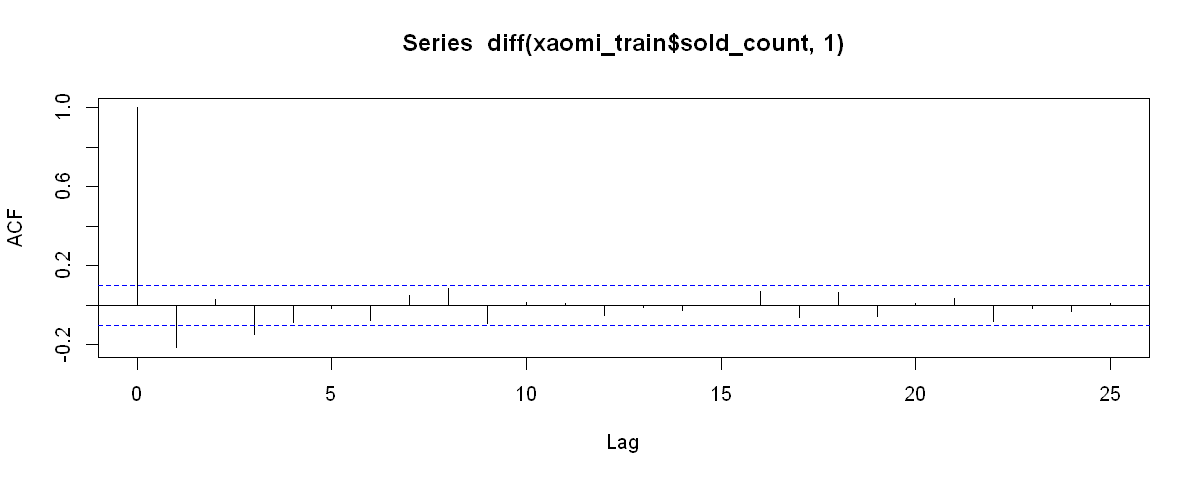

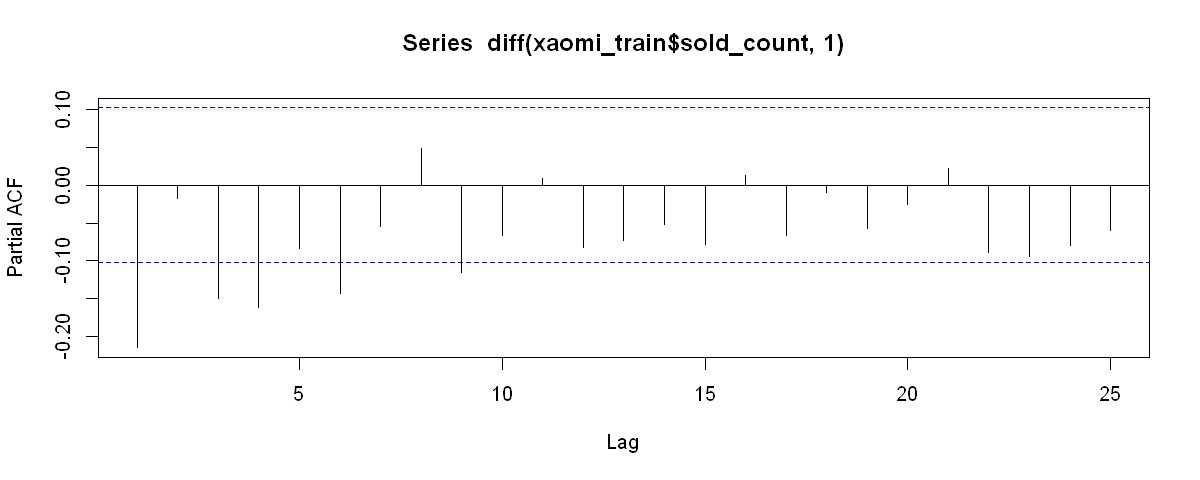

In [208]:
acf(diff(xaomi_train$sold_count,1))
pacf(diff(xaomi_train$sold_count,1))

At the decomposition step, it was said that the data has weekly seasonality. We could build a SARIMA model. ACF graphs has spikes at lag 1 and 3. Also, PACF graph has spikes at lag 1,3,4 and 9. We could try these parameters on a SARIMA model.

In [209]:
arima(xaomi_ts,order=c(1,1,1),seasonal=c(2,0,0))


Call:
arima(x = xaomi_ts, order = c(1, 1, 1), seasonal = c(2, 0, 0))

Coefficients:
         ar1      ma1    sar1     sar2
      0.6823  -0.9777  0.0661  -0.0317
s.e.  0.0452   0.0165  0.0536   0.0534

sigma^2 estimated as 23482:  log likelihood = -2368.26,  aic = 4746.52

In [210]:
arima(xaomi_ts,order=c(3,1,1),seasonal=c(2,0,0))


Call:
arima(x = xaomi_ts, order = c(3, 1, 1), seasonal = c(2, 0, 0))

Coefficients:
         ar1     ar2      ar3      ma1    sar1     sar2
      0.6384  0.1506  -0.1314  -0.9738  0.0834  -0.0415
s.e.  0.0538  0.0615   0.0535   0.0179  0.0541   0.0538

sigma^2 estimated as 22981:  log likelihood = -2364.31,  aic = 4742.62

In [211]:
arima(xaomi_ts,order=c(3,1,3),seasonal=c(2,0,0))


Call:
arima(x = xaomi_ts, order = c(3, 1, 3), seasonal = c(2, 0, 0))

Coefficients:
          ar1      ar2     ar3      ma1      ma2      ma3    sar1     sar2
      -0.2444  -0.0401  0.4721  -0.0861  -0.1078  -0.7521  0.0788  -0.0335
s.e.   0.1829   0.1376  0.1151   0.1693   0.1505   0.1179  0.0596   0.0563

sigma^2 estimated as 22719:  log likelihood = -2362.28,  aic = 4742.57

In [212]:
arima(xaomi_ts,order=c(1,1,3),seasonal=c(2,0,0))


Call:
arima(x = xaomi_ts, order = c(1, 1, 3), seasonal = c(2, 0, 0))

Coefficients:
         ar1      ma1     ma2      ma3    sar1     sar2
      0.5746  -0.9060  0.1249  -0.1867  0.0801  -0.0388
s.e.  0.1001   0.1081  0.0759   0.0688  0.0540   0.0534

sigma^2 estimated as 22970:  log likelihood = -2364.22,  aic = 4742.45

In [213]:
auto.arima(xaomi_ts)

Series: xaomi_ts 
ARIMA(3,0,0)(0,0,1)[7] with non-zero mean 

Coefficients:
         ar1     ar2      ar3    sma1      mean
      0.6566  0.1582  -0.1179  0.0979  393.0930
s.e.  0.0518  0.0617   0.0526  0.0549   28.3416

sigma^2 estimated as 23169:  log likelihood=-2369.37
AIC=4750.74   AICc=4750.97   BIC=4774.18

The best model is SARIMA(1,1,3)(2,0,0) with the AIC value of 4742.45.


	Ljung-Box test

data:  Residuals from ARIMA(1,1,3)(2,0,0)[7]
Q* = 7.85, df = 8, p-value = 0.4483

Model df: 6.   Total lags used: 14



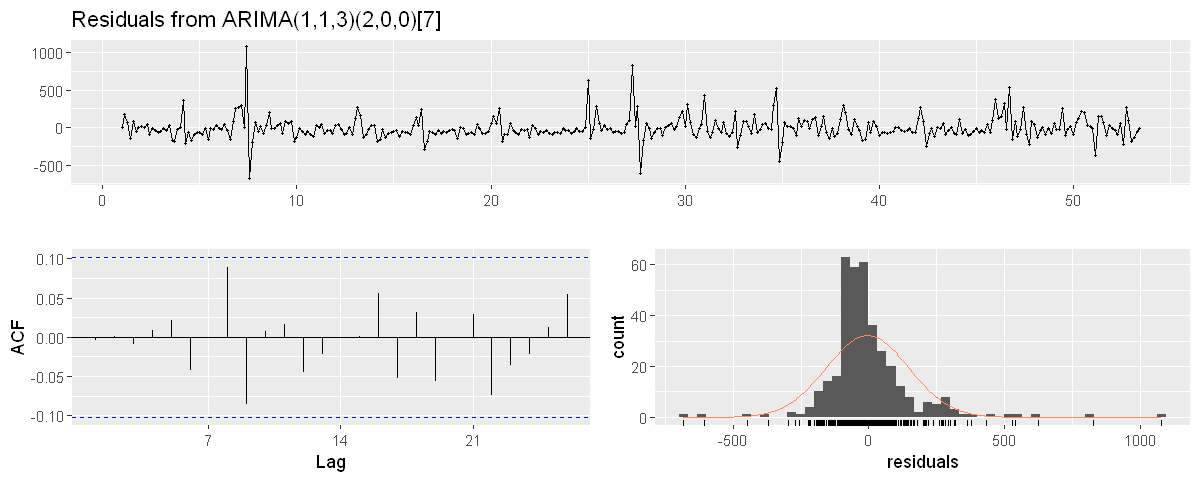

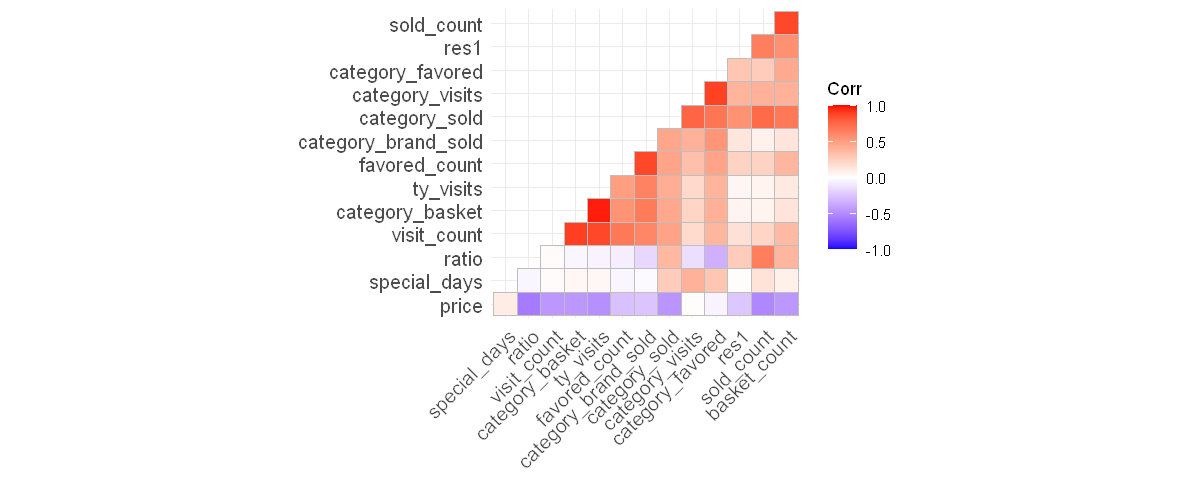

In [214]:
model_xaomi_sarima <- arima(xaomi_ts,order=c(1,1,3),seasonal=c(2,0,0))
checkresiduals(model_xaomi_sarima)
xaomi_train$res1 <- model_xaomi_sarima$residuals
corr <- cor(xaomi_train[!is.na(xaomi_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")


Residuals have a constant mean at 0. They are not correlated and they have nearly constant variance. Although the distribution seems normal, histogram is right skewed. Residuals are correlated with category_sold.

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


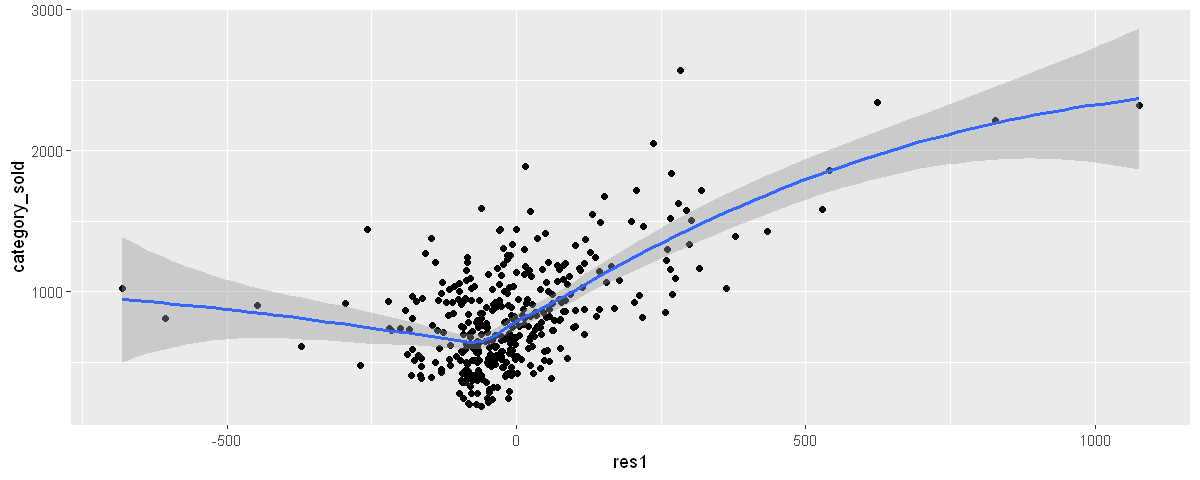

In [215]:
ggplot(xaomi_train,aes(x=res1,y=category_sold)) +  geom_point() + geom_smooth()

In [216]:
cor(xaomi_train$res1,xaomi_train$category_sold)

[1] 0.5568635

The correlation seems to be linear with 0.544, there is no need to transform the data. We could add it as a regressor.


	Ljung-Box test

data:  Residuals from ARIMA(1,1,3)(2,0,0)[7]
Q* = 9.7366, df = 7, p-value = 0.204

Model df: 7.   Total lags used: 14



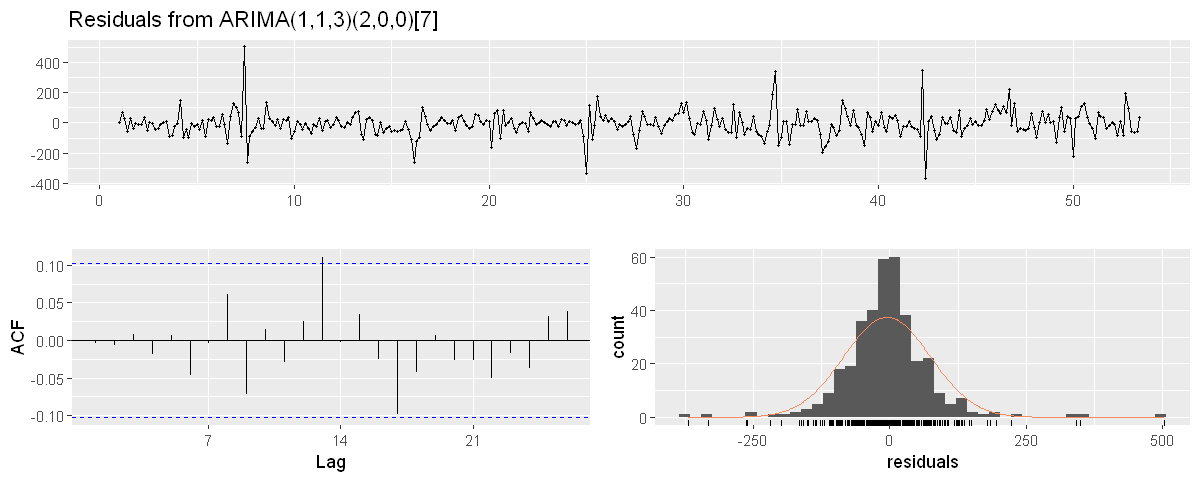

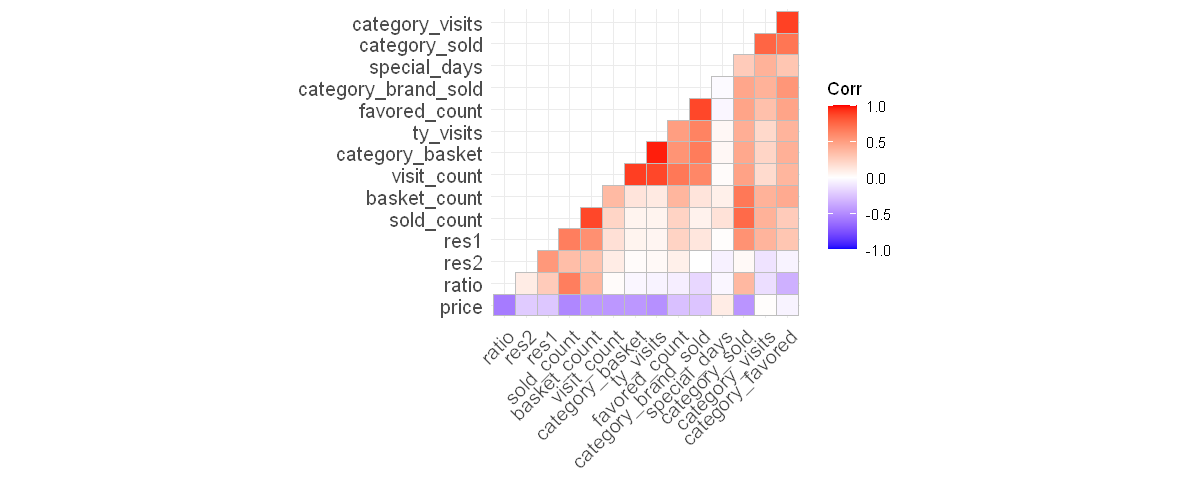

In [217]:
model_xaomi_sarimax <- arima(xaomi_ts,order=c(1,1,3),seasonal=c(2,0,0),xreg=xaomi_train$category_sold)
checkresiduals(model_xaomi_sarimax)
xaomi_train$res2 <- model_xaomi_sarimax$residuals
corr <- cor(xaomi_train[!is.na(xaomi_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals seems more stationart and also right skew of the histogram is gone. We could use this SARIMAX model in the forecasting.

### Linear Models

As we did above, firstly, the days of week and trend columns will be added to the data. Next, the first model will be built with trend and weekly seasonality. Then, we'll look for possible regressors and add them to the model. Finally, we will find the best model among them. 

In [218]:
prod5[, `:=`(trend=1:.N, 
            days=wday(event_date, label=T))]

model5_1 <- lm(sold_count~trend+days, data=prod5)
summary(model5_1)


Call:
lm(formula = sold_count ~ trend + days, data = prod5)

Residuals:
    Min      1Q  Median      3Q     Max 
-368.91 -153.74  -48.38  111.42 1422.51 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 428.2984    22.8005  18.785   <2e-16 ***
trend        -0.1927     0.1071  -1.800   0.0727 .  
days.L       21.9522    30.2032   0.727   0.4678    
days.Q      -71.9353    30.1486  -2.386   0.0175 *  
days.C        0.3802    30.1217   0.013   0.9899    
days^4        0.9028    30.1034   0.030   0.9761    
days^5       13.5253    30.0394   0.450   0.6528    
days^6       12.3026    29.9895   0.410   0.6819    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 218.2 on 360 degrees of freedom
Multiple R-squared:  0.02657,	Adjusted R-squared:  0.007643 
F-statistic: 1.404 on 7 and 360 DF,  p-value: 0.2025


The p value of the model is high. The model is meaningless. Trend and days are not significant for predicting sold_count of prod5. 

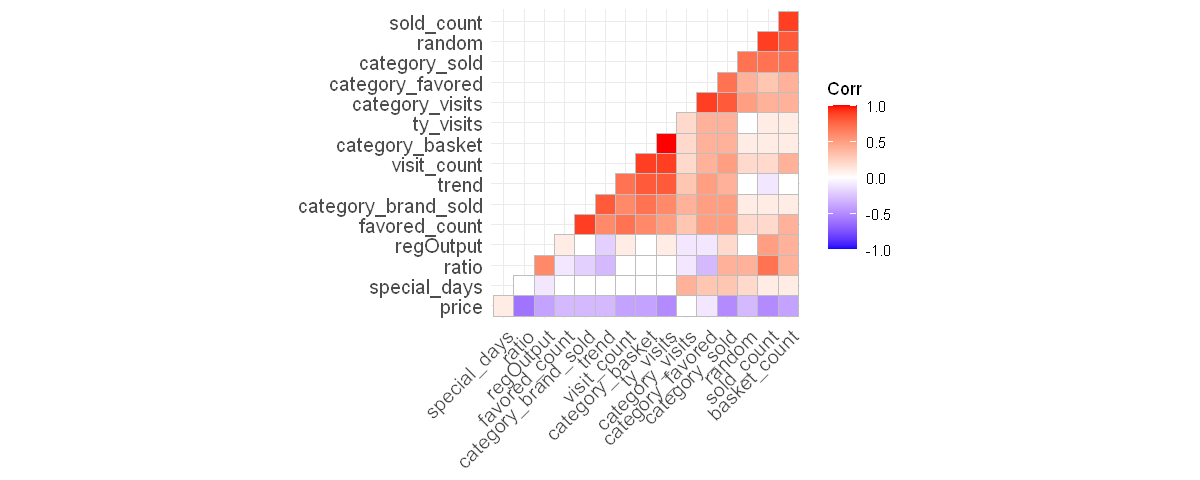

In [219]:
corr <- round(cor(Filter(is.numeric, prod5)), 1)
ggcorrplot(corr, hc.order = TRUE,type = "lower")

The maximum correlation with sold_count is obtained by basket_count. Therefore, its lagged version will be added to the model. To find the lag value, we'll check the CCF function. 

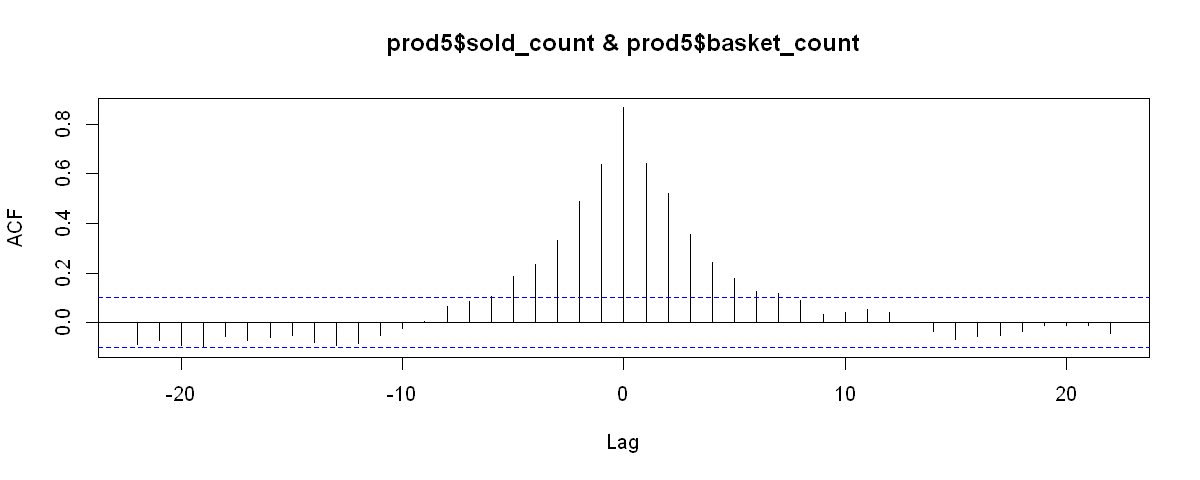

In [220]:
ccf(prod5$sold_count, prod5$basket_count)

In [222]:
model5_2 <- lm(sold_count~shift(basket_count,1), data=prod5)
summary(model5_2)


Call:
lm(formula = sold_count ~ shift(basket_count, 1), data = prod5)

Residuals:
    Min      1Q  Median      3Q     Max 
-599.36  -95.60  -20.52   76.95 1230.14 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            109.51362   19.65421   5.572  4.9e-08 ***
shift(basket_count, 1)   0.18288    0.01137  16.090  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 167.9 on 365 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.4149,	Adjusted R-squared:  0.4133 
F-statistic: 258.9 on 1 and 365 DF,  p-value: < 2.2e-16



	Breusch-Godfrey test for serial correlation of order up to 10

data:  Residuals
LM test = 58.421, df = 10, p-value = 7.203e-09


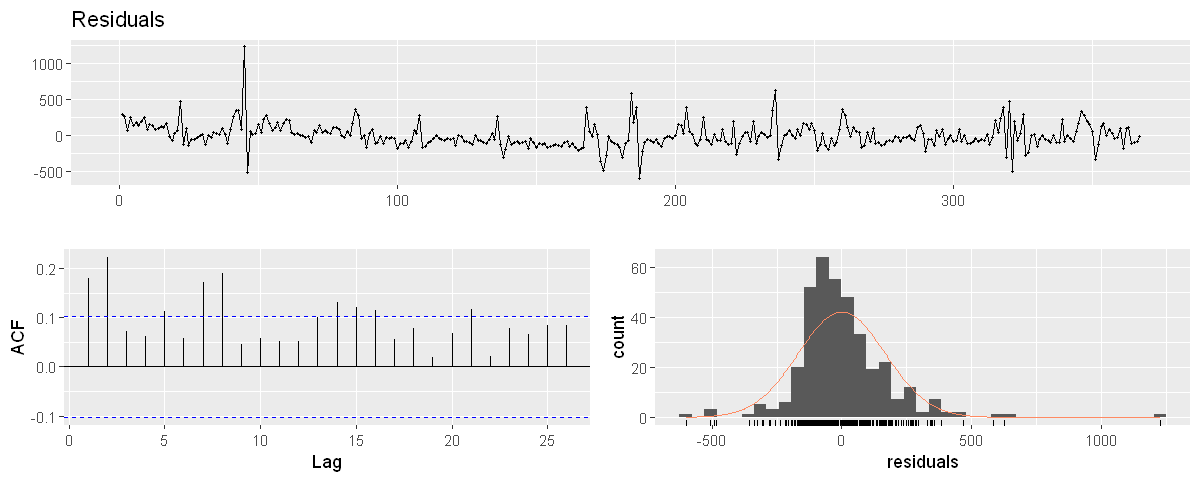

In [223]:
checkresiduals(model5_2)

* The adjusted Rsqr value is 0.4133. 
* The model's p value is small, which means that the model is meaningful. 
* The mean is not zero. 
* The variance is not constant. 
* Residuals are not exactly normally distributed. 
* There are autocorrelations between the residuals. 

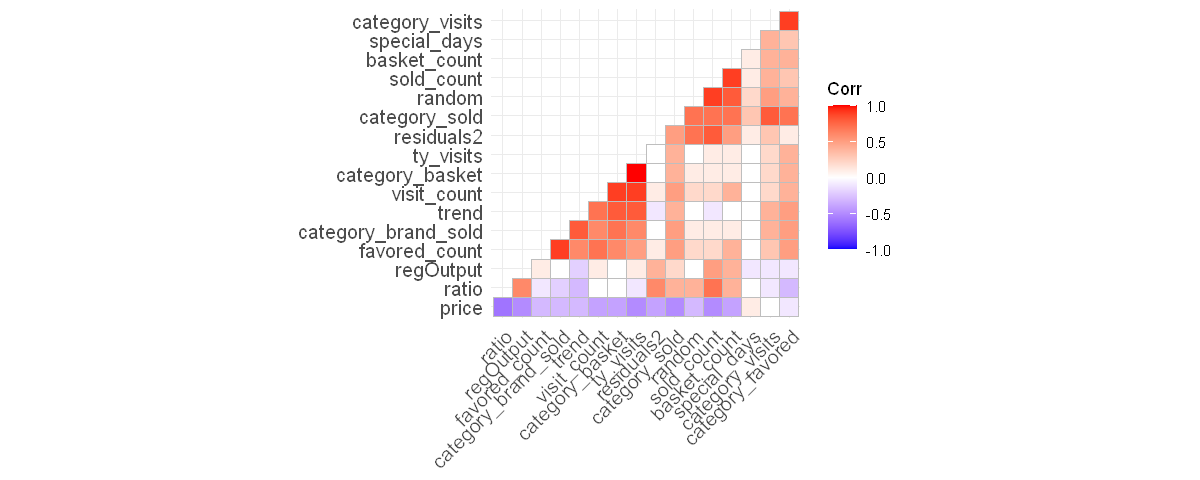

In [225]:
prod5[, residuals2:=c(NA, model5_2$residuals)]
corr <- round(cor(Filter(is.numeric, prod5[!is.na(prod5$residuals2)])), 1)
ggcorrplot(corr, hc.order = TRUE,type = "lower")

Price may improve the model. Let's try to add it to the model. 

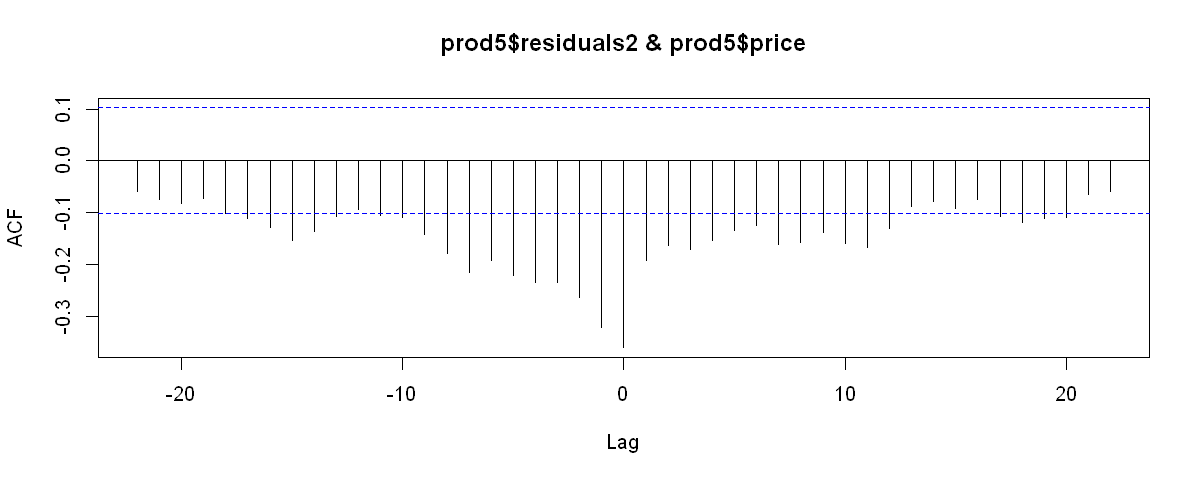

In [226]:
ccf(prod5$residuals2, prod5$price, na.action=na.pass)

In [227]:
model5_3 <- lm(sold_count~shift(basket_count,1)+shift(price,1), data=prod5)
summary(model5_3)


Call:
lm(formula = sold_count ~ shift(basket_count, 1) + shift(price, 
    1), data = prod5)

Residuals:
    Min      1Q  Median      3Q     Max 
-525.98  -96.86  -18.84   66.54 1206.46 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            588.06073  114.54065   5.134 4.63e-07 ***
shift(basket_count, 1)   0.15925    0.01243  12.809  < 2e-16 ***
shift(price, 1)         -3.22318    0.76054  -4.238 2.86e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 164.2 on 364 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.4425,	Adjusted R-squared:  0.4394 
F-statistic: 144.4 on 2 and 364 DF,  p-value: < 2.2e-16



	Breusch-Godfrey test for serial correlation of order up to 10

data:  Residuals
LM test = 46.235, df = 10, p-value = 1.3e-06


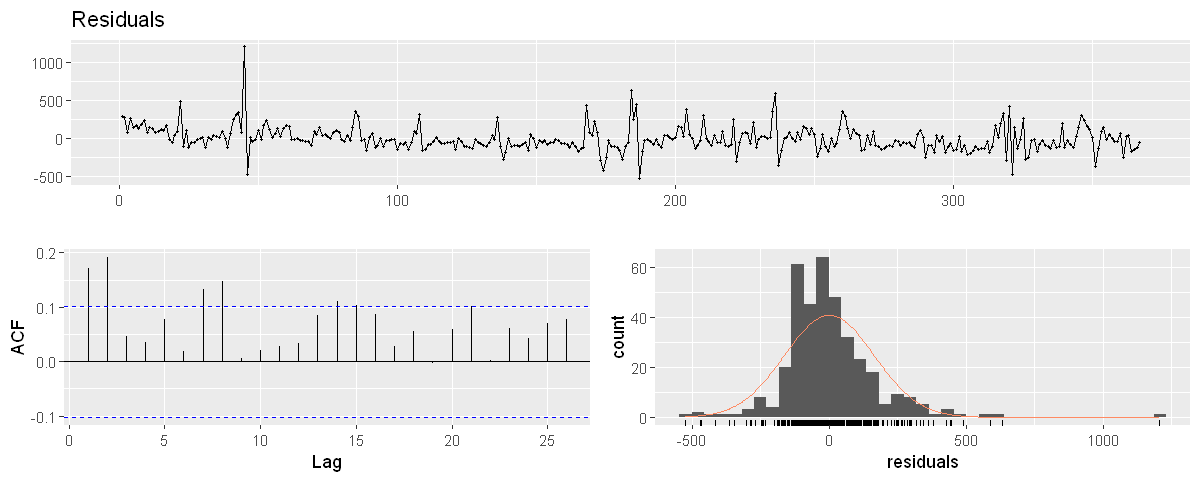

In [228]:
checkresiduals(model5_3)

* The adjusted Rsqr value is improved to 0.4394. 
* The model's p value is small, which means that the model is meaningful. 
* The mean seems to be zero. 
* The variance is not constant. 
* Residuals are not exactly normally distributed. 
* There are low autocorrelation values between the residuals. 
 
In the next step, let's check if the residuals3 is related with the lagged version of the input variable. 

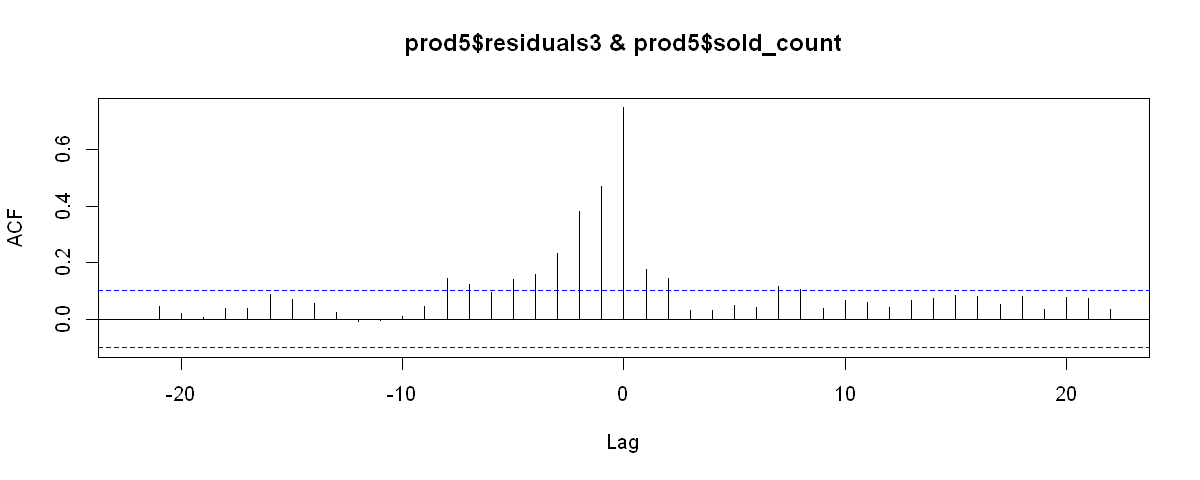

In [229]:
prod5[, residuals3:=c(NA, model5_3$residuals)]
ccf(prod5$residuals3, prod5$sold_count, na.action=na.pass)

In [230]:
model5_4 <- lm(sold_count~shift(basket_count,1)+shift(price,1)+shift(sold_count,1), data=prod5)
summary(model5_4)


Call:
lm(formula = sold_count ~ shift(basket_count, 1) + shift(price, 
    1) + shift(sold_count, 1), data = prod5)

Residuals:
    Min      1Q  Median      3Q     Max 
-704.47  -75.12  -24.16   50.26 1121.56 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            330.16838  111.94924   2.949  0.00339 ** 
shift(basket_count, 1)   0.03013    0.02064   1.460  0.14513    
shift(price, 1)         -1.53664    0.74230  -2.070  0.03915 *  
shift(sold_count, 1)     0.57580    0.07620   7.556 3.42e-13 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 152.8 on 363 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.5182,	Adjusted R-squared:  0.5143 
F-statistic: 130.2 on 3 and 363 DF,  p-value: < 2.2e-16



	Breusch-Godfrey test for serial correlation of order up to 10

data:  Residuals
LM test = 16.264, df = 10, p-value = 0.09233


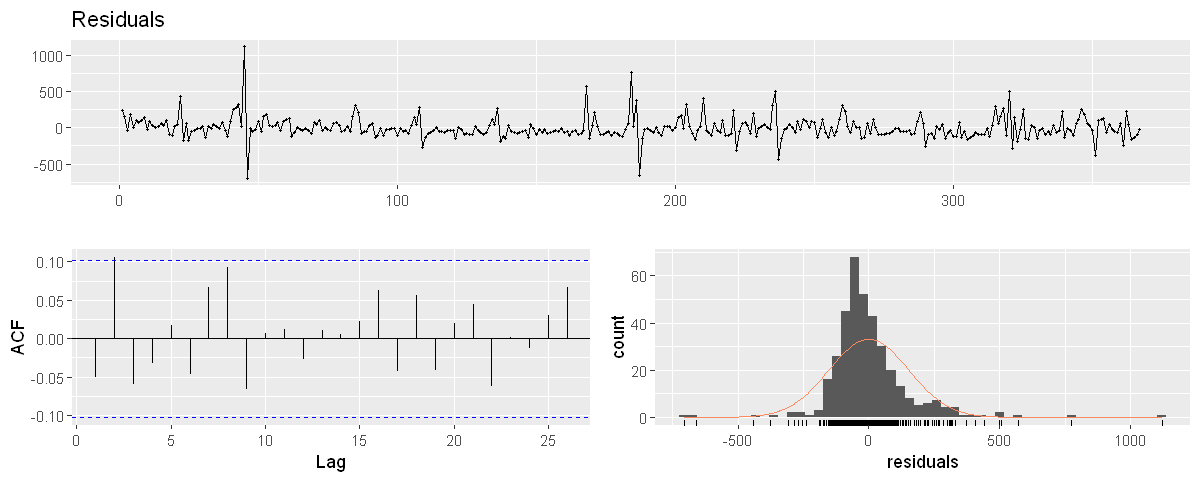

In [231]:
checkresiduals(model5_4)

* The adjusted Rsqr value is improved to 0.5143. 
* The model's p value is small, which means that the model is meaningful. 
* The mean seems to be zero. 
* The variance seems to be constant. Yet, there are some jumping points. 
* Residuals are like normally distributed but not exactly. 
* There is not a significant autocorrelation value. 
 
The final model is model5_4 with an adjusted Rsqr value of 0.52. 

Warning message:
"Removed 1 rows containing missing values (geom_point)."

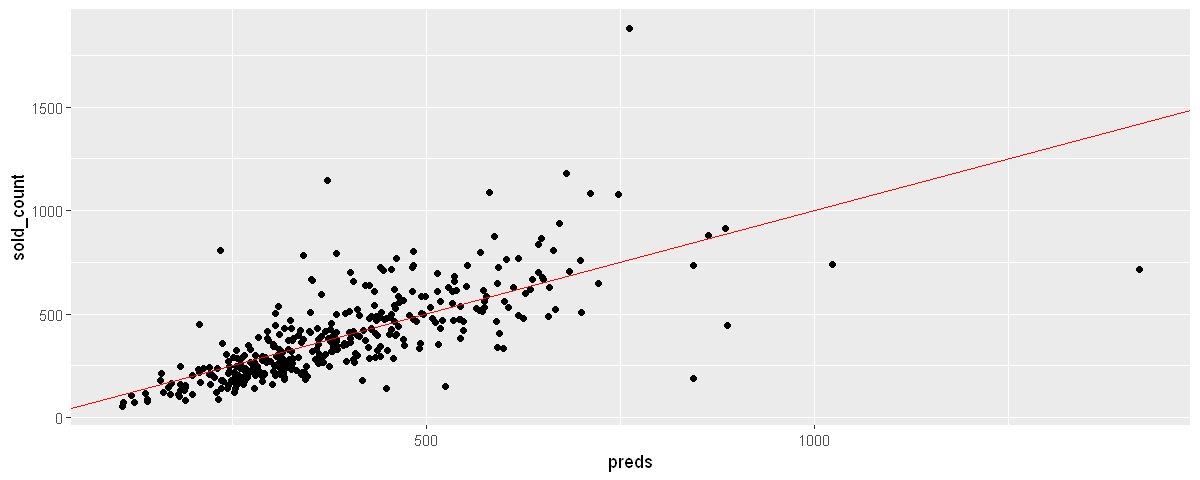

In [232]:
prod5[, preds:=c(NA,model5_4$fitted.values)]
ggplot(prod5, aes(x=preds, y=sold_count)) + geom_point() + geom_abline(intercept=0, slope=1, color="red")

### Forecasting

In [469]:
forecast_data_xaomi <- data.table(event_date=xaomi[event_date>=test_start&event_date<=test_end,]$event_date,
                            sold_count=xaomi[event_date>=test_start&event_date<=test_end,]$sold_count)
xaomi[,`:=`(trend=1:.N,
           days=wday(event_date, label=T))]
sarima_fc <- numeric(0)
sarimax_fc <- numeric(0)
reg_fc <- numeric(0)
for(i in 1:length(test_dates)){
  
  train_dt <- xaomi[event_date<test_dates[i],]
  model_sarima <- Arima(train_dt$sold_count,order=c(1,1,3),seasonal=c(2,0,0))
  model_sarimax <- Arima(train_dt$sold_count,order=c(1,1,3),seasonal=c(2,0,0),xreg=train_dt$category_sold)
  model_reg <- lm(sold_count~shift(basket_count,1)+shift(price,1)+shift(sold_count,1), data=train_dt)
  newreg <- forecast(auto.arima(train_dt$category_sold),h=1)$mean[1]
  sarima_temp <- forecast(model_sarima)
  sarimax_temp <- forecast(model_sarimax,xreg=newreg)
  reg_temp <- predict(model_reg,newdata=xaomi[event_date %in% c(test_dates[i],test_dates[i+1])])
  sarima_fc <- c(sarima_fc,sarima_temp$mean[1])
  sarimax_fc <- c(sarimax_fc,sarimax_temp$mean[1])
  reg_fc <- c(reg_fc,reg_temp)
  
}
reg_fc[is.na(reg_fc)] <- mean(reg_fc[!is.na(reg_fc)])
forecast_data_xaomi <- forecast_data_xaomi[,`:=`(sarima_p=sarima_fc,
                                               sarimax_p=sarimax_fc,
                                               reg_p=reg_fc[c(1,seq(2,28,2))])]
accu(forecast_data_xaomi$sold_count,forecast_data_xaomi$sarima_p)
accu(forecast_data_xaomi$sold_count,forecast_data_xaomi$sarimax_p)
accu(forecast_data_xaomi[1:(.N-1)]$sold_count,forecast_data_xaomi[2:.N]$reg_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
15,438.6667,100.6909,0.2295386,0.026259,0.1372231,72.35346,60.25166,0.1373518,0.1373518


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
15,438.6667,100.6909,0.2295386,-0.01782096,0.270721,153.6741,117.3178,0.2674419,0.2674419


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
14,440.2857,104.2891,0.2368669,-0.02021158,0.06922325,30.03414,25.85974,0.05873399,0.05873399


In [470]:
result_data_xaomi <- data.table(event_date=xaomi[event_date>=result_start&event_date<=result_end,]$event_date,
                               sold_count=xaomi[event_date>=result_start&event_date<=result_end,]$sold_count)
final_fc <- numeric(0)
for(i in 1:length(result_dates)){
  
  train_dt <- xaomi[event_date<result_dates[i],]
  model_final <- lm(sold_count~trend+days+shift(basket_count, 1)+shift(sold_count, 1), data=train_dt)
  final_temp <- predict(model_final,newdata=xaomi[event_date %in% c(result_dates[i],result_dates[i+1])])
  final_fc <- c(final_fc,final_temp)
  
}
final_fc[is.na(final_fc)] <- mean(final_fc[!is.na(final_fc)])
result_data_xaomi <- result_data_xaomi[,`:=`(final_p=final_fc[c(1,seq(2,28,2))])]
accu(result_data_xaomi[1:(.N-1)]$sold_count,result_data_xaomi[2:.N]$final_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
14,507,133.3722,0.2630616,0.09476509,0.08709704,60.34427,48.77248,0.09619818,0.09619818


In [471]:
data.frame(event_date=result_data_xaomi[1:(.N-1)]$event_date,
           sold_count=result_data_xaomi[1:(.N-1)]$sold_count,
           predictions=result_data_xaomi[2:.N]$final_p)

event_date,sold_count,predictions
2021-06-12,392,330.1629
2021-06-13,500,472.0971
2021-06-14,557,513.5997
2021-06-15,508,472.9138
2021-06-16,702,619.5400
2021-06-17,530,441.5001
2021-06-18,620,514.9317
2021-06-19,614,510.7500
2021-06-20,658,590.8018
2021-06-21,455,445.9249


### Trendyolmilla Tayt

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


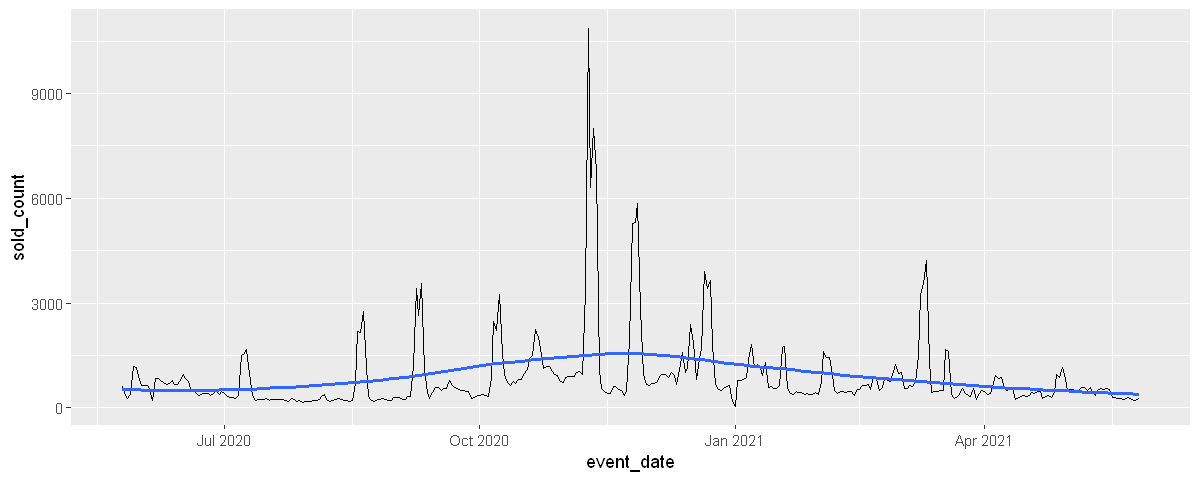

In [237]:
ggplot(prod4, aes(x=event_date, y=sold_count)) + geom_line() + geom_smooth(se=F)

* The blue line says that the mean is not constant. 
* It seems that there is no trend on the data. 
* The variance changes over time. 

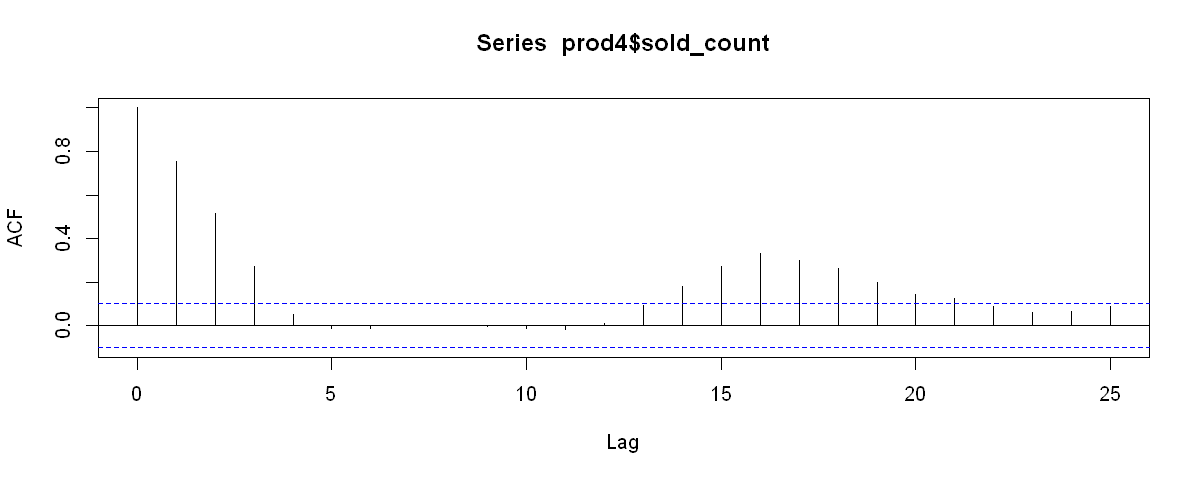

In [238]:
acf(prod4$sold_count) 

There is a little increase in the autocorrelation value at lag 16. 

### Weekly Decomposition

The variance does not increase over time, so additive decomposition will be used to decompose the data at weekly level. 

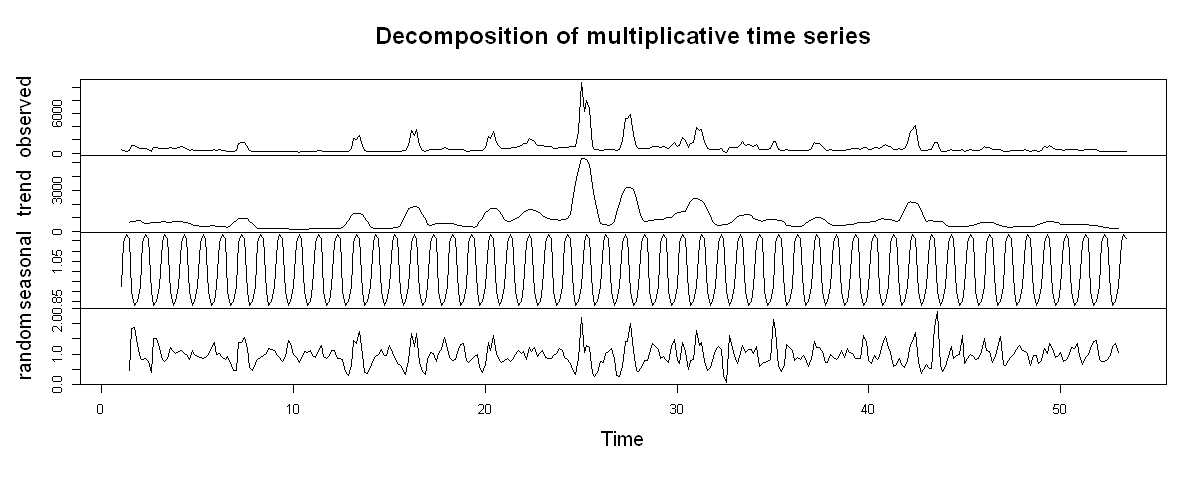

In [239]:
prod4_weekly_dec <- decompose(ts(prod4$sold_count, freq=7), type="multiplicative")
plot(prod4_weekly_dec)

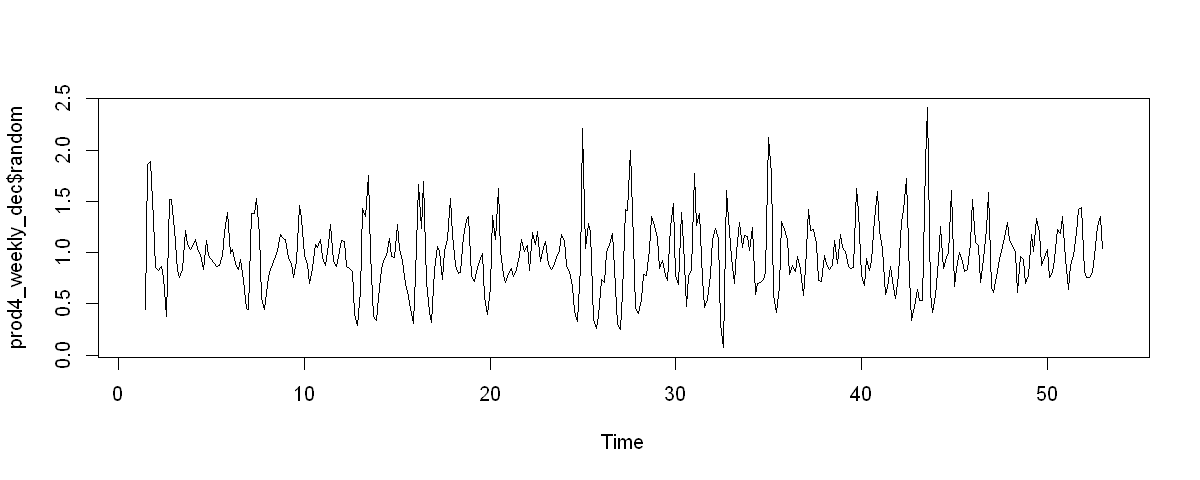

In [240]:
plot(prod4_weekly_dec$random)

* The variance seems to be constant. 
* The mean is also constant. 
* It can be said that the data is stationary. 

In [241]:
u_test <- ur.kpss(prod4_weekly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.1182 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


The weekly decomposed data is stationary. 

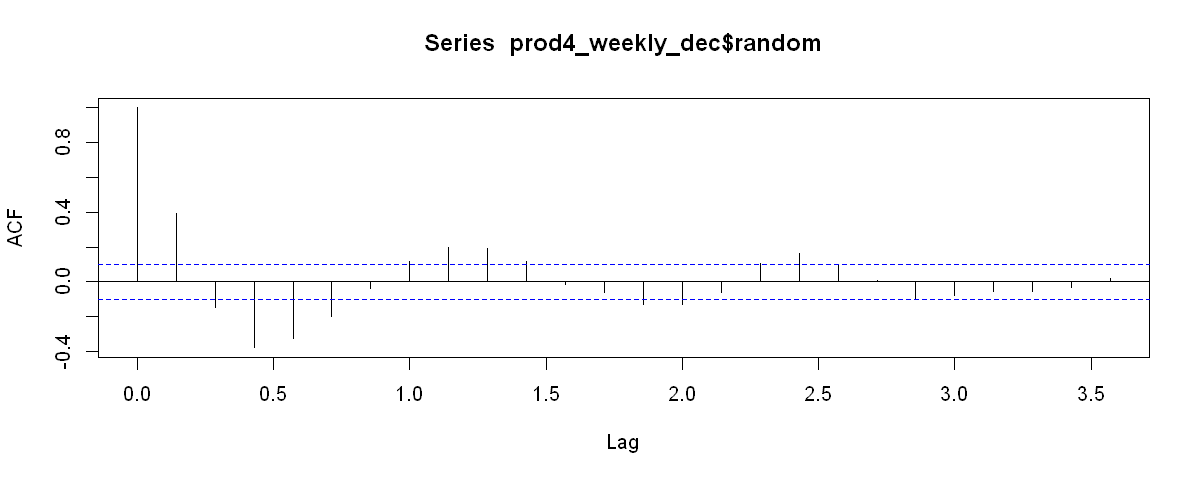

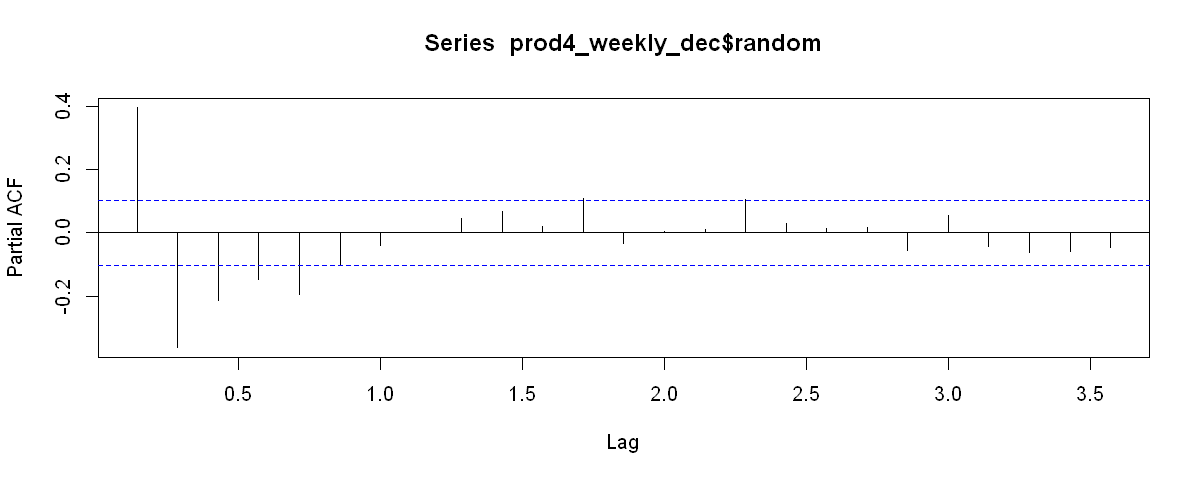

In [242]:
acf(prod4_weekly_dec$random, na.action=na.pass)
pacf(prod4_weekly_dec$random, na.action=na.pass)

ACF graph is like sinus shaped. First two lag have high correlation values. 

### Monthly Decomposition

month,sold_count
2020 May,4928
2020 Jun,17698
2020 Jul,12295
2020 Aug,14991
2020 Sep,22929
2020 Oct,35979
2020 Nov,70576
2020 Dec,38455
2021 Jan,23647
2021 Feb,20564


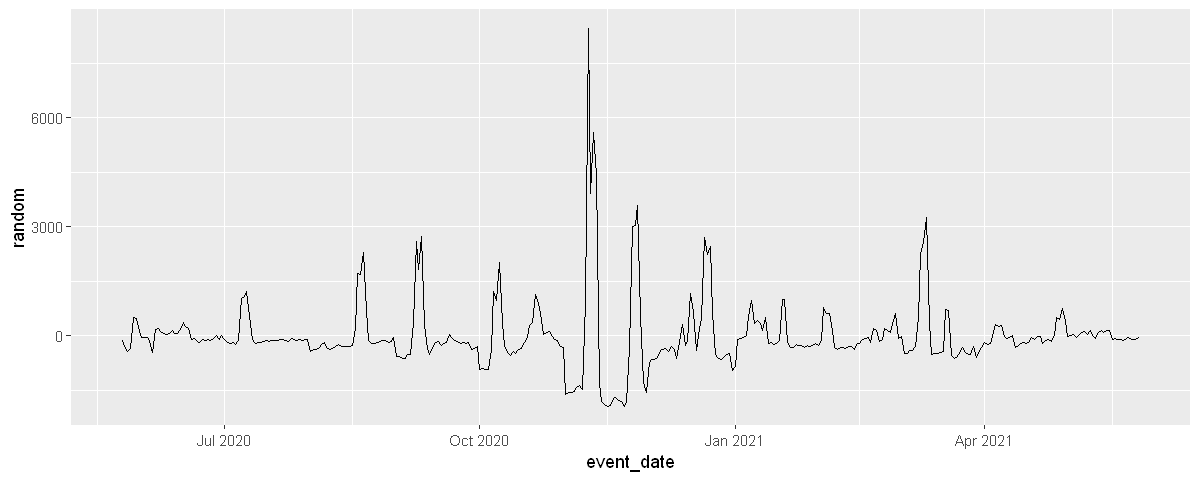

In [243]:
prod4_monthly <- prod4[, month:=yearmonth(event_date)]
prod4_monthly[, .(sold_count=sum(sold_count)), by=month]
prod4_monthly[, trend:=1:.N]

prod4_reg <- lm(sold_count~trend+as.factor(month), data=prod4_monthly)
prod4_monthly[, regOutput:=predict(prod4_reg, prod4_monthly)]

prod4_monthly[, random:=sold_count-regOutput]

ggplot(prod4_monthly, aes(x=event_date, y=random)) + geom_line()

* The variance is not constant. 
* The mean is constant. 
 
Now, let's check whether the detrended and deseasonalized data is stationary. 

In [244]:
u_test <- ur.kpss(prod4_monthly$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0087 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


From the test above, the data is stationary. 

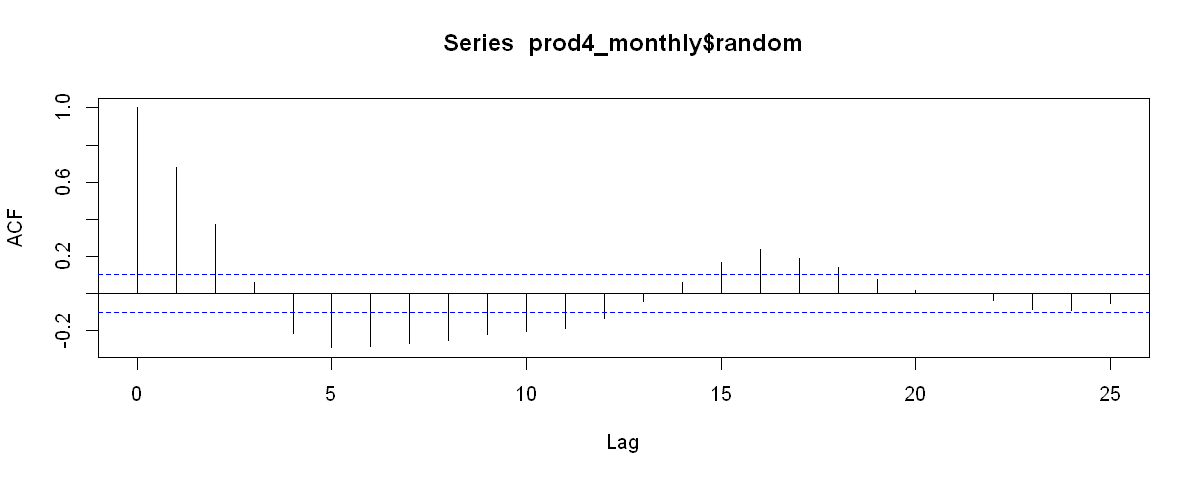

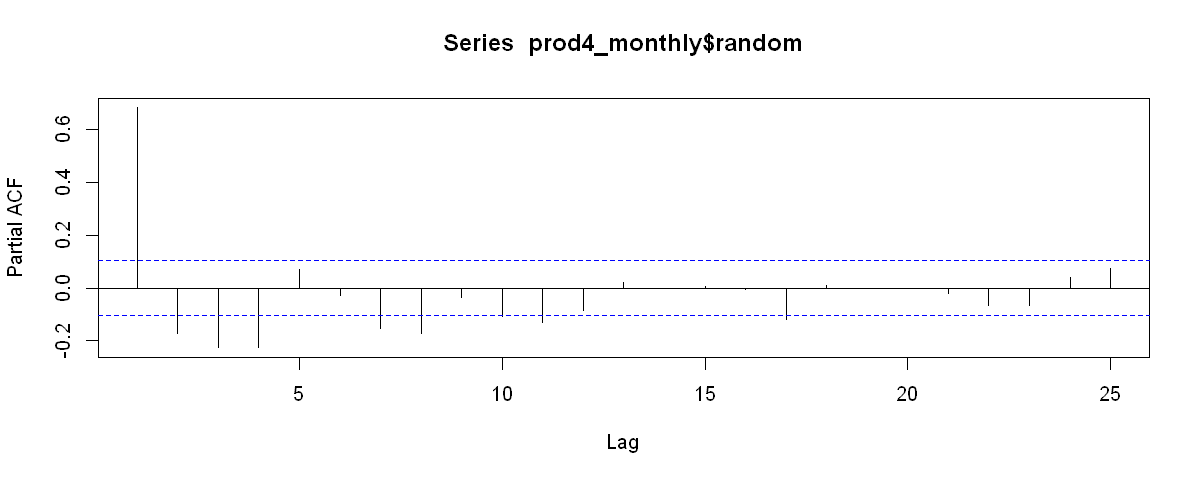

In [245]:
acf(prod4_monthly$random, na.action=na.pass)
pacf(prod4_monthly$random, na.action=na.pass)

The data is highly correlated with its first lag. Also, the ACF graph is like sinus wave. 

### Building an ARIMA Model

In [246]:
tayt <- data[product_content_id=="31515569",][order(event_date)]
tayt_train <- tayt[event_date<test_start,]
tayt_ts <- ts(tayt_train$sold_count)

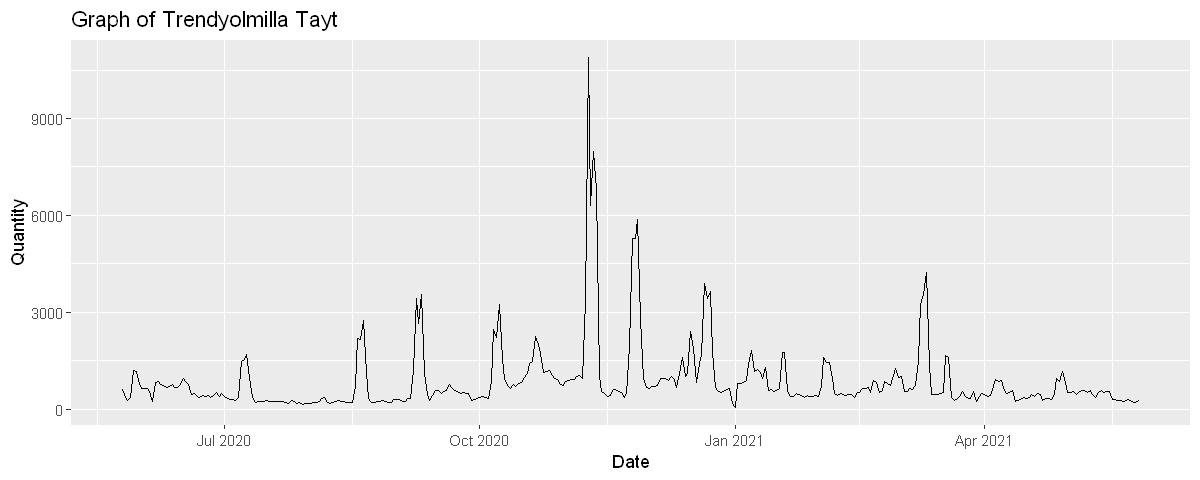

In [247]:
ggplot(tayt_train,aes(x=event_date,y=sold_count)) + geom_line() +
  labs(title= "Graph of Trendyolmilla Tayt", x= "Date", y="Quantity")

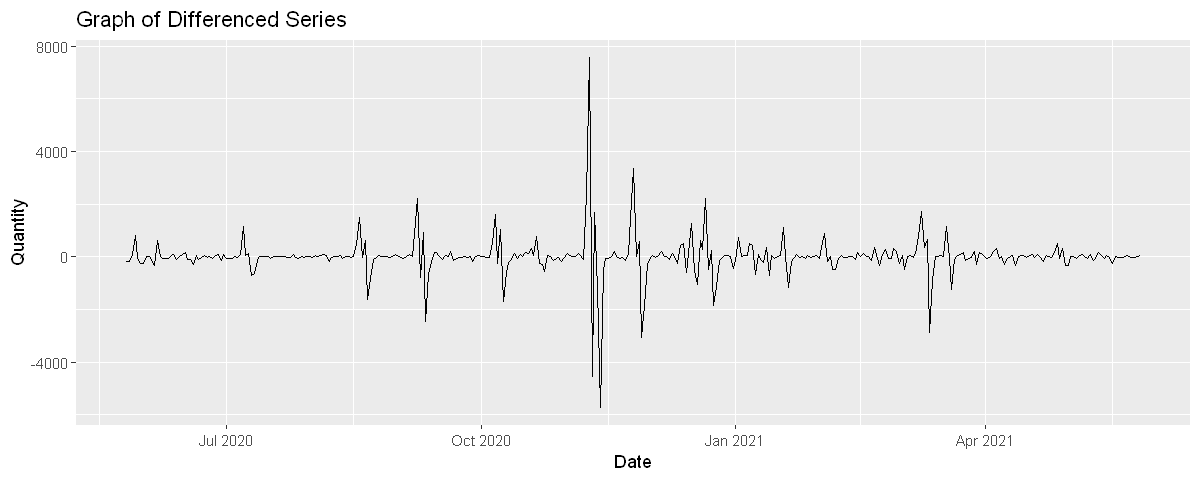

In [248]:
ggplot(tayt_train[2:.N,],aes(x=event_date)) + geom_line(aes(y=diff(tayt_train$sold_count,1))) + 
  labs(title= "Graph of Differenced Series", x= "Date", y="Quantity")

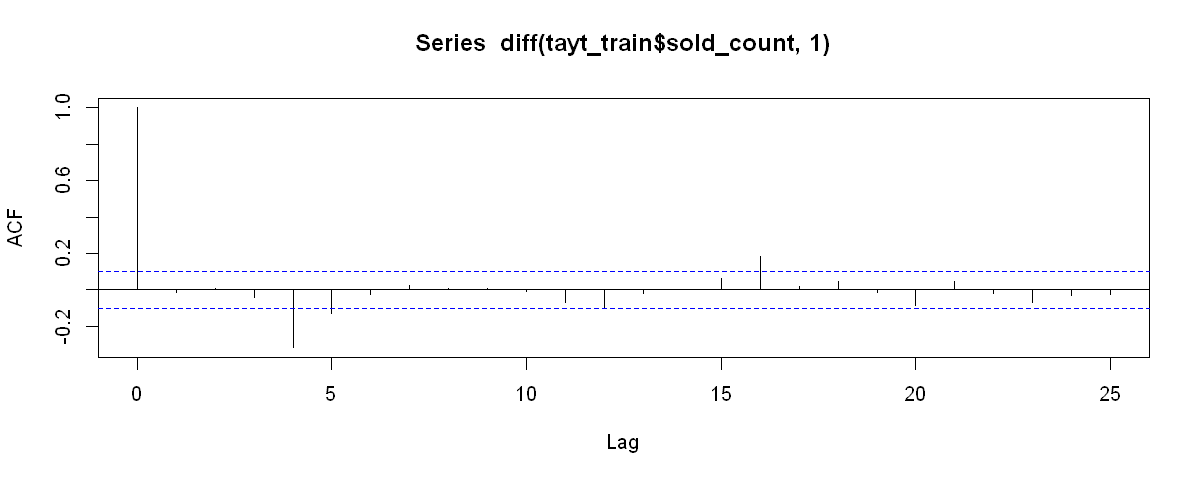

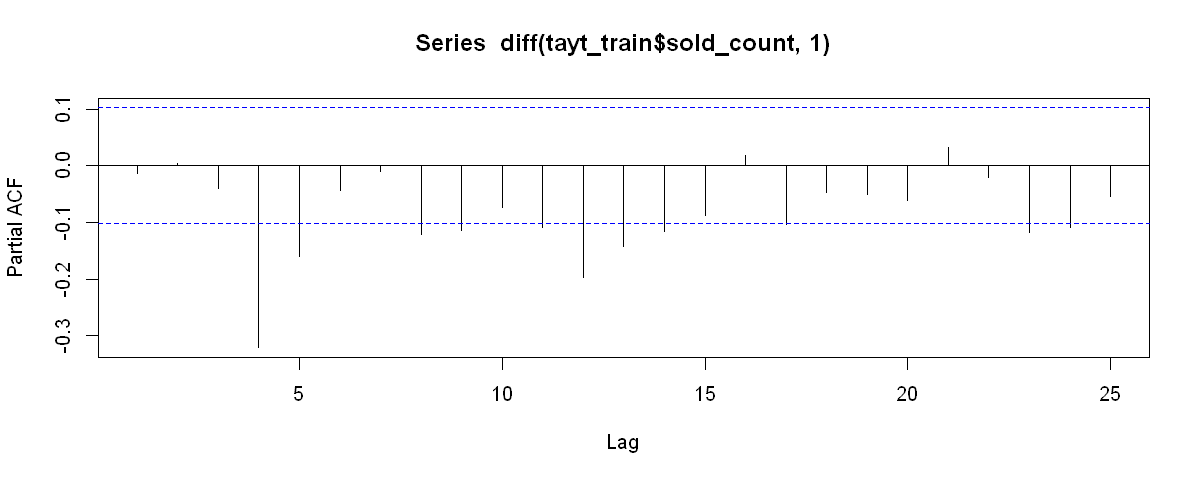

In [249]:
acf(diff(tayt_train$sold_count,1))
pacf(diff(tayt_train$sold_count,1))

After the differencing, there is spikes at ACF graph at lag 4 and at PACF graph lag 4. An ARIMA(4,1,4) model could be constructed.

In [250]:
arima(tayt_ts,order=c(4,1,4))


Call:
arima(x = tayt_ts, order = c(4, 1, 4))

Coefficients:
         ar1      ar2     ar3      ar4      ma1     ma2      ma3      ma4
      0.4575  -0.1596  0.0707  -0.1198  -0.6399  0.1546  -0.1995  -0.2459
s.e.  0.2703   0.3335  0.3074   0.1587   0.2717  0.3819   0.3527   0.2362

sigma^2 estimated as 466866:  log likelihood = -2917.11,  aic = 5852.23

In [251]:
auto.arima(tayt_ts)

Series: tayt_ts 
ARIMA(0,0,4) with non-zero mean 

Coefficients:
         ma1     ma2     ma3     ma4      mean
      0.8162  0.7191  0.5786  0.1516  863.9776
s.e.  0.0509  0.0583  0.0576  0.0520  116.0335

sigma^2 estimated as 474643:  log likelihood=-2925.24
AIC=5862.48   AICc=5862.71   BIC=5885.93

The best model is ARIMA(4,1,4) with lowest AIC 5852.23.


	Ljung-Box test

data:  Residuals from ARIMA(4,1,4)
Q* = 3.2231, df = 3, p-value = 0.3585

Model df: 8.   Total lags used: 11



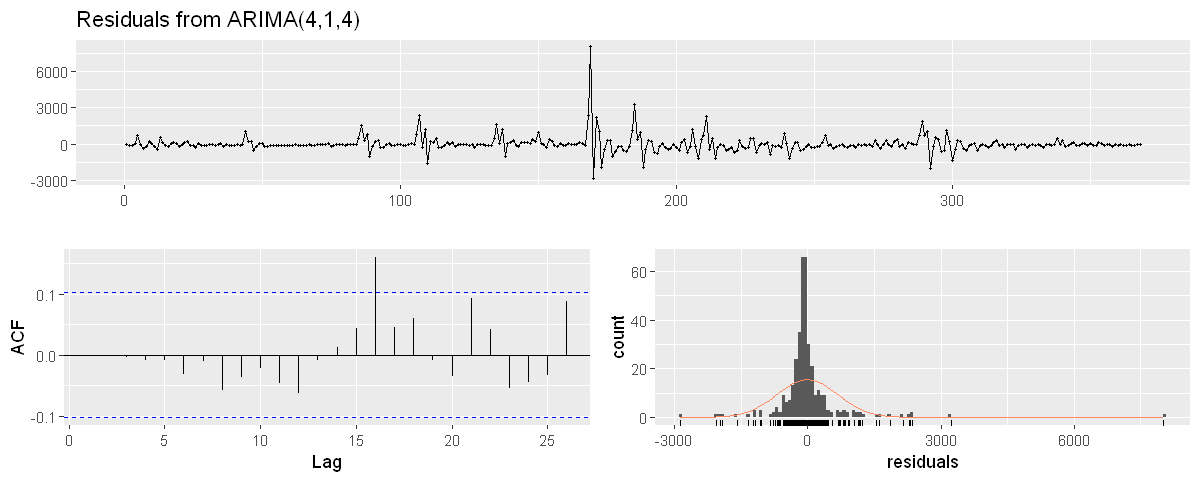

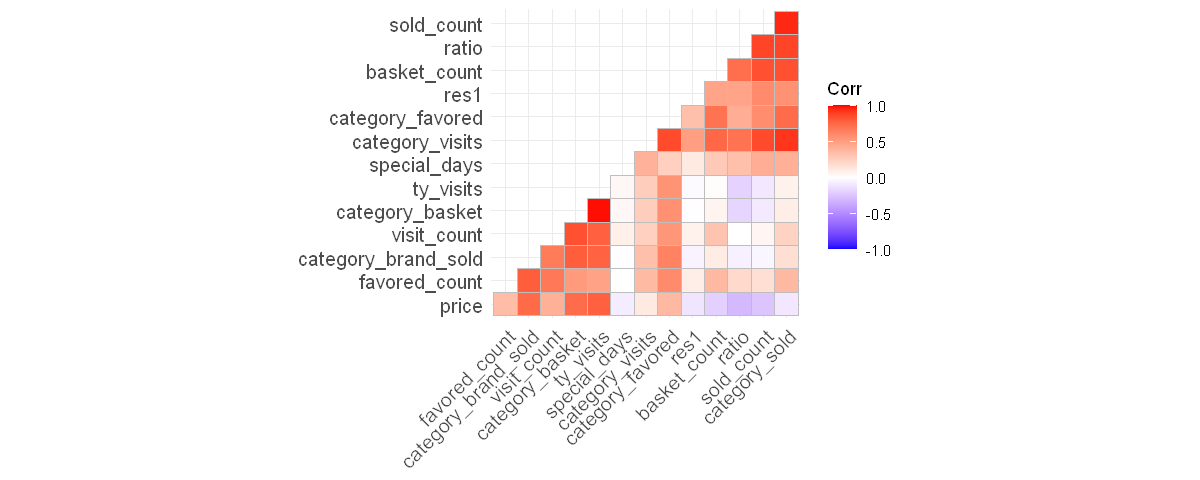

In [253]:
model_tayt_arima <- arima(tayt_ts,order=c(4,1,4))
checkresiduals(model_tayt_arima)
tayt_train$res1 <- model_tayt_arima$residuals
corr <- cor(tayt_train[!is.na(tayt_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals have constant mean at 0 and constant variance. Also, distribution seems normal while there is no autocorrelation. Residuals are correlated with basket_count and  category_sold. First we could add the basket_count variable.

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


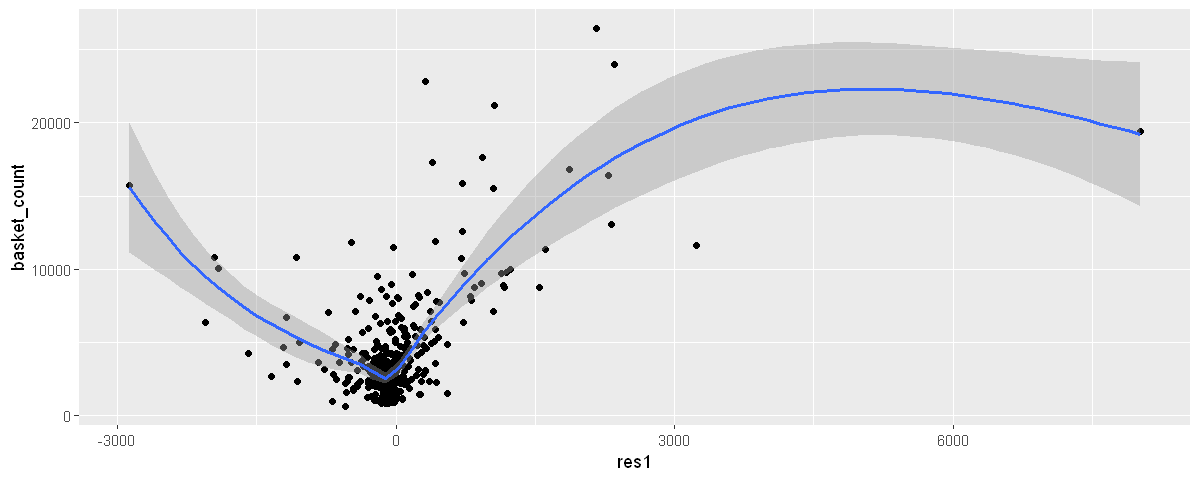

In [254]:
ggplot(tayt_train,aes(x=res1,y=basket_count)) +  geom_point() + geom_smooth()

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


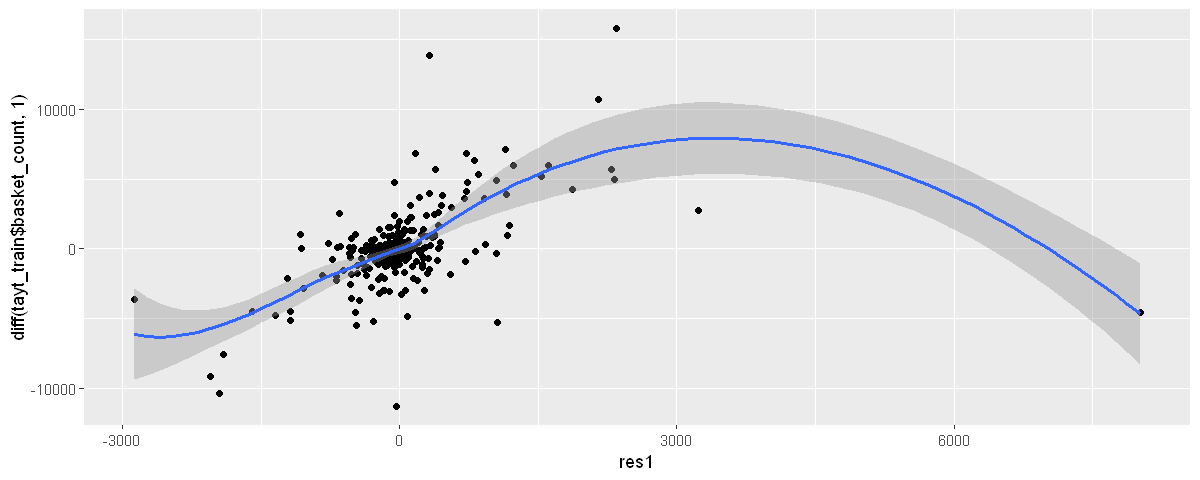

In [255]:
ggplot(tayt_train[2:.N],aes(x=res1)) +  geom_point(aes(y=diff(tayt_train$basket_count,1))) + 
geom_smooth(aes(y=diff(tayt_train$basket_count,1)))

A more linear curve obtained with differencing.

In [256]:
cor(tayt_train[2:.N]$res1,diff(tayt_train$basket_count,1))
tayt_train$diff_basket <- c(NA,diff(tayt_train$basket_count,1))
tayt$diff_basket <- c(NA,diff(tayt$basket_count,1))

[1] 0.4434869

In [257]:
arima(tayt_ts,order=c(4,1,4),xreg=tayt_train$diff_basket)


Call:
arima(x = tayt_ts, order = c(4, 1, 4), xreg = tayt_train$diff_basket)

Coefficients:
         ar1      ar2     ar3      ar4      ma1     ma2      ma3      ma4
      0.4499  -0.1336  0.0611  -0.1210  -0.6301  0.1220  -0.1764  -0.2464
s.e.  0.2448   0.3055  0.2849   0.1522   0.2454  0.3469   0.3234   0.2166
      tayt_train$diff_basket
                      0.0253
s.e.                  0.0110

sigma^2 estimated as 461211:  log likelihood = -2906.93,  aic = 5833.85


	Ljung-Box test

data:  Residuals from ARIMA(4,1,4)
Q* = 4.5512, df = 3, p-value = 0.2078

Model df: 9.   Total lags used: 12



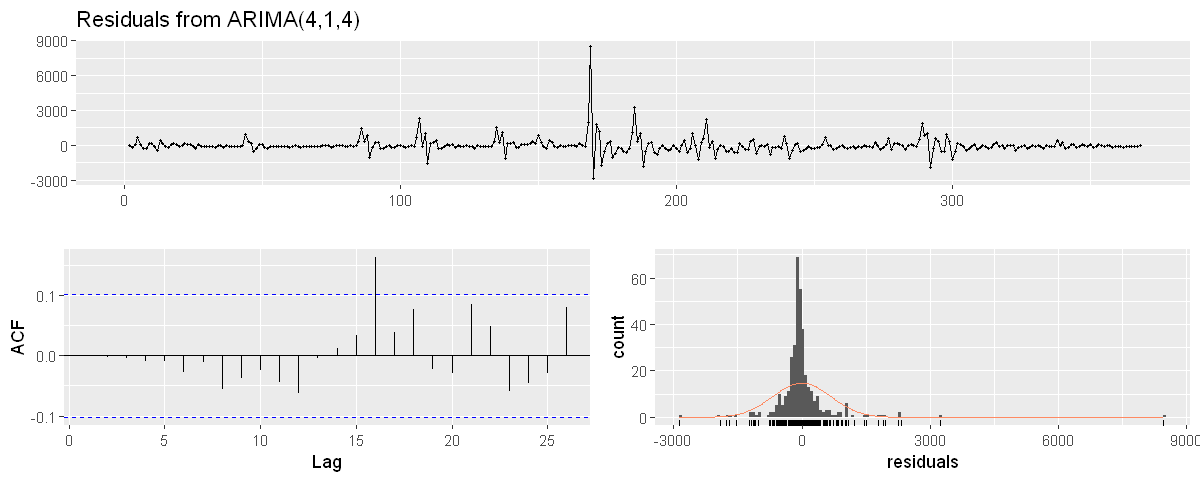

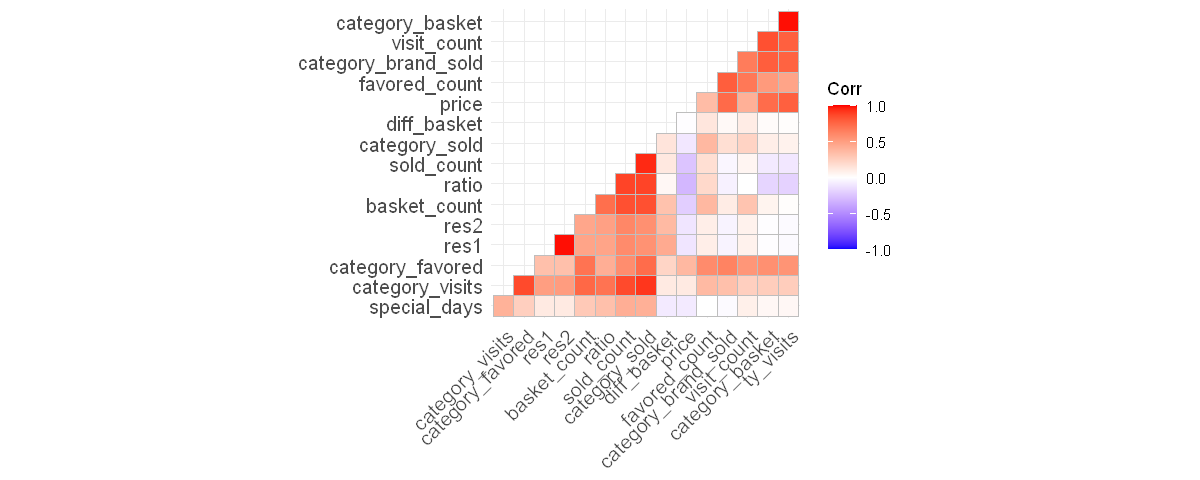

In [258]:
model_tayt_arimax <- arima(tayt_ts,order=c(4,1,4),xreg=tayt_train$diff_basket)
checkresiduals(model_tayt_arimax)
tayt_train$res2 <- model_tayt_arimax$residuals
corr <- cor(tayt_train[!is.na(tayt_train$price) & !is.na(tayt_train$res2),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

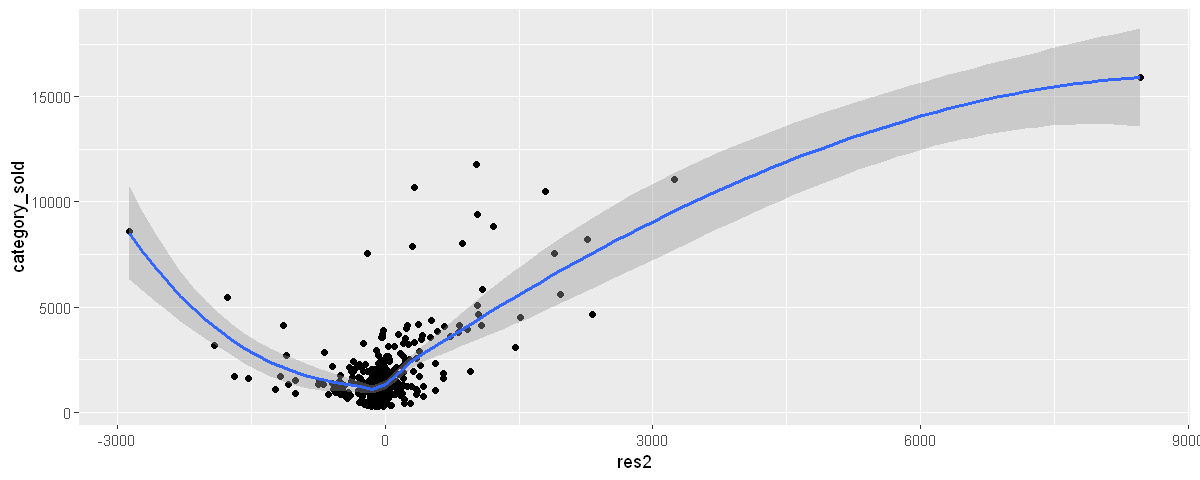

In [259]:
ggplot(tayt_train,aes(x=res2,y=category_sold)) +  geom_point() + geom_smooth()

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


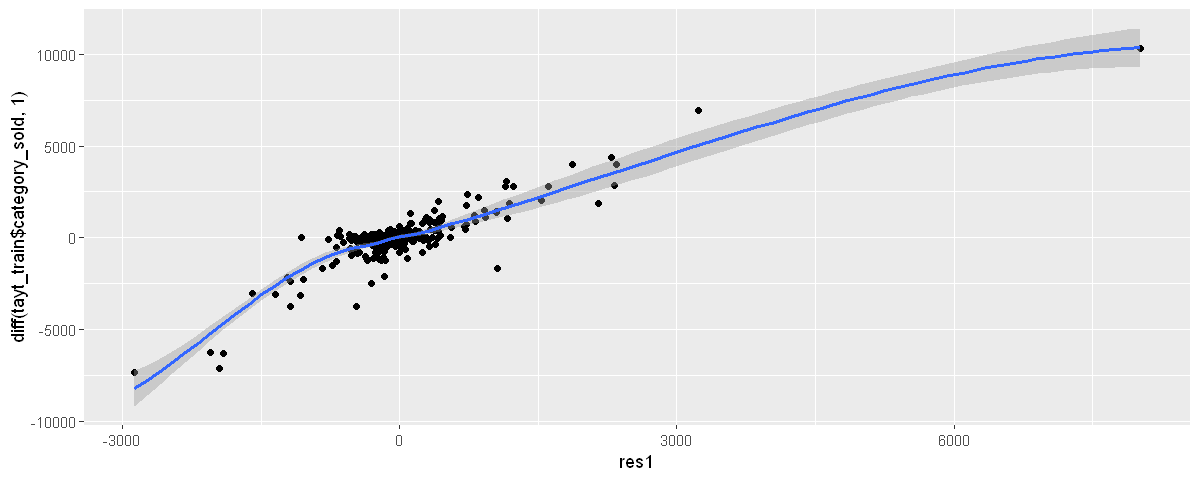

In [260]:
ggplot(tayt_train[2:.N],aes(x=res1)) +  geom_point(aes(y=diff(tayt_train$category_sold,1))) + geom_smooth(aes(y=diff(tayt_train$category_sold,1)))

In [261]:
cor(tayt_train[2:.N]$res2,diff(tayt_train$category_sold,1))
tayt_train$diff_sold <- c(NA,diff(tayt_train$category_sold,1))
tayt$diff_sold <- c(NA,diff(tayt$category_sold,1))

[1] 0.846604

In [262]:
arima(tayt_ts,order=c(4,1,4),xreg=as.matrix(tayt_train$diff_basket,tayt_train$diff_sold))


Call:
arima(x = tayt_ts, order = c(4, 1, 4), xreg = as.matrix(tayt_train$diff_basket, 
    tayt_train$diff_sold))

Coefficients:
         ar1      ar2     ar3      ar4      ma1     ma2      ma3      ma4
      0.4499  -0.1336  0.0611  -0.1210  -0.6301  0.1220  -0.1764  -0.2464
s.e.  0.2448   0.3055  0.2849   0.1522   0.2454  0.3469   0.3234   0.2166
      as.matrix(tayt_train$diff_basket, tayt_train$diff_sold)
                                                       0.0253
s.e.                                                   0.0110

sigma^2 estimated as 461211:  log likelihood = -2906.93,  aic = 5833.85


	Ljung-Box test

data:  Residuals from ARIMA(4,1,4)
Q* = 4.5512, df = 3, p-value = 0.2078

Model df: 9.   Total lags used: 12



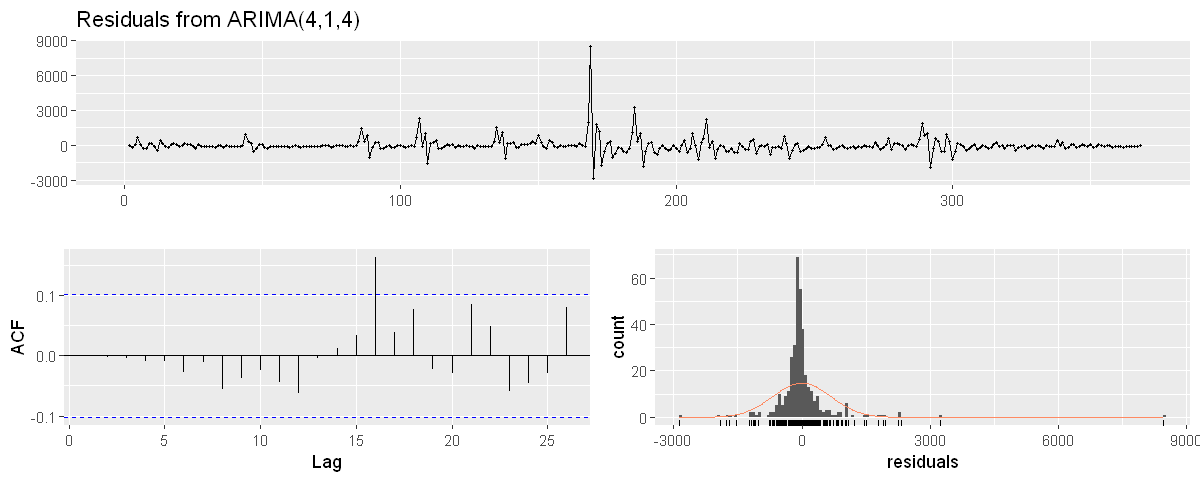

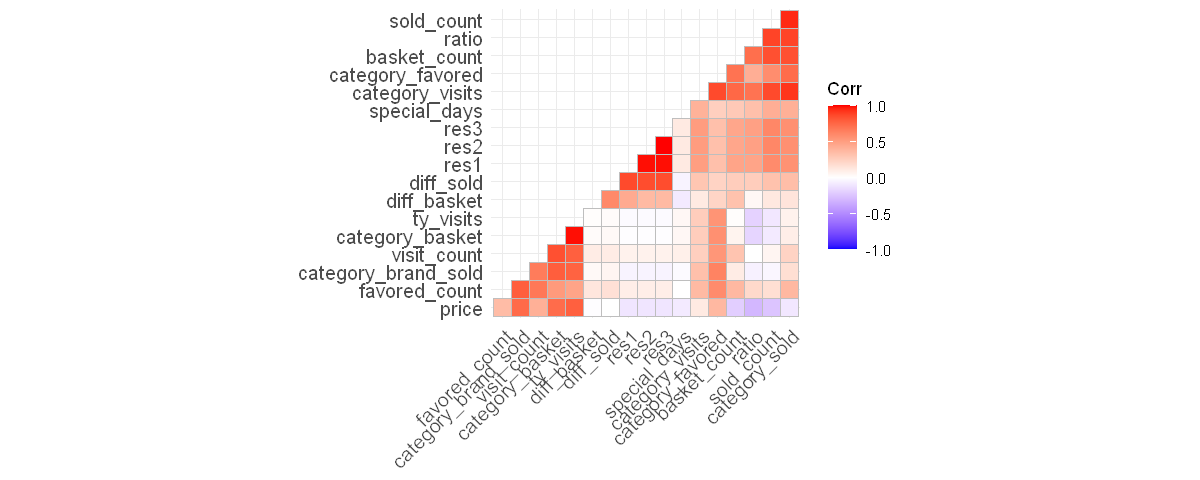

In [263]:
model_tayt_arimax <- arima(tayt_ts,order=c(4,1,4),xreg=as.matrix(tayt_train$diff_basket,tayt_train$diff_sold))
checkresiduals(model_tayt_arimax)
tayt_train$res3 <- model_tayt_arimax$residuals
corr <- cor(tayt_train[!is.na(tayt_train$price) & !is.na(tayt_train$res2),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

The final model has basket_count and category_sold as regressors. And residuals seem better both in stationarity and distribution manners.

### Linear Models

Firstly, the days of week and trend columns will be added to the data. Next, the first model will be built with trend and weekly seasonality. Then, we'll look for possible regressors and add them to the model. Finally, we will find the best model among them. 

In [264]:
prod4[, `:=`(trend=1:.N, 
            days=wday(event_date, label=T))]

model4_1 <- lm(sold_count~trend+days, data=prod4)
summary(model4_1)


Call:
lm(formula = sold_count ~ trend + days, data = prod4)

Residuals:
    Min      1Q  Median      3Q     Max 
 -932.1  -520.5  -256.1    88.4 10018.6 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  847.33195  114.68451   7.388 1.05e-12 ***
trend          0.08136    0.53868   0.151  0.88004    
days.L       -42.67460  151.91906  -0.281  0.77895    
days.Q      -477.57912  151.64471  -3.149  0.00177 ** 
days.C        -0.77239  151.50931  -0.005  0.99594    
days^4        97.79199  151.41736   0.646  0.51879    
days^5       106.03586  151.09509   0.702  0.48327    
days^6        38.51719  150.84424   0.255  0.79860    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1098 on 360 degrees of freedom
Multiple R-squared:  0.02968,	Adjusted R-squared:  0.01081 
F-statistic: 1.573 on 7 and 360 DF,  p-value: 0.1421


Because the p value of the model is higher than 0.05, we can say that the model is meaningless. Let's check for other regressors. 

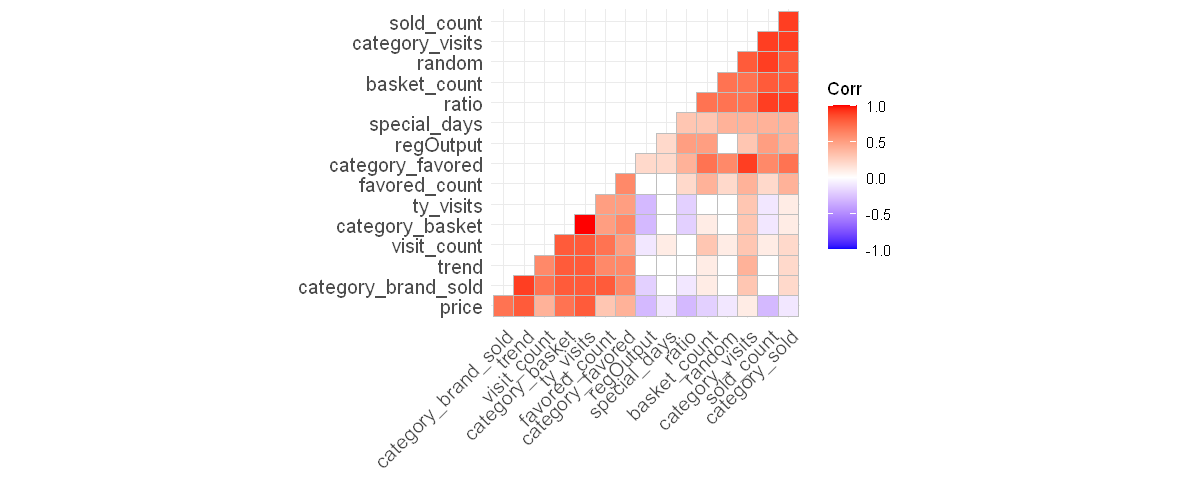

In [265]:
corr <- round(cor(Filter(is.numeric, prod4)), 1)
ggcorrplot(corr, hc.order = TRUE,type = "lower")

The maximum correlation with sold_count is obtained by basket_count. Therefore, its lagged version will be added to the model. To find the lag value, we'll check the CCF function. 

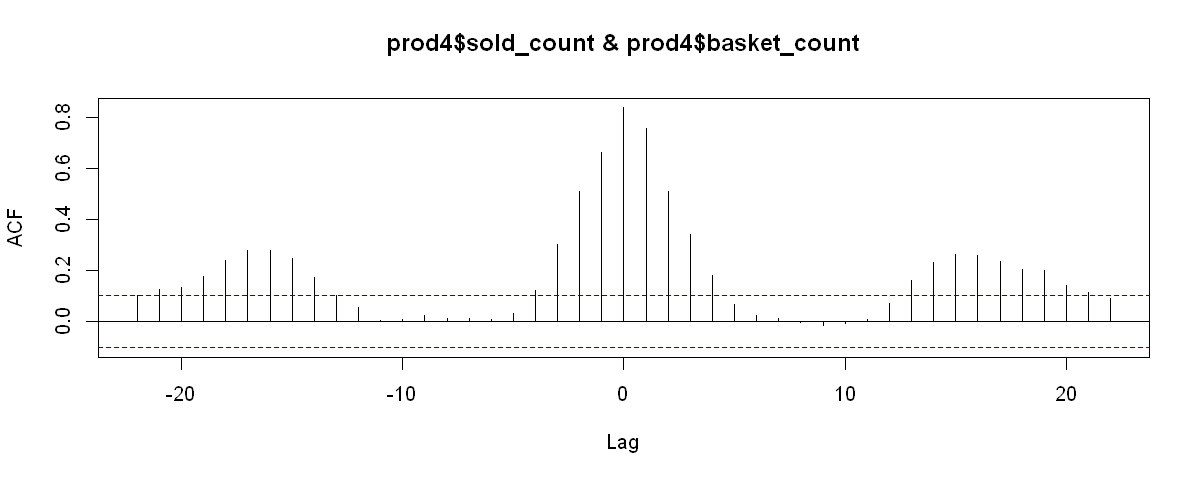

In [266]:
ccf(prod4$sold_count, prod4$basket_count)

In [267]:
model4_2 <- lm(sold_count~shift(basket_count,1), data=prod4)
summary(model4_2)


Call:
lm(formula = sold_count ~ shift(basket_count, 1), data = prod4)

Residuals:
    Min      1Q  Median      3Q     Max 
-4219.3  -188.7    11.5   101.8  5608.1 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -68.29416   56.49884  -1.209    0.228    
shift(basket_count, 1)   0.22272    0.01004  22.173   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 722.4 on 365 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.5739,	Adjusted R-squared:  0.5728 
F-statistic: 491.7 on 1 and 365 DF,  p-value: < 2.2e-16



	Breusch-Godfrey test for serial correlation of order up to 10

data:  Residuals
LM test = 94.771, df = 10, p-value = 6.033e-16


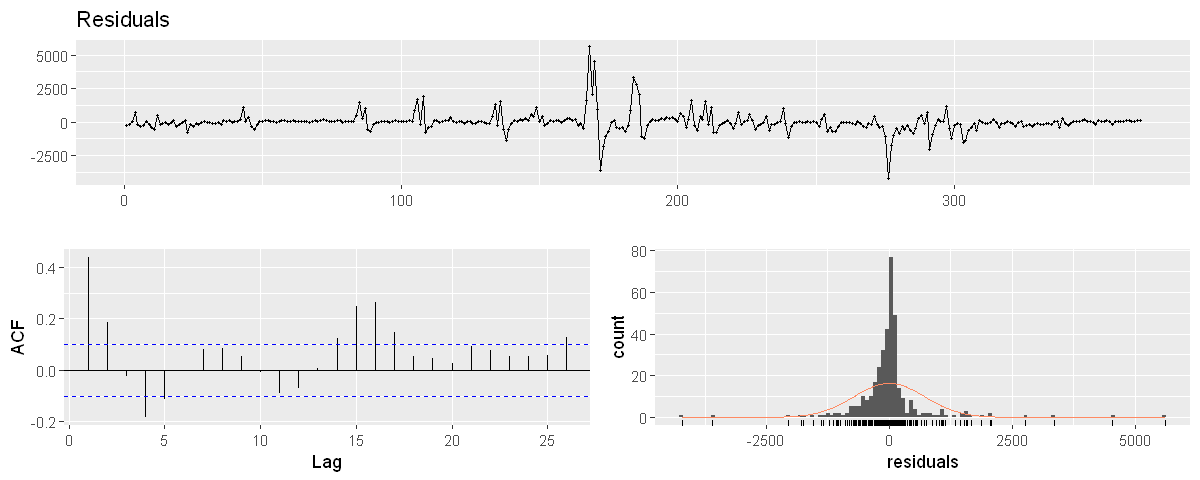

In [268]:
checkresiduals(model4_2)

* The adjusted Rsqr value of the model is 0.5728. 
* The model's p value is small, which means that the model is meaningful. 
* The mean of the residuals seems to be zero. 
* The variance changes over time. 
* Residuals are still not exactly normally distributed. 
* There are high autocorrelations at lag 1 and lag 16. 

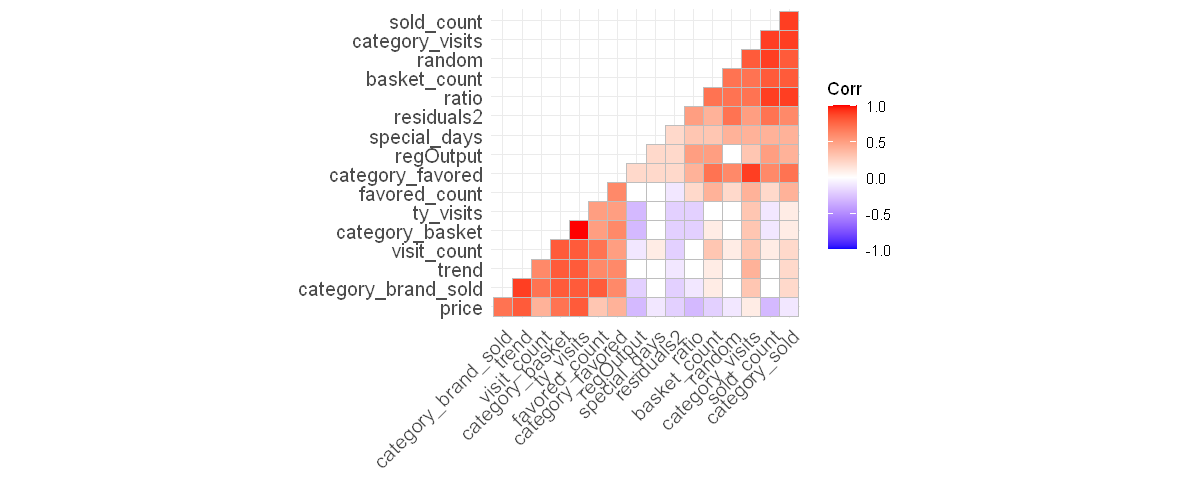

In [270]:
prod4[, residuals2:=c(NA, model4_2$residuals)]
corr <- round(cor(Filter(is.numeric, prod4[!is.na(prod4$residuals2)])), 1)
ggcorrplot(corr, hc.order = TRUE,type = "lower")

The maximum correlation with residuals2 is obtained by category_sold. Therefore, its lagged version will be added to the model. To find the lag value, we'll check the CCF function. 

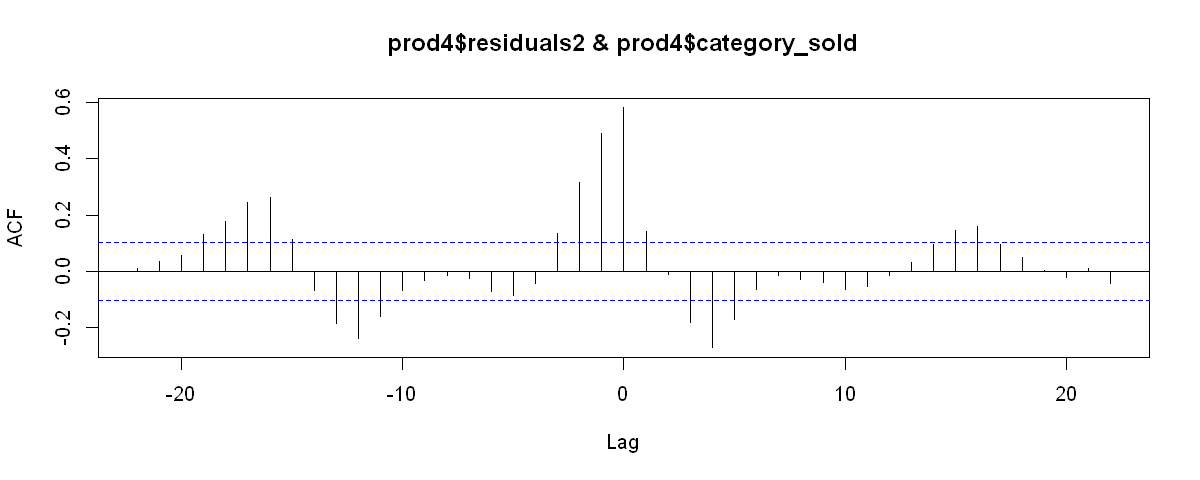

In [271]:
ccf(prod4$residuals2, prod4$category_sold, na.action=na.pass)

In [272]:
model4_3 <- lm(sold_count~shift(basket_count,1)+shift(category_sold,1), data=prod4)
summary(model4_3)


Call:
lm(formula = sold_count ~ shift(basket_count, 1) + shift(category_sold, 
    1), data = prod4)

Residuals:
    Min      1Q  Median      3Q     Max 
-3578.8  -192.2    -1.5    98.6  6455.5 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -73.75607   54.61245  -1.351    0.178    
shift(basket_count, 1)    0.14383    0.01807   7.960 2.21e-14 ***
shift(category_sold, 1)   0.18746    0.03621   5.177 3.75e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 698.1 on 364 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.6031,	Adjusted R-squared:  0.601 
F-statistic: 276.6 on 2 and 364 DF,  p-value: < 2.2e-16



	Breusch-Godfrey test for serial correlation of order up to 10

data:  Residuals
LM test = 75.003, df = 10, p-value = 4.752e-12


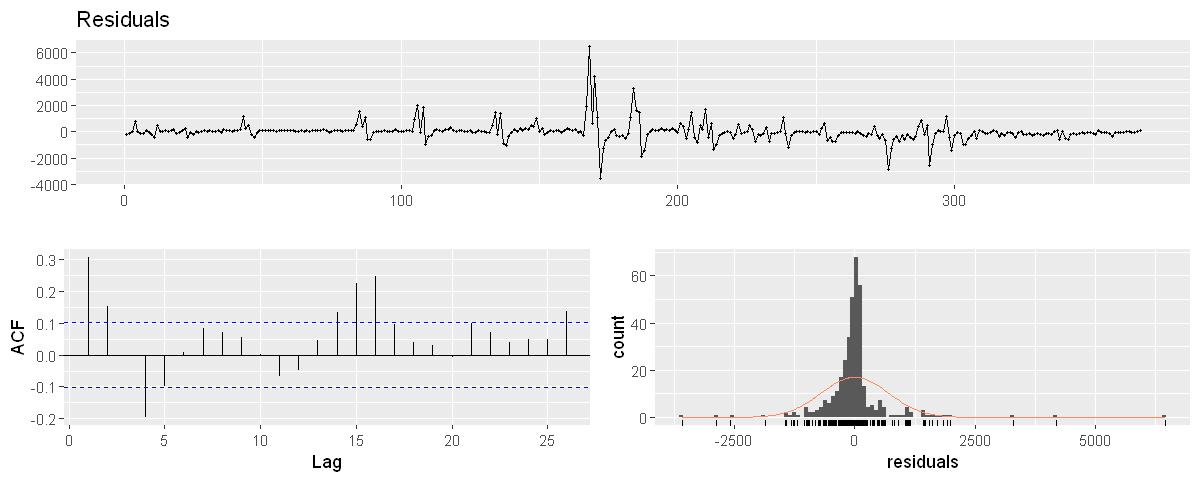

In [273]:
checkresiduals(model4_3)

* The adjusted Rsqr value of the model is 0.601. 
* The model's p value is small, which means that the model is meaningful. 
* The mean of the residuals seems to be zero. 
* The variance changes over time. 
* Residuals are still not exactly normally distributed. 
* There are high autocorrelations at lag 1 and lag 16. 
 
Next, let's check if the residuals3 is related with the lagged version of the input variable.

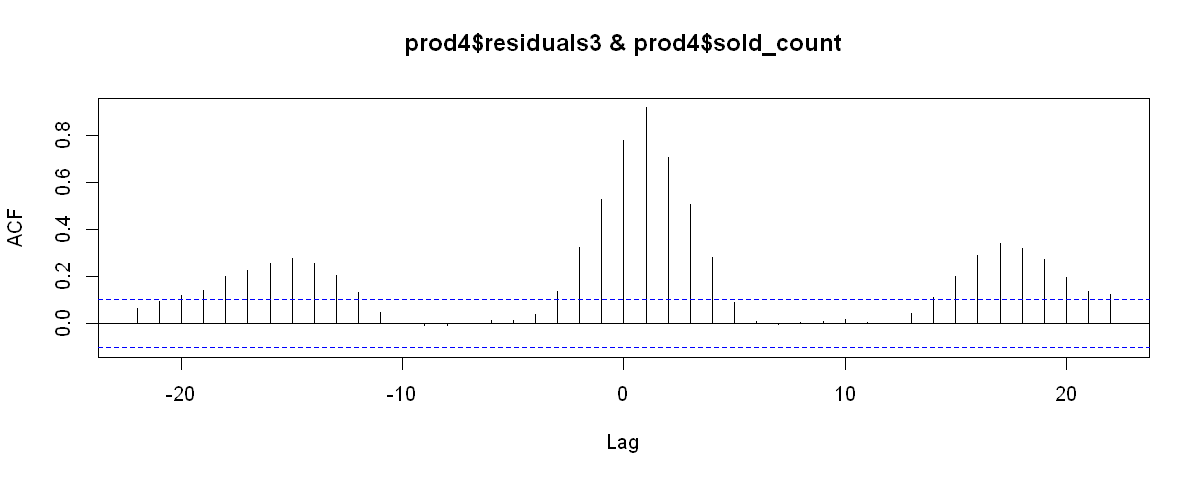

In [274]:
prod4[, residuals3:=c(NA, model4_3$fitted.values)]
ccf(prod4$residuals3, prod4$sold_count, na.action=na.pass)

In [275]:
model4_4 <- lm(sold_count~shift(basket_count,1)+shift(category_sold,1)+shift(sold_count,1), data=prod4)
summary(model4_4)


Call:
lm(formula = sold_count ~ shift(basket_count, 1) + shift(category_sold, 
    1) + shift(sold_count, 1), data = prod4)

Residuals:
    Min      1Q  Median      3Q     Max 
-4414.4  -146.7   -20.2    68.7  6529.8 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)              9.06362   56.49317   0.160    0.873    
shift(basket_count, 1)   0.12688    0.01804   7.032 1.02e-11 ***
shift(category_sold, 1) -0.04264    0.06302  -0.677    0.499    
shift(sold_count, 1)     0.46274    0.10495   4.409 1.37e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 681.1 on 363 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.6233,	Adjusted R-squared:  0.6202 
F-statistic: 200.2 on 3 and 363 DF,  p-value: < 2.2e-16



	Breusch-Godfrey test for serial correlation of order up to 10

data:  Residuals
LM test = 61.802, df = 10, p-value = 1.65e-09


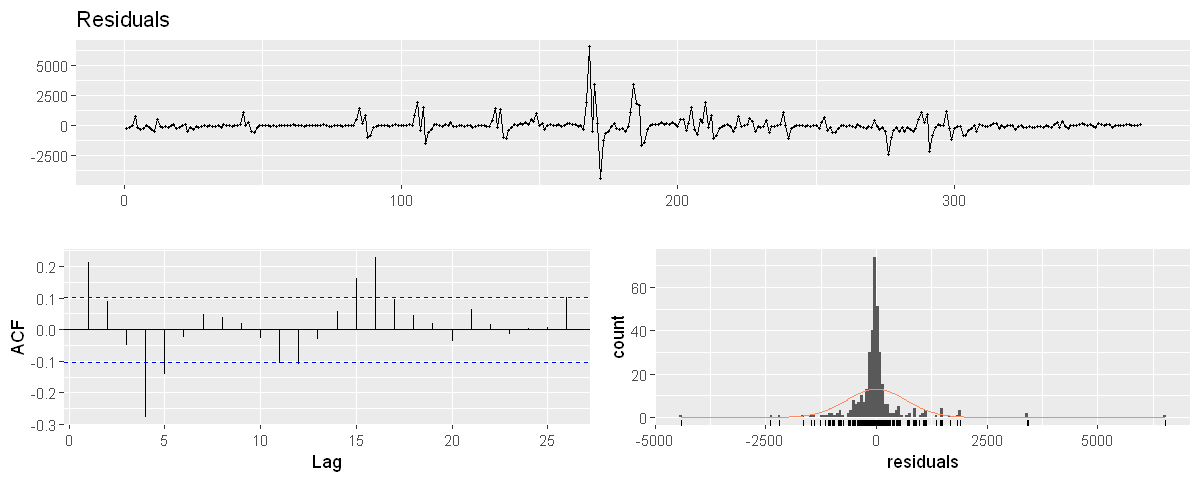

In [276]:
checkresiduals(model4_4)

* The adjusted Rsqr value is a little improved to 0.6202. 
* The model's p value is small, which means that the model is meaningful. 
* The mean is zero. 
* The variance is like constant. There is an increase in the middle of the data.  
* Residuals are more likely to be normally distributed. 
* There is a significant autocorrelation at lag 4. 
 
Let's try to add 4 lagged sold_count to the model. 

In [277]:
model4_5 <- lm(sold_count~shift(basket_count,1)+shift(category_sold,1)+shift(sold_count,1)+shift(sold_count,4), data=prod4)
summary(model4_5)


Call:
lm(formula = sold_count ~ shift(basket_count, 1) + shift(category_sold, 
    1) + shift(sold_count, 1) + shift(sold_count, 4), data = prod4)

Residuals:
    Min      1Q  Median      3Q     Max 
-2789.0  -181.1   -66.6    97.7  6129.7 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             137.07419   57.19277   2.397   0.0171 *  
shift(basket_count, 1)    0.14827    0.01744   8.500 5.16e-16 ***
shift(category_sold, 1)  -0.11207    0.06077  -1.844   0.0660 .  
shift(sold_count, 1)      0.57244    0.10104   5.666 3.01e-08 ***
shift(sold_count, 4)     -0.21507    0.03268  -6.582 1.65e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 646.7 on 359 degrees of freedom
  (4 observations deleted due to missingness)
Multiple R-squared:  0.6635,	Adjusted R-squared:  0.6597 
F-statistic: 176.9 on 4 and 359 DF,  p-value: < 2.2e-16



	Breusch-Godfrey test for serial correlation of order up to 10

data:  Residuals
LM test = 29.734, df = 10, p-value = 0.0009469


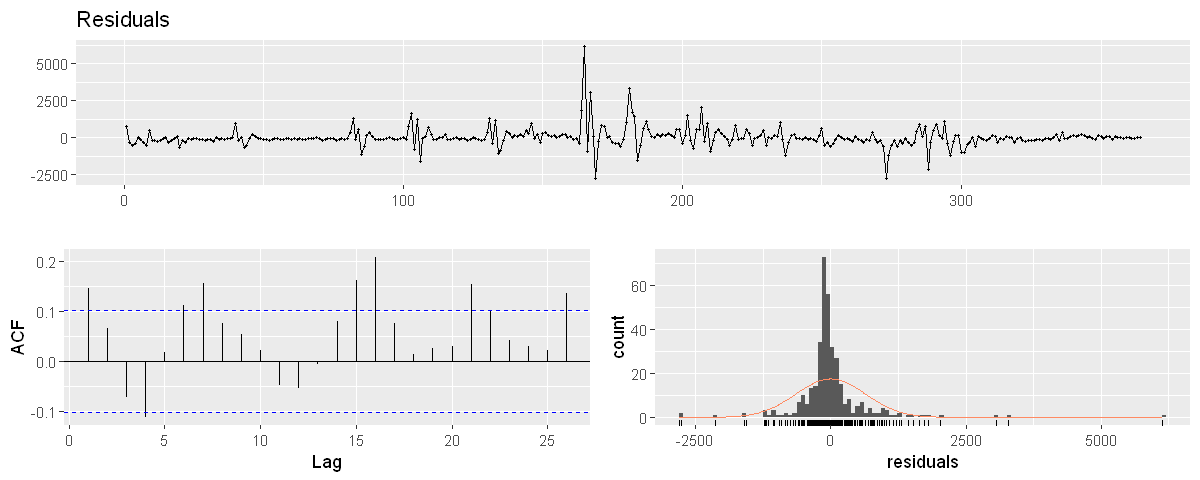

In [278]:
checkresiduals(model4_5)

* The adjusted Rsqr value is a little improved to 0.6597. 
* The model's p value is small, which means that the model is meaningful. 
* The mean is zero. 
* The variance is like constant. There is still an increase in the middle of the data.  
* Residuals are more likely to be normally distributed. 
* There is not a significant autocorrelation. 
 
So, the final model is model4_5. 

Warning message:
"Removed 4 rows containing missing values (geom_point)."

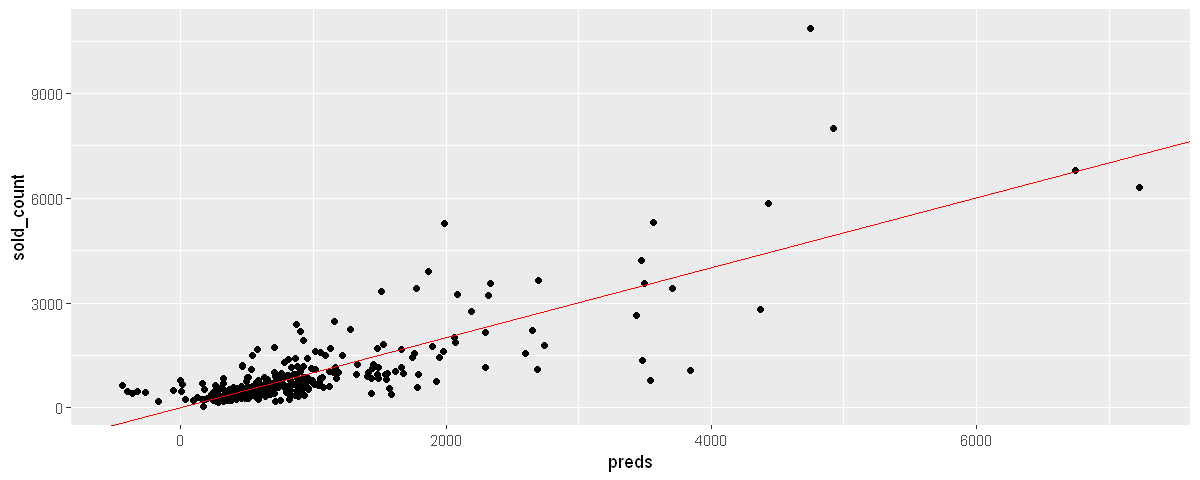

In [279]:
prod4[, preds:=c(NA,NA,NA,NA,model4_5$fitted.values)]
ggplot(prod4, aes(x=preds, y=sold_count)) + geom_point() + geom_abline(intercept=0, slope=1, color="red") 

### Forecasting

In [472]:
forecast_data_tayt <- data.table(event_date=tayt[event_date>=test_start&event_date<=test_end,]$event_date,
                            sold_count=tayt[event_date>=test_start&event_date<=test_end,]$sold_count)
tayt[,`:=`(trend=1:.N,
           days=wday(event_date, label=T))]
arima_fc <- numeric(0)
arimax_fc <- numeric(0)
reg_fc <- numeric(0)
for(i in 1:length(test_dates)){
  
  train_dt <- tayt[event_date<test_dates[i],]
  model_arima <- Arima(train_dt$sold_count,order=c(4,1,4))
  model_arimax <- Arima(tayt_ts,order=c(4,1,4),xreg=as.matrix(tayt_train$diff_basket,tayt_train$diff_sold))
  model_reg <- lm(sold_count~shift(basket_count,1)+shift(category_sold,1)+shift(sold_count,1)+shift(sold_count,1), data=train_dt)
  newreg <- forecast(auto.arima(train_dt$diff_basket),h=1)$mean[1]
  newreg2 <- forecast(auto.arima(train_dt$diff_sold),h=1)$mean[1]
  arima_temp <- forecast(model_arima)
  arimax_temp <- forecast(model_arimax,xreg=as.matrix(newreg,newreg2))
  reg_temp <- predict(model_reg,newdata=tayt[event_date %in% c(test_dates[i],test_dates[i+1])])
  arima_fc <- c(arima_fc,arima_temp$mean[1])
  arimax_fc <- c(arimax_fc,arimax_temp$mean[1])
  reg_fc <- c(reg_fc,reg_temp)
  
}
reg_fc[is.na(reg_fc)] <- mean(reg_fc[!is.na(reg_fc)])
forecast_data_tayt <- forecast_data_tayt[,`:=`(arima_p=arima_fc,
                                               arimax_p=arimax_fc,
                                               reg_p=reg_fc[c(1,seq(2,28,2))])]

accu(forecast_data_tayt$sold_count,forecast_data_tayt$arima_p)
accu(forecast_data_tayt$sold_count,forecast_data_tayt$arimax_p)
accu(forecast_data_tayt[1:(.N-1)]$sold_count,forecast_data_tayt[2:.N]$reg_p)


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
15,400.9333,228.3207,0.569473,-0.09140315,0.4765884,166.1847,128.8698,0.3214246,0.3214246


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
15,400.9333,228.3207,0.569473,0.1035967,0.5978989,227.2729,193.4942,0.4826095,0.4826095


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
14,415.3571,229.7382,0.55311,0.2867232,0.3270751,153.0789,123.5166,0.2973744,0.2973744


In [477]:
result_data_tayt <- data.table(event_date=tayt[event_date>=result_start&event_date<=result_end,]$event_date,
                               sold_count=tayt[event_date>=result_start&event_date<=result_end,]$sold_count)
final_fc <- numeric(0)
for(i in 1:length(result_dates)){
  
  train_dt <- tayt[event_date<result_dates[i],]
  model_final <- lm(sold_count~shift(basket_count,1)+shift(category_sold,1)+shift(sold_count,1)+shift(sold_count,1), data=train_dt)
  final_temp <- predict(model_final,newdata=tayt[event_date %in% c(result_dates[i],result_dates[i+1])])
  final_fc <- c(final_fc,final_temp)
  
}
final_fc[is.na(final_fc)] <- mean(final_fc[!is.na(final_fc)])
result_data_tayt <- result_data_tayt[,`:=`(final_p=final_fc[c(1,seq(2,28,2))])]
accu(result_data_tayt[1:(.N-1)]$sold_count,result_data_tayt[2:.N]$final_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
14,252.5,71.95485,0.2849697,0.06086747,0.1971049,49.10554,46.75037,0.18515,0.18515


In [478]:
data.frame(event_date=result_data_tayt[1:(.N-1)]$event_date,
           sold_count=result_data_tayt[1:(.N-1)]$sold_count,
           predictions=result_data_tayt[2:.N]$final_p)

event_date,sold_count,predictions
2021-06-12,144,101.3098
2021-06-13,179,117.1697
2021-06-14,218,180.0986
2021-06-15,245,193.8707
2021-06-16,244,195.2337
2021-06-17,200,162.7112
2021-06-18,191,153.5335
2021-06-19,315,344.4629
2021-06-20,387,344.3593
2021-06-21,390,314.8777


### Trendyolmilla Bikini 2

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


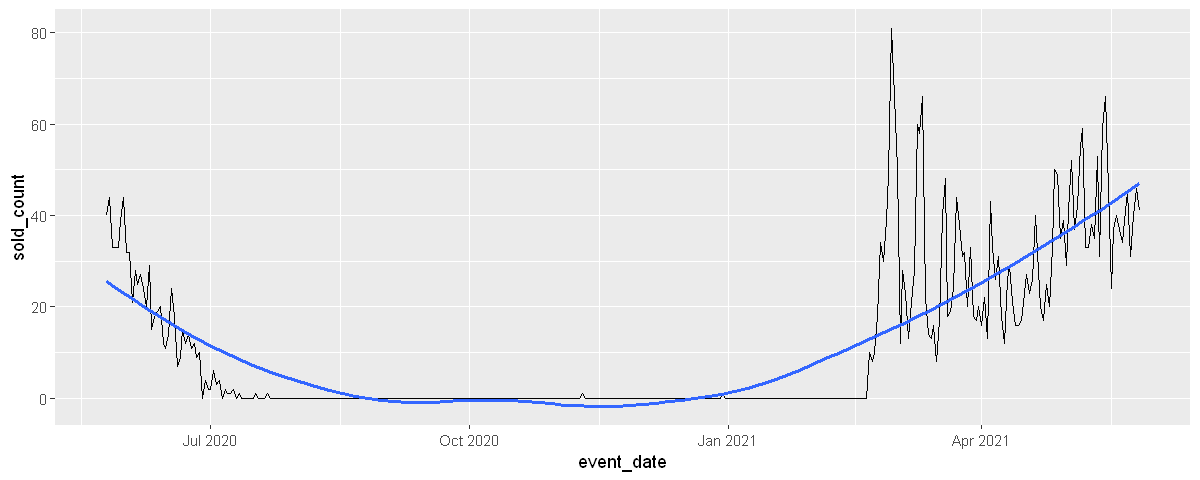

In [292]:
ggplot(prod3, aes(x=event_date, y=sold_count)) + geom_line() + geom_smooth(se=F)

* The data seems to be dirty. 
* From August 2020 to February 2021, somehow there are a lot of days with zero sales. 
* In the summer season, the sales increase. 
* The variance is definitely not constant. 
* The mean is also not constant over time.
* The data is not stationary at this point. 

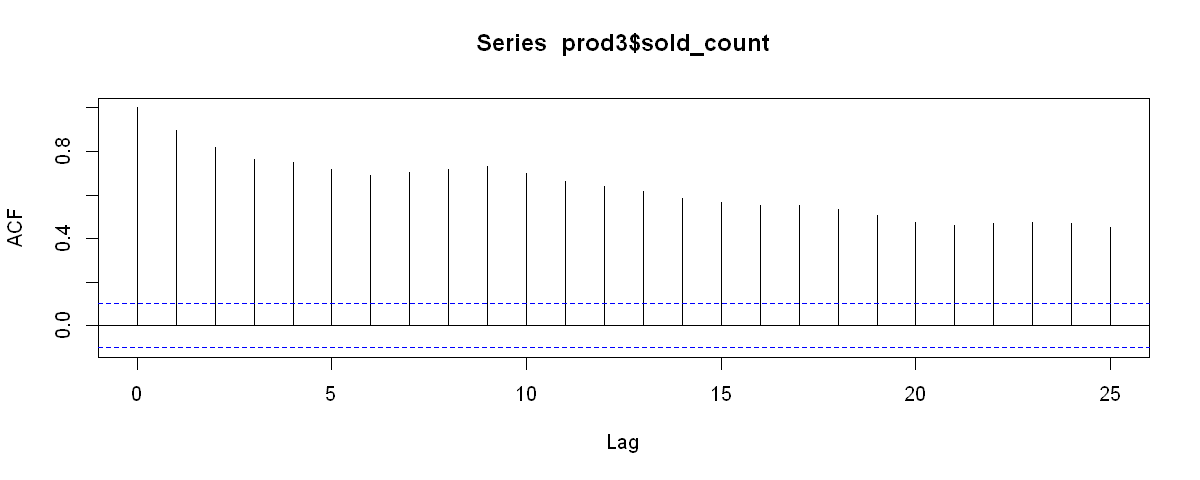

In [293]:
acf(prod3$sold_count) 

The autocorrelation values decrease. There is a peak value at lag 9. 

### Weekly Decomposition

Because the variance does not regulary increase, additive decomposition will be used. 

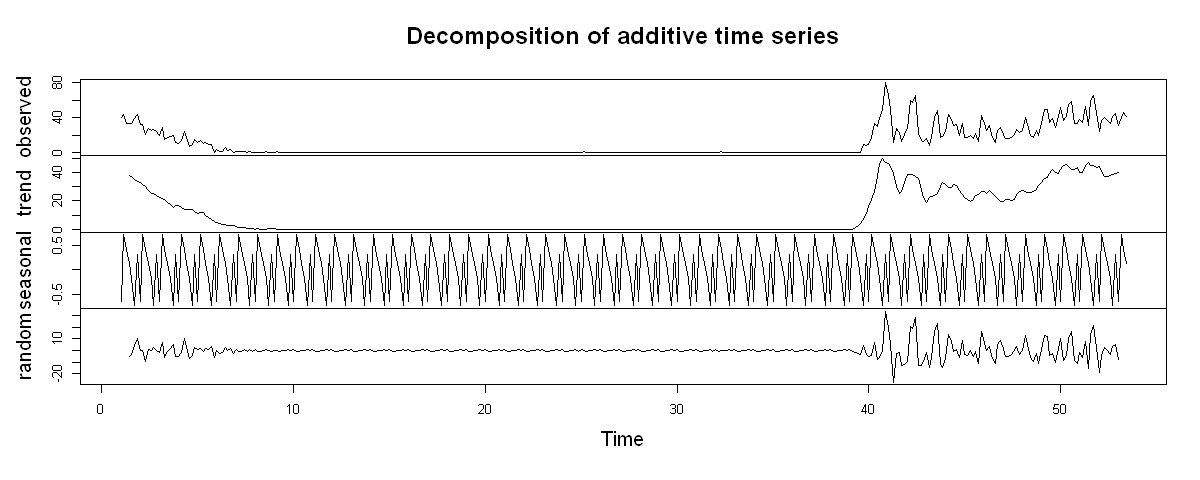

In [294]:
prod3_weekly_dec <- decompose(ts(prod3$sold_count, freq=7), type="additive")
plot(prod3_weekly_dec)

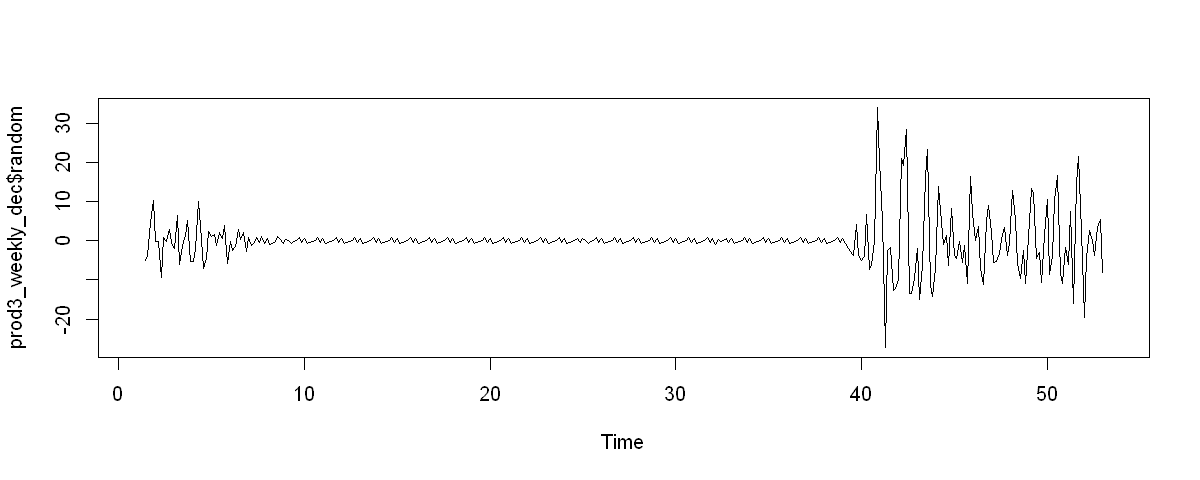

In [295]:
plot(prod3_weekly_dec$random)

* It seems that the decomposed data is not stationary. But, we should check the KPSS test result to determine whether it is stationary. 
* The mean is constant over time. 
* The variance changes. 

In [296]:
u_test <- ur.kpss(prod3_weekly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0067 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


Even though the variance changes over time, surprisingly, the test result says that the decomposed data is stationary. 

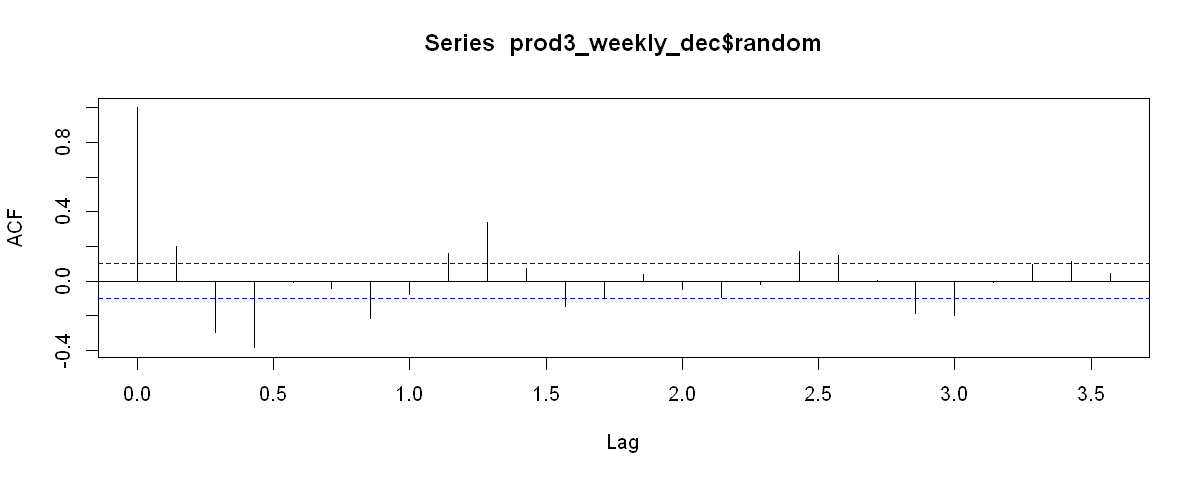

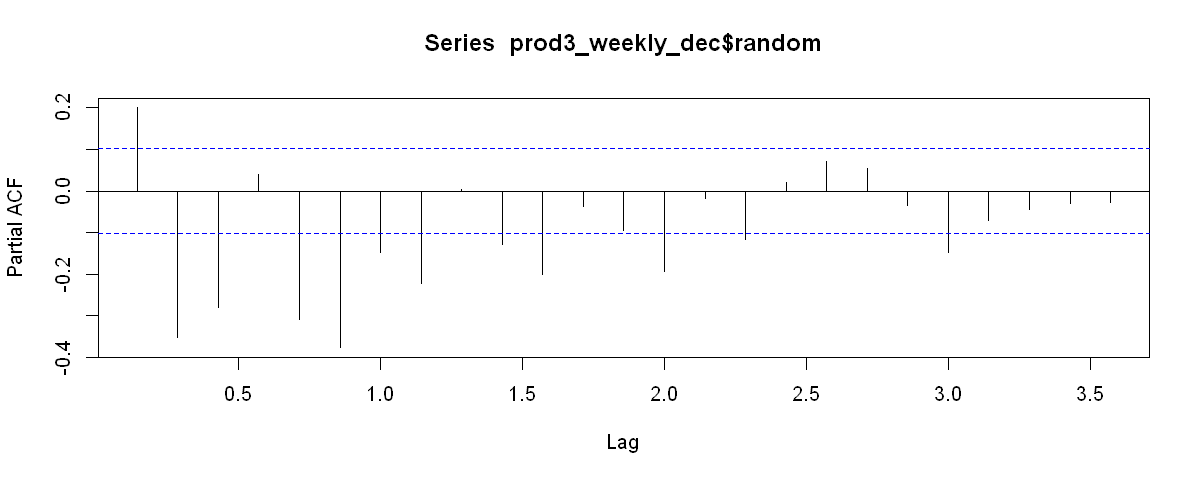

In [297]:
acf(prod3_weekly_dec$random, na.action=na.pass)
pacf(prod3_weekly_dec$random, na.action=na.pass)

At lag 2 and 6, there is relatively high correlations seen by the PACF graph. 

### Monthly Decomposition

month,sold_count
2020 May,266
2020 Jun,494
2020 Jul,24
2020 Aug,0
2020 Sep,0
2020 Oct,0
2020 Nov,1
2020 Dec,1
2021 Jan,0
2021 Feb,279


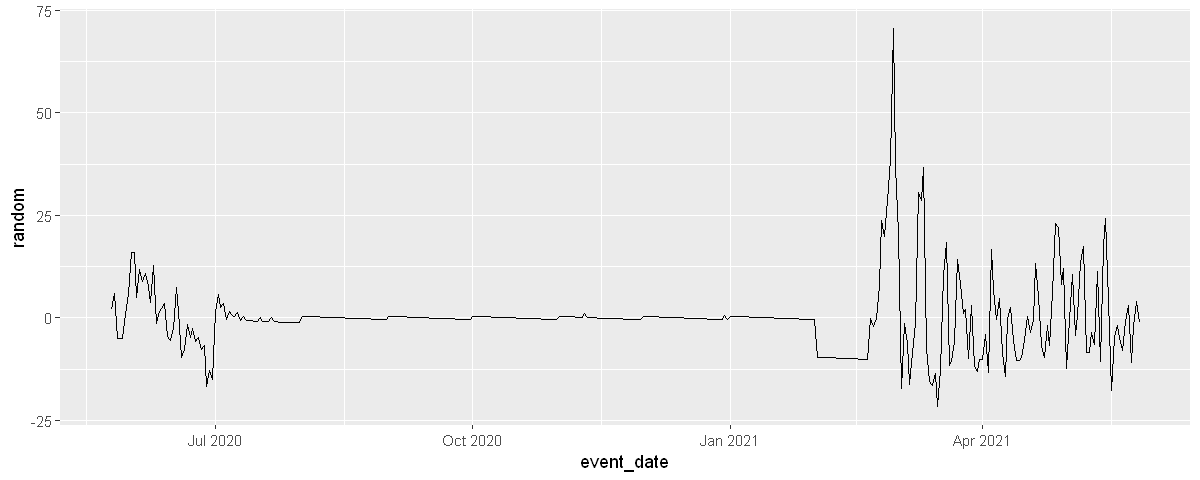

In [298]:
prod3_monthly <- prod3[, month:=yearmonth(event_date)]
prod3_monthly[, .(sold_count=sum(sold_count)), by=month]
prod3_monthly[, trend:=1:.N]

prod3_reg <- lm(sold_count~trend+as.factor(month), data=prod3_monthly)
prod3_monthly[, regOutput:=predict(prod3_reg, prod3_monthly)]

prod3_monthly[, random:=sold_count-regOutput]

ggplot(prod3_monthly, aes(x=event_date, y=random)) + geom_line()

* Again, the variance is not constant after decomposition. 
* The mean seems to be constant. 

In [299]:
u_test <- ur.kpss(prod3_monthly$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0279 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


According to the test result, we cannot reject the null hyphothesis. The decomposed data is stationary. 

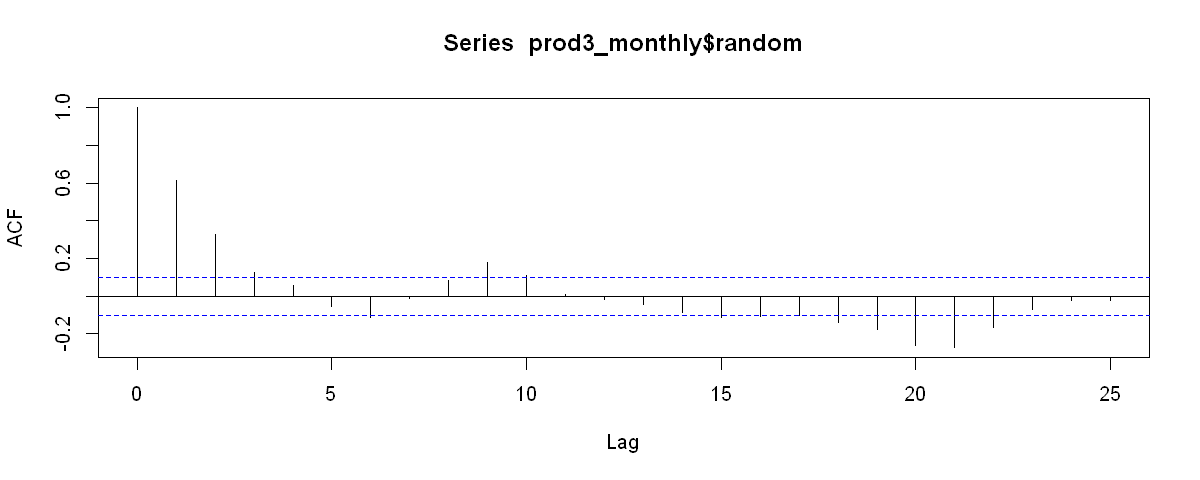

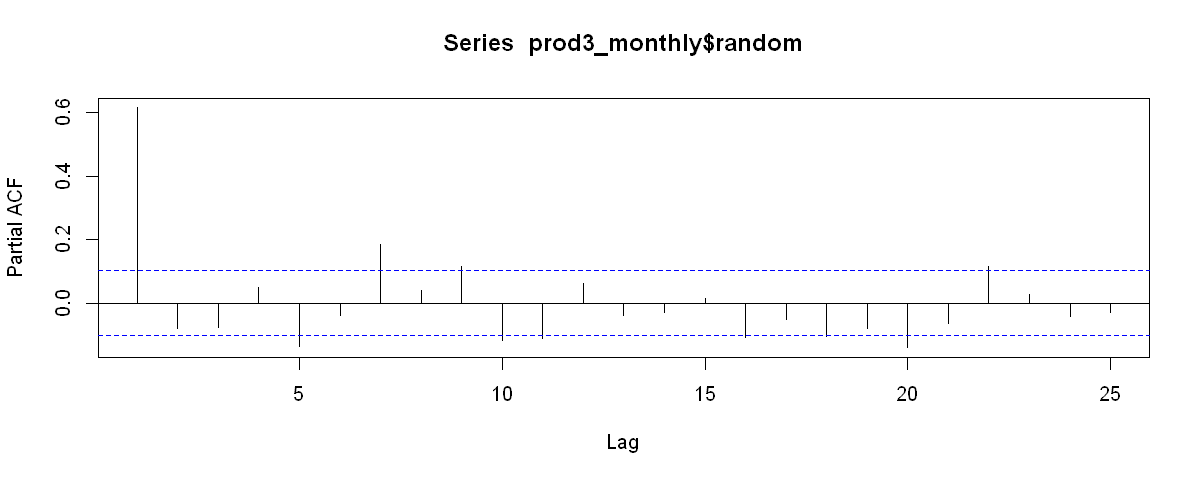

In [300]:
acf(prod3_monthly$random, na.action=na.pass)
pacf(prod3_monthly$random, na.action=na.pass)

From the graphs above, it can be said that the data is autocorrelated with its first lag. 

### Building an ARIMA Model

In [301]:
bikini2 <- data[product_content_id=="32737302",][order(event_date)]
bikini2$is_summer <- 0
bikini2[month(bikini2$event_date) %in% c(6,7,8),]$is_summer <- 1
bikini2_train <- bikini2[event_date<test_start,]
bikini2_ts <- ts(bikini2_train$sold_count,freq=9)

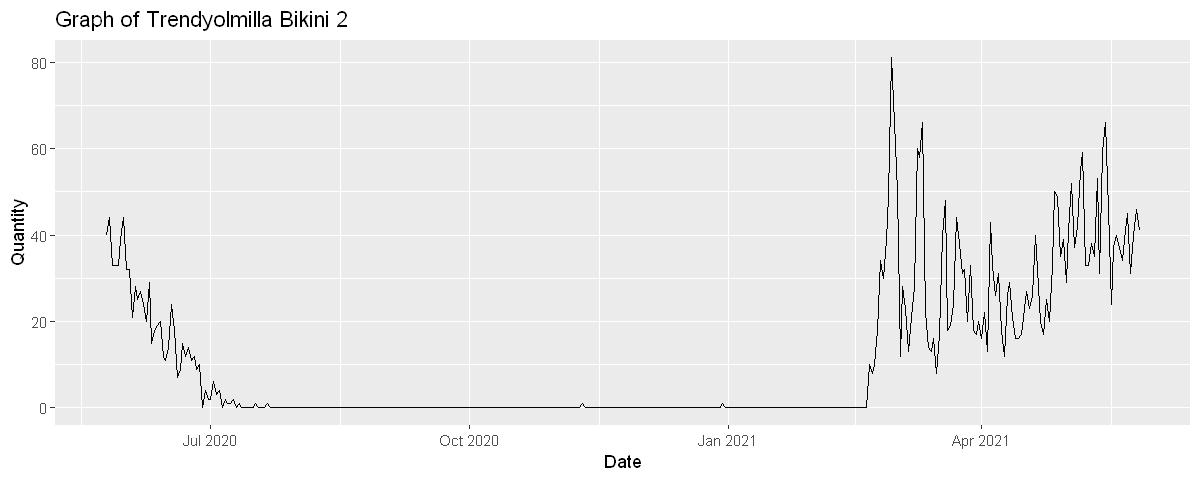

In [302]:
ggplot(bikini2_train,aes(x=event_date,y=sold_count)) + geom_line() +
  labs(title= "Graph of Trendyolmilla Bikini 2", x= "Date", y="Quantity")

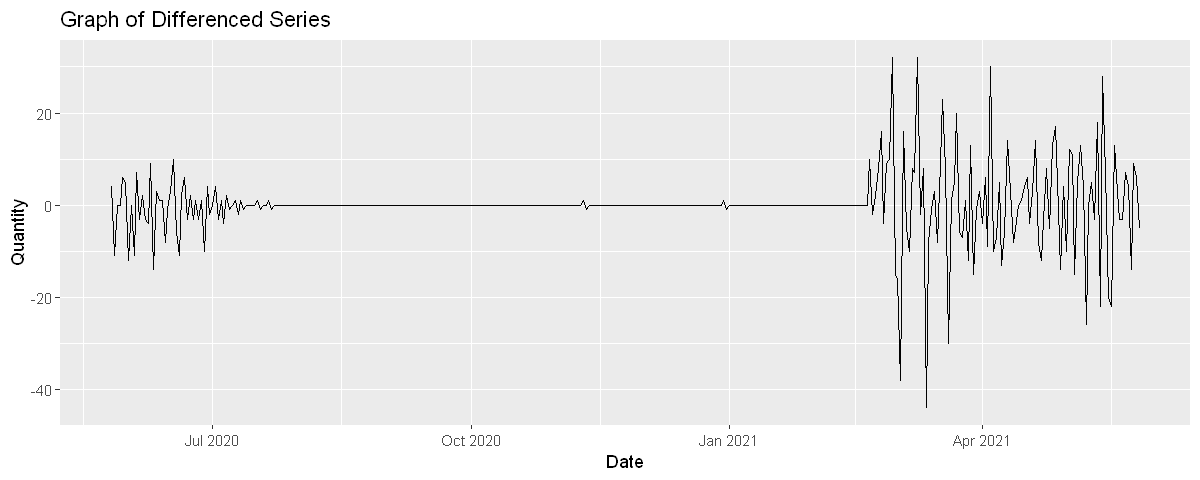

In [303]:
ggplot(bikini2_train[2:.N,],aes(x=event_date)) + geom_line(aes(y=diff(bikini2_train$sold_count,1))) + 
  labs(title= "Graph of Differenced Series", x= "Date", y="Quantity")

After the differencing, series seem more stationary now. According to the decomposition, there is a seasonal cycle at every 9 data points.

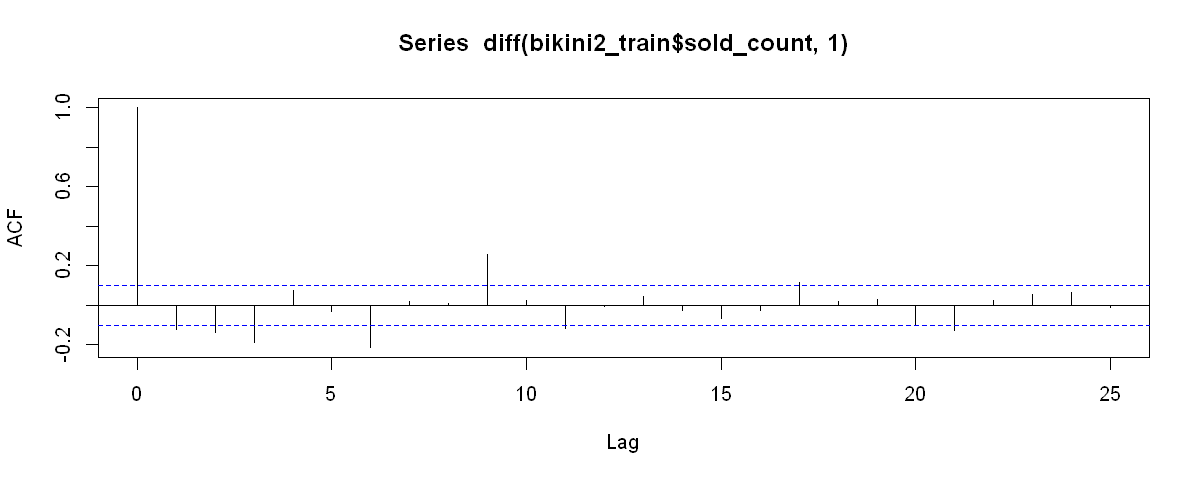

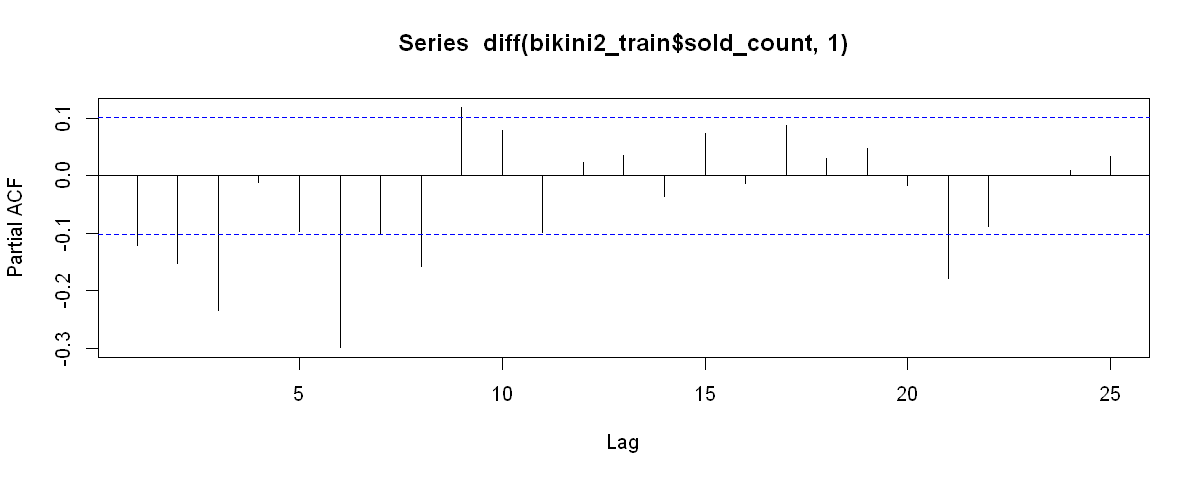

In [304]:
acf(diff(bikini2_train$sold_count,1))
pacf(diff(bikini2_train$sold_count,1))

After the analysis of ACF and PACF graphs, we could say that AR(1), AR(2), AR(3) and seasonal AR(1)-AR(2) could be tried. And also MA(2), MA(3) and seasonal MA(1)-MA(2) are strong candidates for a SARIMA model.

In [309]:
arima(bikini2_ts,order=c(1,1,2),seasonal=c(2,0,2))


Call:
arima(x = bikini2_ts, order = c(1, 1, 2), seasonal = c(2, 0, 2))

Coefficients:
         ar1      ma1      ma2    sar1     sar2     sma1     sma2
      0.4973  -0.7587  -0.0977  0.9484  -0.0892  -0.6536  -0.1968
s.e.  0.1099   0.1141   0.0772  0.3528   0.2148   0.3543   0.2514

sigma^2 estimated as 41.76:  log likelihood = -1206.21,  aic = 2428.42

In [310]:
arima(bikini2_ts,order=c(1,1,3),seasonal=c(2,0,2))


Call:
arima(x = bikini2_ts, order = c(1, 1, 3), seasonal = c(2, 0, 2))

Coefficients:
          ar1     ma1      ma2      ma3    sar1    sar2     sma1     sma2
      -0.2620  0.0335  -0.2677  -0.3652  0.8342  0.0368  -0.5621  -0.3158
s.e.   0.1306  0.1243   0.0531   0.0699  0.2916  0.2454   0.2892   0.2627

sigma^2 estimated as 40.74:  log likelihood = -1201.8,  aic = 2421.6

In [311]:
arima(bikini2_ts,order=c(3,1,3),seasonal=c(2,0,2))

Warning message in arima(bikini2_ts, order = c(3, 1, 3), seasonal = c(2, 0, 2)):
"possible convergence problem: optim gave code = 1"


Call:
arima(x = bikini2_ts, order = c(3, 1, 3), seasonal = c(2, 0, 2))

Coefficients:
          ar1      ar2     ar3     ma1      ma2      ma3    sar1     sar2
      -0.6159  -0.2078  0.4195  0.4067  -0.1174  -0.8729  0.9132  -0.0851
s.e.   0.0701   0.0879  0.0694  0.0428   0.0526   0.0432  0.3979   0.2365
         sma1     sma2
      -0.6152  -0.2018
s.e.   0.4014   0.2921

sigma^2 estimated as 38.24:  log likelihood = -1193.01,  aic = 2408.02

In [312]:
arima(bikini2_ts,order=c(3,1,3),seasonal=c(1,0,1))


Call:
arima(x = bikini2_ts, order = c(3, 1, 3), seasonal = c(1, 0, 1))

Coefficients:
          ar1      ar2     ar3     ma1      ma2      ma3     sar1    sma1
      -0.6180  -0.2056  0.4218  0.4062  -0.1219  -0.8754  -0.0187  0.3176
s.e.   0.0705   0.0886  0.0693  0.0441   0.0533   0.0448   0.1941  0.1860

sigma^2 estimated as 38.34:  log likelihood = -1193.43,  aic = 2404.86

In [313]:
auto.arima(bikini2_ts)

Series: bikini2_ts 
ARIMA(2,1,1)(1,0,0)[9] 

Coefficients:
         ar1      ar2      ma1    sar1
      0.6124  -0.0596  -0.8741  0.2709
s.e.  0.0678   0.0595   0.0463  0.0531

sigma^2 estimated as 42.58:  log likelihood=-1207.61
AIC=2425.23   AICc=2425.4   BIC=2444.76

The best model is SARIMA(3,1,3)(1,0,1) with AIC value 2404.86.


	Ljung-Box test

data:  Residuals from ARIMA(3,1,3)(1,0,1)[9]
Q* = 12.761, df = 10, p-value = 0.2373

Model df: 8.   Total lags used: 18



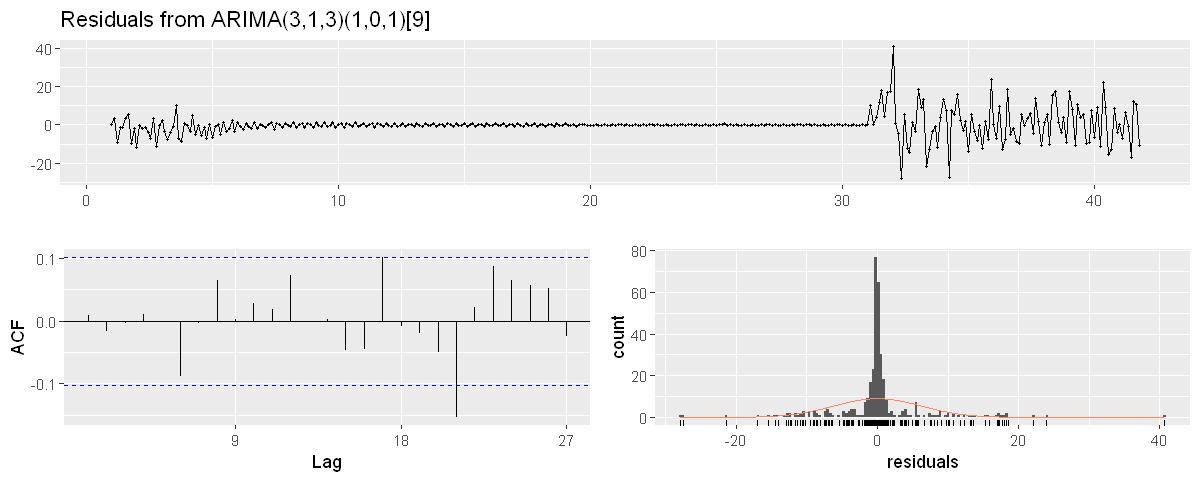

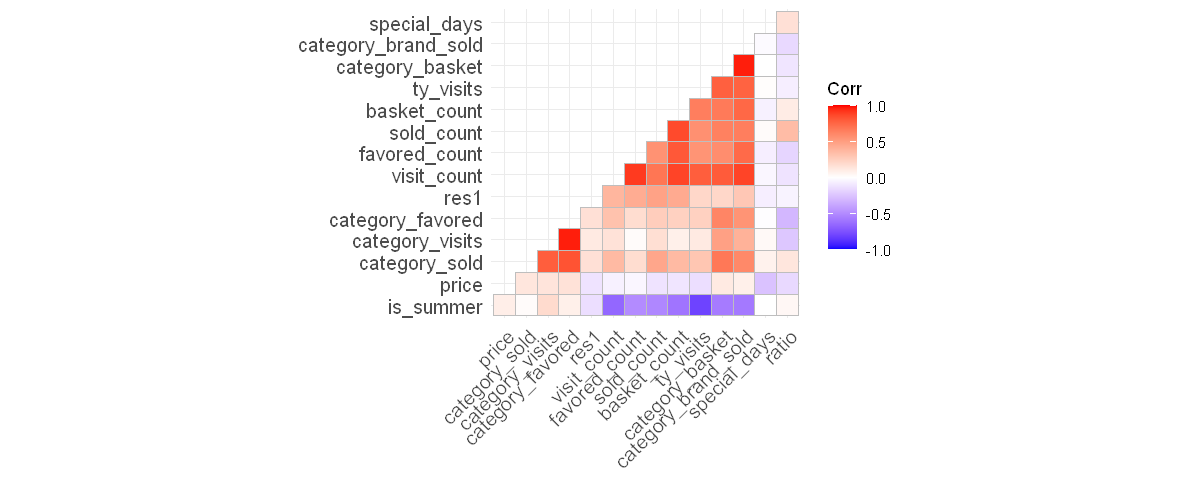

In [314]:
model_bikini2_sarima <- arima(bikini2_ts,order=c(3,1,3),seasonal=c(1,0,1))
checkresiduals(model_bikini2_sarima)
bikini2_train$res1 <- model_bikini2_sarima$residuals
corr <- cor(bikini2_train[!is.na(bikini2_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Residuals have constant mean at 0 and constant variance. Distribution seems normal. Due to the correlation with residuals, basket_count could be added as a regressor.

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


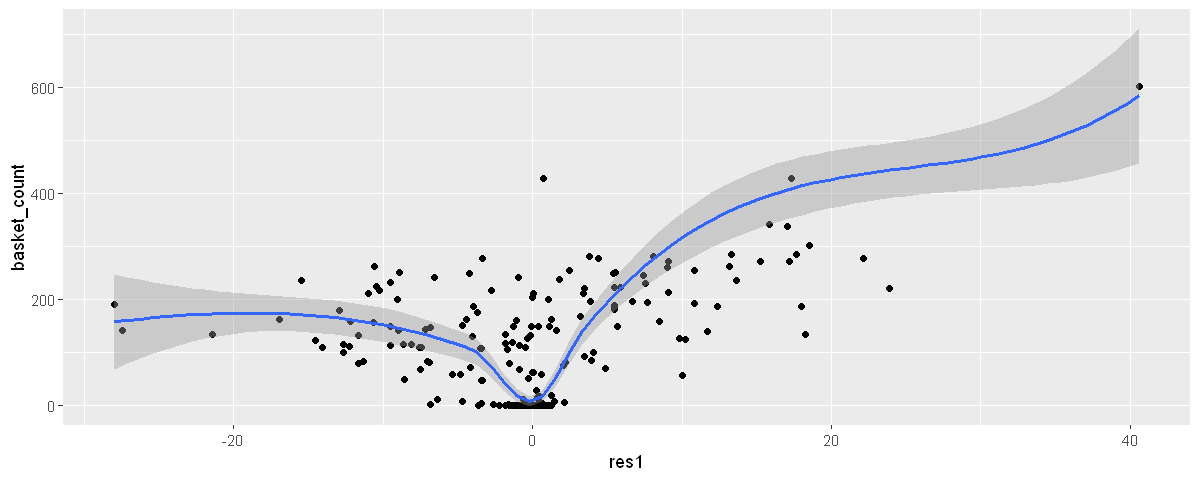

In [315]:
ggplot(bikini2_train,aes(x=res1,y=basket_count)) +  geom_point() + geom_smooth()

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


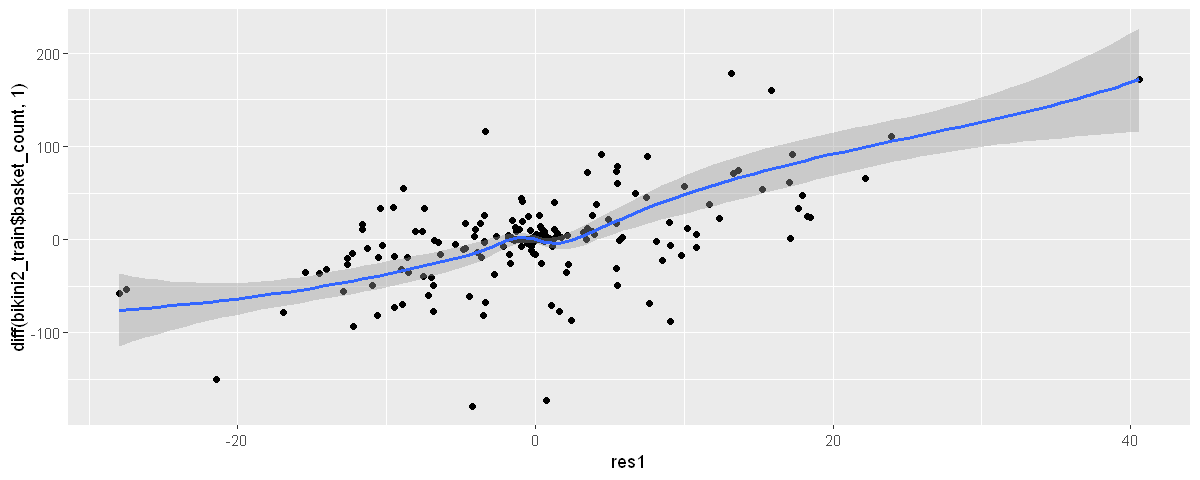

In [316]:
ggplot(bikini2_train[2:.N],aes(x=res1)) +  geom_point(aes(y=diff(bikini2_train$basket_count,1))) + 
geom_smooth(aes(y=diff(bikini2_train$basket_count,1)))

In [317]:
cor(bikini2_train[2:.N]$res1,diff(bikini2_train$basket_count,1))
bikini2_train$diff_basket <- c(NA,diff(bikini2_train$basket_count,1))
bikini2$diff_basket <- c(NA,diff(bikini2$basket_count,1))

[1] 0.5624055


	Ljung-Box test

data:  Residuals from ARIMA(3,1,3)(1,0,1)[9]
Q* = 15.515, df = 9, p-value = 0.07773

Model df: 9.   Total lags used: 18



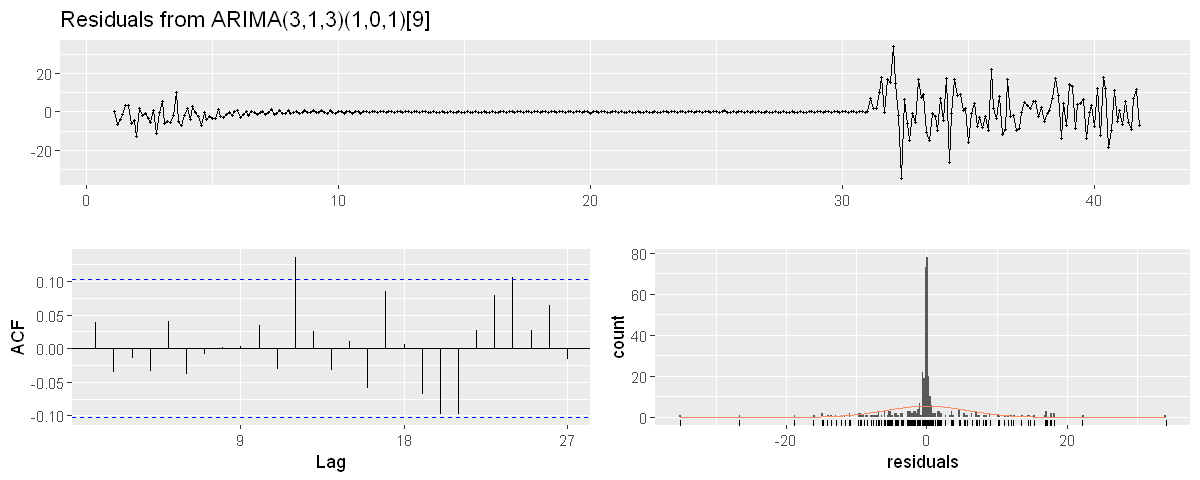

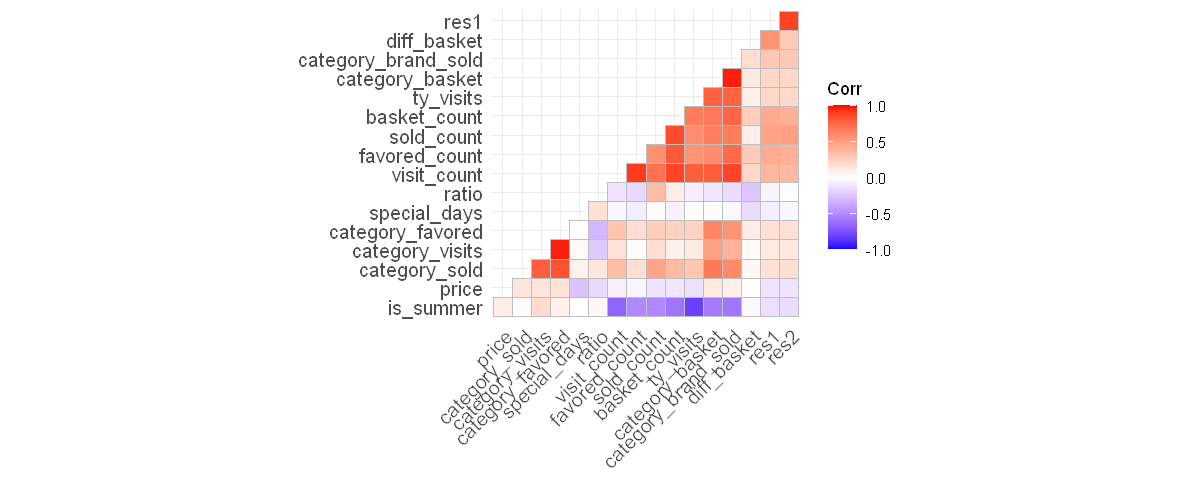

In [318]:
model_bikini2_arimax <- arima(bikini2_ts,order=c(3,1,3),seasonal=c(1,0,1),xreg=bikini2_train$diff_basket)
checkresiduals(model_bikini2_arimax)
bikini2_train$res2 <- model_bikini2_arimax$residuals
corr <- cor(bikini2_train[!is.na(bikini2_train$price) & !is.na(bikini2_train$res2),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

### Linear Models

Firstly, the days of week and trend columns will be added to the data. Next, the first model will be built with trend and weekly seasonality. Then, we'll look for possible regressors and add them to the model. Finally, we will find the best model among them. 

In [319]:
prod3[, `:=`(trend=1:.N, 
            days=wday(event_date, label=T))]

model3_1 <- lm(sold_count~trend+days, data=prod3)
summary(model3_1)


Call:
lm(formula = sold_count ~ trend + days, data = prod3)

Residuals:
    Min      1Q  Median      3Q     Max 
-17.681 -10.241  -4.269   5.879  63.608 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.704748   1.555704  -1.739    0.083 .  
trend        0.072121   0.007307   9.870   <2e-16 ***
days.L      -0.781163   2.060793  -0.379    0.705    
days.Q      -1.353806   2.057072  -0.658    0.511    
days.C      -0.021379   2.055235  -0.010    0.992    
days^4       0.527653   2.053988   0.257    0.797    
days^5      -0.465548   2.049616  -0.227    0.820    
days^6       0.362088   2.046213   0.177    0.860    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 14.89 on 360 degrees of freedom
Multiple R-squared:  0.2143,	Adjusted R-squared:  0.199 
F-statistic: 14.03 on 7 and 360 DF,  p-value: 4.214e-16


It seems that days are insignificant. They will be removed from the model. Residual analysis will be made on the final model. Now, we will check for the possible regressors. 

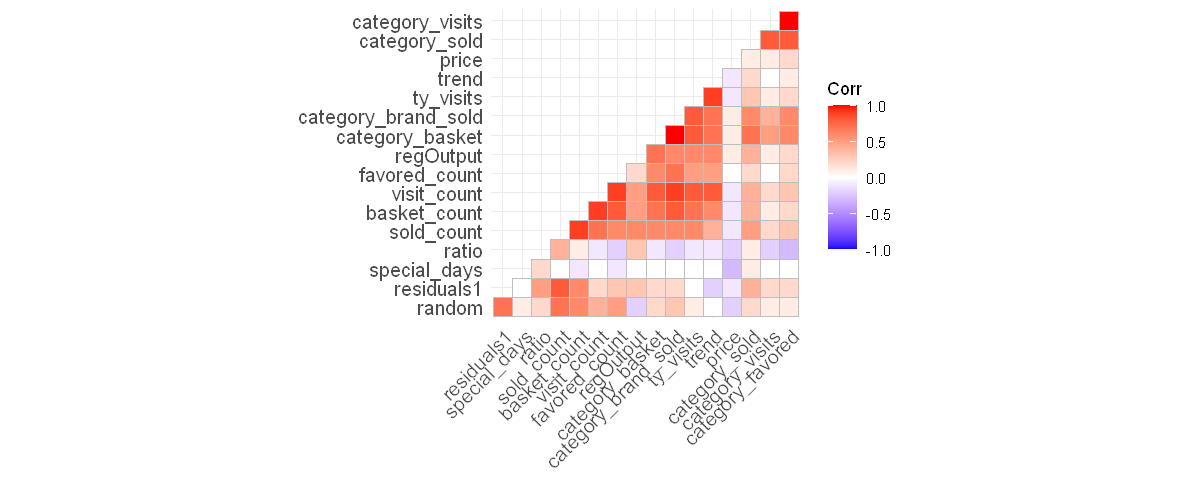

In [321]:
temp <- lm(sold_count~trend, data=prod3)
prod3[, residuals1:=temp$residuals]
corr <- round(cor(Filter(is.numeric, prod3[!is.na(prod3$price)])), 1)
ggcorrplot(corr, hc.order = TRUE,type = "lower")

The maximum correlation with residuals1 is obtained by basket_count. Therefore, its lagged version will be added to the model. To find the lag value, we'll check the CCF function. 

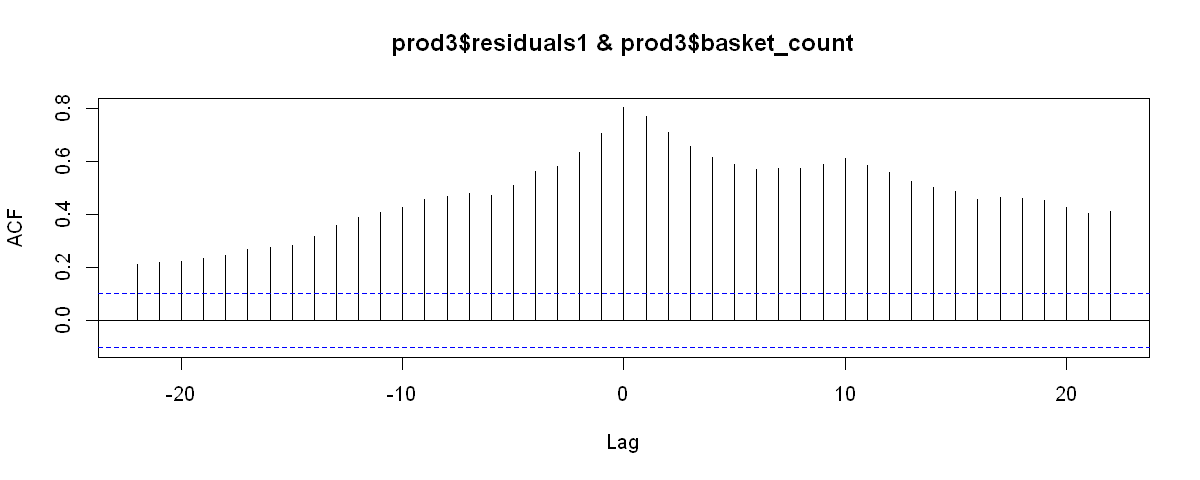

In [322]:
ccf(prod3$residuals1, prod3$basket_count)

In [323]:
model3_2 <- lm(sold_count~trend+shift(basket_count,1), data=prod3)
summary(model3_2)


Call:
lm(formula = sold_count ~ trend + shift(basket_count, 1), data = prod3)

Residuals:
     Min       1Q   Median       3Q      Max 
-29.0056  -0.8440  -0.8036  -0.7433  31.6141 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.7406904  0.6825720   1.085    0.279    
trend                  0.0004191  0.0036850   0.114    0.910    
shift(basket_count, 1) 0.1566509  0.0040083  39.081   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.428 on 364 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.8507,	Adjusted R-squared:  0.8499 
F-statistic:  1037 on 2 and 364 DF,  p-value: < 2.2e-16


Adjusted Rsqr value is 0.8499. From the correlation tableau, let's find a second regressor. 

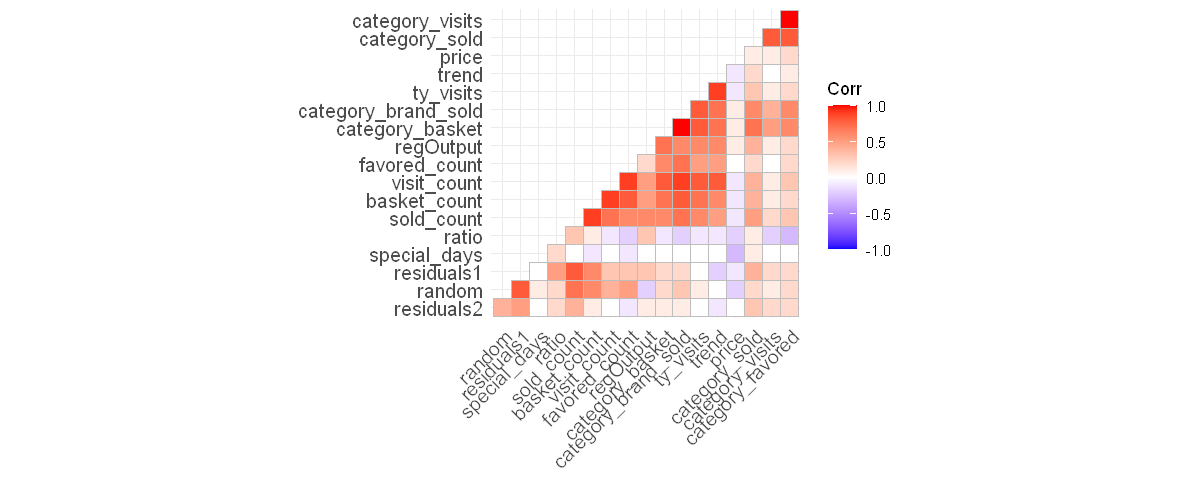

In [325]:
prod3[, residuals2:=c(NA, model3_2$residuals)]
corr <- round(cor(Filter(is.numeric, prod3[!is.na(prod3$price) & !is.na(prod3$residuals2)])), 1)
ggcorrplot(corr, hc.order = TRUE,type = "lower")

It seems that there is not another good regressor. Next, the lagged sold_count will be examined. 

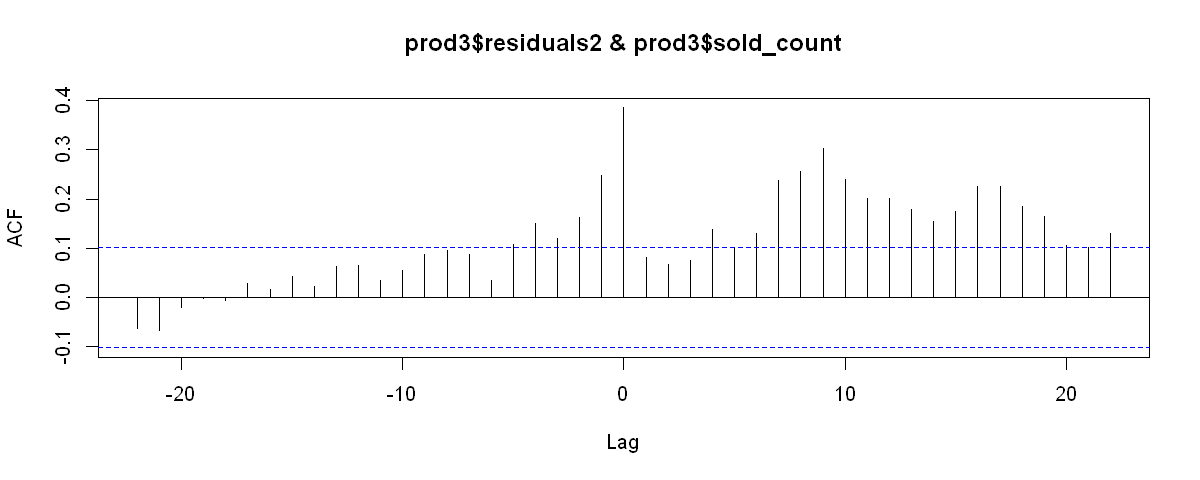

In [326]:
ccf(prod3$residuals2, prod3$sold_count, na.action=na.pass)

In [327]:
model3_3 <- lm(sold_count~trend+shift(basket_count,1)+shift(sold_count,1), data=prod3)
summary(model3_3)


Call:
lm(formula = sold_count ~ trend + shift(basket_count, 1) + shift(sold_count, 
    1), data = prod3)

Residuals:
     Min       1Q   Median       3Q      Max 
-30.8354  -0.8569  -0.6361  -0.4246  26.4860 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.284785   0.665472   0.428    0.669    
trend                  0.002312   0.003580   0.646    0.519    
shift(basket_count, 1) 0.104113   0.010866   9.581  < 2e-16 ***
shift(sold_count, 1)   0.319444   0.061730   5.175 3.78e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.212 on 363 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.8609,	Adjusted R-squared:  0.8598 
F-statistic: 749.2 on 3 and 363 DF,  p-value: < 2.2e-16



	Breusch-Godfrey test for serial correlation of order up to 10

data:  Residuals
LM test = 39.465, df = 10, p-value = 2.104e-05


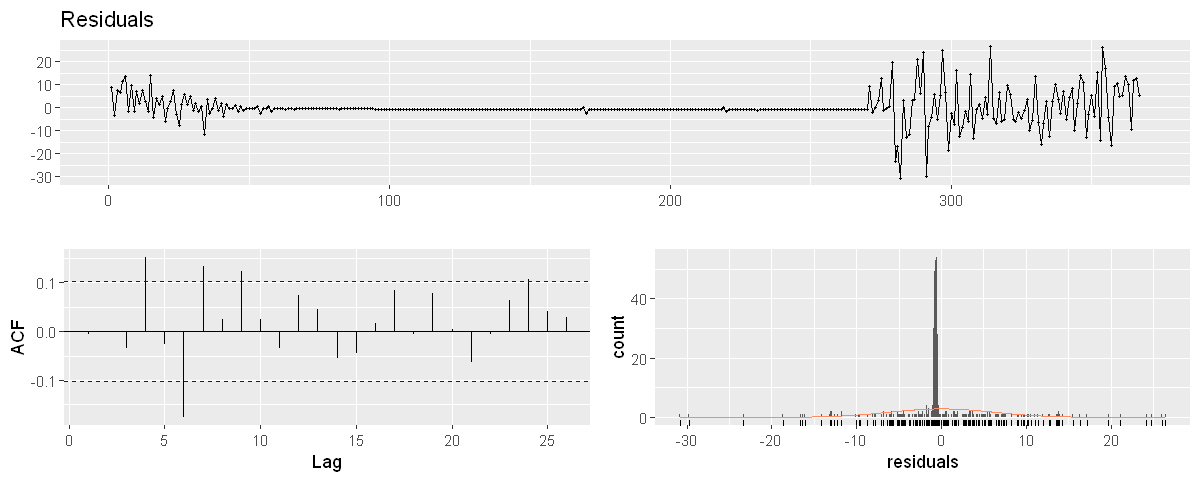

In [328]:
checkresiduals(model3_3)

In the last model, adjusted Rsqr has increased to 0.8598, which is a good value. But when it comes to the residual analysis, there are some problems. Because the prod3 data was dirty, the residuals are also dirty. We cannot say that the variance is constant over time. Plus, the residuals are not normally distributed but the mean of the residuals are near zero. Also, there is not a significant autocorrelation. model3_3 is the final model. 

Warning message:
"Removed 1 rows containing missing values (geom_point)."

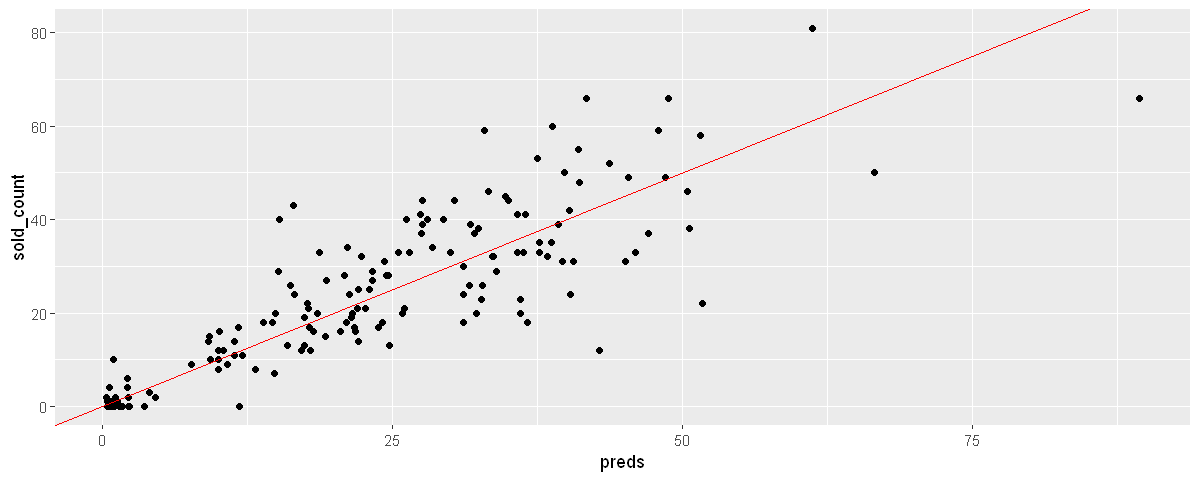

In [329]:
prod3[, preds:=c(NA,model3_3$fitted.values)]
ggplot(prod3, aes(x=preds, y=sold_count)) + geom_point() + geom_abline(intercept=0, slope=1, color="red") 

### Forecasting 

In [476]:
forecast_data_bikini2 <- data.table(event_date=bikini2[event_date>=test_start&event_date<=test_end,]$event_date,
                                 sold_count=bikini2[event_date>=test_start&event_date<=test_end,]$sold_count)
bikini2[,`:=`(trend=1:.N,
           days=wday(event_date, label=T))]
sarima_fc <- numeric(0)
sarimax_fc <- numeric(0)
reg_fc <- numeric(0)
for(i in 1:length(test_dates)){
  
  train_dt <- bikini2[event_date<test_dates[i],]
  model_sarima <- Arima(train_dt$sold_count,order=c(3,1,3),seasonal=c(1,0,1))
  model_sarimax <- Arima(train_dt$sold_count,order=c(3,1,3),seasonal=c(1,0,1),xreg=train_dt$diff_basket)
  model_reg <- lm(sold_count~trend+shift(basket_count,1)+shift(sold_count,1), data=train_dt)
  newreg <- forecast(auto.arima(train_dt$diff_basket),h=1)$mean[1]
  sarima_temp <- forecast(model_sarima)
  sarimax_temp <- forecast(model_sarimax,xreg=newreg)
  reg_temp <- predict(model_reg,newdata=bikini2[event_date %in% c(test_dates[i],test_dates[i+1])])
  sarima_fc <- c(sarima_fc,sarima_temp$mean[1])
  sarimax_fc <- c(sarimax_fc,sarimax_temp$mean[1])
  reg_fc <- c(reg_fc,reg_temp)
  
}
reg_fc[is.na(reg_fc)] <- mean(reg_fc[!is.na(reg_fc)])
forecast_data_bikini2 <- forecast_data_bikini2[,`:=`(sarima_p=sarima_fc,
                                               sarimax_p=sarimax_fc,
                                               reg_p=reg_fc[c(1,seq(2,28,2))])]
accu(forecast_data_bikini2$sold_count,forecast_data_bikini2$sarima_p)
accu(forecast_data_bikini2$sold_count,forecast_data_bikini2$sarimax_p)
accu(forecast_data_bikini2[1:(.N-1)]$sold_count,forecast_data_bikini2[2:.N]$reg_p)


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
15,49.93333,11.71974,0.2347078,0.01706733,0.194244,11.81797,9.25744,0.185396,0.185396


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
15,49.93333,11.71974,0.2347078,0.01097355,0.217304,13.23445,10.65657,0.2134159,0.2134159


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
14,50.85714,11.58153,0.2277267,0.1489639,0.1521629,10.45751,8.379918,0.1647737,0.1647737


In [479]:
result_data_bikini2 <- data.table(event_date=bikini2[event_date>=result_start&event_date<=result_end,]$event_date,
                               sold_count=bikini2[event_date>=result_start&event_date<=result_end,]$sold_count)
final_fc <- numeric(0)
for(i in 1:length(result_dates)){
  
  train_dt <- bikini2[event_date<result_dates[i],]
  model_final <- lm(sold_count~trend+shift(basket_count,1)+shift(sold_count,1), data=train_dt)
  final_temp <- predict(model_final,newdata=bikini2[event_date %in% c(result_dates[i],result_dates[i+1])])
  final_fc <- c(final_fc,final_temp)
  
}
final_fc[is.na(final_fc)] <- mean(final_fc[!is.na(final_fc)])
result_data_bikini2 <- result_data_bikini2[,`:=`(final_p=final_fc[c(1,seq(2,28,2))])]
accu(result_data_bikini2[1:(.N-1)]$sold_count,result_data_bikini2[2:.N]$final_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
14,72.5,21.43595,0.2956683,0.08923879,0.09759226,9.705456,7.737914,0.1067299,0.1067299


In [480]:
data.frame(event_date=result_data_bikini2[1:(.N-1)]$event_date,
           sold_count=result_data_bikini2[1:(.N-1)]$sold_count,
           predictions=result_data_bikini2[2:.N]$final_p)

event_date,sold_count,predictions
2021-06-12,41,35.11754
2021-06-13,73,63.48856
2021-06-14,88,75.21750
2021-06-15,88,72.36864
2021-06-16,104,81.69486
2021-06-17,102,109.83913
2021-06-18,76,72.34001
2021-06-19,43,44.03759
2021-06-20,76,72.16040
2021-06-21,53,50.71460


### Trendyolmilla Bikini1

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


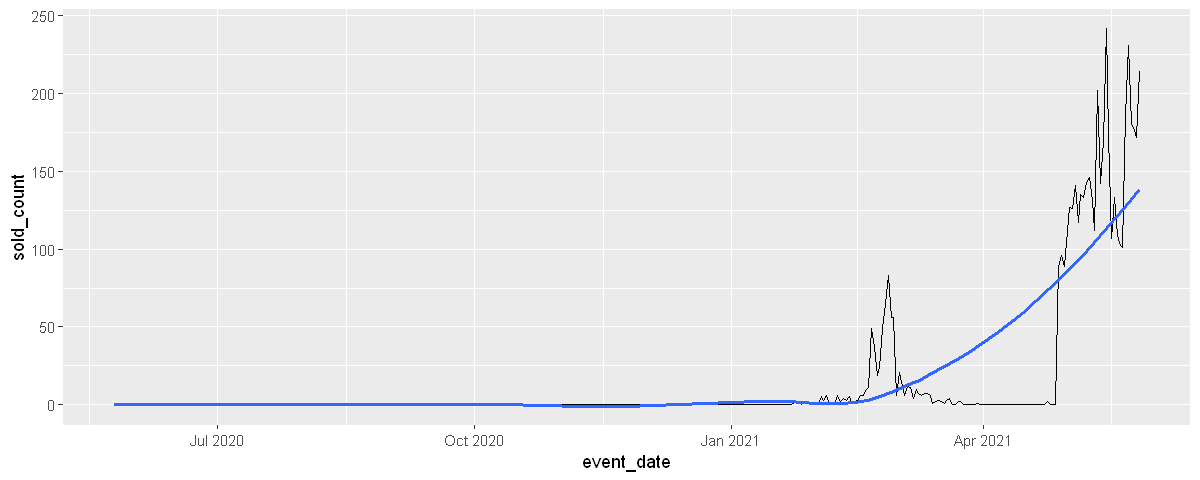

In [330]:
ggplot(prod2, aes(x=event_date, y=sold_count)) + geom_line() + geom_smooth(se=F)

* Until February 2021, there is no sales. The product may be introduced in February 2021. 
* The mean and variance are not constant over time. 

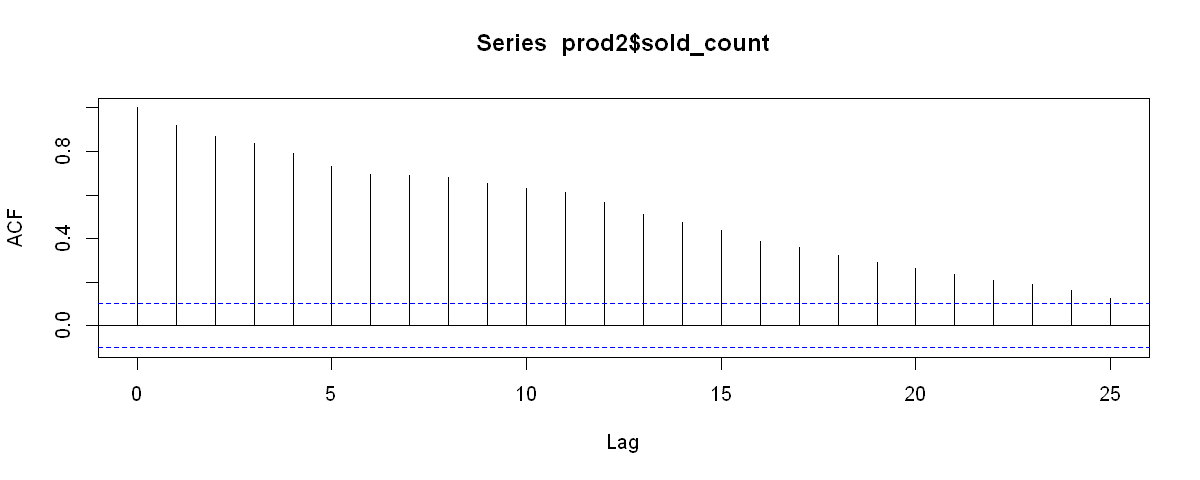

In [331]:
acf(prod2$sold_count) 

There is decrease in ACF graph which may mean that there is a trend on the data. 

### Weekly Decomposition

Additive decomposition will be used because the variance does not increase. 

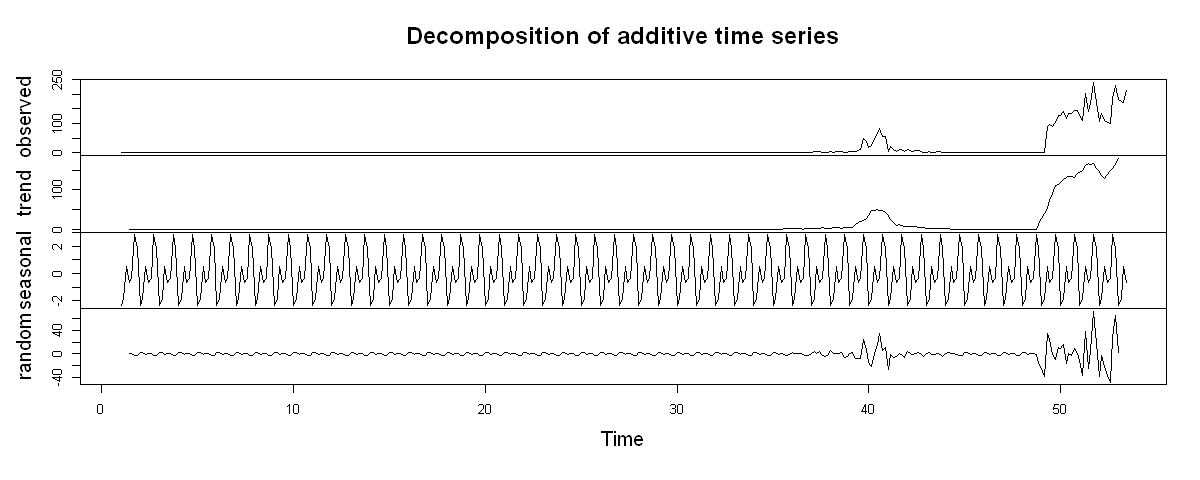

In [332]:
prod2_weekly_dec <- decompose(ts(prod2$sold_count, freq=7), type="additive")
plot(prod2_weekly_dec)

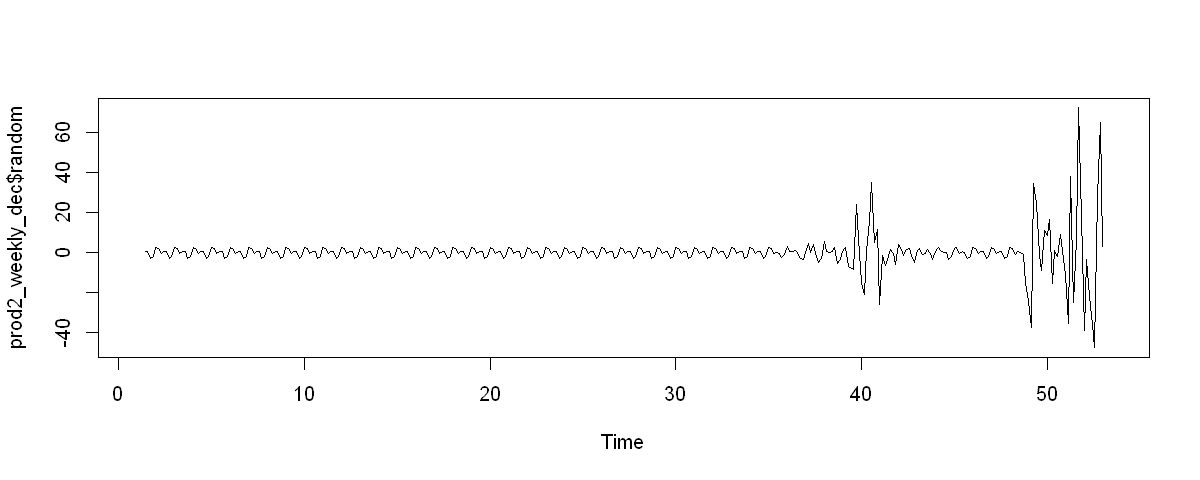

In [333]:
plot(prod2_weekly_dec$random)

* The mean is constant. 
* The variance is changing over time. It is higher at the last part of the data. 

In [334]:
u_test <- ur.kpss(prod2_weekly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0128 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


From the KPSS test above, the data is stationary. 

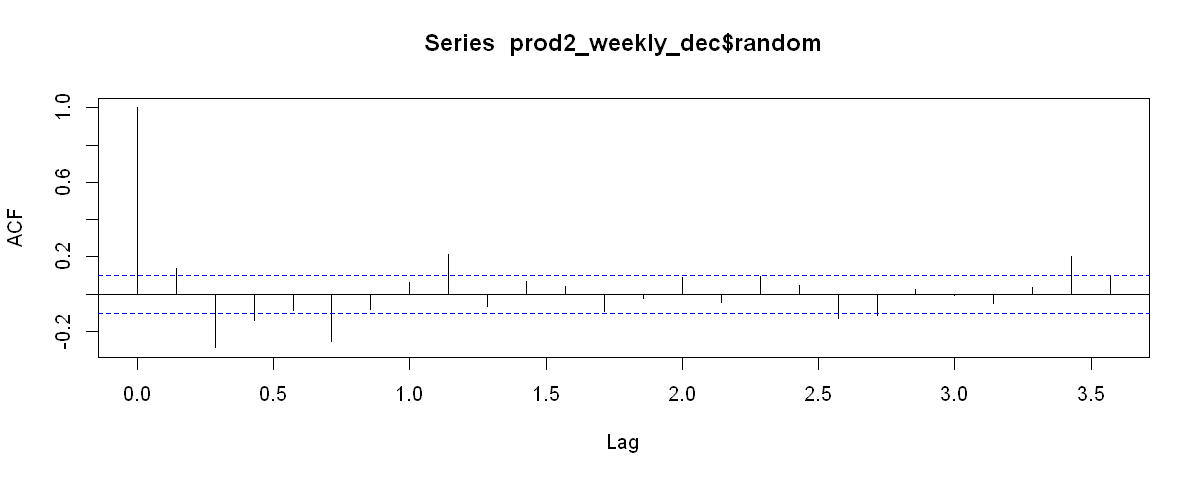

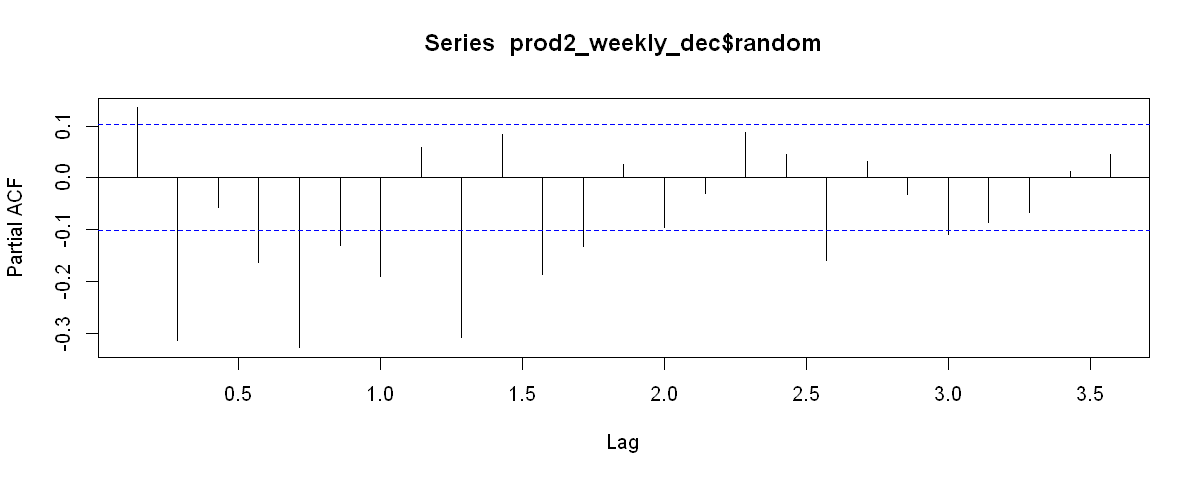

In [335]:
acf(prod2_weekly_dec$random, na.action=na.pass)
pacf(prod2_weekly_dec$random, na.action=na.pass)

There are a little correlation at lag 2 and lag 5. We can see them on the PACF graph. 

### Monthly Decomposition

month,sold_count
2020 May,0
2020 Jun,0
2020 Jul,0
2020 Aug,0
2020 Sep,0
2020 Oct,0
2020 Nov,0
2020 Dec,0
2021 Jan,9
2021 Feb,514


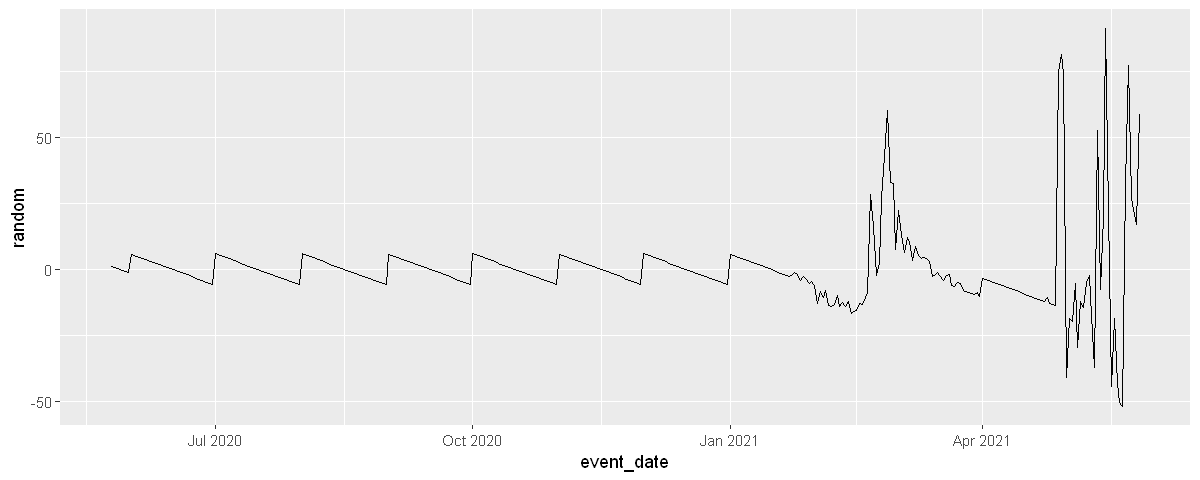

In [336]:
prod2_monthly <- prod2[, month:=yearmonth(event_date)]
prod2_monthly[, .(sold_count=sum(sold_count)), by=month]
prod2_monthly[, trend:=1:.N]

prod2_reg <- lm(sold_count~trend+as.factor(month), data=prod2_monthly)
prod2_monthly[, regOutput:=predict(prod2_reg, prod2_monthly)]

prod2_monthly[, random:=sold_count-regOutput]

ggplot(prod2_monthly, aes(x=event_date, y=random)) + geom_line()

* The variance is changing at the last part. 
* It is seen that the mean is constant over time.

In [337]:
u_test <- ur.kpss(prod2_monthly$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0318 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


From the unit test, the data is stationary. 

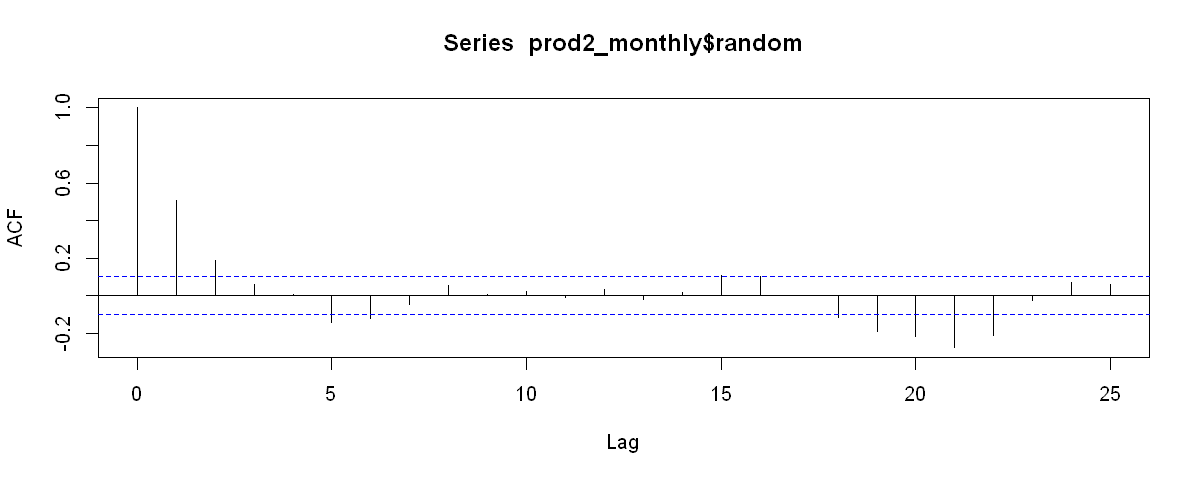

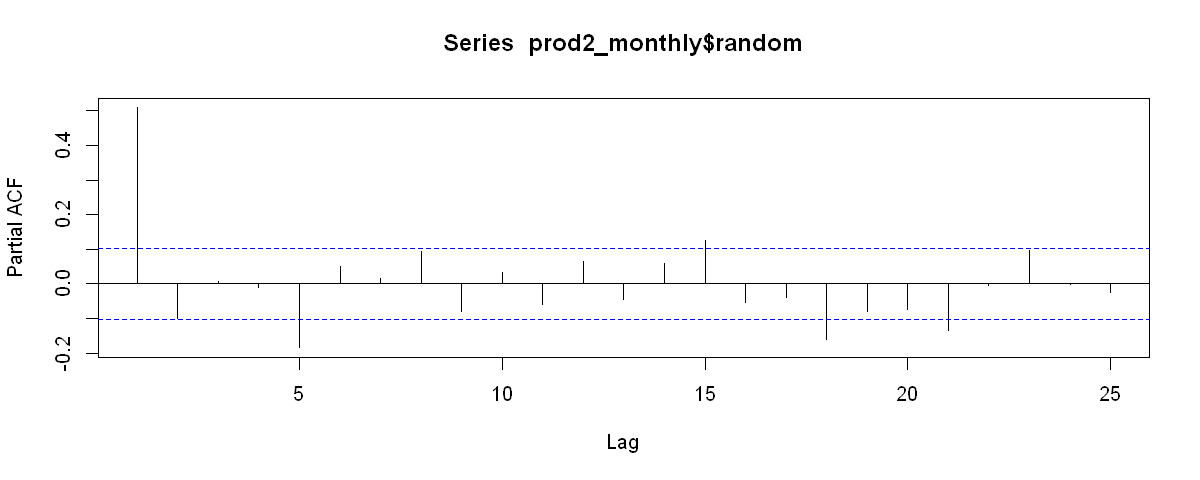

In [338]:
acf(prod2_monthly$random, na.action=na.pass)
pacf(prod2_monthly$random, na.action=na.pass)

The first lag has a high correlation value. 

### Building an ARIMA Model 

In [339]:
bikini1 <- data[product_content_id=="73318567",][order(event_date)]
bikini1_train <- bikini1[event_date<test_start,]
bikini1_ts <- ts(bikini1_train$sold_count)

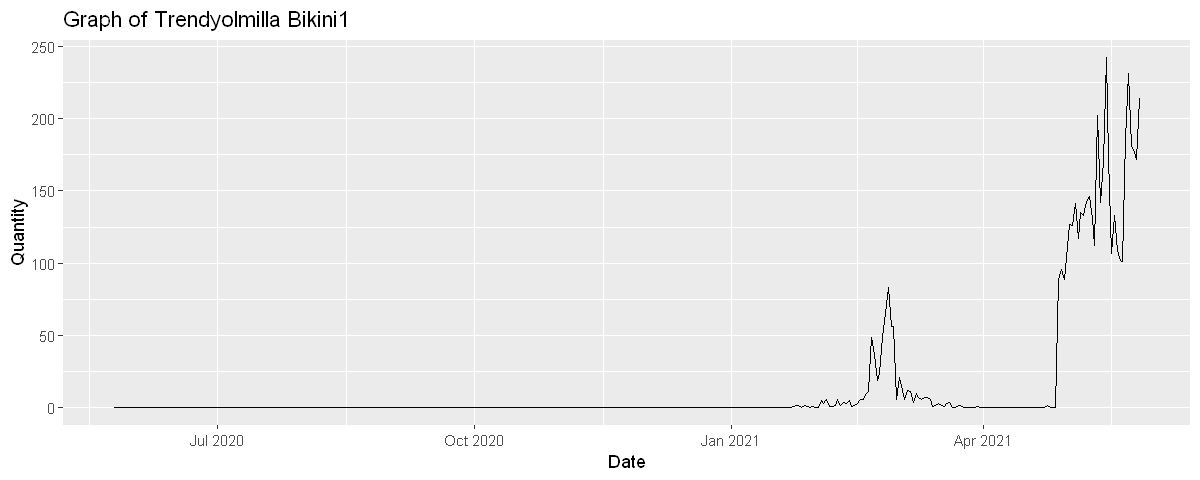

In [340]:
ggplot(bikini1_train,aes(x=event_date,y=sold_count)) + geom_line() +
  labs(title= "Graph of Trendyolmilla Bikini1", x= "Date", y="Quantity")

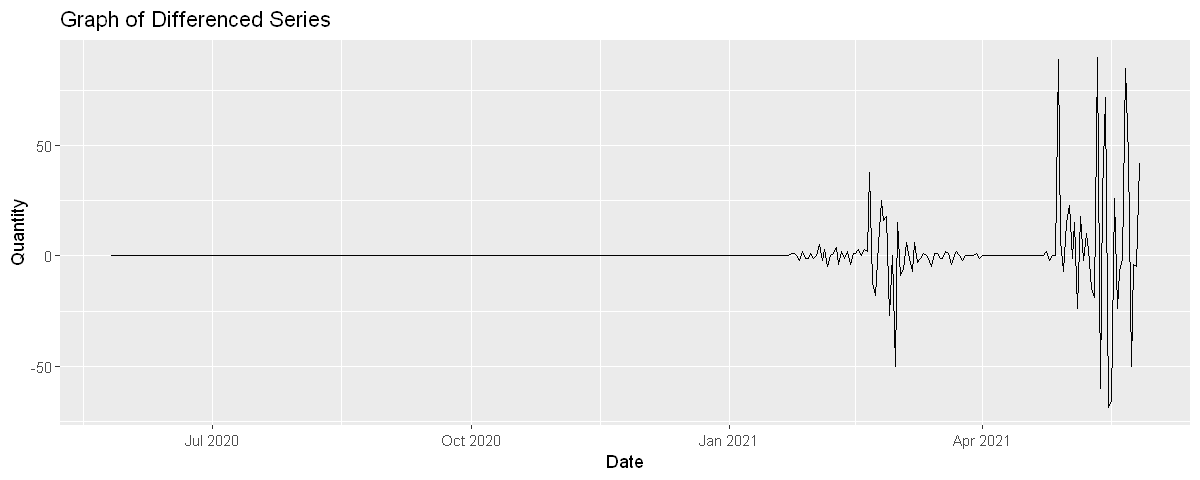

In [341]:
ggplot(bikini1_train[2:.N,],aes(x=event_date)) + geom_line(aes(y=diff(bikini1_train$sold_count,1))) + 
  labs(title= "Graph of Differenced Series", x= "Date", y="Quantity")

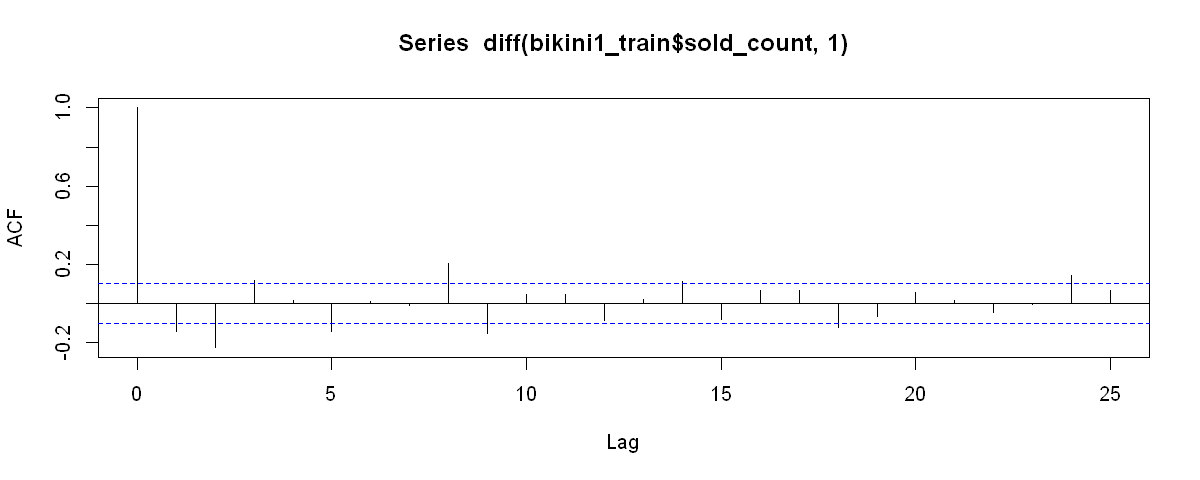

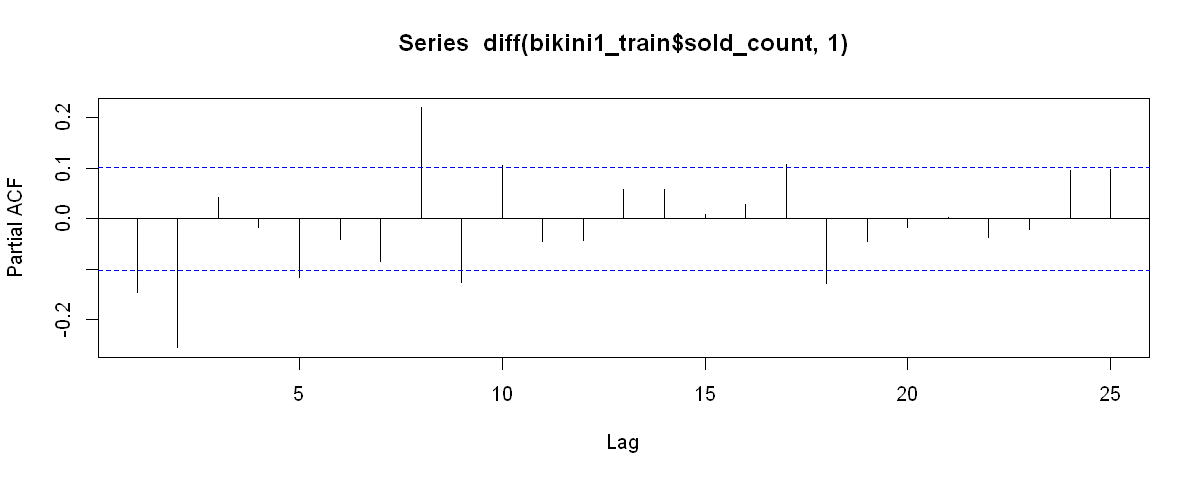

In [342]:
acf(diff(bikini1_train$sold_count,1))
pacf(diff(bikini1_train$sold_count,1))

According to the ACF and PACF graphs, AR(2), AR(3) and MA(2), MA(3) are good candidates for an ARIMA model.

In [343]:
arima(bikini1_ts,order=c(3,1,2))


Call:
arima(x = bikini1_ts, order = c(3, 1, 2))

Coefficients:
         ar1      ar2     ar3      ma1      ma2
      0.3267  -0.0124  0.1759  -0.5086  -0.1640
s.e.  0.3218   0.1367  0.0957   0.3207   0.1387

sigma^2 estimated as 147.1:  log likelihood = -1436.72,  aic = 2885.43

In [344]:
arima(bikini1_ts,order=c(2,1,3))


Call:
arima(x = bikini1_ts, order = c(2, 1, 3))

Coefficients:
          ar1      ar2     ma1     ma2      ma3
      -1.4748  -0.7018  1.4065  0.2774  -0.3920
s.e.   0.0476   0.0475  0.0623  0.1086   0.0586

sigma^2 estimated as 131:  log likelihood = -1417.67,  aic = 2847.33

In [345]:
auto.arima(bikini1_ts)

Series: bikini1_ts 
ARIMA(2,1,0) 

Coefficients:
          ar1      ar2
      -0.1866  -0.2597
s.e.   0.0512   0.0511

sigma^2 estimated as 148.5:  log likelihood=-1437.4
AIC=2880.81   AICc=2880.87   BIC=2892.52

The lowest AIC value is 2847.33 on the ARIMA(2,1,3)


	Ljung-Box test

data:  Residuals from ARIMA(2,1,1)
Q* = 36.21, df = 7, p-value = 6.616e-06

Model df: 3.   Total lags used: 10



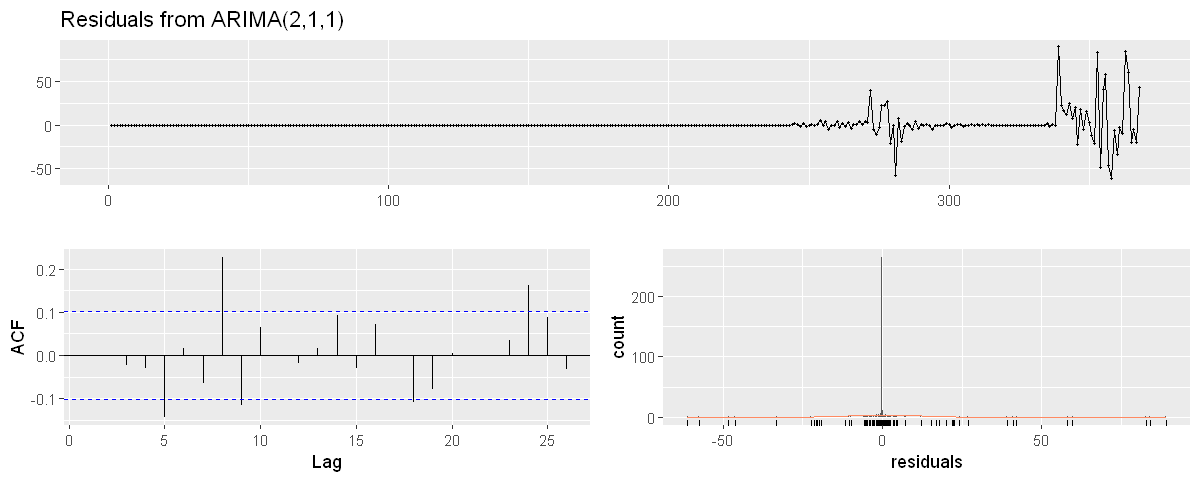

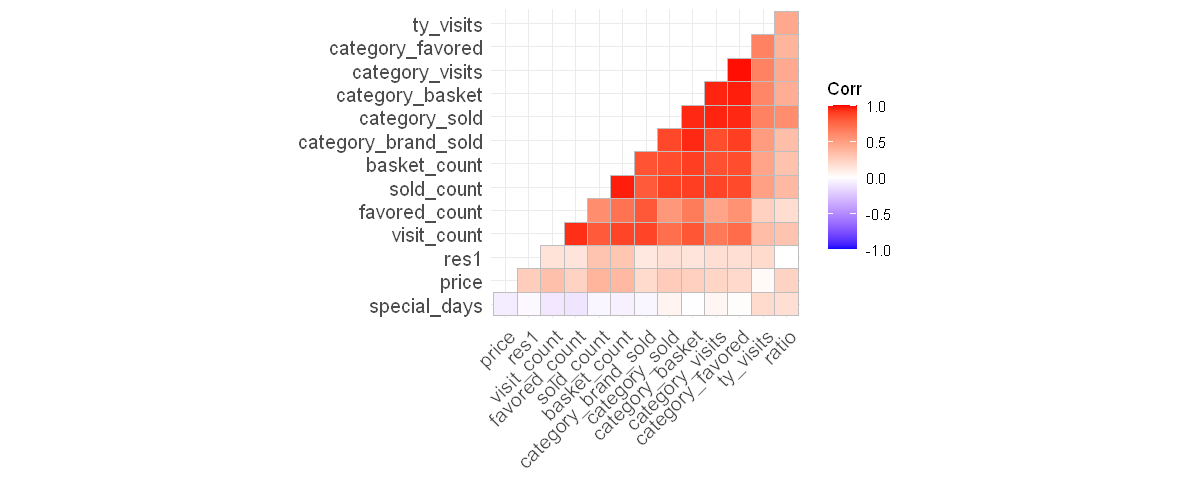

In [346]:
model_bikini1_arima <- arima(bikini1_ts,order=c(2,1,1))
checkresiduals(model_bikini1_arima)
bikini1_train$res1 <- model_bikini1_arima$residuals
corr <- cor(bikini1_train[!is.na(bikini1_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

There is no significant correlation between residuals and other variables because the nature of the data.

### Linear Models

Again, the days of week and trend columns will be added to the data firstly. Next, the first model will be built with trend and weekly seasonality. Then, we'll look for possible regressors and add them to the model. Finally, we will find the best model among them. 

In [347]:
prod2[, `:=`(trend=1:.N, 
            days=wday(event_date, label=T))]

model2_1 <- lm(sold_count~trend+days, data=prod2)
summary(model2_1)


Call:
lm(formula = sold_count ~ trend + days, data = prod2)

Residuals:
    Min      1Q  Median      3Q     Max 
-43.973 -21.974  -6.404  10.939 193.487 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -21.92474    3.81514  -5.747 1.94e-08 ***
trend         0.19238    0.01792  10.736  < 2e-16 ***
days.L        1.07026    5.05380   0.212    0.832    
days.Q        1.50219    5.04467   0.298    0.766    
days.C       -0.96008    5.04016  -0.190    0.849    
days^4        3.25069    5.03711   0.645    0.519    
days^5        1.20394    5.02638   0.240    0.811    
days^6       -0.06179    5.01804  -0.012    0.990    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 36.52 on 360 degrees of freedom
Multiple R-squared:  0.2438,	Adjusted R-squared:  0.2291 
F-statistic: 16.58 on 7 and 360 DF,  p-value: < 2.2e-16


It seems that days are insignificant. They will be removed from the model. Residual analysis will be made on the final model. Now, we will check for the possible regressors. 

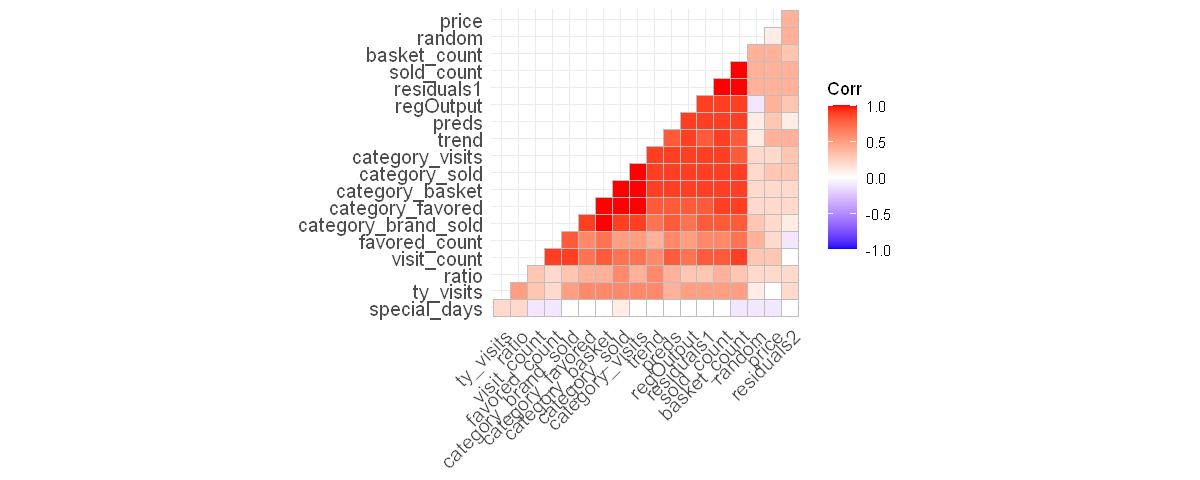

In [356]:
temp <- lm(sold_count~trend, data=prod2)
prod2[, residuals1:=temp$residuals]
corr <- round(cor(Filter(is.numeric, prod2[!is.na(prod2$price)])), 1)
ggcorrplot(corr, hc.order = TRUE,type = "lower")

Again, the maximum correlation with residuals1 is obtained by basket_count. Therefore, its lagged version will be added to the model. To find the lag value, we'll check the CCF function. 

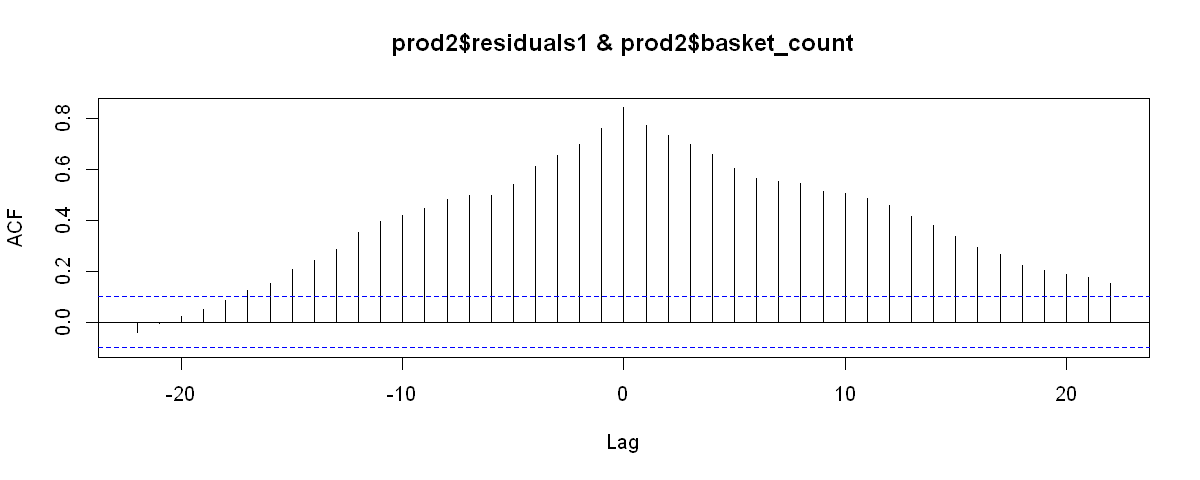

In [349]:
ccf(prod2$residuals1, prod2$basket_count)

In [350]:
model2_2 <- lm(sold_count~trend+shift(basket_count,1), data=prod2)
summary(model2_2)


Call:
lm(formula = sold_count ~ trend + shift(basket_count, 1), data = prod2)

Residuals:
    Min      1Q  Median      3Q     Max 
-82.115  -0.964   0.065   1.154  93.142 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -1.963759   1.562898  -1.256    0.210    
trend                   0.012172   0.008103   1.502    0.134    
shift(basket_count, 1)  0.212920   0.004756  44.767   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 14.24 on 364 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.8836,	Adjusted R-squared:  0.883 
F-statistic:  1382 on 2 and 364 DF,  p-value: < 2.2e-16


Adjusted Rsqr value is 0.883, which is a very high value. From the correlation tableau, let's find a second regressor. 

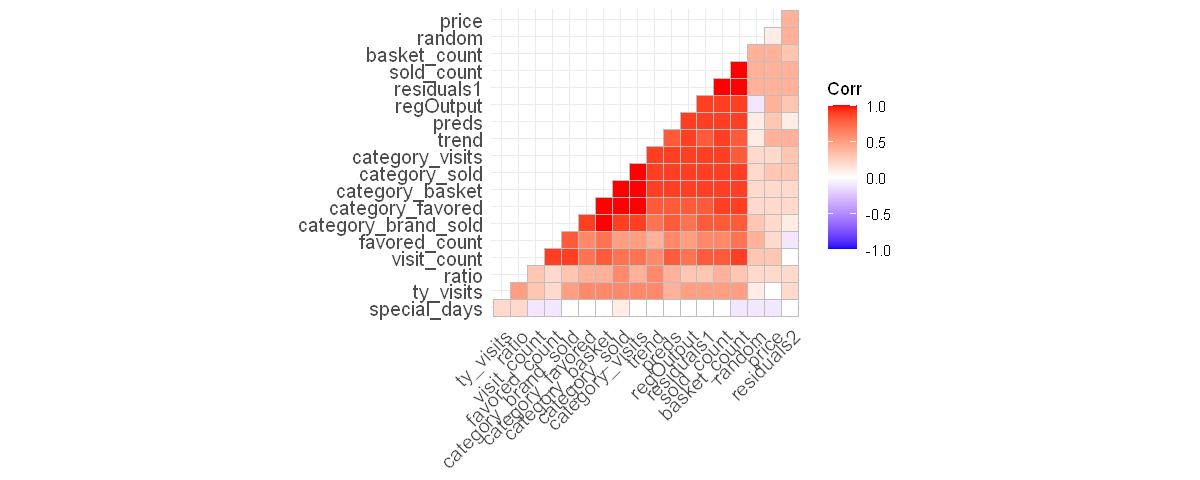

In [357]:
prod2[, residuals2:=c(NA, model2_2$residuals)]
corr <- round(cor(Filter(is.numeric, prod2[!is.na(prod2$price) & !is.na(prod2$residuals2)])), 1)
ggcorrplot(corr, hc.order = TRUE,type = "lower")

It seems that there is not another good regressor. Next, the lagged sold_count will be examined.

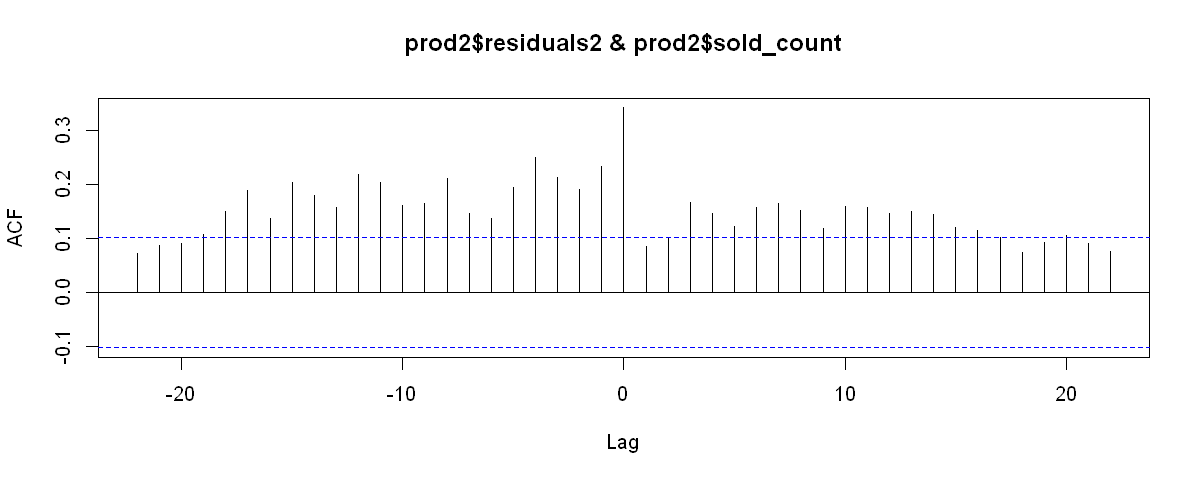

In [352]:
ccf(prod2$residuals2, prod2$sold_count, na.action=na.pass)

In [353]:
model2_3 <- lm(sold_count~trend+shift(basket_count,1)+shift(sold_count,3), data=prod2)
summary(model2_3)


Call:
lm(formula = sold_count ~ trend + shift(basket_count, 1) + shift(sold_count, 
    3), data = prod2)

Residuals:
    Min      1Q  Median      3Q     Max 
-83.869  -1.011   0.015   0.743  87.559 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            -1.348168   1.448190  -0.931    0.353    
trend                   0.008229   0.007490   1.099    0.273    
shift(basket_count, 1)  0.147325   0.008761  16.817   <2e-16 ***
shift(sold_count, 3)    0.348722   0.040443   8.623   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 13.02 on 361 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.9035,	Adjusted R-squared:  0.9027 
F-statistic:  1126 on 3 and 361 DF,  p-value: < 2.2e-16



	Breusch-Godfrey test for serial correlation of order up to 10

data:  Residuals
LM test = 95.276, df = 10, p-value = 4.785e-16


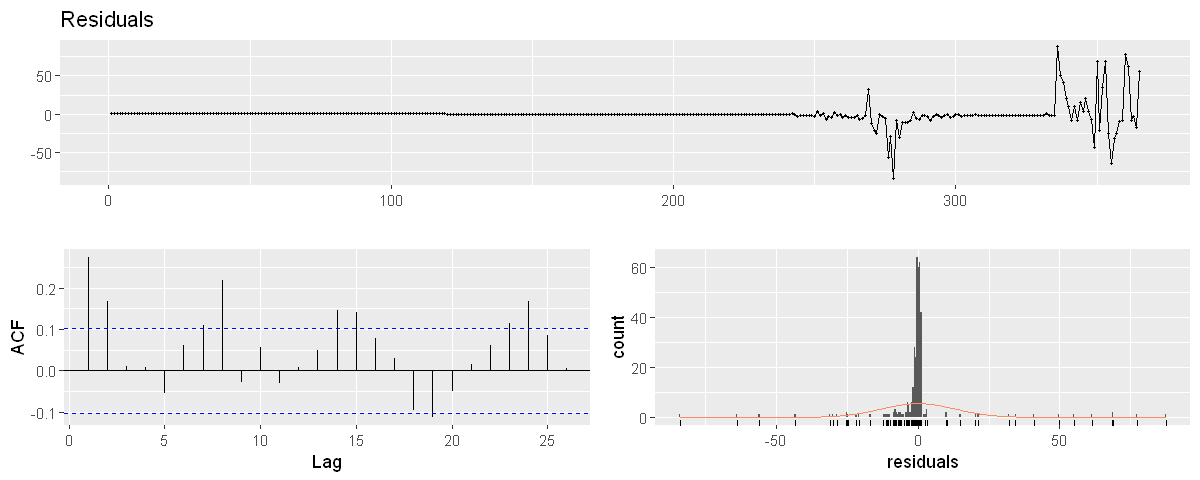

In [354]:
checkresiduals(model2_3)

Adjusted Rsqr value is 0.9027. Also in the first lags, there is not a significantly high correlation. But as we saw on the prod3, the data is dirty which makes the residuals dirty. The mean is near zero but the variance changes. Also, normality assumption is not satisfied. The last model is model2_3.

Warning message:
"Removed 3 rows containing missing values (geom_point)."

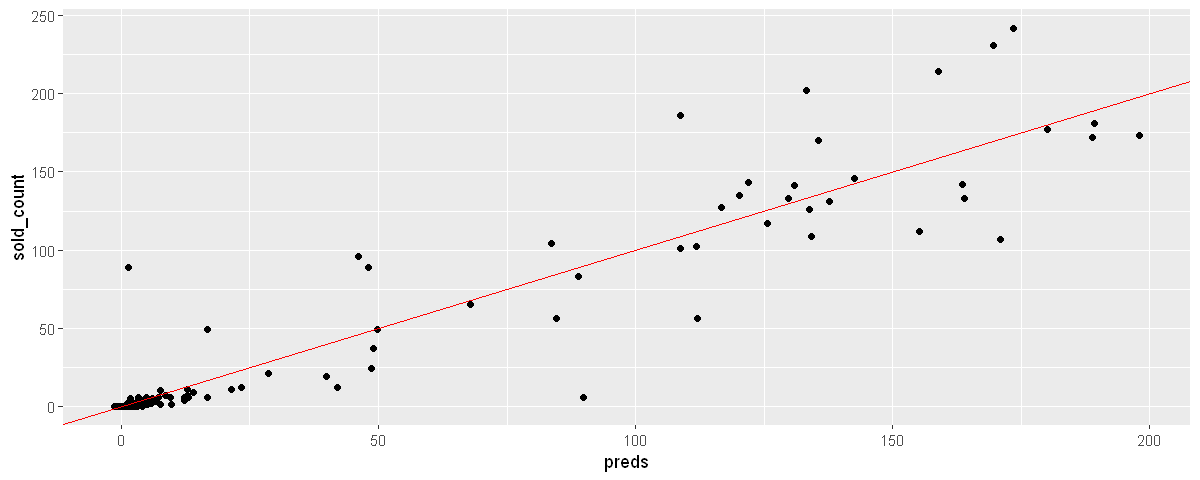

In [358]:
prod2[, preds:=c(NA,NA,NA,model2_3$fitted.values)]
ggplot(prod2, aes(x=preds, y=sold_count)) + geom_point() + geom_abline(intercept=0, slope=1, color="red") 

### Forecasting

In [481]:
forecast_data_bikini1 <- data.table(event_date=bikini1[event_date>=test_start&event_date<=test_end,]$event_date,
                            sold_count=bikini1[event_date>=test_start&event_date<=test_end,]$sold_count)
bikini1[,`:=`(trend=1:.N,
           days=wday(event_date, label=T))]
arima_fc <- numeric(0)
reg_fc <- numeric(0)
for(i in 1:length(test_dates)){
  
  train_dt <- bikini1[event_date<test_dates[i],]
  model_arima <- Arima(train_dt$sold_count,order=c(3,1,4))
  model_reg <- lm(sold_count~trend+shift(basket_count,1)+shift(sold_count,1), data=train_dt)
  reg_temp <- predict(model_reg,newdata=bikini1[event_date %in% c(test_dates[i],test_dates[i+1])])
  arima_temp <- forecast(model_arima)
  arima_fc <- c(arima_fc,arima_temp$mean[1])
  reg_fc <- c(reg_fc,reg_temp)
}
reg_fc[is.na(reg_fc)] <- mean(reg_fc[!is.na(reg_fc)])
forecast_data_bikini1 <- forecast_data_bikini1[,`:=`(arima_p=arima_fc,
                                               reg_p=reg_fc[c(1,seq(2,28,2))])]
accu(forecast_data_bikini1$sold_count,forecast_data_bikini1$arima_p)
accu(forecast_data_bikini1[1:(.N-1)]$sold_count,forecast_data_bikini1[2:.N]$reg_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
15,114.0667,82.37585,0.7221729,-0.1176104,0.4484135,44.3945,35.1883,0.3084889,0.3084889


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
14,119.0714,83.08519,0.697776,-0.01316139,0.02326047,3.757718,2.152989,0.01808149,0.01808149


In [482]:
result_data_bikini1 <- data.table(event_date=bikini1[event_date>=result_start&event_date<=result_end,]$event_date,
                               sold_count=bikini1[event_date>=result_start&event_date<=result_end,]$sold_count)
final_fc <- numeric(0)
for(i in 1:length(result_dates)){
  
  train_dt <- bikini1[event_date<result_dates[i],]
  model_final <- lm(sold_count~trend+days+shift(basket_count, 1)+shift(sold_count, 1), data=train_dt)
  final_temp <- predict(model_final,newdata=bikini1[event_date %in% c(result_dates[i],result_dates[i+1])])
  final_fc <- c(final_fc,final_temp)
  
}
final_fc[is.na(final_fc)] <- mean(final_fc[!is.na(final_fc)])
result_data_bikini1 <- result_data_bikini1[,`:=`(final_p=final_fc[c(1,seq(2,28,2))])]
accu(result_data_bikini1[1:(.N-1)]$sold_count,result_data_bikini1[2:.N]$final_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
14,41.78571,18.06049,0.4322169,-0.03752398,0.07941104,2.953998,2.405,0.05755555,0.05755555


In [483]:
data.frame(event_date=result_data_bikini1[1:(.N-1)]$event_date,
           sold_count=result_data_bikini1[1:(.N-1)]$sold_count,
           predictions=result_data_bikini1[2:.N]$final_p)

event_date,sold_count,predictions
2021-06-12,39,40.76201
2021-06-13,44,40.40899
2021-06-14,67,67.80812
2021-06-15,44,46.45402
2021-06-16,72,71.40587
2021-06-17,68,67.41885
2021-06-18,46,51.32375
2021-06-19,26,28.82349
2021-06-20,15,13.90706
2021-06-21,20,23.38950


### MONT 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


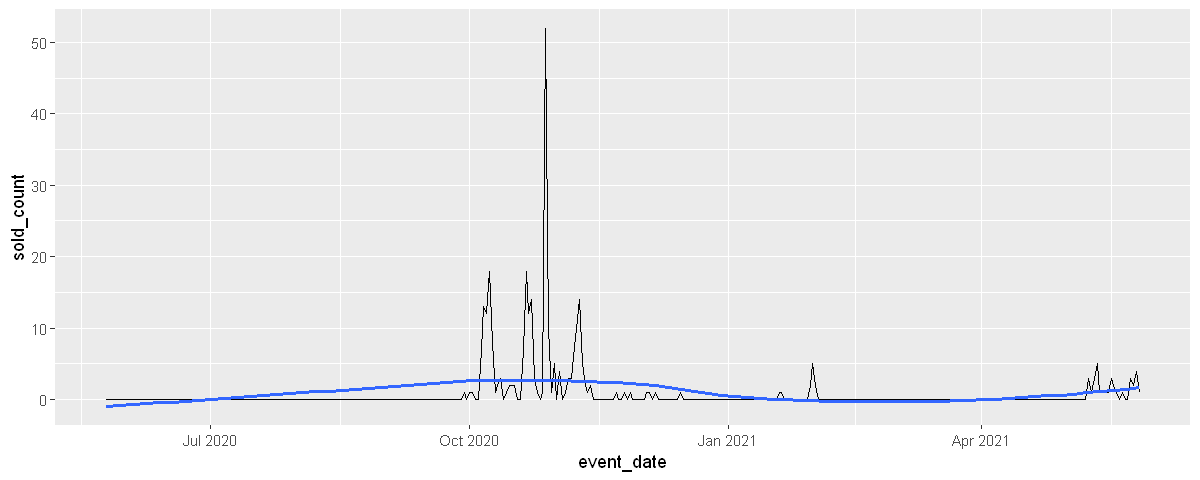

In [359]:
ggplot(prod1, aes(x=event_date, y=sold_count)) + geom_line() + geom_smooth(se=F)

* By the blue line, it seems that the mean is not constant. It is wavy. 
* Variance changes over time. 
* There are days with zero sale.  
* It appears that the data is not stationary. 

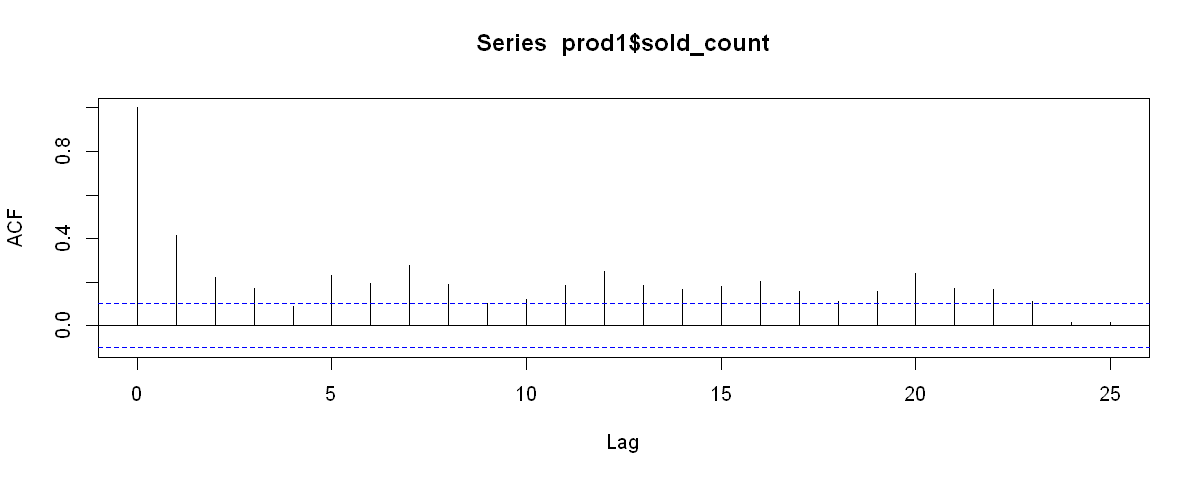

In [360]:
acf(prod1$sold_count) 

There is a relatively high autocorrelation with lag 1. 

### Weekly Decomposition

Additive decomposition will be used because the variance does not increase. 

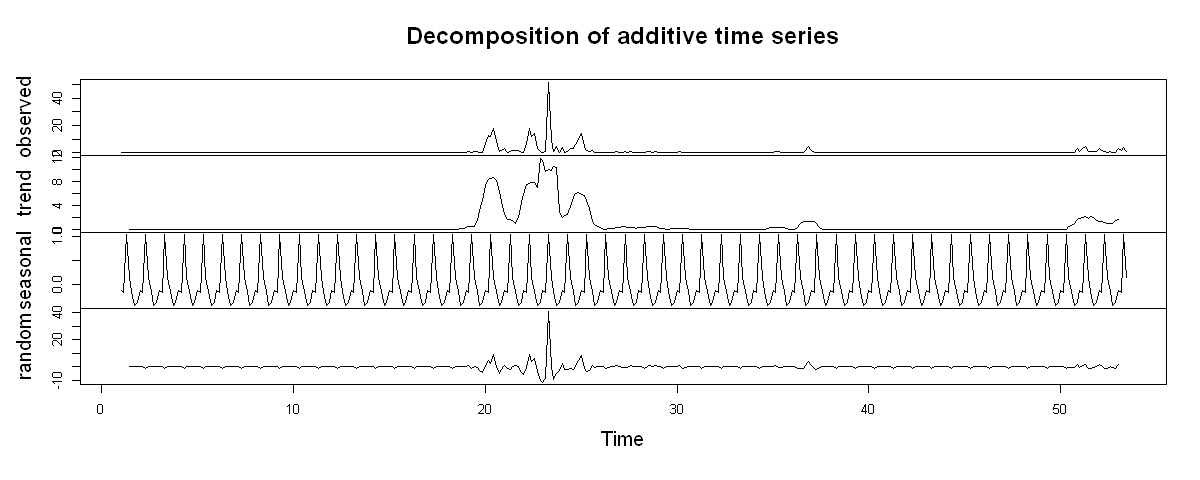

In [361]:
prod1_weekly_dec <- decompose(ts(prod1$sold_count, freq=7), type="additive")
plot(prod1_weekly_dec)

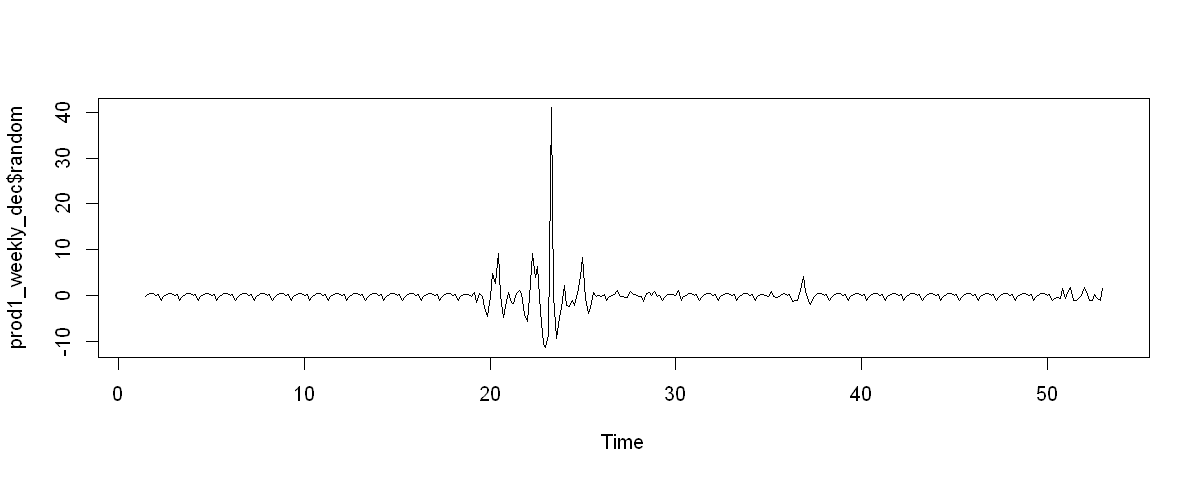

In [362]:
plot(prod1_weekly_dec$random)

* The variance is higher in the midde points of the graph. 
* The mean seems to be constant. 
 
Now, let's check whether the weekly detrended and deseasonalized data is stationary. 

In [363]:
u_test <- ur.kpss(prod1_weekly_dec$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0093 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


We dont have enough evidence to reject the null hyphothesis. The data is now stationary. 

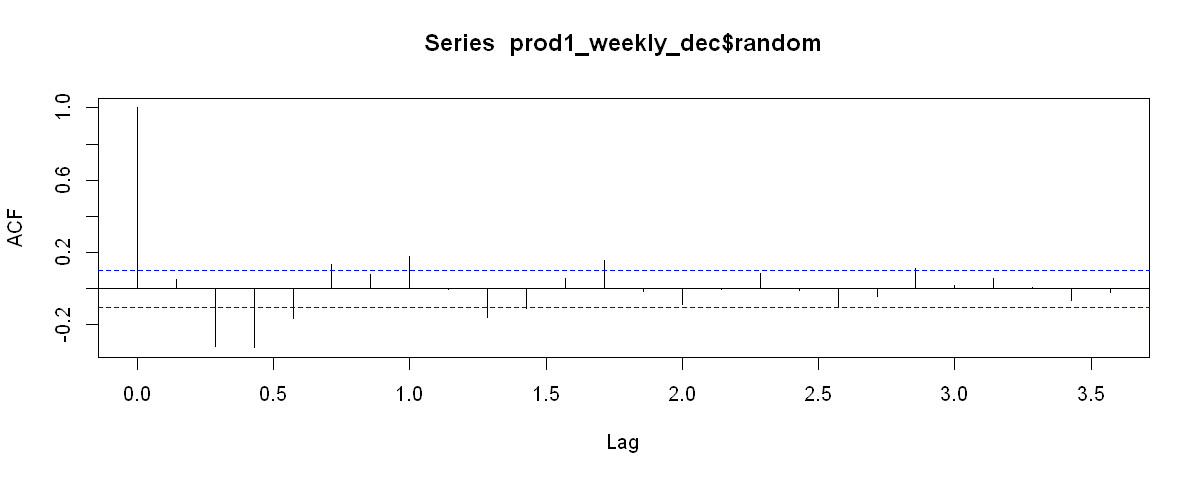

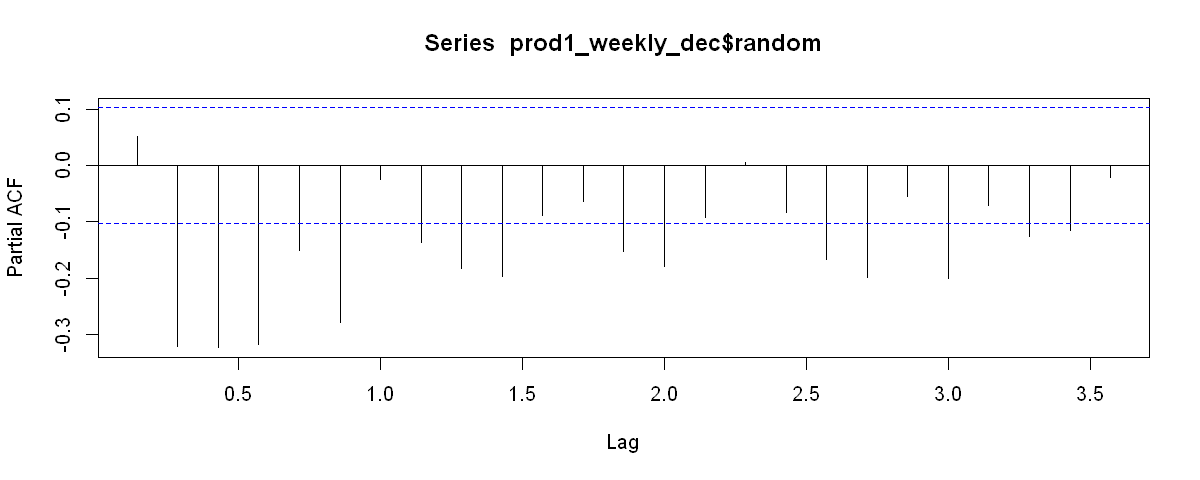

In [364]:
acf(prod1_weekly_dec$random, na.action=na.pass)
pacf(prod1_weekly_dec$random, na.action=na.pass)

From the PACF graph above, the data is correlated with its first lags. 

### Monthly Decomposition

month,sold_count
2020 May,0
2020 Jun,0
2020 Jul,0
2020 Aug,0
2020 Sep,1
2020 Oct,197
2020 Nov,54
2020 Dec,4
2021 Jan,9
2021 Feb,2


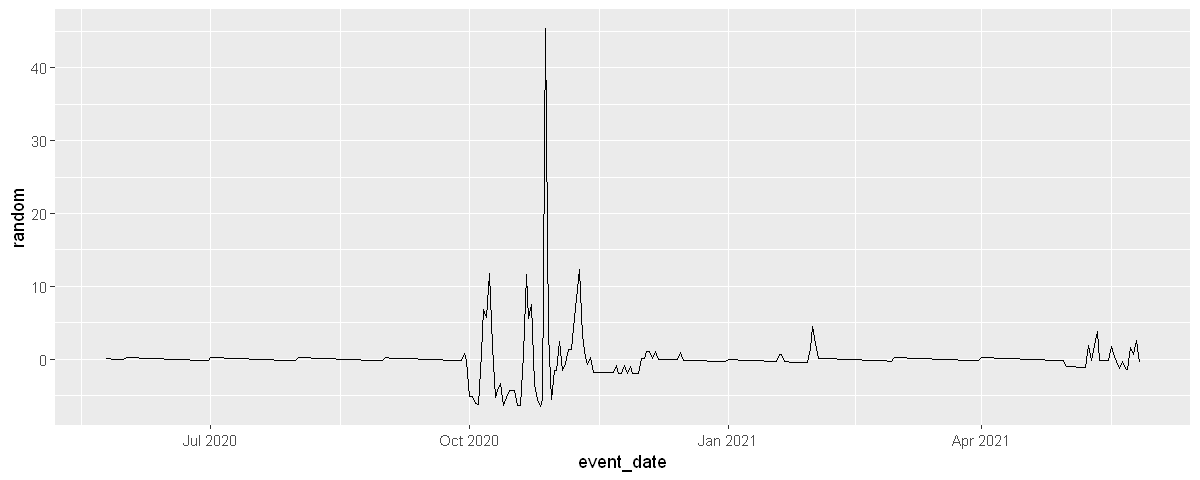

In [365]:
prod1_monthly <- prod1[, month:=yearmonth(event_date)]
prod1_monthly[, .(sold_count=sum(sold_count)), by=month]
prod1_monthly[, trend:=1:.N]

prod1_reg <- lm(sold_count~trend+as.factor(month), data=prod1_monthly)
prod1_monthly[, regOutput:=predict(prod1_reg, prod1_monthly)]

prod1_monthly[, random:=sold_count-regOutput]

ggplot(prod1_monthly, aes(x=event_date, y=random)) + geom_line()

* The graph is similar to its weekly decomposed graph. 
* The variance is high in the middle points. 
* The mean seems to be constant. 

In [366]:
u_test <- ur.kpss(prod1_monthly$random)
summary(u_test)


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 5 lags. 

Value of test-statistic is: 0.0199 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739


According to the test above, the data is stationary. 

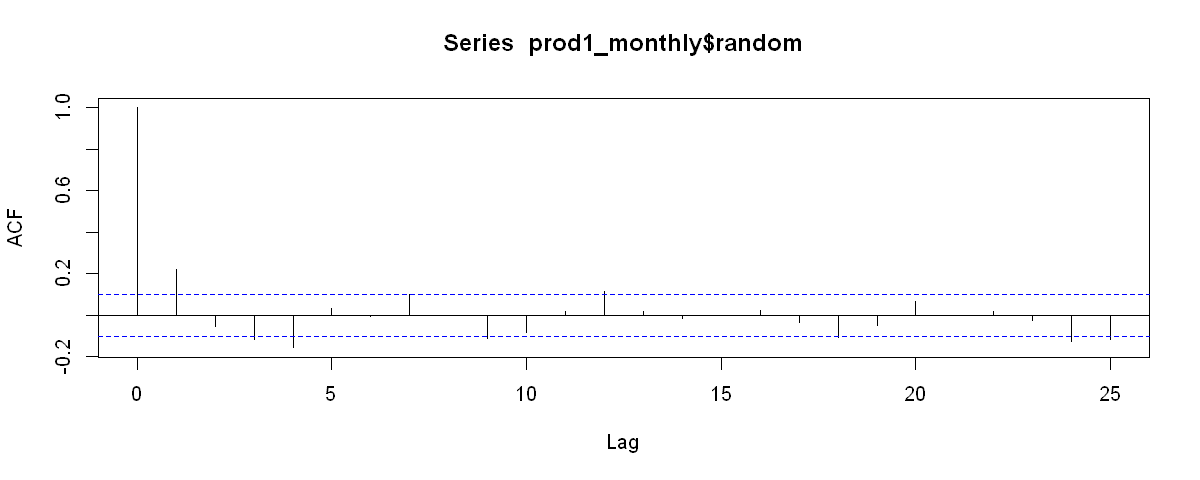

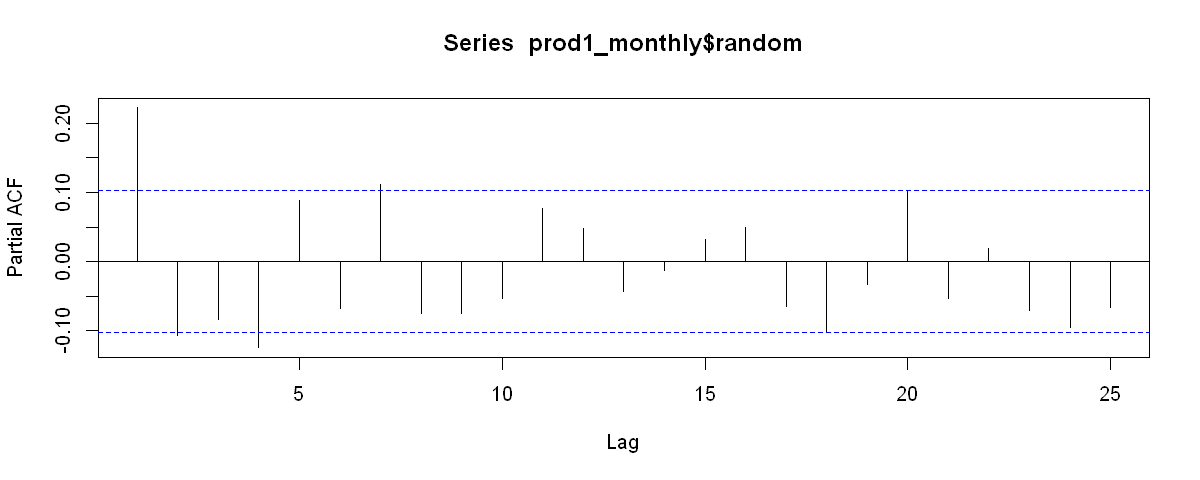

In [367]:
acf(prod1_monthly$random, na.action=na.pass)
pacf(prod1_monthly$random, na.action=na.pass)

There is not a high autocorrelation but we can say that there is a little correlation with lag 1. 

### Building an ARIMA Model

In [368]:
mont <- data[product_content_id=="48740784",][order(event_date)]
mont$is_winter <- 0
mont[month(mont$event_date) %in% c(9,10,11,12,1),]$is_winter <- 1
mont_train <- mont[event_date<test_start,]
mont_ts <- ts(mont_train$sold_count)

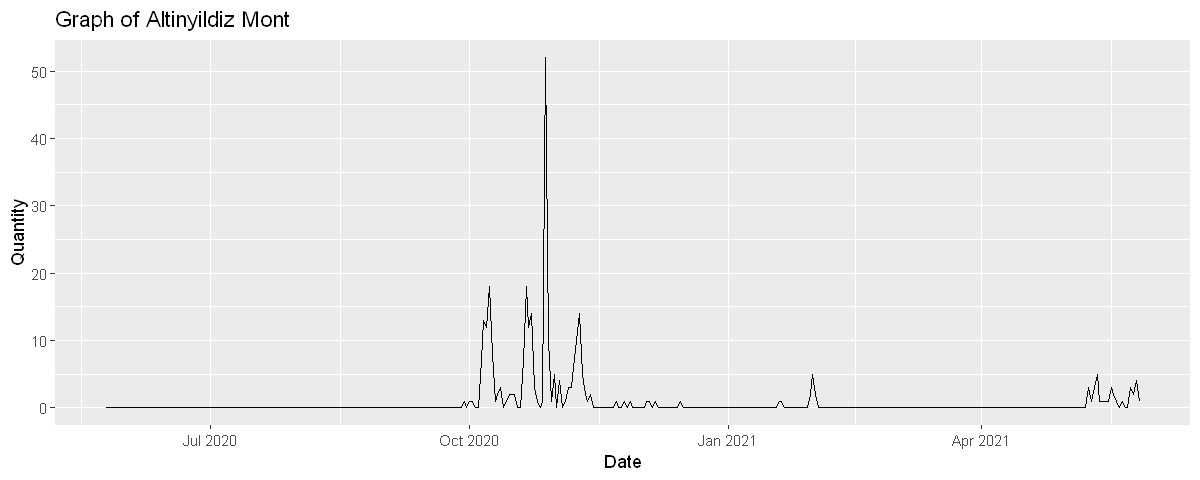

In [369]:
ggplot(mont_train,aes(x=event_date,y=sold_count)) + geom_line() +
  labs(title= "Graph of Altınyıldız Mont", x= "Date", y="Quantity")

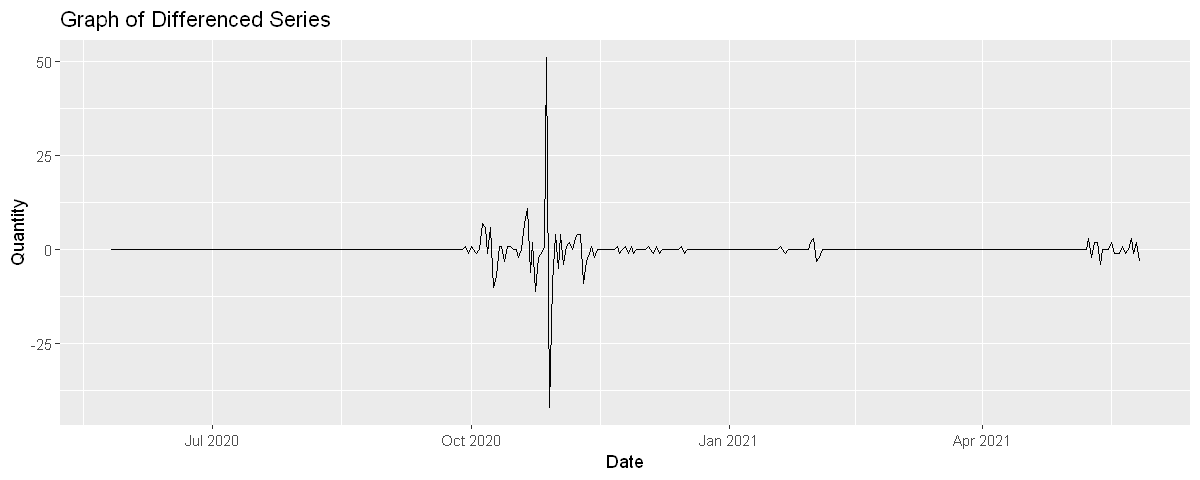

In [370]:
ggplot(mont_train[2:.N,],aes(x=event_date)) + geom_line(aes(y=diff(mont_train$sold_count,1))) + 
  labs(title= "Graph of Differenced Series", x= "Date", y="Quantity")

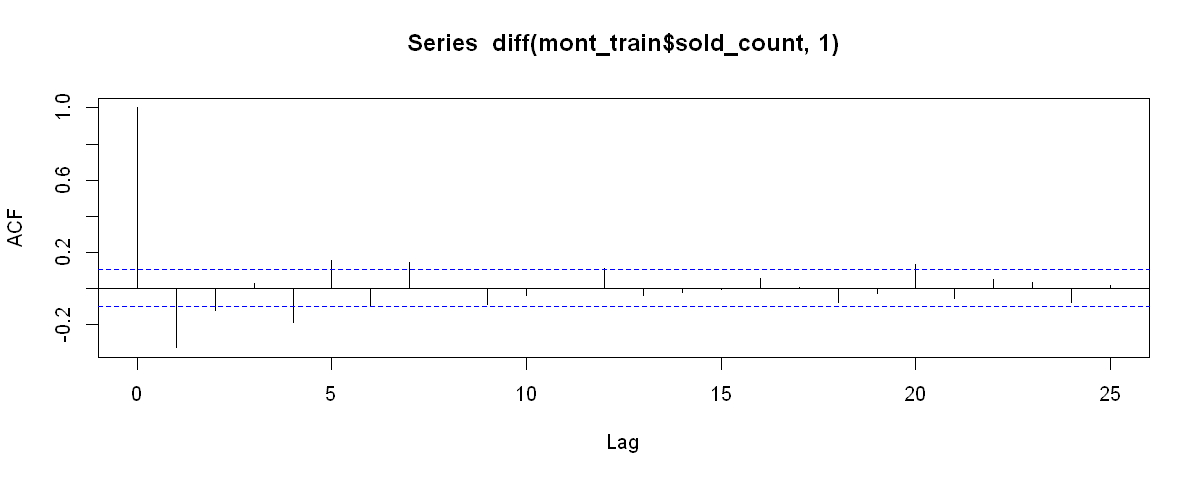

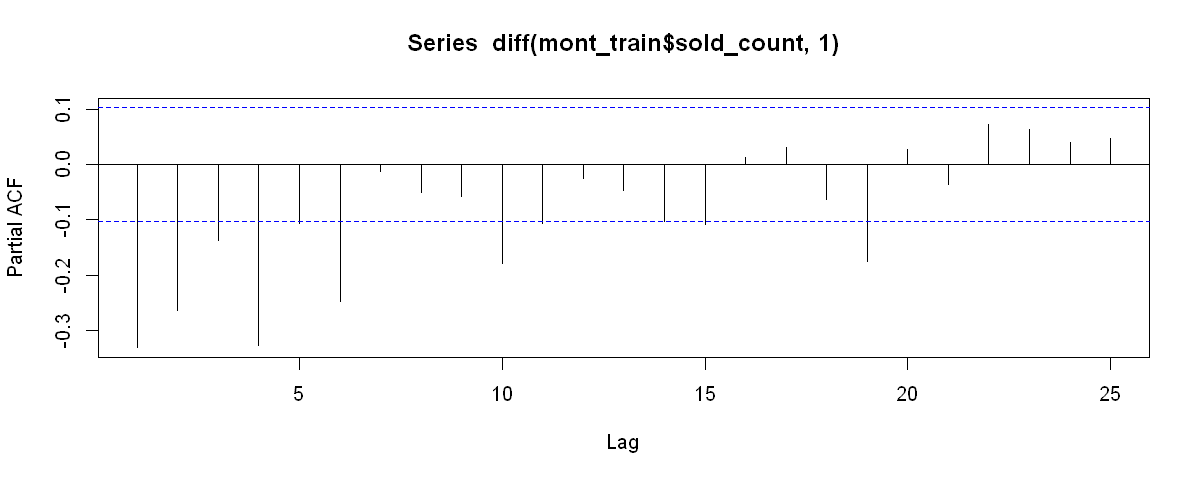

In [371]:
acf(diff(mont_train$sold_count,1))
pacf(diff(mont_train$sold_count,1))

There are spikes at the ACF graph at lags 1 and 4. There are also spikes at the PACF graph at lags 1,2,4. These paramters could be tried on a ARIMA model.

In [372]:
arima(mont_ts,order=c(1,1,1))


Call:
arima(x = mont_ts, order = c(1, 1, 1))

Coefficients:
         ar1      ma1
      0.2693  -0.9204
s.e.  0.0574   0.0229

sigma^2 estimated as 10.08:  log likelihood = -945.38,  aic = 1896.77

In [373]:
arima(mont_ts,order=c(1,1,2))


Call:
arima(x = mont_ts, order = c(1, 1, 2))

Coefficients:
          ar1      ma1      ma2
      -0.5739  -0.0884  -0.7141
s.e.   0.0946   0.0740   0.0595

sigma^2 estimated as 9.949:  log likelihood = -943.09,  aic = 1894.18

In [374]:
arima(mont_ts,order=c(1,1,4))


Call:
arima(x = mont_ts, order = c(1, 1, 4))

Coefficients:
          ar1     ma1      ma2      ma3      ma4
      -0.6211  0.0269  -0.6240  -0.1038  -0.1254
s.e.   0.1219  0.1236   0.0885   0.0690   0.0581

sigma^2 estimated as 9.747:  log likelihood = -939.32,  aic = 1890.65

In [375]:
arima(mont_ts,order=c(4,1,1))


Call:
arima(x = mont_ts, order = c(4, 1, 1))

Coefficients:
         ar1      ar2      ar3      ar4      ma1
      0.2101  -0.0868  -0.0331  -0.1679  -0.8551
s.e.  0.0632   0.0569   0.0560   0.0566   0.0418

sigma^2 estimated as 9.802:  log likelihood = -940.34,  aic = 1892.69

In [376]:
arima(mont_ts,order=c(4,1,2))


Call:
arima(x = mont_ts, order = c(4, 1, 2))

Coefficients:
          ar1     ar2      ar3      ar4      ma1      ma2
      -0.4675  0.0942  -0.0647  -0.1973  -0.1413  -0.6477
s.e.   0.0967  0.0734   0.0654   0.0575   0.0885   0.0838

sigma^2 estimated as 9.53:  log likelihood = -935.27,  aic = 1884.53

In [377]:
arima(mont_ts,order=c(4,1,4))


Call:
arima(x = mont_ts, order = c(4, 1, 4))

Coefficients:
          ar1     ar2     ar3      ar4      ma1      ma2      ma3     ma4
      -0.5644  0.2577  0.0891  -0.2304  -0.0394  -0.8788  -0.0851  0.1928
s.e.   0.3005  0.4435  0.2185   0.0758   0.3065   0.3697   0.2417  0.2992

sigma^2 estimated as 9.514:  log likelihood = -934.96,  aic = 1887.92

The best model is ARIMA(4,1,2) with lowest AIC value of 1884.53.


	Ljung-Box test

data:  Residuals from ARIMA(4,1,2)
Q* = 7.1981, df = 4, p-value = 0.1258

Model df: 6.   Total lags used: 10



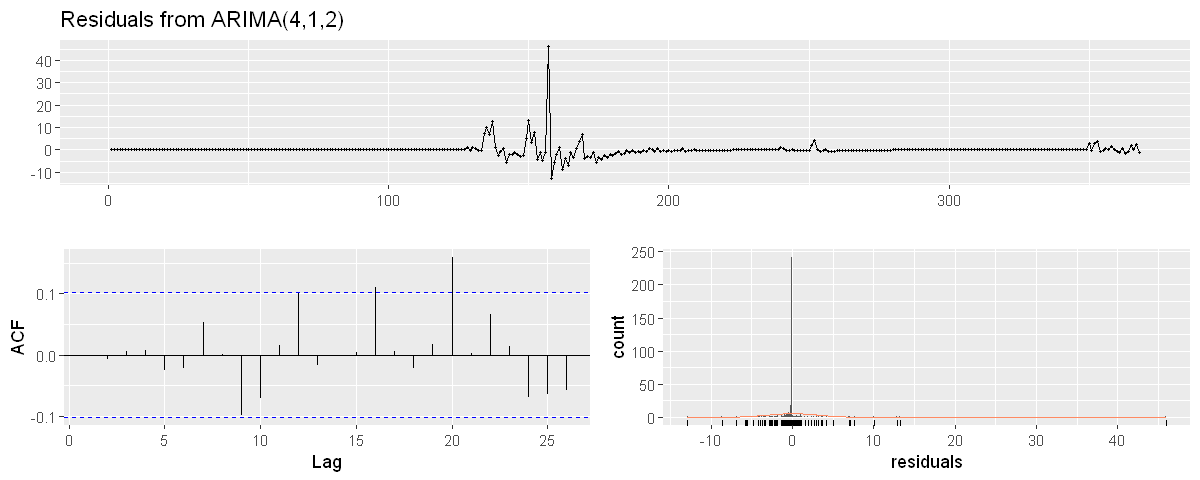

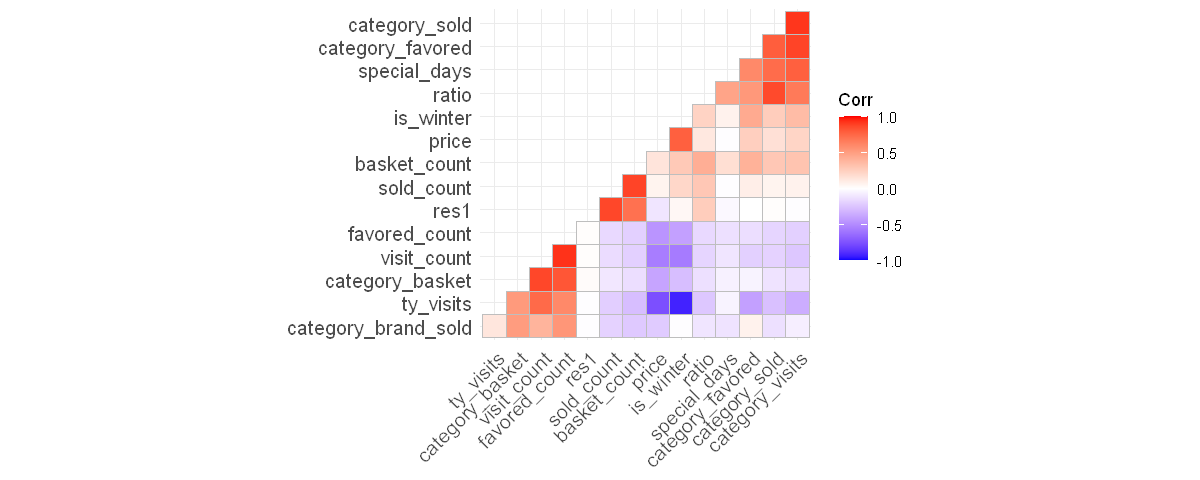

In [378]:
model_mont_arima <- arima(mont_ts,order=c(4,1,2))
checkresiduals(model_mont_arima)
mont_train$res1 <- model_mont_arima$residuals
corr <- cor(mont_train[!is.na(mont_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

Resdiuals looks statioanry with 0 mean and constant variance. Basket_count could be added as a regressor.

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


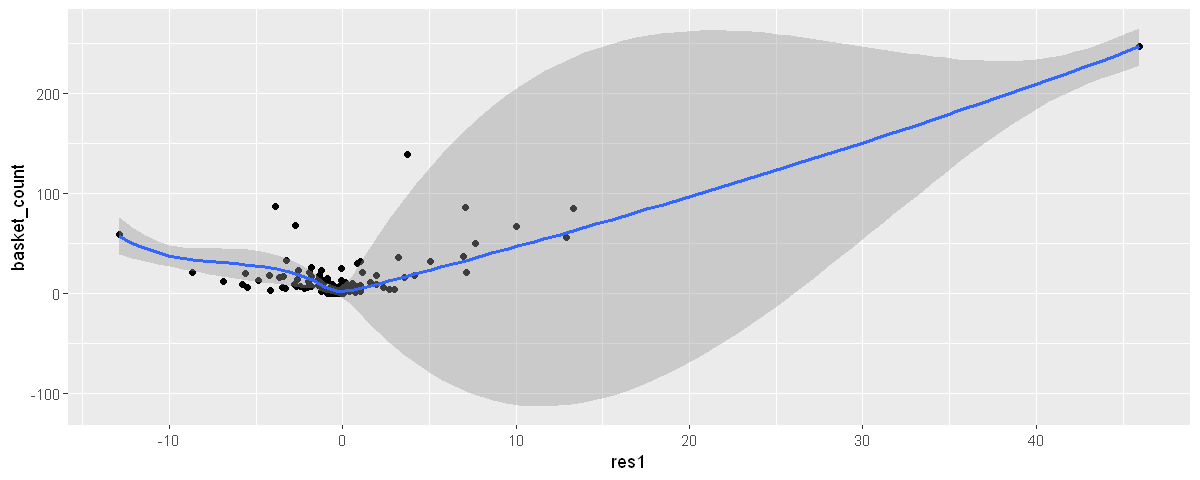

In [379]:
ggplot(mont_train,aes(x=res1,y=basket_count)) +  geom_point() + geom_smooth()

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


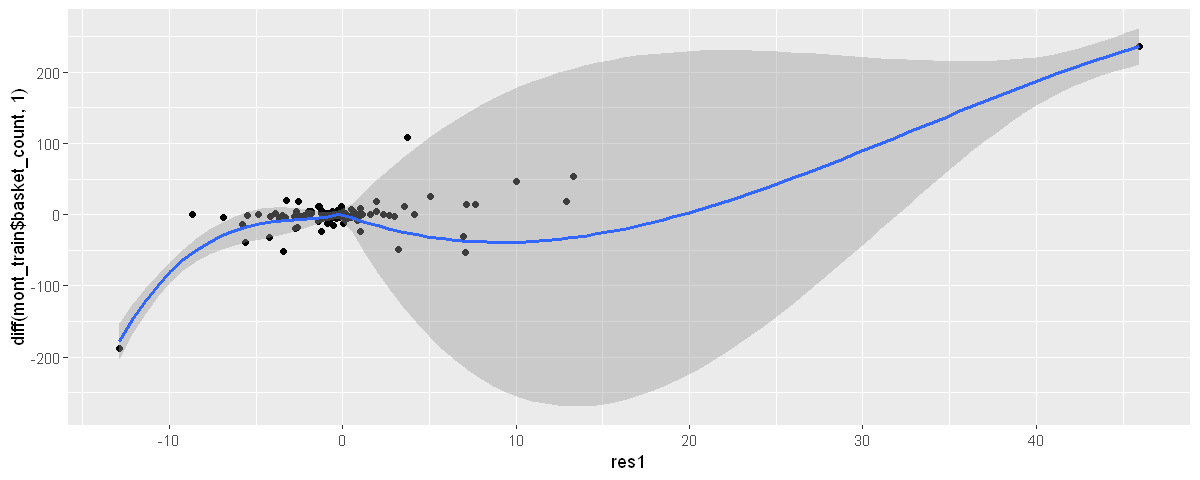

In [380]:
ggplot(mont_train[2:.N],aes(x=res1)) +  geom_point(aes(y=diff(mont_train$basket_count,1))) +
  geom_smooth(aes(y=diff(mont_train$basket_count,1)))

In [381]:
cor(mont_train$res1,mont_train$basket_count)

[1] 0.6464301

In [382]:
arima(mont_ts,order=c(4,1,2),xreg=mont_train$basket_count)


Call:
arima(x = mont_ts, order = c(4, 1, 2), xreg = mont_train$basket_count)

Coefficients:
          ar1     ar2     ar3      ar4      ma1      ma2
      -0.4177  0.4710  0.3093  -0.0730  -0.3040  -0.6960
s.e.   0.1414  0.0639  0.0642   0.0631   0.1345   0.1342
      mont_train$basket_count
                       0.1877
s.e.                   0.0049

sigma^2 estimated as 1.845:  log likelihood = -635.55,  aic = 1287.1

AIC value is decreased when the regressor added.


	Ljung-Box test

data:  Residuals from ARIMA(4,1,2)
Q* = 13.039, df = 3, p-value = 0.004552

Model df: 7.   Total lags used: 10



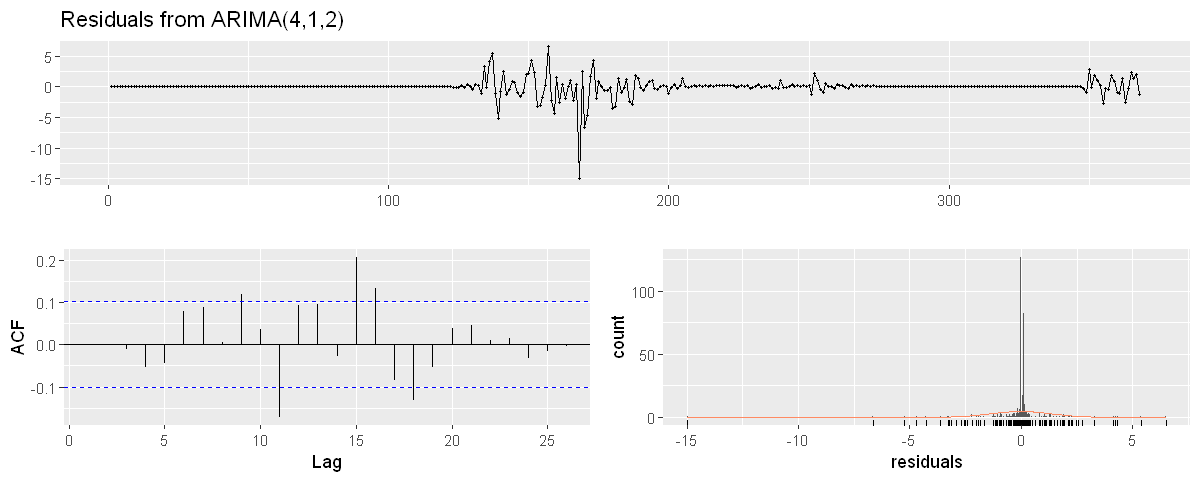

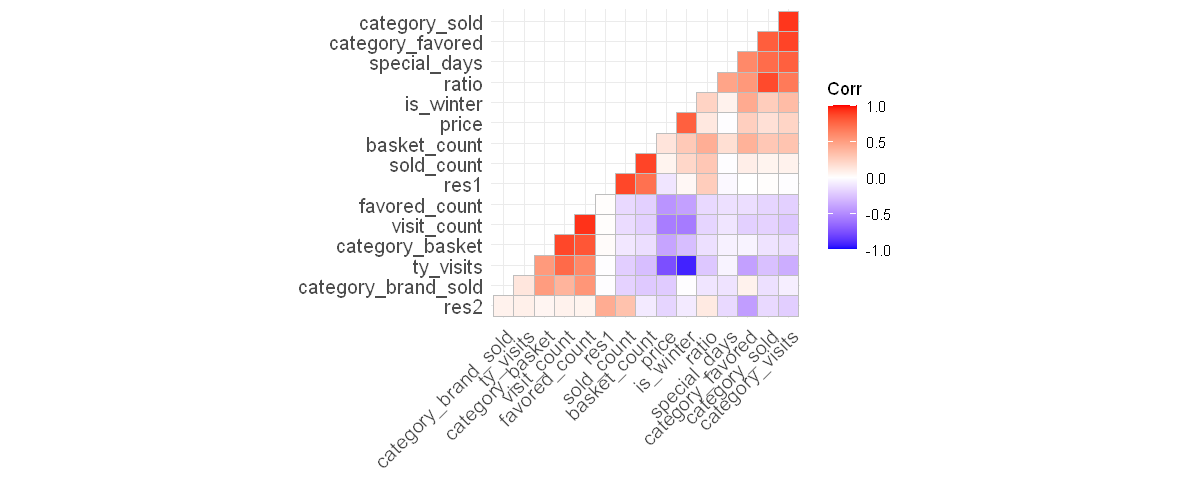

In [383]:
model_mont_arimax <- arima(mont_ts,order=c(4,1,2),xreg=mont_train$basket_count)
checkresiduals(model_mont_arimax)
mont_train$res2 <- model_mont_arimax$residuals
corr <- cor(mont_train[!is.na(mont_train$price),c(-1,-2)])
ggcorrplot(corr,hc.order = TRUE, type = "lower")

### Linear Models

Firstly, the days of week and trend columns will be added to the data. Next, the first model will be built with trend and weekly seasonality. Then, we'll look for possible regressors and add them to the model. Finally, we will find the best model among them. 

In [384]:
prod1[, `:=`(trend=1:.N, 
            days=wday(event_date, label=T))]

model1_1 <- lm(sold_count~trend+days, data=prod1)
summary(model1_1)


Call:
lm(formula = sold_count ~ trend + days, data = prod1)

Residuals:
   Min     1Q Median     3Q    Max 
-1.920 -0.764 -0.651 -0.408 50.140 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.8847191  0.3713541   2.382   0.0177 *
trend       -0.0003902  0.0017443  -0.224   0.8231  
days.L      -0.0031543  0.4919214  -0.006   0.9949  
days.Q      -0.8765138  0.4910331  -1.785   0.0751 .
days.C      -0.1295795  0.4905946  -0.264   0.7918  
days^4       0.4566335  0.4902969   0.931   0.3523  
days^5       0.1469379  0.4892534   0.300   0.7641  
days^6      -0.6584222  0.4884411  -1.348   0.1785  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.554 on 360 degrees of freedom
Multiple R-squared:  0.01666,	Adjusted R-squared:  -0.002462 
F-statistic: 0.8713 on 7 and 360 DF,  p-value: 0.5293


The model is totally meaningless. We have to find good regressors for the model. 

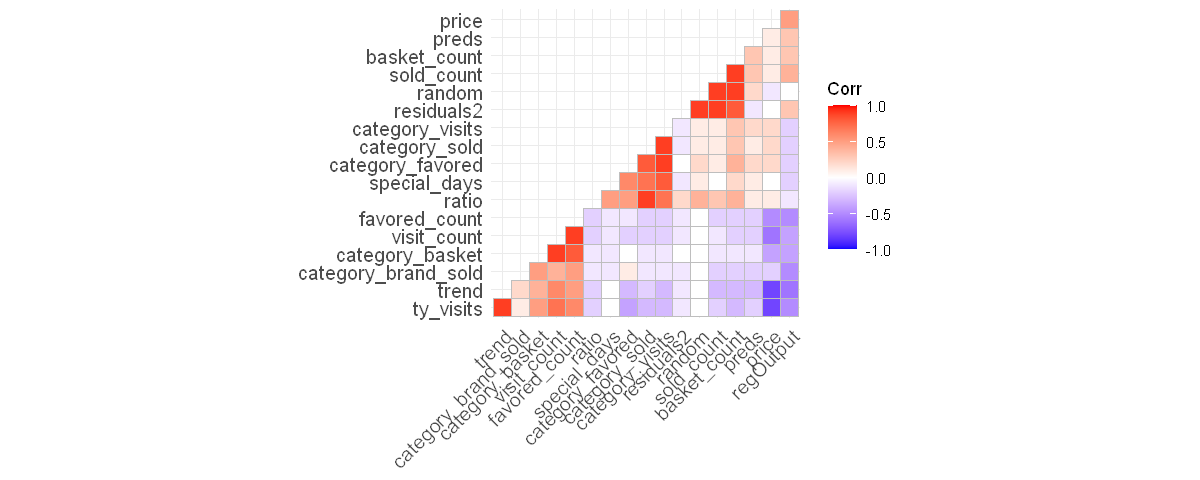

In [393]:
corr <- round(cor(Filter(is.numeric, prod1[!is.na(prod1$price)])), 1)
ggcorrplot(corr, hc.order = TRUE,type = "lower")

Again, the maximum correlation with residuals1 is obtained by basket_count. Therefore, its lagged version will be added to the model. To find the lag value, we'll check the CCF function. 

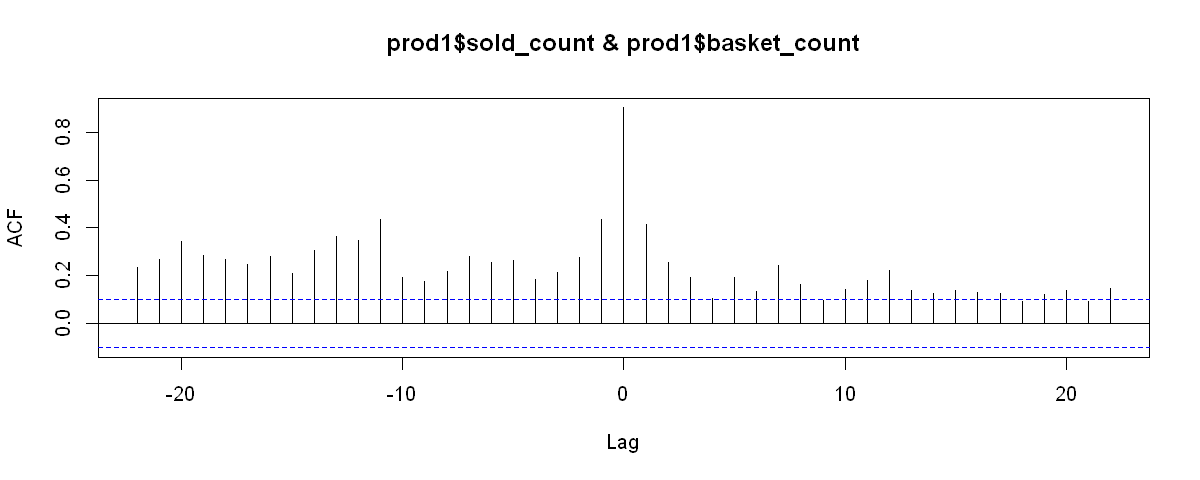

In [386]:
ccf(prod1$sold_count, prod1$basket_count)

In [387]:
model1_2 <- lm(sold_count~shift(basket_count,1), data=prod1)
summary(model1_2)


Call:
lm(formula = sold_count ~ shift(basket_count, 1), data = prod1)

Residuals:
   Min     1Q Median     3Q    Max 
-9.872 -0.401 -0.401 -0.401 50.732 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.401179   0.175732   2.283    0.023 *  
shift(basket_count, 1) 0.078827   0.009059   8.702   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.239 on 365 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.1718,	Adjusted R-squared:  0.1695 
F-statistic: 75.72 on 1 and 365 DF,  p-value: < 2.2e-16


According to the p value, the model is meaningful with an adjusted Rsqr value of 0.1695. Let's look for the second regressor. 

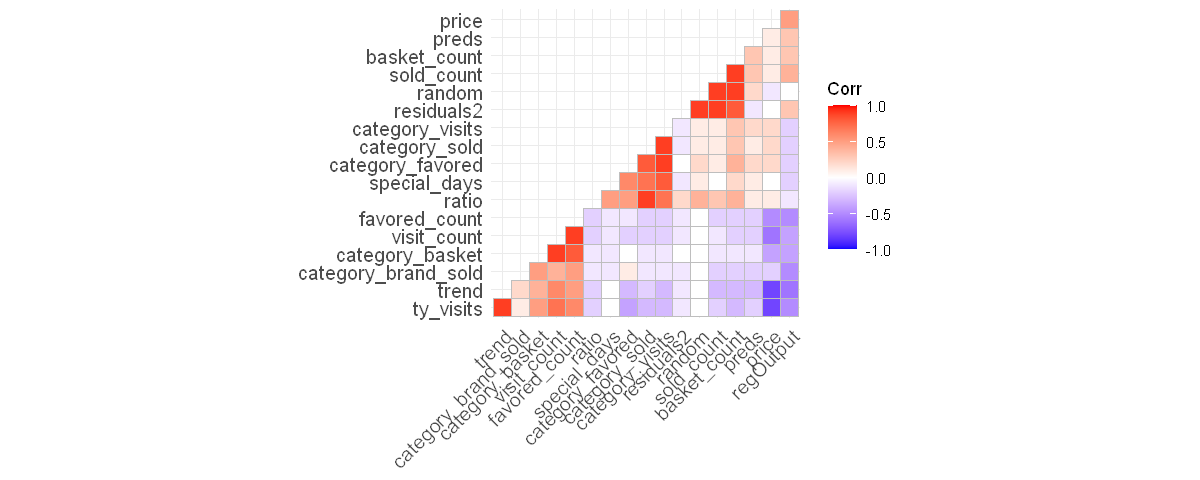

In [394]:
prod1[, residuals2:=c(NA, model1_2$residuals)]
corr <- round(cor(Filter(is.numeric, prod1[!is.na(prod1$price) & !is.na(prod1$residuals2)])), 1)
ggcorrplot(corr, hc.order = TRUE,type = "lower")

It seems that there is not a good second regressor. Now, we can examine the lagged sold_count. 

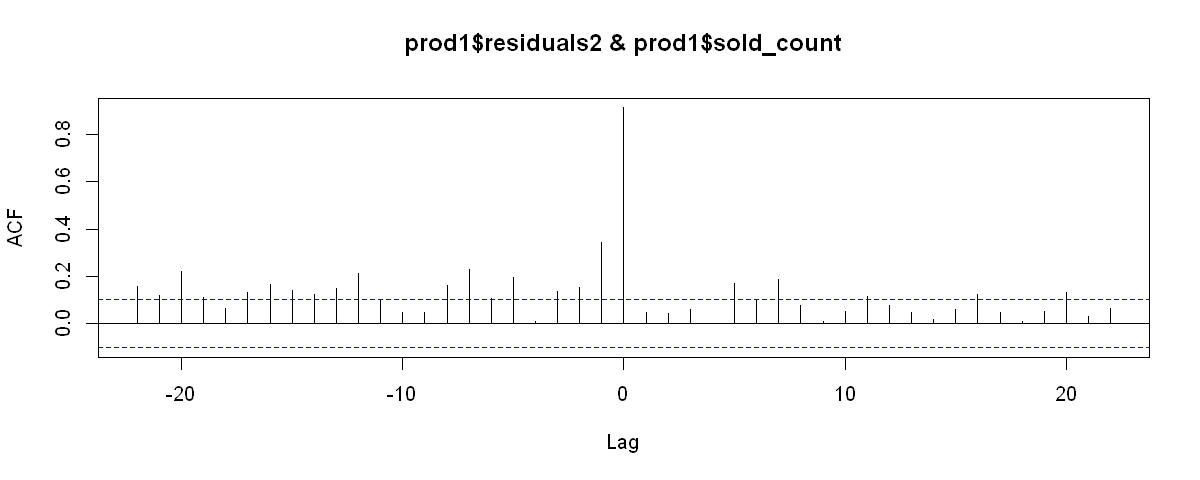

In [389]:
ccf(prod1$residuals2, prod1$sold_count, na.action=na.pass)

In [390]:
model1_3 <- lm(sold_count~shift(basket_count,1)+shift(sold_count,1), data=prod1)
summary(model1_3)


Call:
lm(formula = sold_count ~ shift(basket_count, 1) + shift(sold_count, 
    1), data = prod1)

Residuals:
    Min      1Q  Median      3Q     Max 
-12.095  -0.422  -0.422  -0.422  50.913 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)  
(Intercept)             0.42174    0.17521   2.407   0.0166 *
shift(basket_count, 1)  0.03979    0.02079   1.913   0.0565 .
shift(sold_count, 1)    0.22780    0.10933   2.084   0.0379 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.225 on 364 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.1816,	Adjusted R-squared:  0.1771 
F-statistic: 40.38 on 2 and 364 DF,  p-value: < 2.2e-16



	Breusch-Godfrey test for serial correlation of order up to 10

data:  Residuals
LM test = 33.707, df = 10, p-value = 0.000207


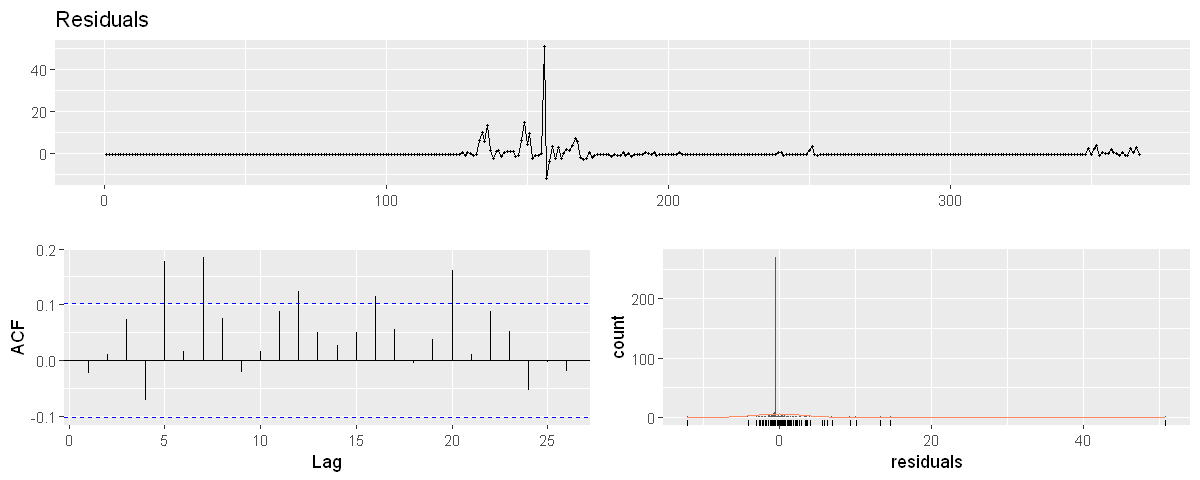

In [391]:
checkresiduals(model1_3)

The adjusted Rsqr value is very low. Linear regression assumptions are not satisfied but there is not a good regressors for this  model. Therefore, the final model is model1_3.

Warning message:
"Removed 1 rows containing missing values (geom_point)."

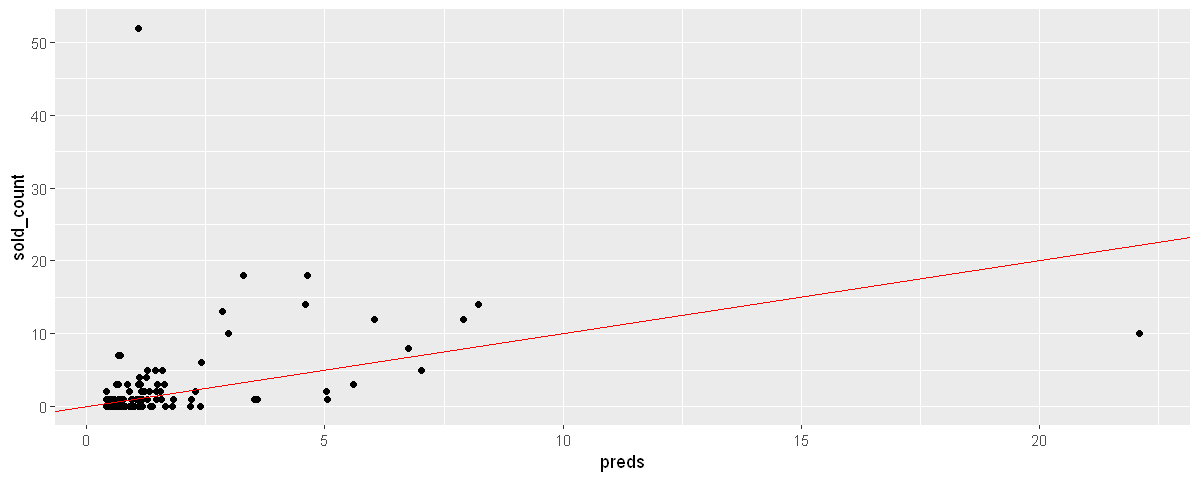

In [392]:
prod1[, preds:=c(NA,model1_3$fitted.values)]
ggplot(prod1, aes(x=preds, y=sold_count)) + geom_point() + geom_abline(intercept=0, slope=1, color="red")

### Forecasting

In [484]:
forecast_data_mont <- data.table(event_date=mont[event_date>=test_start&event_date<=test_end,]$event_date,
                            sold_count=mont[event_date>=test_start&event_date<=test_end,]$sold_count)
mont[,`:=`(trend=1:.N,
           days=wday(event_date, label=T))]
arima_fc <- numeric(0)
arimax_fc <- numeric(0)
reg_fc <- numeric(0)
for(i in 1:length(test_dates)){
  
  train_dt <- mont[event_date<test_dates[i],]
  model_arima <- Arima(train_dt$sold_count,order=c(4,1,2))
  model_arimax <- Arima(train_dt$sold_count,order=c(4,1,2),xreg=train_dt$basket_count)
  newreg <- forecast(auto.arima(train_dt$basket_count),h=1)$mean[1]
  model_reg <- lm(sold_count~shift(basket_count,1)+shift(sold_count,1), data=train_dt)
  arima_temp <- forecast(model_arima)
  arimax_temp <- forecast(model_arimax,xreg=newreg)
  reg_temp <- predict(model_reg,newdata=mont[event_date %in% c(test_dates[i],test_dates[i+1])])
  arima_fc <- c(arima_fc,arima_temp$mean[1])
  arimax_fc <- c(arimax_fc,arimax_temp$mean[1])
  reg_fc <- c(reg_fc,reg_temp)
  
}
reg_fc[is.na(reg_fc)] <- mean(reg_fc[!is.na(reg_fc)])
forecast_data_mont <- forecast_data_mont[,`:=`(arima_p=arima_fc,
                                               arimax_p=arimax_fc,
                                               reg_p=reg_fc[c(1,seq(2,28,2))])]
accu(forecast_data_mont$sold_count,forecast_data_mont$arima_p)
accu(forecast_data_mont$sold_count,forecast_data_mont$arimax_p)
accu(forecast_data_mont[1:(.N-1)]$sold_count,forecast_data_mont[2:.N]$reg_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
15,2.333333,1.676163,0.7183558,0.08981909,Inf,1.965482,1.658188,0.7106522,0.7106522


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
15,2.333333,1.676163,0.7183558,0.2055338,Inf,1.8071,1.566158,0.6712104,0.6712104


n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
14,2.5,1.60528,0.6421119,0.331908,Inf,1.334793,1.104169,0.4416677,0.4416677


In [485]:
result_data_mont <- data.table(event_date=mont[event_date>=result_start&event_date<=result_end,]$event_date,
                               sold_count=mont[event_date>=result_start&event_date<=result_end,]$sold_count)
final_fc <- numeric(0)
for(i in 1:length(result_dates)){
  
  train_dt <- mont[event_date<result_dates[i],]
  model_final <- lm(sold_count~trend+days+shift(basket_count, 1)+shift(sold_count, 1), data=train_dt)
  final_temp <- predict(model_final,newdata=mont[event_date %in% c(result_dates[i],result_dates[i+1])])
  final_fc <- c(final_fc,final_temp)
  
}
final_fc[is.na(final_fc)] <- mean(final_fc[!is.na(final_fc)])
result_data_mont <- result_data_mont[,`:=`(final_p=final_fc[c(1,seq(2,28,2))])]
accu(result_data_mont[1:(.N-1)]$sold_count,result_data_mont[2:.N]$final_p)

n,mean,sd,CV,FBias,MAPE,RMSE,MAD,MADP,WMAPE
14,2.142857,1.657484,0.7734925,0.3304018,Inf,1.331044,1.081682,0.5047848,0.5047848


In [486]:
data.frame(event_date=result_data_mont[1:(.N-1)]$event_date,
           sold_count=result_data_mont[1:(.N-1)]$sold_count,
           predictions=result_data_mont[2:.N]$final_p)

event_date,sold_count,predictions
2021-06-12,2,1.2841955
2021-06-13,0,0.8663982
2021-06-14,5,2.4952462
2021-06-15,4,3.5127946
2021-06-16,5,2.1635188
2021-06-17,0,0.8157084
2021-06-18,3,1.0377658
2021-06-19,0,0.4540381
2021-06-20,1,1.1227687
2021-06-21,2,1.1356978
